In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [6]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


## Get Statistics on positive class (patients having at least one CVD event)

In [7]:
view_v = copy.deepcopy(view_1hot_df.values)

In [8]:
print(view_v.shape)
list(view_1hot_df.columns)

(2802688, 189)


['VSIMPLE_INDEX_MASTER',
 'AGE',
 'SEX',
 'NZDEP',
 'ETHN_1',
 'ETHN_2',
 'ETHN_3',
 'ETHN_4',
 'ETHN_5',
 'TEST',
 'HDL',
 'LDL',
 'TRI',
 'TCL',
 'TCHDL',
 'TESTED',
 'DIED',
 'LL_SIMVASTATIN',
 'LL_BEZAFIBRATE',
 'LL_ATORVASTATIN',
 'LL_EZETIMIBE',
 'LL_NICOTINIC_ACID',
 'LL_ACIPIMOX',
 'LL_CHOLESTYRAMINE',
 'LL_COLESTIPOL_HYDROCHLORIDE',
 'LL_PRAVASTATIN',
 'LL_EZETIMIBE_WITH_SIMVASTATIN',
 'LL_GEMFIBROZIL',
 'LL_PDC',
 'CVD_FELODIPINE',
 'CVD_QUINAPRIL',
 'CVD_METOPROLOL_SUCCINATE',
 'CVD_CILAZAPRIL',
 'CVD_ATENOLOL',
 'CVD_BENDROFLUMETHIAZIDE',
 'CVD_WARFARIN_SODIUM',
 'CVD_FUROSEMIDE',
 'CVD_CELIPROLOL',
 'CVD_DILTIAZEM_HYDROCHLORIDE',
 'CVD_ASPIRIN',
 'CVD_NIFEDIPINE',
 'CVD_CAPTOPRIL',
 'CVD_DIPYRIDAMOLE',
 'CVD_CANDESARTAN_CILEXETIL',
 'CVD_INDAPAMIDE',
 'CVD_ENALAPRIL_MALEATE',
 'CVD_SOTALOL',
 'CVD_GLYCERYL_TRINITRATE',
 'CVD_ISOSORBIDE_MONONITRATE',
 'CVD_PINDOLOL',
 'CVD_CARVEDILOL',
 'CVD_METHYLDOPA',
 'CVD_LOSARTAN_POTASSIUM',
 'CVD_VERAPAMIL_HYDROCHLORIDE',
 'CVD_AMILO

In [9]:
#view_1hot_df['PT_ATRIAL_FIBRILLATION'].unique()
#view_1hot_df['PT_IMP_FATAL_CVD'].unique()
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162


In [10]:
num_of_inds = view_v.shape[0]//28
print("Number of individuals:", num_of_inds)

ind_w_event = []
for i in range(num_of_inds):
    ind_v = view_v[(i*28):((i+1)*28), :]
    for j in range(8, 28):
        if ind_v[j , 121] == 1.0 and \
           1.0 in ind_v[j, 143:163]:
            ind_w_event.append(ind_v[0, 0])
print("Number of acute CVD hospitalisations:", len(set(ind_w_event)))

Number of individuals: 100096
Number of acute CVD hospitalisations: 12647


In [11]:
ind_cvd_death = view_1hot_df[view_1hot_df['PT_IMP_FATAL_CVD']==1]\
                         ['VSIMPLE_INDEX_MASTER'].unique()
print("Number of CVD deaths:", len(ind_cvd_death))

Number of CVD deaths: 348


In [12]:
ind_w_event = list(set(ind_w_event)) + list(ind_cvd_death)
print("Number of CVD events including CVD deaths:", len(set(ind_w_event)))

Number of CVD events including CVD deaths: 12829


In [13]:
ind_w_event = set(ind_w_event)
# assess statistics in training and testing set
train_df  = view_1hot_df.iloc[:(28*90000), :-7]
test_df = view_1hot_df.iloc[(28*90000):, :-7] 
print(train_df.shape)
print(train_df.shape[0]/28)
print(test_df.shape)
print(test_df.shape[0]/28)
             
ind_w_event_train = train_df[train_df['VSIMPLE_INDEX_MASTER'].isin(ind_w_event)]['VSIMPLE_INDEX_MASTER'].unique()
ind_w_event_test = test_df[test_df['VSIMPLE_INDEX_MASTER'].isin(ind_w_event)]['VSIMPLE_INDEX_MASTER'].unique()
print("Number of inds with CVD events (training set):", len(ind_w_event_train))
print("Number of inds with CVD events (testing set):", len(ind_w_event_test))
ind_death_train = train_df[train_df['VSIMPLE_INDEX_MASTER'].isin(ind_cvd_death)]['VSIMPLE_INDEX_MASTER'].unique()
ind_death_test = test_df[test_df['VSIMPLE_INDEX_MASTER'].isin(ind_cvd_death)]['VSIMPLE_INDEX_MASTER'].unique()
print("Number of CVD deaths (training set):", len(ind_death_train))
print("Number of CVD deaths (testing set):", len(ind_death_test))

(2520000, 182)
90000.0
(282688, 182)
10096.0
Number of inds with CVD events (training set): 11472
Number of inds with CVD events (testing set): 1357
Number of CVD deaths (training set): 302
Number of CVD deaths (testing set): 46


In [14]:
print("DIED:", view_1hot_df.columns.get_loc('DIED'))

DIED: 16


In [15]:
num_of_inds = view_v.shape[0]//28
print("Number of individuals:", num_of_inds)

ind_died = []
for i in range(num_of_inds):
    ind_v = view_v[(i*28):((i+1)*28), :]
    if 1.0 in ind_v[:, 16]:
        ind_died.append(ind_v[0, 0])
ind_died = list(set(ind_died))
print("Number of deaths:", len(ind_died))

Number of individuals: 100096
Number of deaths: 6634


In [16]:
ind_death_train = train_df[train_df['VSIMPLE_INDEX_MASTER'].isin(ind_died)]['VSIMPLE_INDEX_MASTER'].unique()
ind_death_test = test_df[test_df['VSIMPLE_INDEX_MASTER'].isin(ind_died)]['VSIMPLE_INDEX_MASTER'].unique()
print("Number of deaths (training set):", len(ind_death_train))
print("Number of deaths (testing set):", len(ind_death_test))

Number of deaths (training set): 5940
Number of deaths (testing set): 694


## Hyperparameter tuning

In [5]:
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [6]:
#################################
# construct y
#################################
num_of_inds = train_v.shape[0]//28
print("Number of individuals:", num_of_inds)

y_train = np.empty((num_of_inds, 2))

for i in range(num_of_inds):
    ind_v = train_v[(i*28):((i+1)*28), :]
    event = False
    for j in range(8, 28):
        if ind_v[j, 121] == 1.0 and \
            1.0 in ind_v[j, 143:163]:  # it is an acute CVD event
            event = True
        if 1.0 in ind_v[8:, 181]:
            event = True
    if event:
        y_train[i, :] = np.array([0.0, 1.0])
    else:
        y_train[i, :] = np.array([1.0, 0.0])
print("Number of individuals who had a CVD event:", \
      sum(y_train[:, 1]))
print("Event ratio:", sum(y_train[:, 1])/num_of_inds)

Number of individuals: 90000
Number of individuals who had a CVD event: 11472.0
Event ratio: 0.12746666666666667


In [7]:
print(y_train[y_train[:, 0]==1].shape)
print(y_train[y_train[:, 1]==1].shape)

(78528, 2)
(11472, 2)


In [8]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [9]:
# make x_train
num_of_inds = train_v.shape[0]//28
print("Number of inds:", num_of_inds)
num_of_features = train_v.shape[1]
print("Number of features:", num_of_features)

x_train = np.empty((num_of_inds, 8, num_of_features))

for i in range(num_of_inds):
    scaled_ind_v = scaled_train[(i*28):((i+1)*28), :]
    x_train[i] = scaled_ind_v[:8, :]
print(x_train.shape)
print(y_train.shape)

Number of inds: 90000
Number of features: 182
(90000, 8, 182)
(90000, 2)


In [10]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

9000


9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 15.1023 - acc: 0.8202 - val_loss: 6.2432 - val_acc: 0.8784

Epoch 00001: val_loss improved from inf to 6.24325, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 3.1508 - acc: 0.8758 - val_loss: 1.2186 - val_acc: 0.8798

Epoch 00002: val_loss improved from 6.24325 to 1.21856, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.7070 - acc: 0.8762 - val_loss: 0.4157 - val_acc: 0.8800

Epoch 00003: val_loss improved from 1.21856 to 0.41569, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.3625 - acc: 0.8762 - val_loss: 0.3290 - val_acc: 0.8804

Epoch 00004: val_loss improved from 0.41569 to 0.32905, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.3298 - acc: 0.8766 - val_loss: 0.3223 - val_acc: 0.8804

Epoch 00005: val_los

 - 1s - loss: 0.3220 - acc: 0.8774 - val_loss: 0.3158 - val_acc: 0.8811

Epoch 00046: val_loss did not improve from 0.31557
Epoch 47/100
 - 1s - loss: 0.3219 - acc: 0.8774 - val_loss: 0.3161 - val_acc: 0.8808

Epoch 00047: val_loss did not improve from 0.31557
Epoch 48/100
 - 1s - loss: 0.3220 - acc: 0.8774 - val_loss: 0.3160 - val_acc: 0.8808

Epoch 00048: val_loss did not improve from 0.31557
Epoch 49/100
 - 1s - loss: 0.3218 - acc: 0.8774 - val_loss: 0.3155 - val_acc: 0.8811

Epoch 00049: val_loss improved from 0.31557 to 0.31549, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3218 - acc: 0.8775 - val_loss: 0.3158 - val_acc: 0.8810

Epoch 00050: val_loss did not improve from 0.31549
Epoch 51/100
 - 1s - loss: 0.3217 - acc: 0.8775 - val_loss: 0.3155 - val_acc: 0.8810

Epoch 00051: val_loss did not improve from 0.31549
Epoch 52/100
 - 1s - loss: 0.3218 - acc: 0.8776 - val_loss: 0.3164 - val_acc: 0.8809

Epoch 00052: val_loss did not improve from 0.31549
Epoch 53/

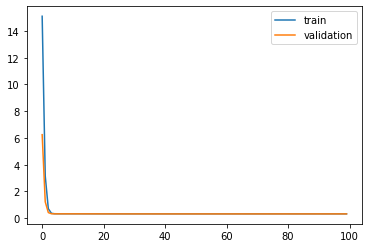

Time to train LSTM:  64.1122362613678
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 15.1591 - acc: 0.8207 - val_loss: 6.2898 - val_acc: 0.8716

Epoch 00001: val_loss improved from inf to 6.28980, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 3.1706 - acc: 0.8766 - val_loss: 1.2402 - val_acc: 0.8749

Epoch 00002: val_loss improved from 6.28980 to 1.24021, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.7108 - acc: 0.8764 - val_loss: 0.4287 - val_acc: 0.8757

Epoch 00003: val_loss improved from 1.24021 to 0.42870, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.3627 - acc: 0.8768 - val_loss: 0.3402 - val_acc: 0.8760

Epoch 00004: val_loss improved from 0.42870 to 0.34015, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.3297 - acc: 0.8770 - val_loss: 0.3338 - val_acc: 0.8764

Epoch 00005: val_loss improved from 0.34015 to 0.33376, saving model to Event_val_weights2.hdf5
Epoch 6/100


Epoch 00049: val_loss improved from 0.32579 to 0.32574, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3208 - acc: 0.8779 - val_loss: 0.3259 - val_acc: 0.8757

Epoch 00050: val_loss did not improve from 0.32574
Epoch 51/100
 - 1s - loss: 0.3208 - acc: 0.8780 - val_loss: 0.3259 - val_acc: 0.8752

Epoch 00051: val_loss did not improve from 0.32574
Epoch 52/100
 - 1s - loss: 0.3209 - acc: 0.8780 - val_loss: 0.3257 - val_acc: 0.8752

Epoch 00052: val_loss improved from 0.32574 to 0.32568, saving model to Event_val_weights2.hdf5
Epoch 53/100
 - 1s - loss: 0.3208 - acc: 0.8779 - val_loss: 0.3256 - val_acc: 0.8753

Epoch 00053: val_loss improved from 0.32568 to 0.32564, saving model to Event_val_weights2.hdf5
Epoch 54/100
 - 1s - loss: 0.3207 - acc: 0.8780 - val_loss: 0.3257 - val_acc: 0.8753

Epoch 00054: val_loss did not improve from 0.32564
Epoch 55/100
 - 1s - loss: 0.3207 - acc: 0.8780 - val_loss: 0.3256 - val_acc: 0.8753

Epoch 00055: val_loss improved from 0.3256

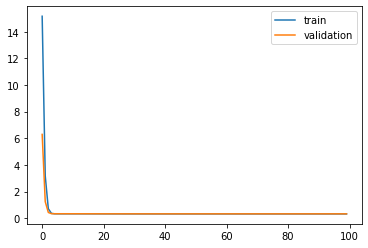

Time to train LSTM:  65.36537456512451
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 15.1405 - acc: 0.8299 - val_loss: 6.2714 - val_acc: 0.8753

Epoch 00001: val_loss improved from inf to 6.27145, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 3.1568 - acc: 0.8762 - val_loss: 1.2299 - val_acc: 0.8780

Epoch 00002: val_loss improved from 6.27145 to 1.22988, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.7067 - acc: 0.8765 - val_loss: 0.4251 - val_acc: 0.8770

Epoch 00003: val_loss improved from 1.22988 to 0.42506, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.3614 - acc: 0.8764 - val_loss: 0.3383 - val_acc: 0.8763

Epoch 00004: val_loss improved from 0.42506 to 0.33825, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.3290 - acc: 0.8768 - val_loss: 0.3317 - val_acc: 0.8774

Epoch 00005: val_loss improved from 0.33825 to 0.33169, saving model to Event_val_weights3.hdf5
Epoch 6/10


Epoch 00048: val_loss did not improve from 0.32529
Epoch 49/100
 - 1s - loss: 0.3208 - acc: 0.8781 - val_loss: 0.3254 - val_acc: 0.8770

Epoch 00049: val_loss did not improve from 0.32529
Epoch 50/100
 - 1s - loss: 0.3206 - acc: 0.8781 - val_loss: 0.3257 - val_acc: 0.8767

Epoch 00050: val_loss did not improve from 0.32529
Epoch 51/100
 - 1s - loss: 0.3206 - acc: 0.8781 - val_loss: 0.3254 - val_acc: 0.8768

Epoch 00051: val_loss did not improve from 0.32529
Epoch 52/100
 - 1s - loss: 0.3207 - acc: 0.8781 - val_loss: 0.3257 - val_acc: 0.8767

Epoch 00052: val_loss did not improve from 0.32529
Epoch 53/100
 - 1s - loss: 0.3205 - acc: 0.8781 - val_loss: 0.3255 - val_acc: 0.8768

Epoch 00053: val_loss did not improve from 0.32529
Epoch 54/100
 - 1s - loss: 0.3205 - acc: 0.8782 - val_loss: 0.3253 - val_acc: 0.8767

Epoch 00054: val_loss did not improve from 0.32529
Epoch 55/100
 - 1s - loss: 0.3204 - acc: 0.8782 - val_loss: 0.3253 - val_acc: 0.8764

Epoch 00055: val_loss did not improve fr

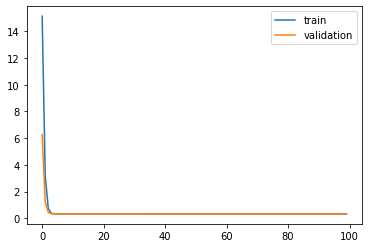

Time to train LSTM:  66.64562034606934


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa5440549e8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 15.0192 - acc: 0.8240 - val_loss: 6.2153 - val_acc: 0.8707

Epoch 00001: val_loss improved from inf to 6.21533, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 3.1281 - acc: 0.8776 - val_loss: 1.2248 - val_acc: 0.8737

Epoch 00002: val_loss improved from 6.21533 to 1.22481, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.7038 - acc: 0.8772 - val_loss: 0.4265 - val_acc: 0.8729

Epoch 00003: val_loss improved from 1.22481 to 0.42654, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.3612 - acc: 0.8774 - val_loss: 0.3399 - val_acc: 0.8724

Epoch 00004: val_loss improved from 0.42654 to 0.33995, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.3284 - acc: 0.8779 - val_loss: 0.3338 - val_acc: 0.8734

Epoch 00005: val_loss improved from 0.33995 to 0.33377, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.3263 - acc: 0.8780 - 

 - 1s - loss: 0.3206 - acc: 0.8789 - val_loss: 0.3307 - val_acc: 0.8706

Epoch 00052: val_loss did not improve from 0.33043
Epoch 53/100
 - 1s - loss: 0.3206 - acc: 0.8788 - val_loss: 0.3308 - val_acc: 0.8706

Epoch 00053: val_loss did not improve from 0.33043
Epoch 54/100
 - 1s - loss: 0.3205 - acc: 0.8790 - val_loss: 0.3308 - val_acc: 0.8703

Epoch 00054: val_loss did not improve from 0.33043
Epoch 55/100
 - 1s - loss: 0.3206 - acc: 0.8789 - val_loss: 0.3309 - val_acc: 0.8703

Epoch 00055: val_loss did not improve from 0.33043
Epoch 56/100
 - 1s - loss: 0.3205 - acc: 0.8790 - val_loss: 0.3309 - val_acc: 0.8704

Epoch 00056: val_loss did not improve from 0.33043
Epoch 57/100
 - 1s - loss: 0.3204 - acc: 0.8789 - val_loss: 0.3308 - val_acc: 0.8704

Epoch 00057: val_loss did not improve from 0.33043
Epoch 58/100
 - 1s - loss: 0.3203 - acc: 0.8790 - val_loss: 0.3308 - val_acc: 0.8706

Epoch 00058: val_loss did not improve from 0.33043
Epoch 59/100
 - 1s - loss: 0.3203 - acc: 0.8790 - val_

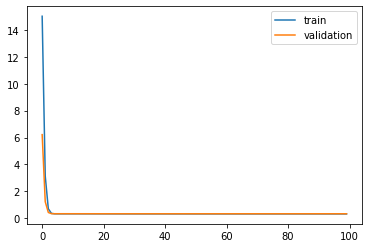

Time to train LSTM:  67.44243335723877
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 15.0648 - acc: 0.8199 - val_loss: 6.2177 - val_acc: 0.8764

Epoch 00001: val_loss improved from inf to 6.21772, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 3.1302 - acc: 0.8762 - val_loss: 1.2135 - val_acc: 0.8773

Epoch 00002: val_loss improved from 6.21772 to 1.21345, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.7024 - acc: 0.8766 - val_loss: 0.4180 - val_acc: 0.8781

Epoch 00003: val_loss improved from 1.21345 to 0.41802, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.3618 - acc: 0.8764 - val_loss: 0.3333 - val_acc: 0.8783

Epoch 00004: val_loss improved from 0.41802 to 0.33329, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.3297 - acc: 0.8767 - val_loss: 0.3272 - val_acc: 0.8781

Epoch 00005: val_loss improved from 0.33329 to 0.32718, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3215 - acc: 0.8780 - val_loss: 0.3212 - val_acc: 0.8784

Epoch 00048: val_loss did not improve from 0.32115
Epoch 49/100
 - 1s - loss: 0.3216 - acc: 0.8781 - val_loss: 0.3213 - val_acc: 0.8780

Epoch 00049: val_loss did not improve from 0.32115
Epoch 50/100
 - 1s - loss: 0.3216 - acc: 0.8781 - val_loss: 0.3216 - val_acc: 0.8787

Epoch 00050: val_loss did not improve from 0.32115
Epoch 51/100
 - 1s - loss: 0.3221 - acc: 0.8780 - val_loss: 0.3219 - val_acc: 0.8782

Epoch 00051: val_loss did not improve from 0.32115
Epoch 52/100
 - 1s - loss: 0.3215 - acc: 0.8780 - val_loss: 0.3213 - val_acc: 0.8783

Epoch 00052: val_loss did not improve from 0.32115
Epoch 53/100
 - 1s - loss: 0.3213 - acc: 0.8781 - val_loss: 0.3211 - val_acc: 0.8784

Epoch 00053: val_loss improved from 0.32115 to 0.32108, saving model to Event_val_weights5.hdf5
Epoch 54/100
 - 1s - loss: 0.3212 - acc: 0.8780 - val_loss: 0.3211 - val_acc: 0.8787

Epoch 00054: val_loss improved from 0.32108 to 0.32106, savi

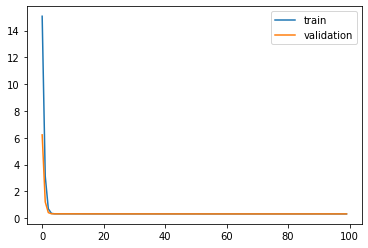

Time to train LSTM:  68.12299609184265


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa64812d5c0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 20.5106 - acc: 0.7601 - val_loss: 13.7434 - val_acc: 0.8614

Epoch 00001: val_loss improved from inf to 13.74339, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 9.8194 - acc: 0.8708 - val_loss: 6.2897 - val_acc: 0.8772

Epoch 00002: val_loss improved from 13.74339 to 6.28968, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 4.3984 - acc: 0.8757 - val_loss: 2.7485 - val_acc: 0.8802

Epoch 00003: val_loss improved from 6.28968 to 2.74848, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.9263 - acc: 0.8767 - val_loss: 1.2240 - val_acc: 0.8794

Epoch 00004: val_loss improved from 2.74848 to 1.22398, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.9009 - acc: 0.8765 - val_loss: 0.6264 - val_acc: 0.8788

Epoch 00005: val_loss improved from 1.22398 to 0.62637, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.5142 - acc: 0.8764

 - 1s - loss: 0.3212 - acc: 0.8777 - val_loss: 0.3148 - val_acc: 0.8811

Epoch 00051: val_loss did not improve from 0.31448
Epoch 52/100
 - 1s - loss: 0.3212 - acc: 0.8778 - val_loss: 0.3143 - val_acc: 0.8808

Epoch 00052: val_loss improved from 0.31448 to 0.31431, saving model to Event_val_weights1.hdf5
Epoch 53/100
 - 1s - loss: 0.3211 - acc: 0.8779 - val_loss: 0.3145 - val_acc: 0.8808

Epoch 00053: val_loss did not improve from 0.31431
Epoch 54/100
 - 1s - loss: 0.3210 - acc: 0.8778 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00054: val_loss did not improve from 0.31431
Epoch 55/100
 - 1s - loss: 0.3209 - acc: 0.8778 - val_loss: 0.3144 - val_acc: 0.8803

Epoch 00055: val_loss did not improve from 0.31431
Epoch 56/100
 - 1s - loss: 0.3208 - acc: 0.8778 - val_loss: 0.3142 - val_acc: 0.8804

Epoch 00056: val_loss improved from 0.31431 to 0.31422, saving model to Event_val_weights1.hdf5
Epoch 57/100
 - 1s - loss: 0.3207 - acc: 0.8777 - val_loss: 0.3141 - val_acc: 0.8800

Epoch 00057: va

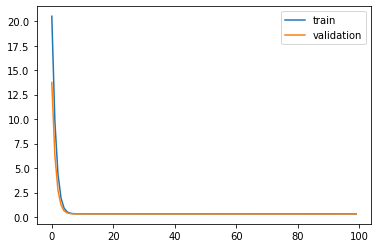

Time to train LSTM:  75.80904650688171
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 20.3641 - acc: 0.7641 - val_loss: 13.6552 - val_acc: 0.8611

Epoch 00001: val_loss improved from inf to 13.65517, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 9.7504 - acc: 0.8726 - val_loss: 6.2575 - val_acc: 0.8711

Epoch 00002: val_loss improved from 13.65517 to 6.25747, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 4.3685 - acc: 0.8765 - val_loss: 2.7423 - val_acc: 0.8750

Epoch 00003: val_loss improved from 6.25747 to 2.74229, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.9146 - acc: 0.8773 - val_loss: 1.2290 - val_acc: 0.8731

Epoch 00004: val_loss improved from 2.74229 to 1.22896, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.8967 - acc: 0.8774 - val_loss: 0.6352 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.22896 to 0.63524, saving model to Event_val_weights2.hdf5
Epoch 6

 - 1s - loss: 0.3202 - acc: 0.8788 - val_loss: 0.3261 - val_acc: 0.8753

Epoch 00051: val_loss improved from 0.32624 to 0.32613, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3202 - acc: 0.8788 - val_loss: 0.3262 - val_acc: 0.8758

Epoch 00052: val_loss did not improve from 0.32613
Epoch 53/100
 - 1s - loss: 0.3202 - acc: 0.8789 - val_loss: 0.3264 - val_acc: 0.8752

Epoch 00053: val_loss did not improve from 0.32613
Epoch 54/100
 - 1s - loss: 0.3200 - acc: 0.8788 - val_loss: 0.3266 - val_acc: 0.8757

Epoch 00054: val_loss did not improve from 0.32613
Epoch 55/100
 - 1s - loss: 0.3199 - acc: 0.8789 - val_loss: 0.3261 - val_acc: 0.8751

Epoch 00055: val_loss improved from 0.32613 to 0.32610, saving model to Event_val_weights2.hdf5
Epoch 56/100
 - 1s - loss: 0.3198 - acc: 0.8788 - val_loss: 0.3262 - val_acc: 0.8759

Epoch 00056: val_loss did not improve from 0.32610
Epoch 57/100
 - 1s - loss: 0.3199 - acc: 0.8789 - val_loss: 0.3263 - val_acc: 0.8753

Epoch 00057: va

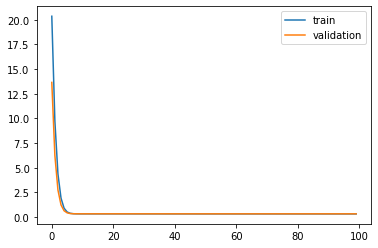

Time to train LSTM:  75.71156191825867
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 20.3150 - acc: 0.7782 - val_loss: 13.6170 - val_acc: 0.8616

Epoch 00001: val_loss improved from inf to 13.61696, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 9.7123 - acc: 0.8731 - val_loss: 6.2283 - val_acc: 0.8752

Epoch 00002: val_loss improved from 13.61696 to 6.22835, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 4.3451 - acc: 0.8771 - val_loss: 2.7261 - val_acc: 0.8769

Epoch 00003: val_loss improved from 6.22835 to 2.72615, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.9022 - acc: 0.8775 - val_loss: 1.2194 - val_acc: 0.8762

Epoch 00004: val_loss improved from 2.72615 to 1.21935, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.8913 - acc: 0.8773 - val_loss: 0.6303 - val_acc: 0.8763

Epoch 00005: val_loss improved from 1.21935 to 0.63026, saving model to Event_val_weights3.hdf5
Epoch 6

 - 1s - loss: 0.3197 - acc: 0.8784 - val_loss: 0.3244 - val_acc: 0.8766

Epoch 00048: val_loss improved from 0.32449 to 0.32442, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8784 - val_loss: 0.3244 - val_acc: 0.8764

Epoch 00049: val_loss improved from 0.32442 to 0.32442, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8784 - val_loss: 0.3243 - val_acc: 0.8763

Epoch 00050: val_loss improved from 0.32442 to 0.32426, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8785 - val_loss: 0.3243 - val_acc: 0.8762

Epoch 00051: val_loss did not improve from 0.32426
Epoch 52/100
 - 1s - loss: 0.3193 - acc: 0.8784 - val_loss: 0.3243 - val_acc: 0.8763

Epoch 00052: val_loss did not improve from 0.32426
Epoch 53/100
 - 1s - loss: 0.3193 - acc: 0.8784 - val_loss: 0.3243 - val_acc: 0.8764

Epoch 00053: val_loss did not improve from 0.32426
Epoch 54/100
 - 1s - loss: 0.3192 - acc: 0.8785 - val_lo

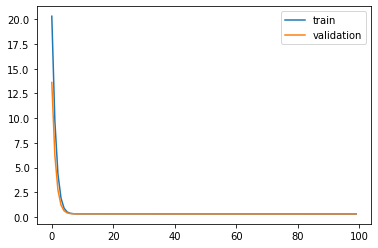

Time to train LSTM:  76.03679180145264


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa3b9bcc588>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 20.4608 - acc: 0.7478 - val_loss: 13.7220 - val_acc: 0.8454

Epoch 00001: val_loss improved from inf to 13.72204, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 9.7895 - acc: 0.8700 - val_loss: 6.2841 - val_acc: 0.8700

Epoch 00002: val_loss improved from 13.72204 to 6.28407, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 4.3836 - acc: 0.8763 - val_loss: 2.7543 - val_acc: 0.8711

Epoch 00003: val_loss improved from 6.28407 to 2.75431, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.9197 - acc: 0.8774 - val_loss: 1.2336 - val_acc: 0.8722

Epoch 00004: val_loss improved from 2.75431 to 1.23359, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.8972 - acc: 0.8772 - val_loss: 0.6384 - val_acc: 0.8718

Epoch 00005: val_loss improved from 1.23359 to 0.63836, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.5122 - acc: 0.8774

 - 1s - loss: 0.3193 - acc: 0.8790 - val_loss: 0.3301 - val_acc: 0.8709

Epoch 00049: val_loss did not improve from 0.33001
Epoch 50/100
 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3301 - val_acc: 0.8703

Epoch 00050: val_loss did not improve from 0.33001
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8791 - val_loss: 0.3300 - val_acc: 0.8708

Epoch 00051: val_loss did not improve from 0.33001
Epoch 52/100
 - 1s - loss: 0.3191 - acc: 0.8790 - val_loss: 0.3299 - val_acc: 0.8704

Epoch 00052: val_loss improved from 0.33001 to 0.32994, saving model to Event_val_weights4.hdf5
Epoch 53/100
 - 1s - loss: 0.3191 - acc: 0.8791 - val_loss: 0.3300 - val_acc: 0.8708

Epoch 00053: val_loss did not improve from 0.32994
Epoch 54/100
 - 1s - loss: 0.3189 - acc: 0.8791 - val_loss: 0.3298 - val_acc: 0.8704

Epoch 00054: val_loss improved from 0.32994 to 0.32982, saving model to Event_val_weights4.hdf5
Epoch 55/100
 - 1s - loss: 0.3189 - acc: 0.8792 - val_loss: 0.3298 - val_acc: 0.8709

Epoch 00055: va

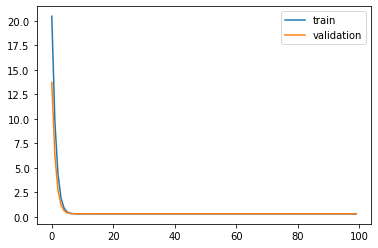

Time to train LSTM:  79.03546476364136
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 20.3235 - acc: 0.7509 - val_loss: 13.6113 - val_acc: 0.8488

Epoch 00001: val_loss improved from inf to 13.61125, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 9.7174 - acc: 0.8685 - val_loss: 6.2289 - val_acc: 0.8773

Epoch 00002: val_loss improved from 13.61125 to 6.22889, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 4.3524 - acc: 0.8762 - val_loss: 2.7299 - val_acc: 0.8778

Epoch 00003: val_loss improved from 6.22889 to 2.72995, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.9078 - acc: 0.8774 - val_loss: 1.2195 - val_acc: 0.8773

Epoch 00004: val_loss improved from 2.72995 to 1.21953, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.8932 - acc: 0.8770 - val_loss: 0.6267 - val_acc: 0.8770

Epoch 00005: val_loss improved from 1.21953 to 0.62672, saving model to Event_val_weights5.hdf5
Epoch 6


Epoch 00051: val_loss improved from 0.32062 to 0.32057, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3200 - acc: 0.8782 - val_loss: 0.3205 - val_acc: 0.8799

Epoch 00052: val_loss improved from 0.32057 to 0.32055, saving model to Event_val_weights5.hdf5
Epoch 53/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3204 - val_acc: 0.8798

Epoch 00053: val_loss improved from 0.32055 to 0.32038, saving model to Event_val_weights5.hdf5
Epoch 54/100
 - 1s - loss: 0.3199 - acc: 0.8783 - val_loss: 0.3204 - val_acc: 0.8799

Epoch 00054: val_loss did not improve from 0.32038
Epoch 55/100
 - 1s - loss: 0.3199 - acc: 0.8783 - val_loss: 0.3204 - val_acc: 0.8800

Epoch 00055: val_loss improved from 0.32038 to 0.32036, saving model to Event_val_weights5.hdf5
Epoch 56/100
 - 1s - loss: 0.3197 - acc: 0.8784 - val_loss: 0.3203 - val_acc: 0.8799

Epoch 00056: val_loss improved from 0.32036 to 0.32026, saving model to Event_val_weights5.hdf5
Epoch 57/100
 - 1s - loss: 0.3197 - ac

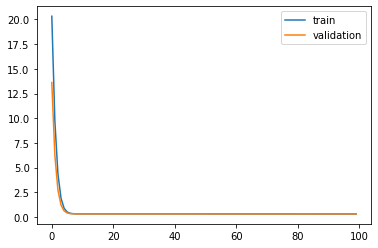

Time to train LSTM:  77.24653172492981
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 23.9436 - acc: 0.6785 - val_loss: 19.6956 - val_acc: 0.7938

Epoch 00001: val_loss improved from inf to 19.69563, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 16.8845 - acc: 0.8209 - val_loss: 13.6945 - val_acc: 0.8607

Epoch 00002: val_loss improved from 19.69563 to 13.69449, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 11.6412 - acc: 0.8673 - val_loss: 9.3379 - val_acc: 0.8753

Epoch 00003: val_loss improved from 13.69449 to 9.33793, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 7.8796 - acc: 0.8739 - val_loss: 6.2590 - val_acc: 0.8761

Epoch 00004: val_loss improved from 9.33793 to 6.25897, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 5.2558 - acc: 0.8754 - val_loss: 4.1472 - val_acc: 0.8777

Epoch 00005: val_loss improved from 6.25897 to 4.14716, saving model to Event_val_weights1.hdf5
Ep

 - 1s - loss: 0.3193 - acc: 0.8783 - val_loss: 0.3137 - val_acc: 0.8802

Epoch 00052: val_loss improved from 0.31392 to 0.31370, saving model to Event_val_weights1.hdf5
Epoch 53/100
 - 1s - loss: 0.3192 - acc: 0.8783 - val_loss: 0.3138 - val_acc: 0.8797

Epoch 00053: val_loss did not improve from 0.31370
Epoch 54/100
 - 1s - loss: 0.3192 - acc: 0.8783 - val_loss: 0.3133 - val_acc: 0.8801

Epoch 00054: val_loss improved from 0.31370 to 0.31328, saving model to Event_val_weights1.hdf5
Epoch 55/100
 - 1s - loss: 0.3191 - acc: 0.8783 - val_loss: 0.3135 - val_acc: 0.8801

Epoch 00055: val_loss did not improve from 0.31328
Epoch 56/100
 - 1s - loss: 0.3192 - acc: 0.8782 - val_loss: 0.3138 - val_acc: 0.8801

Epoch 00056: val_loss did not improve from 0.31328
Epoch 57/100
 - 1s - loss: 0.3190 - acc: 0.8785 - val_loss: 0.3134 - val_acc: 0.8803

Epoch 00057: val_loss did not improve from 0.31328
Epoch 58/100
 - 1s - loss: 0.3189 - acc: 0.8784 - val_loss: 0.3135 - val_acc: 0.8800

Epoch 00058: va

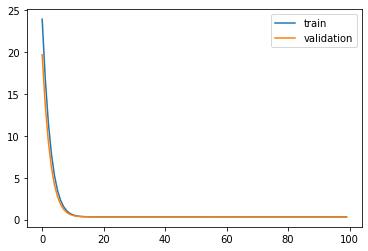

Time to train LSTM:  83.258141040802


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa3b8761978>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 23.8787 - acc: 0.7043 - val_loss: 19.6509 - val_acc: 0.8014

Epoch 00001: val_loss improved from inf to 19.65093, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 16.8423 - acc: 0.8284 - val_loss: 13.6758 - val_acc: 0.8518

Epoch 00002: val_loss improved from 19.65093 to 13.67578, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 11.6156 - acc: 0.8676 - val_loss: 9.3256 - val_acc: 0.8732

Epoch 00003: val_loss improved from 13.67578 to 9.32563, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 7.8623 - acc: 0.8741 - val_loss: 6.2555 - val_acc: 0.8724

Epoch 00004: val_loss improved from 9.32563 to 6.25552, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 5.2450 - acc: 0.8759 - val_loss: 4.1475 - val_acc: 0.8752

Epoch 00005: val_loss improved from 6.25552 to 4.14753, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 3.4666 - acc: 0


Epoch 00051: val_loss did not improve from 0.32414
Epoch 52/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8752

Epoch 00052: val_loss did not improve from 0.32414
Epoch 53/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8752

Epoch 00053: val_loss did not improve from 0.32414
Epoch 54/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8756

Epoch 00054: val_loss did not improve from 0.32414
Epoch 55/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3248 - val_acc: 0.8753

Epoch 00055: val_loss did not improve from 0.32414
Epoch 56/100
 - 1s - loss: 0.3175 - acc: 0.8791 - val_loss: 0.3240 - val_acc: 0.8758

Epoch 00056: val_loss improved from 0.32414 to 0.32398, saving model to Event_val_weights2.hdf5
Epoch 57/100
 - 1s - loss: 0.3175 - acc: 0.8791 - val_loss: 0.3249 - val_acc: 0.8753

Epoch 00057: val_loss did not improve from 0.32398
Epoch 58/100
 - 1s - loss: 0.3174 - acc: 0.8791 - val_loss: 0.3245 - val_acc: 0.8

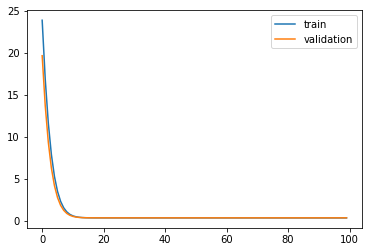

Time to train LSTM:  85.86347103118896
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 23.8217 - acc: 0.7249 - val_loss: 19.6118 - val_acc: 0.7918

Epoch 00001: val_loss improved from inf to 19.61181, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 16.7981 - acc: 0.8308 - val_loss: 13.6403 - val_acc: 0.8614

Epoch 00002: val_loss improved from 19.61181 to 13.64030, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 11.5812 - acc: 0.8697 - val_loss: 9.2980 - val_acc: 0.8686

Epoch 00003: val_loss improved from 13.64030 to 9.29804, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 7.8370 - acc: 0.8739 - val_loss: 6.2354 - val_acc: 0.8723

Epoch 00004: val_loss improved from 9.29804 to 6.23538, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 5.2261 - acc: 0.8762 - val_loss: 4.1346 - val_acc: 0.8741

Epoch 00005: val_loss improved from 6.23538 to 4.13461, saving model to Event_val_weights3.hdf5
Ep

 - 1s - loss: 0.3180 - acc: 0.8791 - val_loss: 0.3237 - val_acc: 0.8774

Epoch 00047: val_loss did not improve from 0.32331
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3232 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32331 to 0.32323, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3235 - val_acc: 0.8776

Epoch 00049: val_loss did not improve from 0.32323
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8790 - val_loss: 0.3233 - val_acc: 0.8776

Epoch 00050: val_loss did not improve from 0.32323
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8789 - val_loss: 0.3235 - val_acc: 0.8778

Epoch 00051: val_loss did not improve from 0.32323
Epoch 52/100
 - 1s - loss: 0.3180 - acc: 0.8790 - val_loss: 0.3233 - val_acc: 0.8774

Epoch 00052: val_loss did not improve from 0.32323
Epoch 53/100
 - 1s - loss: 0.3179 - acc: 0.8790 - val_loss: 0.3235 - val_acc: 0.8777

Epoch 00053: val_loss did not improve from 0.32323
Epoch 54/

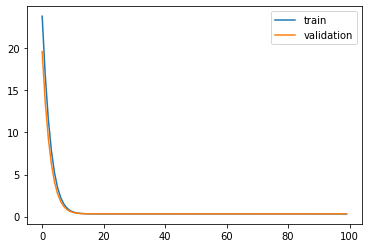

Time to train LSTM:  84.23496341705322
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 23.8326 - acc: 0.7248 - val_loss: 19.6061 - val_acc: 0.8097

Epoch 00001: val_loss improved from inf to 19.60609, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 16.7969 - acc: 0.8347 - val_loss: 13.6361 - val_acc: 0.8616

Epoch 00002: val_loss improved from 19.60609 to 13.63611, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 11.5779 - acc: 0.8696 - val_loss: 9.2974 - val_acc: 0.8683

Epoch 00003: val_loss improved from 13.63611 to 9.29744, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 7.8344 - acc: 0.8748 - val_loss: 6.2362 - val_acc: 0.8704

Epoch 00004: val_loss improved from 9.29744 to 6.23620, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 5.2255 - acc: 0.8773 - val_loss: 4.1381 - val_acc: 0.8728

Epoch 00005: val_loss improved from 6.23620 to 4.13814, saving model to Event_val_weights4.hdf5
Ep

 - 1s - loss: 0.3176 - acc: 0.8794 - val_loss: 0.3291 - val_acc: 0.8714

Epoch 00052: val_loss did not improve from 0.32889
Epoch 53/100
 - 1s - loss: 0.3174 - acc: 0.8797 - val_loss: 0.3288 - val_acc: 0.8717

Epoch 00053: val_loss improved from 0.32889 to 0.32885, saving model to Event_val_weights4.hdf5
Epoch 54/100
 - 1s - loss: 0.3175 - acc: 0.8796 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00054: val_loss did not improve from 0.32885
Epoch 55/100
 - 1s - loss: 0.3174 - acc: 0.8796 - val_loss: 0.3289 - val_acc: 0.8718

Epoch 00055: val_loss did not improve from 0.32885
Epoch 56/100
 - 1s - loss: 0.3175 - acc: 0.8796 - val_loss: 0.3288 - val_acc: 0.8713

Epoch 00056: val_loss improved from 0.32885 to 0.32878, saving model to Event_val_weights4.hdf5
Epoch 57/100
 - 1s - loss: 0.3174 - acc: 0.8797 - val_loss: 0.3289 - val_acc: 0.8713

Epoch 00057: val_loss did not improve from 0.32878
Epoch 58/100
 - 1s - loss: 0.3173 - acc: 0.8797 - val_loss: 0.3289 - val_acc: 0.8714

Epoch 00058: va

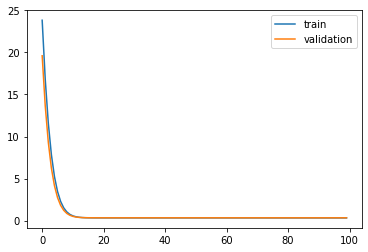

Time to train LSTM:  84.76434254646301
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 23.8384 - acc: 0.7057 - val_loss: 19.6048 - val_acc: 0.7948

Epoch 00001: val_loss improved from inf to 19.60481, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 16.7925 - acc: 0.8266 - val_loss: 13.6119 - val_acc: 0.8591

Epoch 00002: val_loss improved from 19.60481 to 13.61193, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 11.5635 - acc: 0.8693 - val_loss: 9.2729 - val_acc: 0.8726

Epoch 00003: val_loss improved from 13.61193 to 9.27286, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 7.8189 - acc: 0.8741 - val_loss: 6.2135 - val_acc: 0.8747

Epoch 00004: val_loss improved from 9.27286 to 6.21345, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 5.2107 - acc: 0.8761 - val_loss: 4.1145 - val_acc: 0.8762

Epoch 00005: val_loss improved from 6.21345 to 4.11445, saving model to Event_val_weights5.hdf5
Ep

 - 1s - loss: 0.3191 - acc: 0.8787 - val_loss: 0.3199 - val_acc: 0.8800

Epoch 00050: val_loss did not improve from 0.31992
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8801

Epoch 00051: val_loss did not improve from 0.31992
Epoch 52/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8806

Epoch 00052: val_loss improved from 0.31992 to 0.31949, saving model to Event_val_weights5.hdf5
Epoch 53/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8804

Epoch 00053: val_loss did not improve from 0.31949
Epoch 54/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8806

Epoch 00054: val_loss did not improve from 0.31949
Epoch 55/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3199 - val_acc: 0.8803

Epoch 00055: val_loss did not improve from 0.31949
Epoch 56/100
 - 1s - loss: 0.3188 - acc: 0.8787 - val_loss: 0.3195 - val_acc: 0.8806

Epoch 00056: val_loss improved from 0.31949 to 0.31947, savi

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fa38dc9c278>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


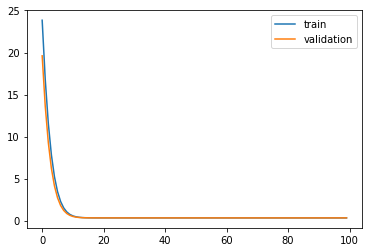

Time to train LSTM:  84.65137219429016
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 25.8779 - acc: 0.6847 - val_loss: 23.3530 - val_acc: 0.7659

Epoch 00001: val_loss improved from inf to 23.35297, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 21.8556 - acc: 0.7786 - val_loss: 19.6466 - val_acc: 0.8120

Epoch 00002: val_loss improved from 23.35297 to 19.64657, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 18.3446 - acc: 0.8179 - val_loss: 16.4253 - val_acc: 0.8477

Epoch 00003: val_loss improved from 19.64657 to 16.42532, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 15.3052 - acc: 0.8518 - val_loss: 13.6614 - val_acc: 0.8663

Epoch 00004: val_loss improved from 16.42532 to 13.66145, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 12.7066 - acc: 0.8684 - val_loss: 11.3093 - val_acc: 0.8739

Epoch 00005: val_loss improved from 13.66145 to 11.30928, saving model to Event_val_weight

 - 1s - loss: 0.3185 - acc: 0.8788 - val_loss: 0.3131 - val_acc: 0.8806

Epoch 00046: val_loss improved from 0.31315 to 0.31308, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8788 - val_loss: 0.3131 - val_acc: 0.8806

Epoch 00047: val_loss did not improve from 0.31308
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8787 - val_loss: 0.3132 - val_acc: 0.8804

Epoch 00048: val_loss did not improve from 0.31308
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8787 - val_loss: 0.3134 - val_acc: 0.8802

Epoch 00049: val_loss did not improve from 0.31308
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8787 - val_loss: 0.3134 - val_acc: 0.8804

Epoch 00050: val_loss did not improve from 0.31308
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3134 - val_acc: 0.8806

Epoch 00051: val_loss did not improve from 0.31308
Epoch 52/100
 - 1s - loss: 0.3190 - acc: 0.8787 - val_loss: 0.3132 - val_acc: 0.8803

Epoch 00052: val_loss did not improve from 0.31308
Epoch 53/

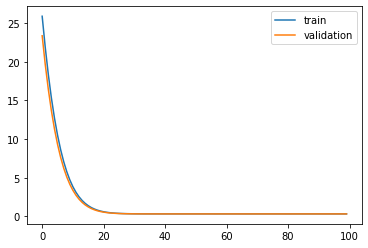

Time to train LSTM:  79.01839828491211
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 25.8612 - acc: 0.6776 - val_loss: 23.3476 - val_acc: 0.7487

Epoch 00001: val_loss improved from inf to 23.34763, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 21.8402 - acc: 0.7675 - val_loss: 19.6462 - val_acc: 0.7901

Epoch 00002: val_loss improved from 23.34763 to 19.64616, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 18.3302 - acc: 0.8109 - val_loss: 16.4248 - val_acc: 0.8334

Epoch 00003: val_loss improved from 19.64616 to 16.42479, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 15.2898 - acc: 0.8515 - val_loss: 13.6574 - val_acc: 0.8648

Epoch 00004: val_loss improved from 16.42479 to 13.65736, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 12.6898 - acc: 0.8702 - val_loss: 11.3035 - val_acc: 0.8726

Epoch 00005: val_loss improved from 13.65736 to 11.30352, saving model to Event_val_weight


Epoch 00046: val_loss did not improve from 0.32385
Epoch 47/100
 - 1s - loss: 0.3179 - acc: 0.8794 - val_loss: 0.3241 - val_acc: 0.8759

Epoch 00047: val_loss did not improve from 0.32385
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8794 - val_loss: 0.3241 - val_acc: 0.8760

Epoch 00048: val_loss did not improve from 0.32385
Epoch 49/100
 - 1s - loss: 0.3178 - acc: 0.8794 - val_loss: 0.3239 - val_acc: 0.8757

Epoch 00049: val_loss did not improve from 0.32385
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8757

Epoch 00050: val_loss improved from 0.32385 to 0.32375, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3175 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8758

Epoch 00051: val_loss did not improve from 0.32375
Epoch 52/100
 - 1s - loss: 0.3174 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8757

Epoch 00052: val_loss did not improve from 0.32375
Epoch 53/100
 - 1s - loss: 0.3173 - acc: 0.8796 - val_loss: 0.3239 - val_acc: 0.8

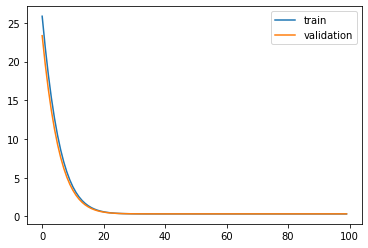

Time to train LSTM:  80.20241045951843
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 25.8374 - acc: 0.6409 - val_loss: 23.3074 - val_acc: 0.7673

Epoch 00001: val_loss improved from inf to 23.30742, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 21.8064 - acc: 0.7850 - val_loss: 19.6205 - val_acc: 0.7996

Epoch 00002: val_loss improved from 23.30742 to 19.62052, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 18.3114 - acc: 0.8150 - val_loss: 16.4145 - val_acc: 0.8290

Epoch 00003: val_loss improved from 19.62052 to 16.41452, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 15.2799 - acc: 0.8464 - val_loss: 13.6497 - val_acc: 0.8594

Epoch 00004: val_loss improved from 16.41452 to 13.64969, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 12.6820 - acc: 0.8679 - val_loss: 11.2994 - val_acc: 0.8702

Epoch 00005: val_loss improved from 13.64969 to 11.29936, saving model to Event_val_weight

 - 1s - loss: 0.3179 - acc: 0.8792 - val_loss: 0.3254 - val_acc: 0.8776

Epoch 00046: val_loss did not improve from 0.32506
Epoch 47/100
 - 1s - loss: 0.3179 - acc: 0.8792 - val_loss: 0.3255 - val_acc: 0.8774

Epoch 00047: val_loss did not improve from 0.32506
Epoch 48/100
 - 1s - loss: 0.3180 - acc: 0.8791 - val_loss: 0.3259 - val_acc: 0.8773

Epoch 00048: val_loss did not improve from 0.32506
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8792 - val_loss: 0.3260 - val_acc: 0.8773

Epoch 00049: val_loss did not improve from 0.32506
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3261 - val_acc: 0.8774

Epoch 00050: val_loss did not improve from 0.32506
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8792 - val_loss: 0.3258 - val_acc: 0.8777

Epoch 00051: val_loss did not improve from 0.32506
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3255 - val_acc: 0.8777

Epoch 00052: val_loss did not improve from 0.32506
Epoch 53/100
 - 1s - loss: 0.3179 - acc: 0.8792 - val_

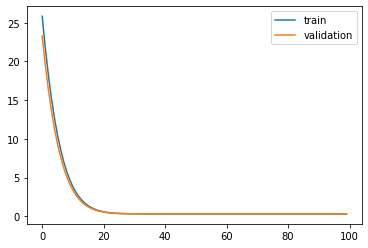

Time to train LSTM:  82.64326667785645
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 25.7679 - acc: 0.5919 - val_loss: 23.2426 - val_acc: 0.7444

Epoch 00001: val_loss improved from inf to 23.24264, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 21.7417 - acc: 0.7671 - val_loss: 19.5613 - val_acc: 0.7882

Epoch 00002: val_loss improved from 23.24264 to 19.56128, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 18.2513 - acc: 0.8091 - val_loss: 16.3602 - val_acc: 0.8277

Epoch 00003: val_loss improved from 19.56128 to 16.36024, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 15.2252 - acc: 0.8477 - val_loss: 13.6046 - val_acc: 0.8594

Epoch 00004: val_loss improved from 16.36024 to 13.60463, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 12.6350 - acc: 0.8678 - val_loss: 11.2613 - val_acc: 0.8673

Epoch 00005: val_loss improved from 13.60463 to 11.26125, saving model to Event_val_weight


Epoch 00046: val_loss improved from 0.32938 to 0.32913, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3172 - acc: 0.8800 - val_loss: 0.3291 - val_acc: 0.8717

Epoch 00047: val_loss improved from 0.32913 to 0.32906, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8801 - val_loss: 0.3291 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32906 to 0.32905, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3290 - val_acc: 0.8717

Epoch 00049: val_loss improved from 0.32905 to 0.32904, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3292 - val_acc: 0.8719

Epoch 00050: val_loss did not improve from 0.32904
Epoch 51/100
 - 1s - loss: 0.3171 - acc: 0.8801 - val_loss: 0.3292 - val_acc: 0.8720

Epoch 00051: val_loss did not improve from 0.32904
Epoch 52/100
 - 1s - loss: 0.3172 - acc: 0.8801 - val_loss: 0.3295 - val_acc: 0.872

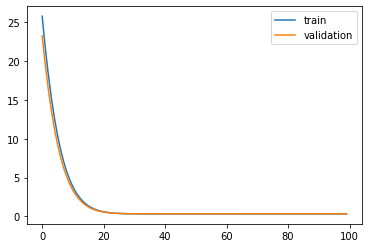

Time to train LSTM:  81.56057381629944
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 25.8159 - acc: 0.6025 - val_loss: 23.2839 - val_acc: 0.7478

Epoch 00001: val_loss improved from inf to 23.28395, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 21.7806 - acc: 0.7715 - val_loss: 19.5823 - val_acc: 0.8007

Epoch 00002: val_loss improved from 23.28395 to 19.58230, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 18.2788 - acc: 0.8113 - val_loss: 16.3694 - val_acc: 0.8314

Epoch 00003: val_loss improved from 19.58230 to 16.36945, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 15.2477 - acc: 0.8465 - val_loss: 13.6077 - val_acc: 0.8626

Epoch 00004: val_loss improved from 16.36945 to 13.60772, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 12.6535 - acc: 0.8679 - val_loss: 11.2630 - val_acc: 0.8701

Epoch 00005: val_loss improved from 13.60772 to 11.26296, saving model to Event_val_weight

 - 1s - loss: 0.3187 - acc: 0.8786 - val_loss: 0.3189 - val_acc: 0.8787

Epoch 00046: val_loss improved from 0.31895 to 0.31889, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3187 - acc: 0.8788 - val_loss: 0.3190 - val_acc: 0.8790

Epoch 00047: val_loss did not improve from 0.31889
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3189 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.31889 to 0.31886, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8789 - val_loss: 0.3188 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.31886 to 0.31883, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8789 - val_loss: 0.3188 - val_acc: 0.8790

Epoch 00050: val_loss did not improve from 0.31883
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8789 - val_loss: 0.3188 - val_acc: 0.8791

Epoch 00051: val_loss improved from 0.31883 to 0.31878, saving model to Event_val_weights5.hdf5
Epoch 52/10

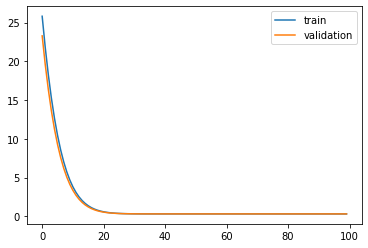

Time to train LSTM:  85.73085379600525
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 26.7332 - acc: 0.6222 - val_loss: 24.8203 - val_acc: 0.7426

Epoch 00001: val_loss improved from inf to 24.82026, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 24.1828 - acc: 0.7467 - val_loss: 22.4193 - val_acc: 0.7800

Epoch 00002: val_loss improved from 24.82026 to 22.41929, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 21.8353 - acc: 0.7754 - val_loss: 20.2070 - val_acc: 0.7976

Epoch 00003: val_loss improved from 22.41929 to 20.20704, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 19.6724 - acc: 0.7940 - val_loss: 18.1714 - val_acc: 0.8142

Epoch 00004: val_loss improved from 20.20704 to 18.17136, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 17.6828 - acc: 0.8124 - val_loss: 16.3035 - val_acc: 0.8386

Epoch 00005: val_loss improved from 18.17136 to 16.30346, saving model to Event_val_weight


Epoch 00045: val_loss improved from 0.35523 to 0.34766, saving model to Event_val_weights1.hdf5
Epoch 46/100
 - 1s - loss: 0.3513 - acc: 0.8782 - val_loss: 0.3414 - val_acc: 0.8810

Epoch 00046: val_loss improved from 0.34766 to 0.34139, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3453 - acc: 0.8781 - val_loss: 0.3362 - val_acc: 0.8810

Epoch 00047: val_loss improved from 0.34139 to 0.33619, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3404 - acc: 0.8782 - val_loss: 0.3319 - val_acc: 0.8806

Epoch 00048: val_loss improved from 0.33619 to 0.33190, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3363 - acc: 0.8782 - val_loss: 0.3284 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.33190 to 0.32837, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3330 - acc: 0.8782 - val_loss: 0.3255 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.32837 to 0.32548, saving model to Event_val_weights


Epoch 00092: val_loss did not improve from 0.31287
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8788 - val_loss: 0.3130 - val_acc: 0.8804

Epoch 00093: val_loss did not improve from 0.31287
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8789 - val_loss: 0.3128 - val_acc: 0.8807

Epoch 00094: val_loss improved from 0.31287 to 0.31280, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8789 - val_loss: 0.3132 - val_acc: 0.8807

Epoch 00095: val_loss did not improve from 0.31280
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8788 - val_loss: 0.3129 - val_acc: 0.8807

Epoch 00096: val_loss did not improve from 0.31280
Epoch 97/100
 - 1s - loss: 0.3174 - acc: 0.8789 - val_loss: 0.3129 - val_acc: 0.8807

Epoch 00097: val_loss did not improve from 0.31280
Epoch 98/100
 - 1s - loss: 0.3174 - acc: 0.8789 - val_loss: 0.3132 - val_acc: 0.8807

Epoch 00098: val_loss did not improve from 0.31280
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8789 - val_loss: 0.3130 - val_acc: 0.8

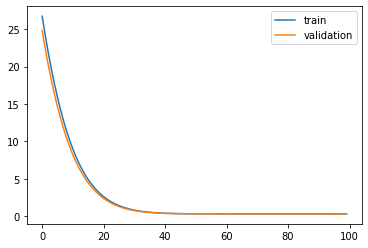

Time to train LSTM:  79.65363693237305
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 26.8234 - acc: 0.5952 - val_loss: 24.9044 - val_acc: 0.7346

Epoch 00001: val_loss improved from inf to 24.90440, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 24.2593 - acc: 0.7464 - val_loss: 22.5050 - val_acc: 0.7698

Epoch 00002: val_loss improved from 24.90440 to 22.50499, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 21.9092 - acc: 0.7778 - val_loss: 20.2949 - val_acc: 0.7904

Epoch 00003: val_loss improved from 22.50499 to 20.29490, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 19.7440 - acc: 0.8011 - val_loss: 18.2584 - val_acc: 0.8091

Epoch 00004: val_loss improved from 20.29490 to 18.25837, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 17.7507 - acc: 0.8249 - val_loss: 16.3880 - val_acc: 0.8361

Epoch 00005: val_loss improved from 18.25837 to 16.38796, saving model to Event_val_weight


Epoch 00045: val_loss improved from 0.36652 to 0.35888, saving model to Event_val_weights2.hdf5
Epoch 46/100
 - 1s - loss: 0.3505 - acc: 0.8792 - val_loss: 0.3525 - val_acc: 0.8753

Epoch 00046: val_loss improved from 0.35888 to 0.35253, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3444 - acc: 0.8793 - val_loss: 0.3473 - val_acc: 0.8756

Epoch 00047: val_loss improved from 0.35253 to 0.34729, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3394 - acc: 0.8793 - val_loss: 0.3430 - val_acc: 0.8756

Epoch 00048: val_loss improved from 0.34729 to 0.34295, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3352 - acc: 0.8794 - val_loss: 0.3394 - val_acc: 0.8757

Epoch 00049: val_loss improved from 0.34295 to 0.33941, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3318 - acc: 0.8794 - val_loss: 0.3365 - val_acc: 0.8760

Epoch 00050: val_loss improved from 0.33941 to 0.33649, saving model to Event_val_weights


Epoch 00097: val_loss did not improve from 0.32437
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3251 - val_acc: 0.8754

Epoch 00098: val_loss did not improve from 0.32437
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3251 - val_acc: 0.8754

Epoch 00099: val_loss did not improve from 0.32437
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3250 - val_acc: 0.8754

Epoch 00100: val_loss did not improve from 0.32437
#################################
Number of units: 128
Batch size: 32768
Fold: 1
best val loss: 0.32436877489089966
#################################


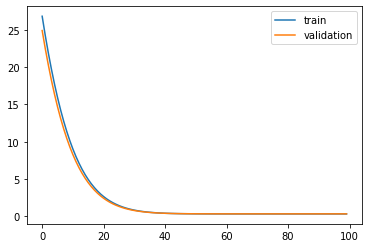

Time to train LSTM:  80.8501329421997
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 26.9743 - acc: 0.5594 - val_loss: 25.0509 - val_acc: 0.7223

Epoch 00001: val_loss improved from inf to 25.05091, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 24.3988 - acc: 0.7497 - val_loss: 22.6331 - val_acc: 0.7712

Epoch 00002: val_loss improved from 25.05091 to 22.63314, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 22.0309 - acc: 0.7857 - val_loss: 20.4068 - val_acc: 0.7922

Epoch 00003: val_loss improved from 22.63314 to 20.40683, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 19.8502 - acc: 0.8047 - val_loss: 18.3586 - val_acc: 0.8092

Epoch 00004: val_loss improved from 20.40683 to 18.35861, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 17.8450 - acc: 0.8226 - val_loss: 16.4794 - val_acc: 0.8259

Epoch 00005: val_loss improved from 18.35861 to 16.47944, saving model to Event_val_weights


Epoch 00045: val_loss improved from 0.36687 to 0.35922, saving model to Event_val_weights3.hdf5
Epoch 46/100
 - 1s - loss: 0.3505 - acc: 0.8790 - val_loss: 0.3529 - val_acc: 0.8780

Epoch 00046: val_loss improved from 0.35922 to 0.35289, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3445 - acc: 0.8790 - val_loss: 0.3477 - val_acc: 0.8779

Epoch 00047: val_loss improved from 0.35289 to 0.34768, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3395 - acc: 0.8789 - val_loss: 0.3434 - val_acc: 0.8779

Epoch 00048: val_loss improved from 0.34768 to 0.34337, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3354 - acc: 0.8789 - val_loss: 0.3398 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.34337 to 0.33984, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3320 - acc: 0.8789 - val_loss: 0.3369 - val_acc: 0.8780

Epoch 00050: val_loss improved from 0.33984 to 0.33693, saving model to Event_val_weights

 - 1s - loss: 0.3167 - acc: 0.8793 - val_loss: 0.3243 - val_acc: 0.8777

Epoch 00095: val_loss did not improve from 0.32425
Epoch 96/100
 - 1s - loss: 0.3167 - acc: 0.8792 - val_loss: 0.3242 - val_acc: 0.8777

Epoch 00096: val_loss improved from 0.32425 to 0.32424, saving model to Event_val_weights3.hdf5
Epoch 97/100
 - 1s - loss: 0.3167 - acc: 0.8794 - val_loss: 0.3243 - val_acc: 0.8774

Epoch 00097: val_loss did not improve from 0.32424
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3243 - val_acc: 0.8777

Epoch 00098: val_loss did not improve from 0.32424
Epoch 99/100
 - 1s - loss: 0.3167 - acc: 0.8793 - val_loss: 0.3242 - val_acc: 0.8776

Epoch 00099: val_loss improved from 0.32424 to 0.32419, saving model to Event_val_weights3.hdf5
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8793 - val_loss: 0.3244 - val_acc: 0.8778

Epoch 00100: val_loss did not improve from 0.32419
#################################
Number of units: 128
Batch size: 32768
Fold: 2
best val loss: 0.32

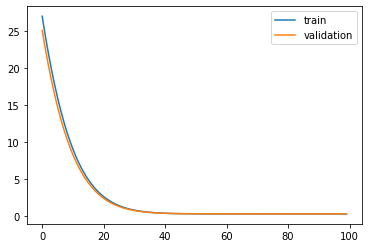

Time to train LSTM:  81.3484902381897
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 26.9039 - acc: 0.5659 - val_loss: 24.9819 - val_acc: 0.7038

Epoch 00001: val_loss improved from inf to 24.98186, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 24.3359 - acc: 0.7236 - val_loss: 22.5705 - val_acc: 0.7661

Epoch 00002: val_loss improved from 24.98186 to 22.57054, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 21.9748 - acc: 0.7745 - val_loss: 20.3506 - val_acc: 0.7892

Epoch 00003: val_loss improved from 22.57054 to 20.35059, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 19.8009 - acc: 0.7983 - val_loss: 18.3091 - val_acc: 0.8082

Epoch 00004: val_loss improved from 20.35059 to 18.30913, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 17.8026 - acc: 0.8188 - val_loss: 16.4374 - val_acc: 0.8304

Epoch 00005: val_loss improved from 18.30913 to 16.43745, saving model to Event_val_weights


Epoch 00045: val_loss improved from 0.37032 to 0.36262, saving model to Event_val_weights4.hdf5
Epoch 46/100
 - 1s - loss: 0.3502 - acc: 0.8794 - val_loss: 0.3562 - val_acc: 0.8719

Epoch 00046: val_loss improved from 0.36262 to 0.35622, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3441 - acc: 0.8795 - val_loss: 0.3509 - val_acc: 0.8721

Epoch 00047: val_loss improved from 0.35622 to 0.35093, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3391 - acc: 0.8795 - val_loss: 0.3466 - val_acc: 0.8721

Epoch 00048: val_loss improved from 0.35093 to 0.34658, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3349 - acc: 0.8795 - val_loss: 0.3430 - val_acc: 0.8721

Epoch 00049: val_loss improved from 0.34658 to 0.34298, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3315 - acc: 0.8795 - val_loss: 0.3400 - val_acc: 0.8720

Epoch 00050: val_loss improved from 0.34298 to 0.34003, saving model to Event_val_weights


Epoch 00096: val_loss did not improve from 0.32778
Epoch 97/100
 - 1s - loss: 0.3156 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8717

Epoch 00097: val_loss did not improve from 0.32778
Epoch 98/100
 - 1s - loss: 0.3156 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8717

Epoch 00098: val_loss did not improve from 0.32778
Epoch 99/100
 - 1s - loss: 0.3156 - acc: 0.8802 - val_loss: 0.3281 - val_acc: 0.8717

Epoch 00099: val_loss did not improve from 0.32778
Epoch 100/100
 - 1s - loss: 0.3156 - acc: 0.8802 - val_loss: 0.3281 - val_acc: 0.8718

Epoch 00100: val_loss did not improve from 0.32778
#################################
Number of units: 128
Batch size: 32768
Fold: 3
best val loss: 0.3277837336063385
#################################


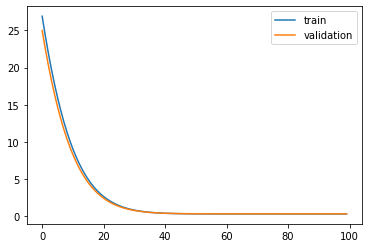

Time to train LSTM:  81.37156701087952
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 26.9371 - acc: 0.5900 - val_loss: 25.0154 - val_acc: 0.7280

Epoch 00001: val_loss improved from inf to 25.01545, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 24.3700 - acc: 0.7436 - val_loss: 22.6017 - val_acc: 0.7824

Epoch 00002: val_loss improved from 25.01545 to 22.60166, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 22.0085 - acc: 0.7853 - val_loss: 20.3779 - val_acc: 0.7994

Epoch 00003: val_loss improved from 22.60166 to 20.37785, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 19.8331 - acc: 0.8019 - val_loss: 18.3320 - val_acc: 0.8153

Epoch 00004: val_loss improved from 20.37785 to 18.33204, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 17.8332 - acc: 0.8184 - val_loss: 16.4556 - val_acc: 0.8340

Epoch 00005: val_loss improved from 18.33204 to 16.45563, saving model to Event_val_weight


Epoch 00045: val_loss improved from 0.36150 to 0.35385, saving model to Event_val_weights5.hdf5
Epoch 46/100
 - 1s - loss: 0.3510 - acc: 0.8782 - val_loss: 0.3475 - val_acc: 0.8781

Epoch 00046: val_loss improved from 0.35385 to 0.34749, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3449 - acc: 0.8782 - val_loss: 0.3422 - val_acc: 0.8782

Epoch 00047: val_loss improved from 0.34749 to 0.34225, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3400 - acc: 0.8782 - val_loss: 0.3379 - val_acc: 0.8782

Epoch 00048: val_loss improved from 0.34225 to 0.33792, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3359 - acc: 0.8782 - val_loss: 0.3343 - val_acc: 0.8782

Epoch 00049: val_loss improved from 0.33792 to 0.33434, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3325 - acc: 0.8782 - val_loss: 0.3314 - val_acc: 0.8782

Epoch 00050: val_loss improved from 0.33434 to 0.33142, saving model to Event_val_weights

 - 1s - loss: 0.3173 - acc: 0.8792 - val_loss: 0.3186 - val_acc: 0.8788

Epoch 00092: val_loss improved from 0.31863 to 0.31861, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3186 - val_acc: 0.8788

Epoch 00093: val_loss did not improve from 0.31861
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3186 - val_acc: 0.8787

Epoch 00094: val_loss improved from 0.31861 to 0.31859, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3186 - val_acc: 0.8786

Epoch 00095: val_loss did not improve from 0.31859
Epoch 96/100
 - 1s - loss: 0.3172 - acc: 0.8792 - val_loss: 0.3186 - val_acc: 0.8786

Epoch 00096: val_loss did not improve from 0.31859
Epoch 97/100
 - 1s - loss: 0.3172 - acc: 0.8792 - val_loss: 0.3186 - val_acc: 0.8784

Epoch 00097: val_loss improved from 0.31859 to 0.31857, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_lo

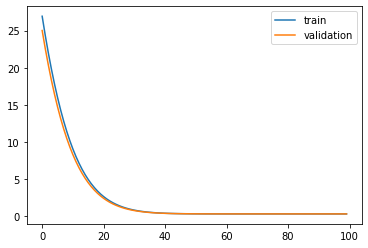

Time to train LSTM:  82.65526819229126
Entire process took:  1955.2739009857178
Experiment record:
[[128, 2048, 0, 0.3153927341832055], [128, 2048, 1, 0.3252500432332357], [128, 2048, 2, 0.32528515881962244], [128, 2048, 3, 0.33043303701612686], [128, 2048, 4, 0.32057472862137687], [128, 4096, 0, 0.3129131500456068], [128, 4096, 1, 0.3260177851517995], [128, 4096, 2, 0.3237231135103438], [128, 4096, 3, 0.32965972831514145], [128, 4096, 4, 0.31947871112823484], [128, 8192, 0, 0.31267580082681445], [128, 8192, 1, 0.32397895463307697], [128, 8192, 2, 0.3227811802228292], [128, 8192, 3, 0.32773703077104355], [128, 8192, 4, 0.3190264475610521], [128, 16384, 0, 0.3129405975341797], [128, 16384, 1, 0.3237537443637848], [128, 16384, 2, 0.3243679702281952], [128, 16384, 3, 0.3290359079837799], [128, 16384, 4, 0.3184848129749298], [128, 32768, 0, 0.31280210614204407], [128, 32768, 1, 0.32436877489089966], [128, 32768, 2, 0.32418569922447205], [128, 32768, 3, 0.3277837336063385], [128, 32768, 4, 

In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [128] #[2, 4, 8, 16, 32]#[2,4,8]#[1,2,4,8,16]
batch_size_list = [2048, 4096, 8192, 16384, 32768]# [32768, 65536] #

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) 
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_lstm = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = Sequential()
                model.add(CuDNNLSTM(units,
                                    kernel_regularizer=regularizers.l2(0.1),
                                    #return_sequences=True, 
                                    input_shape=(8, 182))) #20 , 27
                #model.add(CuDNNLSTM(units, 
                #                    kernel_regularizer=regularizers.l2(0.01)))
                model.add(Dense(2, activation='softmax'))
                model.compile(loss='categorical_crossentropy', 
                              optimizer='adam', metrics=['accuracy'])
                val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                    epochs=100, validation_split=0.1, 
                                    callbacks=[val_checkpointer], 
                                    verbose=2, 
                                    shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
            end_time = time.time()
            print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [12]:
exp_record = [[128, 2048, 0, 0.3153927341832055], [128, 2048, 1, 0.3252500432332357], [128, 2048, 2, 0.32528515881962244], [128, 2048, 3, 0.33043303701612686], [128, 2048, 4, 0.32057472862137687], [128, 4096, 0, 0.3129131500456068], [128, 4096, 1, 0.3260177851517995], [128, 4096, 2, 0.3237231135103438], [128, 4096, 3, 0.32965972831514145], [128, 4096, 4, 0.31947871112823484], [128, 8192, 0, 0.31267580082681445], [128, 8192, 1, 0.32397895463307697], [128, 8192, 2, 0.3227811802228292], [128, 8192, 3, 0.32773703077104355], [128, 8192, 4, 0.3190264475610521], [128, 16384, 0, 0.3129405975341797], [128, 16384, 1, 0.3237537443637848], [128, 16384, 2, 0.3243679702281952], [128, 16384, 3, 0.3290359079837799], [128, 16384, 4, 0.3184848129749298], [128, 32768, 0, 0.31280210614204407], [128, 32768, 1, 0.32436877489089966], [128, 32768, 2, 0.32418569922447205], [128, 32768, 3, 0.3277837336063385], [128, 32768, 4, 0.3185688555240631]]
#[[32, 1024, 0, 0.31703045264879864], [32, 1024, 1, 0.32887655459509957], [32, 1024, 2, 0.3268885887198978], [32, 1024, 3, 0.32941400610076055], [32, 1024, 4, 0.32196027199427285], [32, 2048, 0, 0.3147855309645335], [32, 2048, 1, 0.3253221249050564], [32, 2048, 2, 0.32485115361213684], [32, 2048, 3, 0.3291952412393358], [32, 2048, 4, 0.32055419376161365], [32, 4096, 0, 0.31304567170143127], [32, 4096, 1, 0.3248234632809957], [32, 4096, 2, 0.32434357025888233], [32, 4096, 3, 0.32964638635847304], [32, 4096, 4, 0.32035627630021835], [32, 16384, 0, 0.31264957785606384], [32, 16384, 1, 0.32289981842041016], [32, 16384, 2, 0.32368990778923035], [32, 16384, 3, 0.3280470371246338], [32, 16384, 4, 0.31816545128822327]]
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(5):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(25, 4)
###############################
Units: 128.0
Batch size: 2048.0
Val loss (mean): 0.32339
Val loss (std): 0.00507
###############################
###############################
Units: 128.0
Batch size: 4096.0
Val loss (mean): 0.32236
Val loss (std): 0.00576
###############################
###############################
Units: 128.0
Batch size: 8192.0
Val loss (mean): 0.32124
Val loss (std): 0.00511
###############################
###############################
Units: 128.0
Batch size: 16384.0
Val loss (mean): 0.32172
Val loss (std): 0.00552
###############################
###############################
Units: 128.0
Batch size: 32768.0
Val loss (mean): 0.32154
Val loss (std): 0.00528
###############################
0.32123988280296323


In [10]:
units = 32
model = Sequential()
model.add(CuDNNLSTM(units,
                    kernel_regularizer=regularizers.l2(0.01), 
                    return_sequences=True,
                    input_shape=(8, 182)))
model.add(CuDNNLSTM(units, 
                    kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 8, 32)             27648     
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 36,162
Trainable params: 36,162
Non-trainable params: 0
_________________________________________________________________


In [12]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(6) #18 for LSTM 23 for extend 0.003, 0.005
         # 28 for SimpleRNN
         # 1 for LSTM 2 layers
         # 4 for LSTM 1 layer 0.1 regularisation [0.05, 0.15]
         # 6 for Simple RNN 1 layer 0.1 regularisation [0.05, 0.15]
# L2 for layer 1 between 0.005 and 0.015 [, )
L2_1_list = []
for i in range(25):
    L2_1_list.append(np.random.uniform(0.05, 0.15))
# L2 for layer 2 between 1e-4 and 1e-8  [, )
L2_2_list = []
for i in range(25):
    r = -4*np.random.rand()
    s = 0.0001*(10**r)
    L2_2_list.append(s)
print("Min L2 layer 1:\t", min(L2_1_list))
print("Max L2 layer 1:\t", max(L2_1_list))
print("Min L2 layer 2:\t", min(L2_2_list))
print("Max L2 layer 2:\t", max(L2_2_list))
print("Layer 1 L2:\t", L2_1_list)
print("Layer 2 L2:\t", L2_2_list)

Min L2 layer 1:	 0.05416966257252499
Max L2 layer 1:	 0.14902242713734165
Min L2 layer 2:	 1.0548003040594255e-08
Max L2 layer 2:	 4.679137276988068e-05
Layer 1 L2:	 [0.13928601514360017, 0.08319798053011772, 0.13212291230578316, 0.05416966257252499, 0.0607656679935968, 0.10950520642062403, 0.10298173621928217, 0.09188074285566543, 0.08354078492733293, 0.11225194321960902, 0.09381414261088741, 0.12358821063486902, 0.10180364119992688, 0.10788586002261571, 0.11453550958955938, 0.14902242713734165, 0.13198581969218415, 0.09132009348161808, 0.13762676552066272, 0.13237594325705213, 0.055447450782235466, 0.12186372365641943, 0.13021705624244753, 0.12364066438114389, 0.12091317507811673]
Layer 2 L2:	 [6.858870178141104e-07, 3.167402845030375e-05, 1.4771031289939846e-08, 2.437669396551291e-06, 1.3557991543934365e-05, 1.351750734365101e-07, 1.0548003040594255e-08, 9.496067162936562e-06, 2.0642499000654993e-07, 4.0176892910405197e-07, 1.3510499874895139e-07, 1.7807455241026175e-08, 3.915262870

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 2.7285 - acc: 0.6245 - val_loss: 2.5172 - val_acc: 0.6543

Epoch 00001: val_loss improved from inf to 2.51722, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.3766 - acc: 0.6580 - val_loss: 2.1891 - val_acc: 0.6830

Epoch 00002: val_loss improved from 2.51722 to 2.18914, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 2.0679 - acc: 0.6873 - val_loss: 1.9029 - val_acc: 0.7104

Epoch 00003: val_loss improved from 2.18914 to 1.90290, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.7990 - acc: 0.7132 - val_loss: 1.6542 - val_acc: 0.7351

Epoch 00004: val_loss improved from 1.90290 to 1.65422, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5653 - acc: 0.7364 - val_loss: 1.4381 - val_acc: 0.7582

Epoch 00005: val_loss

 - 1s - loss: 0.3197 - acc: 0.8791 - val_loss: 0.3166 - val_acc: 0.8810

Epoch 00043: val_loss did not improve from 0.31643
Epoch 44/100
 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3165 - val_acc: 0.8813

Epoch 00044: val_loss did not improve from 0.31643
Epoch 45/100
 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3167 - val_acc: 0.8820

Epoch 00045: val_loss did not improve from 0.31643
Epoch 46/100
 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3166 - val_acc: 0.8814

Epoch 00046: val_loss did not improve from 0.31643
Epoch 47/100
 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3166 - val_acc: 0.8810

Epoch 00047: val_loss did not improve from 0.31643
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8789 - val_loss: 0.3164 - val_acc: 0.8809

Epoch 00048: val_loss improved from 0.31643 to 0.31635, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8791 - val_loss: 0.3163 - val_acc: 0.8808

Epoch 00049: val_loss improved from 0.31635 to 0.31626, savi


Epoch 00096: val_loss did not improve from 0.31355
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8795 - val_loss: 0.3137 - val_acc: 0.8818

Epoch 00097: val_loss did not improve from 0.31355
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8795 - val_loss: 0.3134 - val_acc: 0.8821

Epoch 00098: val_loss improved from 0.31355 to 0.31342, saving model to Event_val_weights1.hdf5
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8795 - val_loss: 0.3137 - val_acc: 0.8821

Epoch 00099: val_loss did not improve from 0.31342
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8796 - val_loss: 0.3138 - val_acc: 0.8819

Epoch 00100: val_loss did not improve from 0.31342
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.13928601514360017
best val loss: 0.31342351322703893
#################################


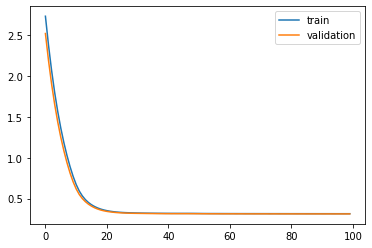

Time to train LSTM:  68.07342720031738
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 2.7902 - acc: 0.5161 - val_loss: 2.5669 - val_acc: 0.5580

Epoch 00001: val_loss improved from inf to 2.56688, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.4063 - acc: 0.5850 - val_loss: 2.2190 - val_acc: 0.6188

Epoch 00002: val_loss improved from 2.56688 to 2.21896, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 2.0816 - acc: 0.6455 - val_loss: 1.9234 - val_acc: 0.6669

Epoch 00003: val_loss improved from 2.21896 to 1.92341, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.8049 - acc: 0.6909 - val_loss: 1.6696 - val_acc: 0.7024

Epoch 00004: val_loss improved from 1.92341 to 1.66960, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5668 - acc: 0.7242 - val_loss: 1.4500 - val_acc: 0.7331

Epoch 00005: val_loss improved from 1.66960 to 1.45002, saving model to Event_val_weights2.hdf5
Epoch 6/100

 - 1s - loss: 0.3223 - acc: 0.8793 - val_loss: 0.3291 - val_acc: 0.8753

Epoch 00046: val_loss improved from 0.32926 to 0.32914, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3221 - acc: 0.8793 - val_loss: 0.3290 - val_acc: 0.8754

Epoch 00047: val_loss improved from 0.32914 to 0.32905, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3220 - acc: 0.8792 - val_loss: 0.3290 - val_acc: 0.8758

Epoch 00048: val_loss improved from 0.32905 to 0.32895, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3219 - acc: 0.8791 - val_loss: 0.3289 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.32895 to 0.32887, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3217 - acc: 0.8791 - val_loss: 0.3288 - val_acc: 0.8754

Epoch 00050: val_loss improved from 0.32887 to 0.32878, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3216 - acc: 0.8790 - val_loss: 0.3287 - val_acc: 0.8751

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32449 to 0.32436, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3174 - acc: 0.8800 - val_loss: 0.3243 - val_acc: 0.8761

Epoch 00092: val_loss improved from 0.32436 to 0.32432, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3174 - acc: 0.8798 - val_loss: 0.3242 - val_acc: 0.8764

Epoch 00093: val_loss improved from 0.32432 to 0.32418, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3173 - acc: 0.8798 - val_loss: 0.3241 - val_acc: 0.8764

Epoch 00094: val_loss improved from 0.32418 to 0.32412, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3173 - acc: 0.8798 - val_loss: 0.3241 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32412 to 0.32410, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3172 - acc: 0.8799 - val_loss: 0.3240 - val_acc: 0.8762

Epoch 00096: val_loss improved from 0.32410 to 0.32402, saving model to Event_val_weights

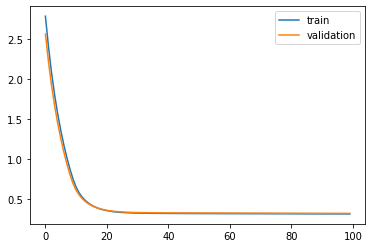

Time to train LSTM:  68.43890023231506
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 2.6699 - acc: 0.4938 - val_loss: 2.4733 - val_acc: 0.5282

Epoch 00001: val_loss improved from inf to 2.47327, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.3273 - acc: 0.5577 - val_loss: 2.1573 - val_acc: 0.5918

Epoch 00002: val_loss improved from 2.47327 to 2.15730, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.0308 - acc: 0.6184 - val_loss: 1.8855 - val_acc: 0.6424

Epoch 00003: val_loss improved from 2.15730 to 1.88553, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.7766 - acc: 0.6667 - val_loss: 1.6528 - val_acc: 0.6867

Epoch 00004: val_loss improved from 1.88553 to 1.65278, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5585 - acc: 0.7070 - val_loss: 1.4522 - val_acc: 0.7191

Epoch 00005: val_loss improved from 1.65278 to 1.45219, saving model to Event_val_weights3.hdf5
Epoch 6/100

 - 1s - loss: 0.3204 - acc: 0.8792 - val_loss: 0.3278 - val_acc: 0.8766

Epoch 00046: val_loss improved from 0.32788 to 0.32780, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3202 - acc: 0.8792 - val_loss: 0.3277 - val_acc: 0.8769

Epoch 00047: val_loss improved from 0.32780 to 0.32765, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8792 - val_loss: 0.3276 - val_acc: 0.8768

Epoch 00048: val_loss improved from 0.32765 to 0.32759, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8792 - val_loss: 0.3275 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32759 to 0.32750, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3196 - acc: 0.8795 - val_loss: 0.3275 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32750 to 0.32745, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8794 - val_loss: 0.3274 - val_acc: 0.8770

Epoch 00051: val_

 - 1s - loss: 0.3168 - acc: 0.8794 - val_loss: 0.3266 - val_acc: 0.8768

Epoch 00097: val_loss did not improve from 0.32640
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8796 - val_loss: 0.3270 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32640
Epoch 99/100
 - 1s - loss: 0.3167 - acc: 0.8794 - val_loss: 0.3268 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32640
Epoch 100/100
 - 1s - loss: 0.3168 - acc: 0.8795 - val_loss: 0.3271 - val_acc: 0.8768

Epoch 00100: val_loss did not improve from 0.32640
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.13928601514360017
best val loss: 0.3264032313028971
#################################


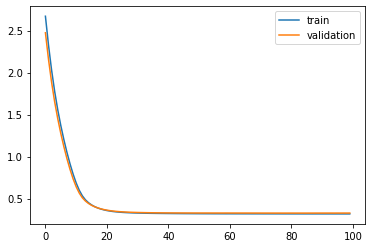

Time to train LSTM:  67.92671513557434


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feaa42d84e0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 2.7505 - acc: 0.5983 - val_loss: 2.5299 - val_acc: 0.6302

Epoch 00001: val_loss improved from inf to 2.52993, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.3682 - acc: 0.6597 - val_loss: 2.1828 - val_acc: 0.6824

Epoch 00002: val_loss improved from 2.52993 to 2.18284, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0436 - acc: 0.7028 - val_loss: 1.8855 - val_acc: 0.7197

Epoch 00003: val_loss improved from 2.18284 to 1.88550, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7653 - acc: 0.7348 - val_loss: 1.6309 - val_acc: 0.7476

Epoch 00004: val_loss improved from 1.88550 to 1.63089, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5262 - acc: 0.7602 - val_loss: 1.4121 - val_acc: 0.7707

Epoch 00005: val_loss improved from 1.63089 to 1.41213, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.3205 - acc: 0.7804 - v

 - 1s - loss: 0.3177 - acc: 0.8804 - val_loss: 0.3315 - val_acc: 0.8713

Epoch 00046: val_loss improved from 0.33155 to 0.33145, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3175 - acc: 0.8805 - val_loss: 0.3314 - val_acc: 0.8714

Epoch 00047: val_loss improved from 0.33145 to 0.33137, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3174 - acc: 0.8804 - val_loss: 0.3313 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.33137 to 0.33131, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3173 - acc: 0.8805 - val_loss: 0.3312 - val_acc: 0.8713

Epoch 00049: val_loss improved from 0.33131 to 0.33121, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3172 - acc: 0.8804 - val_loss: 0.3312 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.33121 to 0.33118, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3170 - acc: 0.8805 - val_loss: 0.3311 - val_acc: 0.8712

Epoch 00051: val_

 - 1s - loss: 0.3152 - acc: 0.8806 - val_loss: 0.3298 - val_acc: 0.8698

Epoch 00095: val_loss did not improve from 0.32981
Epoch 96/100
 - 1s - loss: 0.3151 - acc: 0.8806 - val_loss: 0.3298 - val_acc: 0.8699

Epoch 00096: val_loss improved from 0.32981 to 0.32981, saving model to Event_val_weights4.hdf5
Epoch 97/100
 - 1s - loss: 0.3151 - acc: 0.8807 - val_loss: 0.3298 - val_acc: 0.8701

Epoch 00097: val_loss did not improve from 0.32981
Epoch 98/100
 - 1s - loss: 0.3151 - acc: 0.8807 - val_loss: 0.3299 - val_acc: 0.8700

Epoch 00098: val_loss did not improve from 0.32981
Epoch 99/100
 - 1s - loss: 0.3151 - acc: 0.8806 - val_loss: 0.3297 - val_acc: 0.8701

Epoch 00099: val_loss improved from 0.32981 to 0.32971, saving model to Event_val_weights4.hdf5
Epoch 100/100
 - 1s - loss: 0.3151 - acc: 0.8806 - val_loss: 0.3298 - val_acc: 0.8702

Epoch 00100: val_loss did not improve from 0.32971
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.13928601514360

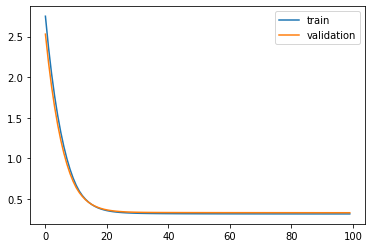

Time to train LSTM:  70.6225426197052
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 2.7968 - acc: 0.5480 - val_loss: 2.5667 - val_acc: 0.5914

Epoch 00001: val_loss improved from inf to 2.56673, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.4106 - acc: 0.6134 - val_loss: 2.2105 - val_acc: 0.6518

Epoch 00002: val_loss improved from 2.56673 to 2.21047, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 2.0775 - acc: 0.6670 - val_loss: 1.9029 - val_acc: 0.6988

Epoch 00003: val_loss improved from 2.21047 to 1.90289, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.7888 - acc: 0.7127 - val_loss: 1.6368 - val_acc: 0.7401

Epoch 00004: val_loss improved from 1.90289 to 1.63675, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5388 - acc: 0.7499 - val_loss: 1.4065 - val_acc: 0.7691

Epoch 00005: val_loss improved from 1.63675 to 1.40649, saving model to Event_val_weights5.hdf5
Epoch 6/100



Epoch 00046: val_loss improved from 0.31949 to 0.31939, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3194 - val_acc: 0.8801

Epoch 00047: val_loss improved from 0.31939 to 0.31937, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3194 - val_acc: 0.8801

Epoch 00048: val_loss improved from 0.31937 to 0.31935, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8800 - val_loss: 0.3194 - val_acc: 0.8801

Epoch 00049: val_loss improved from 0.31935 to 0.31935, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3192 - val_acc: 0.8797

Epoch 00050: val_loss improved from 0.31935 to 0.31919, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3174 - acc: 0.8800 - val_loss: 0.3191 - val_acc: 0.8799

Epoch 00051: val_loss improved from 0.31919 to 0.31911, saving model to Event_val_weights

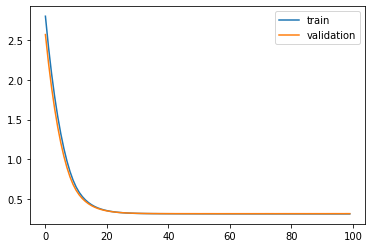

Time to train LSTM:  68.67538070678711


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fea604285f8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 2.0281 - acc: 0.4992 - val_loss: 1.8573 - val_acc: 0.5747

Epoch 00001: val_loss improved from inf to 1.85732, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.7484 - acc: 0.6160 - val_loss: 1.6112 - val_acc: 0.6689

Epoch 00002: val_loss improved from 1.85732 to 1.61116, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.5286 - acc: 0.6853 - val_loss: 1.4125 - val_acc: 0.7189

Epoch 00003: val_loss improved from 1.61116 to 1.41252, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.3461 - acc: 0.7234 - val_loss: 1.2445 - val_acc: 0.7498

Epoch 00004: val_loss improved from 1.41252 to 1.24454, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.1892 - acc: 0.7494 - val_loss: 1.0994 - val_acc: 0.7720

Epoch 00005: val_loss improved from 1.24454 to 1.09938, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.0520 - acc: 0.7696 - v

 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3135 - val_acc: 0.8817

Epoch 00046: val_loss improved from 0.31374 to 0.31354, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3136 - val_acc: 0.8816

Epoch 00047: val_loss did not improve from 0.31354
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3134 - val_acc: 0.8819

Epoch 00048: val_loss improved from 0.31354 to 0.31341, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3135 - val_acc: 0.8819

Epoch 00049: val_loss did not improve from 0.31341
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8789 - val_loss: 0.3132 - val_acc: 0.8819

Epoch 00050: val_loss improved from 0.31341 to 0.31322, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3134 - val_acc: 0.8818

Epoch 00051: val_loss did not improve from 0.31322
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_lo

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3123 - val_acc: 0.8811

Epoch 00099: val_loss did not improve from 0.31213
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3124 - val_acc: 0.8810

Epoch 00100: val_loss did not improve from 0.31213
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.08319798053011772
best val loss: 0.3121349759366777
#################################


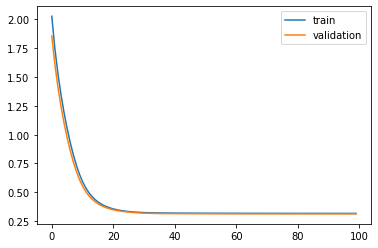

Time to train LSTM:  70.67062783241272
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 1.9684 - acc: 0.5462 - val_loss: 1.8113 - val_acc: 0.5987

Epoch 00001: val_loss improved from inf to 1.81133, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.7047 - acc: 0.6302 - val_loss: 1.5815 - val_acc: 0.6667

Epoch 00002: val_loss improved from 1.81133 to 1.58148, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.4935 - acc: 0.6856 - val_loss: 1.3931 - val_acc: 0.7088

Epoch 00003: val_loss improved from 1.58148 to 1.39307, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.3180 - acc: 0.7221 - val_loss: 1.2348 - val_acc: 0.7359

Epoch 00004: val_loss improved from 1.39307 to 1.23480, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.1694 - acc: 0.7478 - val_loss: 1.1002 - val_acc: 0.7530

Epoch 00005: val_loss improved from 1.23480 to 1.10020, saving model to Event_val_weights2.hdf5
Epoch 6/100

 - 1s - loss: 0.3169 - acc: 0.8804 - val_loss: 0.3242 - val_acc: 0.8751

Epoch 00046: val_loss improved from 0.32432 to 0.32425, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3167 - acc: 0.8804 - val_loss: 0.3242 - val_acc: 0.8752

Epoch 00047: val_loss improved from 0.32425 to 0.32421, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3167 - acc: 0.8806 - val_loss: 0.3242 - val_acc: 0.8753

Epoch 00048: val_loss improved from 0.32421 to 0.32419, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3166 - acc: 0.8805 - val_loss: 0.3240 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.32419 to 0.32401, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3166 - acc: 0.8807 - val_loss: 0.3241 - val_acc: 0.8753

Epoch 00050: val_loss did not improve from 0.32401
Epoch 51/100
 - 1s - loss: 0.3165 - acc: 0.8806 - val_loss: 0.3240 - val_acc: 0.8756

Epoch 00051: val_loss improved from 0.32401 to 0.32398, saving

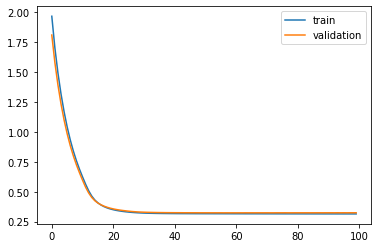

Time to train LSTM:  68.95344996452332


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fea2871fac8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 1.9636 - acc: 0.5366 - val_loss: 1.8175 - val_acc: 0.5780

Epoch 00001: val_loss improved from inf to 1.81749, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.7101 - acc: 0.6196 - val_loss: 1.5918 - val_acc: 0.6550

Epoch 00002: val_loss improved from 1.81749 to 1.59178, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.5005 - acc: 0.6831 - val_loss: 1.3998 - val_acc: 0.7033

Epoch 00003: val_loss improved from 1.59178 to 1.39977, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.3186 - acc: 0.7243 - val_loss: 1.2303 - val_acc: 0.7321

Epoch 00004: val_loss improved from 1.39977 to 1.23028, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.1565 - acc: 0.7523 - val_loss: 1.0784 - val_acc: 0.7597

Epoch 00005: val_loss improved from 1.23028 to 1.07835, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0105 - acc: 0.7771 - v

 - 1s - loss: 0.3178 - acc: 0.8796 - val_loss: 0.3262 - val_acc: 0.8757

Epoch 00046: val_loss improved from 0.32651 to 0.32617, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3176 - acc: 0.8796 - val_loss: 0.3261 - val_acc: 0.8760

Epoch 00047: val_loss improved from 0.32617 to 0.32609, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3258 - val_acc: 0.8764

Epoch 00048: val_loss improved from 0.32609 to 0.32577, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3173 - acc: 0.8800 - val_loss: 0.3257 - val_acc: 0.8762

Epoch 00049: val_loss improved from 0.32577 to 0.32571, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3172 - acc: 0.8801 - val_loss: 0.3256 - val_acc: 0.8766

Epoch 00050: val_loss improved from 0.32571 to 0.32563, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3253 - val_acc: 0.8764

Epoch 00051: val_

 - 1s - loss: 0.3155 - acc: 0.8807 - val_loss: 0.3244 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32426
Epoch 99/100
 - 1s - loss: 0.3155 - acc: 0.8806 - val_loss: 0.3244 - val_acc: 0.8767

Epoch 00099: val_loss did not improve from 0.32426
Epoch 100/100
 - 1s - loss: 0.3155 - acc: 0.8807 - val_loss: 0.3245 - val_acc: 0.8762

Epoch 00100: val_loss did not improve from 0.32426
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.08319798053011772
best val loss: 0.3242554585668776
#################################


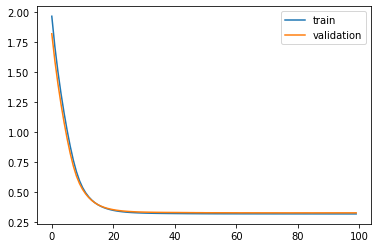

Time to train LSTM:  71.9043972492218
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 1.9986 - acc: 0.5469 - val_loss: 1.8390 - val_acc: 0.5994

Epoch 00001: val_loss improved from inf to 1.83905, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.7269 - acc: 0.6336 - val_loss: 1.6039 - val_acc: 0.6658

Epoch 00002: val_loss improved from 1.83905 to 1.60389, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.5119 - acc: 0.6902 - val_loss: 1.4124 - val_acc: 0.7070

Epoch 00003: val_loss improved from 1.60389 to 1.41240, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.3324 - acc: 0.7208 - val_loss: 1.2488 - val_acc: 0.7297

Epoch 00004: val_loss improved from 1.41240 to 1.24883, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.1775 - acc: 0.7426 - val_loss: 1.1064 - val_acc: 0.7517

Epoch 00005: val_loss improved from 1.24883 to 1.10643, saving model to Event_val_weights4.hdf5
Epoch 6/100


 - 1s - loss: 0.3168 - acc: 0.8808 - val_loss: 0.3315 - val_acc: 0.8697

Epoch 00046: val_loss improved from 0.33154 to 0.33147, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3167 - acc: 0.8807 - val_loss: 0.3313 - val_acc: 0.8697

Epoch 00047: val_loss improved from 0.33147 to 0.33131, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3166 - acc: 0.8808 - val_loss: 0.3313 - val_acc: 0.8694

Epoch 00048: val_loss improved from 0.33131 to 0.33126, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3164 - acc: 0.8808 - val_loss: 0.3311 - val_acc: 0.8700

Epoch 00049: val_loss improved from 0.33126 to 0.33111, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3163 - acc: 0.8808 - val_loss: 0.3311 - val_acc: 0.8700

Epoch 00050: val_loss improved from 0.33111 to 0.33108, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3162 - acc: 0.8808 - val_loss: 0.3309 - val_acc: 0.8700

Epoch 00051: val_

 - 1s - loss: 0.3140 - acc: 0.8810 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00099: val_loss did not improve from 0.32970
Epoch 100/100
 - 1s - loss: 0.3138 - acc: 0.8809 - val_loss: 0.3302 - val_acc: 0.8704

Epoch 00100: val_loss did not improve from 0.32970
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.08319798053011772
best val loss: 0.32970055060916476
#################################


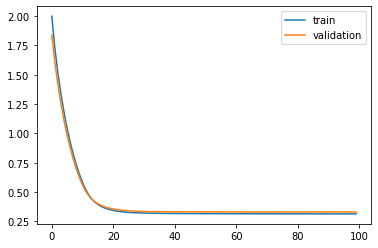

Time to train LSTM:  71.11707258224487
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 1.9771 - acc: 0.5272 - val_loss: 1.8289 - val_acc: 0.5822

Epoch 00001: val_loss improved from inf to 1.82889, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.7304 - acc: 0.6133 - val_loss: 1.6085 - val_acc: 0.6468

Epoch 00002: val_loss improved from 1.82889 to 1.60847, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.5234 - acc: 0.6675 - val_loss: 1.4189 - val_acc: 0.6908

Epoch 00003: val_loss improved from 1.60847 to 1.41886, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.3442 - acc: 0.7043 - val_loss: 1.2530 - val_acc: 0.7250

Epoch 00004: val_loss improved from 1.41886 to 1.25303, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.1868 - acc: 0.7346 - val_loss: 1.1060 - val_acc: 0.7519

Epoch 00005: val_loss improved from 1.25303 to 1.10595, saving model to Event_val_weights5.hdf5
Epoch 6/100

 - 1s - loss: 0.3225 - acc: 0.8791 - val_loss: 0.3245 - val_acc: 0.8773

Epoch 00046: val_loss improved from 0.32460 to 0.32452, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3223 - acc: 0.8791 - val_loss: 0.3244 - val_acc: 0.8774

Epoch 00047: val_loss improved from 0.32452 to 0.32443, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3222 - acc: 0.8792 - val_loss: 0.3244 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32443 to 0.32435, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3221 - acc: 0.8792 - val_loss: 0.3243 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32435 to 0.32427, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3219 - acc: 0.8792 - val_loss: 0.3242 - val_acc: 0.8781

Epoch 00050: val_loss improved from 0.32427 to 0.32422, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3218 - acc: 0.8791 - val_loss: 0.3241 - val_acc: 0.8781

Epoch 00051: val_

 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3226 - val_acc: 0.8776

Epoch 00094: val_loss did not improve from 0.32255
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3225 - val_acc: 0.8773

Epoch 00095: val_loss improved from 0.32255 to 0.32252, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3226 - val_acc: 0.8778

Epoch 00096: val_loss did not improve from 0.32252
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8799 - val_loss: 0.3225 - val_acc: 0.8773

Epoch 00097: val_loss improved from 0.32252 to 0.32248, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3175 - acc: 0.8797 - val_loss: 0.3226 - val_acc: 0.8776

Epoch 00098: val_loss did not improve from 0.32248
Epoch 99/100
 - 1s - loss: 0.3174 - acc: 0.8799 - val_loss: 0.3224 - val_acc: 0.8774

Epoch 00099: val_loss improved from 0.32248 to 0.32243, saving model to Event_val_weights5.hdf5
Epoch 100/100
 - 1s - loss: 0.3174 - acc: 0.8797 - val_l

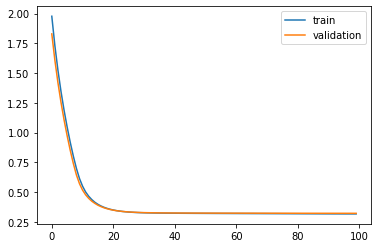

Time to train LSTM:  70.6606957912445


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fea08421160>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 2.7204 - acc: 0.5354 - val_loss: 2.4891 - val_acc: 0.5912

Epoch 00001: val_loss improved from inf to 2.48913, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.3311 - acc: 0.6307 - val_loss: 2.1359 - val_acc: 0.6760

Epoch 00002: val_loss improved from 2.48913 to 2.13593, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 2.0082 - acc: 0.6923 - val_loss: 1.8407 - val_acc: 0.7178

Epoch 00003: val_loss improved from 2.13593 to 1.84075, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.7349 - acc: 0.7270 - val_loss: 1.5895 - val_acc: 0.7459

Epoch 00004: val_loss improved from 1.84075 to 1.58949, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5013 - acc: 0.7492 - val_loss: 1.3746 - val_acc: 0.7646

Epoch 00005: val_loss improved from 1.58949 to 1.37459, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.3016 - acc: 0.7681 - v

 - 1s - loss: 0.3210 - acc: 0.8788 - val_loss: 0.3159 - val_acc: 0.8797

Epoch 00046: val_loss did not improve from 0.31585
Epoch 47/100
 - 1s - loss: 0.3209 - acc: 0.8784 - val_loss: 0.3157 - val_acc: 0.8793

Epoch 00047: val_loss improved from 0.31585 to 0.31571, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3208 - acc: 0.8786 - val_loss: 0.3155 - val_acc: 0.8796

Epoch 00048: val_loss improved from 0.31571 to 0.31548, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3208 - acc: 0.8787 - val_loss: 0.3157 - val_acc: 0.8804

Epoch 00049: val_loss did not improve from 0.31548
Epoch 50/100
 - 1s - loss: 0.3206 - acc: 0.8787 - val_loss: 0.3155 - val_acc: 0.8804

Epoch 00050: val_loss did not improve from 0.31548
Epoch 51/100
 - 1s - loss: 0.3205 - acc: 0.8788 - val_loss: 0.3155 - val_acc: 0.8808

Epoch 00051: val_loss improved from 0.31548 to 0.31547, saving model to Event_val_weights1.hdf5
Epoch 52/100
 - 1s - loss: 0.3204 - acc: 0.8790 - val_lo

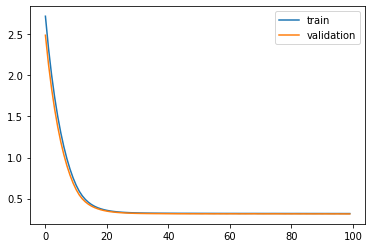

Time to train LSTM:  78.504465341568
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 2.7234 - acc: 0.4281 - val_loss: 2.5060 - val_acc: 0.4719

Epoch 00001: val_loss improved from inf to 2.50602, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.3503 - acc: 0.5056 - val_loss: 2.1654 - val_acc: 0.5541

Epoch 00002: val_loss improved from 2.50602 to 2.16543, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 2.0344 - acc: 0.5838 - val_loss: 1.8779 - val_acc: 0.6213

Epoch 00003: val_loss improved from 2.16543 to 1.87791, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.7671 - acc: 0.6478 - val_loss: 1.6343 - val_acc: 0.6717

Epoch 00004: val_loss improved from 1.87791 to 1.63434, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5397 - acc: 0.6950 - val_loss: 1.4268 - val_acc: 0.7127

Epoch 00005: val_loss improved from 1.63434 to 1.42676, saving model to Event_val_weights2.hdf5
Epoch 6/100
 

 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3285 - val_acc: 0.8743

Epoch 00046: val_loss improved from 0.32864 to 0.32855, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3285 - val_acc: 0.8742

Epoch 00047: val_loss improved from 0.32855 to 0.32854, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3284 - val_acc: 0.8747

Epoch 00048: val_loss improved from 0.32854 to 0.32838, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8790 - val_loss: 0.3283 - val_acc: 0.8748

Epoch 00049: val_loss improved from 0.32838 to 0.32830, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3282 - val_acc: 0.8749

Epoch 00050: val_loss improved from 0.32830 to 0.32821, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3281 - val_acc: 0.8750

Epoch 00051: val_

 - 1s - loss: 0.3169 - acc: 0.8798 - val_loss: 0.3259 - val_acc: 0.8760

Epoch 00093: val_loss improved from 0.32599 to 0.32595, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3168 - acc: 0.8798 - val_loss: 0.3259 - val_acc: 0.8760

Epoch 00094: val_loss improved from 0.32595 to 0.32595, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3169 - acc: 0.8799 - val_loss: 0.3259 - val_acc: 0.8759

Epoch 00095: val_loss improved from 0.32595 to 0.32592, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3167 - acc: 0.8799 - val_loss: 0.3259 - val_acc: 0.8759

Epoch 00096: val_loss improved from 0.32592 to 0.32586, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3168 - acc: 0.8800 - val_loss: 0.3259 - val_acc: 0.8759

Epoch 00097: val_loss improved from 0.32586 to 0.32586, saving model to Event_val_weights2.hdf5
Epoch 98/100
 - 1s - loss: 0.3167 - acc: 0.8799 - val_loss: 0.3258 - val_acc: 0.8758

Epoch 00098: val_

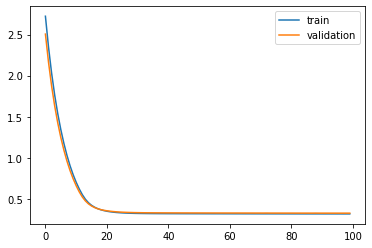

Time to train LSTM:  71.07168817520142
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 2.7898 - acc: 0.5200 - val_loss: 2.5565 - val_acc: 0.5636

Epoch 00001: val_loss improved from inf to 2.55653, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.3838 - acc: 0.6091 - val_loss: 2.1914 - val_acc: 0.6492

Epoch 00002: val_loss improved from 2.55653 to 2.19141, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.0482 - acc: 0.6809 - val_loss: 1.8920 - val_acc: 0.7024

Epoch 00003: val_loss improved from 2.19141 to 1.89204, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.7715 - acc: 0.7186 - val_loss: 1.6422 - val_acc: 0.7301

Epoch 00004: val_loss improved from 1.89204 to 1.64222, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5383 - acc: 0.7415 - val_loss: 1.4291 - val_acc: 0.7502

Epoch 00005: val_loss improved from 1.64222 to 1.42913, saving model to Event_val_weights3.hdf5
Epoch 6/100

 - 1s - loss: 0.3189 - acc: 0.8797 - val_loss: 0.3274 - val_acc: 0.8763

Epoch 00046: val_loss improved from 0.32741 to 0.32741, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3187 - acc: 0.8798 - val_loss: 0.3274 - val_acc: 0.8762

Epoch 00047: val_loss improved from 0.32741 to 0.32740, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8798 - val_loss: 0.3275 - val_acc: 0.8761

Epoch 00048: val_loss did not improve from 0.32740
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8798 - val_loss: 0.3275 - val_acc: 0.8761

Epoch 00049: val_loss did not improve from 0.32740
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8799 - val_loss: 0.3276 - val_acc: 0.8764

Epoch 00050: val_loss did not improve from 0.32740
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8797 - val_loss: 0.3276 - val_acc: 0.8759

Epoch 00051: val_loss did not improve from 0.32740
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8796 - val_loss: 0.3278 - val_acc: 0.8762

Epoch 00052: va

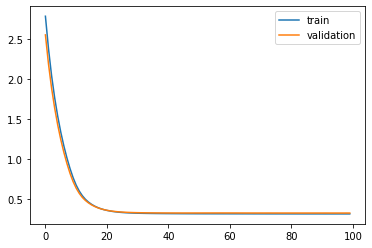

Time to train LSTM:  70.81738519668579
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 2.8240 - acc: 0.5221 - val_loss: 2.5695 - val_acc: 0.5743

Epoch 00001: val_loss improved from inf to 2.56952, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.4014 - acc: 0.6116 - val_loss: 2.2050 - val_acc: 0.6550

Epoch 00002: val_loss improved from 2.56952 to 2.20500, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0702 - acc: 0.6732 - val_loss: 1.9119 - val_acc: 0.7019

Epoch 00003: val_loss improved from 2.20500 to 1.91190, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7970 - acc: 0.7100 - val_loss: 1.6646 - val_acc: 0.7263

Epoch 00004: val_loss improved from 1.91190 to 1.66462, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5649 - acc: 0.7335 - val_loss: 1.4539 - val_acc: 0.7448

Epoch 00005: val_loss improved from 1.66462 to 1.45391, saving model to Event_val_weights4.hdf5
Epoch 6/100

 - 1s - loss: 0.3185 - acc: 0.8806 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00046: val_loss improved from 0.33211 to 0.33201, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3183 - acc: 0.8806 - val_loss: 0.3320 - val_acc: 0.8703

Epoch 00047: val_loss improved from 0.33201 to 0.33196, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8807 - val_loss: 0.3319 - val_acc: 0.8709

Epoch 00048: val_loss improved from 0.33196 to 0.33190, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8808 - val_loss: 0.3319 - val_acc: 0.8709

Epoch 00049: val_loss improved from 0.33190 to 0.33188, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8807 - val_loss: 0.3319 - val_acc: 0.8708

Epoch 00050: val_loss improved from 0.33188 to 0.33185, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3179 - acc: 0.8807 - val_loss: 0.3319 - val_acc: 0.8708

Epoch 00051: val_

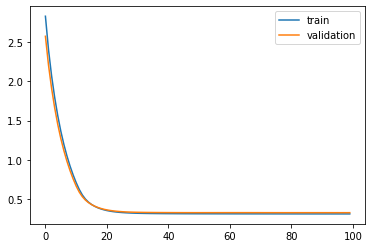

Time to train LSTM:  71.75513315200806


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe9d80f54e0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 2.6015 - acc: 0.6240 - val_loss: 2.4019 - val_acc: 0.6549

Epoch 00001: val_loss improved from inf to 2.40191, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2611 - acc: 0.6703 - val_loss: 2.0861 - val_acc: 0.6928

Epoch 00002: val_loss improved from 2.40191 to 2.08611, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9648 - acc: 0.7011 - val_loss: 1.8129 - val_acc: 0.7128

Epoch 00003: val_loss improved from 2.08611 to 1.81286, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.7089 - acc: 0.7231 - val_loss: 1.5778 - val_acc: 0.7328

Epoch 00004: val_loss improved from 1.81286 to 1.57779, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4888 - acc: 0.7423 - val_loss: 1.3757 - val_acc: 0.7526

Epoch 00005: val_loss improved from 1.57779 to 1.37570, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2996 - acc: 0.7584 - v

 - 1s - loss: 0.3196 - acc: 0.8798 - val_loss: 0.3233 - val_acc: 0.8792

Epoch 00046: val_loss improved from 0.32336 to 0.32328, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8798 - val_loss: 0.3233 - val_acc: 0.8793

Epoch 00047: val_loss did not improve from 0.32328
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8798 - val_loss: 0.3232 - val_acc: 0.8796

Epoch 00048: val_loss improved from 0.32328 to 0.32319, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8798 - val_loss: 0.3233 - val_acc: 0.8797

Epoch 00049: val_loss did not improve from 0.32319
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8797 - val_loss: 0.3232 - val_acc: 0.8797

Epoch 00050: val_loss improved from 0.32319 to 0.32317, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8797 - val_loss: 0.3231 - val_acc: 0.8794

Epoch 00051: val_loss improved from 0.32317 to 0.32312, saving model to Event_val_weights5.hdf5
Epoch 52/10

 - 1s - loss: 0.3164 - acc: 0.8805 - val_loss: 0.3222 - val_acc: 0.8780

Epoch 00099: val_loss did not improve from 0.32204
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8806 - val_loss: 0.3222 - val_acc: 0.8782

Epoch 00100: val_loss did not improve from 0.32204
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.13212291230578316
best val loss: 0.32203768446710374
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 1, 0.3236824516455332], [8, 8192, 0.08319798053011772, 2, 0.3242554585668776], [8, 8192, 0.08319798053011772, 3, 0.32970055060916476], [8, 8192, 0.08319798053011772, 4, 0.3224302625921037], [8, 8192, 0

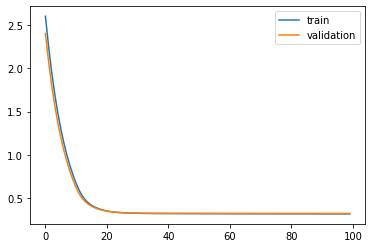

Time to train LSTM:  78.59569501876831
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.5117 - acc: 0.5966 - val_loss: 1.4018 - val_acc: 0.6496

Epoch 00001: val_loss improved from inf to 1.40181, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.3264 - acc: 0.6809 - val_loss: 1.2350 - val_acc: 0.7144

Epoch 00002: val_loss improved from 1.40181 to 1.23495, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.1778 - acc: 0.7219 - val_loss: 1.0979 - val_acc: 0.7446

Epoch 00003: val_loss improved from 1.23495 to 1.09795, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.0524 - acc: 0.7448 - val_loss: 0.9813 - val_acc: 0.7621

Epoch 00004: val_loss improved from 1.09795 to 0.98128, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.9430 - acc: 0.7601 - val_loss: 0.8785 - val_acc: 0.7748

Epoch 00005: val_loss improved from 0.98128 to 0.87853, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3186 - acc: 0.8793 - val_loss: 0.3162 - val_acc: 0.8816

Epoch 00046: val_loss improved from 0.31641 to 0.31617, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8794 - val_loss: 0.3162 - val_acc: 0.8813

Epoch 00047: val_loss did not improve from 0.31617
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8793 - val_loss: 0.3159 - val_acc: 0.8812

Epoch 00048: val_loss improved from 0.31617 to 0.31587, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8794 - val_loss: 0.3161 - val_acc: 0.8812

Epoch 00049: val_loss did not improve from 0.31587
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8794 - val_loss: 0.3159 - val_acc: 0.8812

Epoch 00050: val_loss did not improve from 0.31587
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8794 - val_loss: 0.3159 - val_acc: 0.8811

Epoch 00051: val_loss did not improve from 0.31587
Epoch 52/100
 - 1s - loss: 0.3178 - acc: 0.8794 - val_loss: 0.3159 - val_acc: 0.8813

Epoch 00052: va

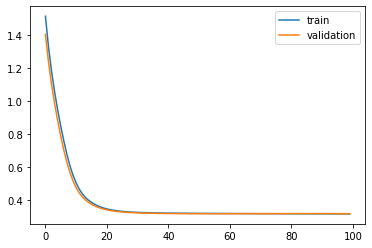

Time to train LSTM:  72.069650888443
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.5260 - acc: 0.5746 - val_loss: 1.4163 - val_acc: 0.6320

Epoch 00001: val_loss improved from inf to 1.41633, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.3389 - acc: 0.6608 - val_loss: 1.2532 - val_acc: 0.6936

Epoch 00002: val_loss improved from 1.41633 to 1.25324, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.1870 - acc: 0.7111 - val_loss: 1.1159 - val_acc: 0.7287

Epoch 00003: val_loss improved from 1.25324 to 1.11587, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.0560 - acc: 0.7441 - val_loss: 0.9952 - val_acc: 0.7528

Epoch 00004: val_loss improved from 1.11587 to 0.99523, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.9403 - acc: 0.7680 - val_loss: 0.8880 - val_acc: 0.7757

Epoch 00005: val_loss improved from 0.99523 to 0.88799, saving model to Event_val_weights2.hdf5
Epoch 6/100
 

 - 1s - loss: 0.3166 - acc: 0.8801 - val_loss: 0.3243 - val_acc: 0.8760

Epoch 00046: val_loss improved from 0.32445 to 0.32426, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3165 - acc: 0.8800 - val_loss: 0.3241 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.32426 to 0.32412, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3164 - acc: 0.8799 - val_loss: 0.3241 - val_acc: 0.8758

Epoch 00048: val_loss did not improve from 0.32412
Epoch 49/100
 - 1s - loss: 0.3163 - acc: 0.8800 - val_loss: 0.3239 - val_acc: 0.8759

Epoch 00049: val_loss improved from 0.32412 to 0.32393, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3162 - acc: 0.8799 - val_loss: 0.3239 - val_acc: 0.8757

Epoch 00050: val_loss did not improve from 0.32393
Epoch 51/100
 - 1s - loss: 0.3162 - acc: 0.8800 - val_loss: 0.3238 - val_acc: 0.8757

Epoch 00051: val_loss improved from 0.32393 to 0.32382, saving model to Event_val_weights2.hdf5
Epoch 52/10

 - 1s - loss: 0.3149 - acc: 0.8805 - val_loss: 0.3228 - val_acc: 0.8751

Epoch 00099: val_loss improved from 0.32284 to 0.32284, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3148 - acc: 0.8805 - val_loss: 0.3229 - val_acc: 0.8752

Epoch 00100: val_loss did not improve from 0.32284
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.05416966257252499
best val loss: 0.3228370980421702
#################################


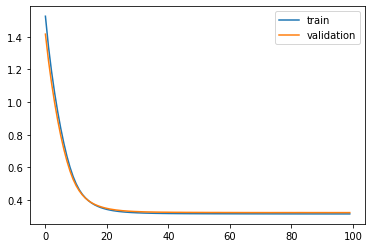

Time to train LSTM:  74.0758466720581
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.6639 - acc: 0.4845 - val_loss: 1.5292 - val_acc: 0.5492

Epoch 00001: val_loss improved from inf to 1.52919, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.4420 - acc: 0.5891 - val_loss: 1.3408 - val_acc: 0.6368

Epoch 00002: val_loss improved from 1.52919 to 1.34078, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.2732 - acc: 0.6639 - val_loss: 1.1936 - val_acc: 0.6943

Epoch 00003: val_loss improved from 1.34078 to 1.19359, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.1380 - acc: 0.7104 - val_loss: 1.0717 - val_acc: 0.7329

Epoch 00004: val_loss improved from 1.19359 to 1.07170, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.0237 - acc: 0.7405 - val_loss: 0.9672 - val_acc: 0.7579

Epoch 00005: val_loss improved from 1.07170 to 0.96720, saving model to Event_val_weights3.hdf5
Epoch 6/100


 - 1s - loss: 0.3187 - acc: 0.8810 - val_loss: 0.3290 - val_acc: 0.8764

Epoch 00046: val_loss improved from 0.32919 to 0.32904, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8811 - val_loss: 0.3289 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.32904 to 0.32891, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8811 - val_loss: 0.3288 - val_acc: 0.8760

Epoch 00048: val_loss improved from 0.32891 to 0.32881, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8810 - val_loss: 0.3287 - val_acc: 0.8761

Epoch 00049: val_loss improved from 0.32881 to 0.32869, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8810 - val_loss: 0.3286 - val_acc: 0.8763

Epoch 00050: val_loss improved from 0.32869 to 0.32857, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8809 - val_loss: 0.3285 - val_acc: 0.8763

Epoch 00051: val_


Epoch 00096: val_loss did not improve from 0.32689
Epoch 97/100
 - 1s - loss: 0.3148 - acc: 0.8804 - val_loss: 0.3283 - val_acc: 0.8760

Epoch 00097: val_loss did not improve from 0.32689
Epoch 98/100
 - 1s - loss: 0.3148 - acc: 0.8805 - val_loss: 0.3285 - val_acc: 0.8759

Epoch 00098: val_loss did not improve from 0.32689
Epoch 99/100
 - 1s - loss: 0.3147 - acc: 0.8805 - val_loss: 0.3286 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32689
Epoch 100/100
 - 1s - loss: 0.3147 - acc: 0.8805 - val_loss: 0.3287 - val_acc: 0.8754

Epoch 00100: val_loss did not improve from 0.32689
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.05416966257252499
best val loss: 0.3268910480870141
#################################


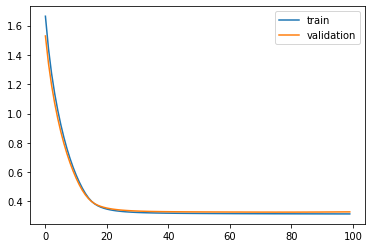

Time to train LSTM:  72.52891206741333


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe8cdb75ac8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.6192 - acc: 0.5368 - val_loss: 1.4906 - val_acc: 0.6037

Epoch 00001: val_loss improved from inf to 1.49060, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.3936 - acc: 0.6540 - val_loss: 1.2985 - val_acc: 0.6907

Epoch 00002: val_loss improved from 1.49060 to 1.29846, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.2235 - acc: 0.7168 - val_loss: 1.1499 - val_acc: 0.7312

Epoch 00003: val_loss improved from 1.29846 to 1.14986, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.0883 - acc: 0.7474 - val_loss: 1.0272 - val_acc: 0.7570

Epoch 00004: val_loss improved from 1.14986 to 1.02724, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.9743 - acc: 0.7688 - val_loss: 0.9219 - val_acc: 0.7727

Epoch 00005: val_loss improved from 1.02724 to 0.92186, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8756 - acc: 0.7869 - v

 - 1s - loss: 0.3165 - acc: 0.8808 - val_loss: 0.3326 - val_acc: 0.8707

Epoch 00046: val_loss improved from 0.33274 to 0.33263, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3163 - acc: 0.8809 - val_loss: 0.3326 - val_acc: 0.8704

Epoch 00047: val_loss improved from 0.33263 to 0.33257, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3162 - acc: 0.8807 - val_loss: 0.3325 - val_acc: 0.8706

Epoch 00048: val_loss improved from 0.33257 to 0.33251, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3160 - acc: 0.8808 - val_loss: 0.3324 - val_acc: 0.8707

Epoch 00049: val_loss improved from 0.33251 to 0.33243, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3160 - acc: 0.8808 - val_loss: 0.3324 - val_acc: 0.8709

Epoch 00050: val_loss did not improve from 0.33243
Epoch 51/100
 - 1s - loss: 0.3158 - acc: 0.8808 - val_loss: 0.3324 - val_acc: 0.8709

Epoch 00051: val_loss improved from 0.33243 to 0.33235, saving


Epoch 00100: val_loss did not improve from 0.33151
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.05416966257252499
best val loss: 0.3315125308831533
#################################


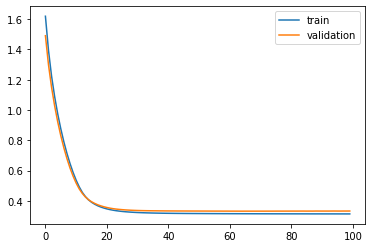

Time to train LSTM:  80.66430997848511
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.5808 - acc: 0.5791 - val_loss: 1.4551 - val_acc: 0.6186

Epoch 00001: val_loss improved from inf to 1.45508, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.3636 - acc: 0.6551 - val_loss: 1.2683 - val_acc: 0.6861

Epoch 00002: val_loss improved from 1.45508 to 1.26831, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.1960 - acc: 0.7099 - val_loss: 1.1173 - val_acc: 0.7346

Epoch 00003: val_loss improved from 1.26831 to 1.11731, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.0577 - acc: 0.7479 - val_loss: 0.9899 - val_acc: 0.7668

Epoch 00004: val_loss improved from 1.11731 to 0.98990, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.9396 - acc: 0.7741 - val_loss: 0.8807 - val_acc: 0.7876

Epoch 00005: val_loss improved from 0.98990 to 0.88067, saving model to Event_val_weights5.hdf5
Epoch 6/100

 - 1s - loss: 0.3186 - acc: 0.8798 - val_loss: 0.3223 - val_acc: 0.8774

Epoch 00046: val_loss improved from 0.32249 to 0.32234, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8799 - val_loss: 0.3221 - val_acc: 0.8773

Epoch 00047: val_loss improved from 0.32234 to 0.32213, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3221 - val_acc: 0.8774

Epoch 00048: val_loss improved from 0.32213 to 0.32205, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3180 - acc: 0.8801 - val_loss: 0.3219 - val_acc: 0.8780

Epoch 00049: val_loss improved from 0.32205 to 0.32190, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3218 - val_acc: 0.8784

Epoch 00050: val_loss improved from 0.32190 to 0.32182, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8801 - val_loss: 0.3217 - val_acc: 0.8783

Epoch 00051: val_

 - 1s - loss: 0.3144 - acc: 0.8802 - val_loss: 0.3213 - val_acc: 0.8792

Epoch 00099: val_loss did not improve from 0.32079
Epoch 100/100
 - 1s - loss: 0.3143 - acc: 0.8805 - val_loss: 0.3216 - val_acc: 0.8788

Epoch 00100: val_loss did not improve from 0.32079
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.05416966257252499
best val loss: 0.320794796122445
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 1, 0.3236824516455332], [8, 8192, 0.08319798053011772, 2, 0.3242554585668776], [8, 8192, 0.08319798053011772, 3, 0.32970055060916476], [8, 8192, 0.08319798053011772, 4, 0.3224302625921037], [8, 8192, 0.1

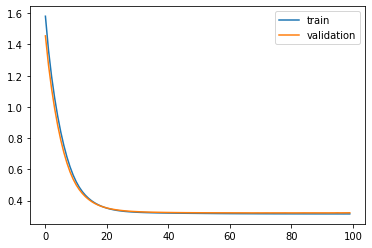

Time to train LSTM:  73.56806516647339
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.6931 - acc: 0.5391 - val_loss: 1.5526 - val_acc: 0.6144

Epoch 00001: val_loss improved from inf to 1.55263, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.4801 - acc: 0.6466 - val_loss: 1.3667 - val_acc: 0.6951

Epoch 00002: val_loss improved from 1.55263 to 1.36668, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.3092 - acc: 0.7062 - val_loss: 1.2126 - val_acc: 0.7313

Epoch 00003: val_loss improved from 1.36668 to 1.21262, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.1636 - acc: 0.7359 - val_loss: 1.0804 - val_acc: 0.7554

Epoch 00004: val_loss improved from 1.21262 to 1.08041, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.0377 - acc: 0.7566 - val_loss: 0.9656 - val_acc: 0.7754

Epoch 00005: val_loss improved from 1.08041 to 0.96563, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3189 - acc: 0.8795 - val_loss: 0.3163 - val_acc: 0.8793

Epoch 00046: val_loss improved from 0.31654 to 0.31630, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8795 - val_loss: 0.3161 - val_acc: 0.8798

Epoch 00047: val_loss improved from 0.31630 to 0.31610, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8793 - val_loss: 0.3159 - val_acc: 0.8801

Epoch 00048: val_loss improved from 0.31610 to 0.31587, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8793 - val_loss: 0.3157 - val_acc: 0.8801

Epoch 00049: val_loss improved from 0.31587 to 0.31567, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8792 - val_loss: 0.3154 - val_acc: 0.8802

Epoch 00050: val_loss improved from 0.31567 to 0.31544, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3178 - acc: 0.8792 - val_loss: 0.3154 - val_acc: 0.8806

Epoch 00051: val_

 - 1s - loss: 0.3150 - acc: 0.8801 - val_loss: 0.3128 - val_acc: 0.8814

Epoch 00095: val_loss did not improve from 0.31274
Epoch 96/100
 - 1s - loss: 0.3150 - acc: 0.8801 - val_loss: 0.3128 - val_acc: 0.8813

Epoch 00096: val_loss did not improve from 0.31274
Epoch 97/100
 - 1s - loss: 0.3150 - acc: 0.8802 - val_loss: 0.3128 - val_acc: 0.8813

Epoch 00097: val_loss did not improve from 0.31274
Epoch 98/100
 - 1s - loss: 0.3149 - acc: 0.8801 - val_loss: 0.3128 - val_acc: 0.8813

Epoch 00098: val_loss did not improve from 0.31274
Epoch 99/100
 - 1s - loss: 0.3149 - acc: 0.8802 - val_loss: 0.3128 - val_acc: 0.8816

Epoch 00099: val_loss did not improve from 0.31274
Epoch 100/100
 - 1s - loss: 0.3149 - acc: 0.8802 - val_loss: 0.3127 - val_acc: 0.8813

Epoch 00100: val_loss improved from 0.31274 to 0.31271, saving model to Event_val_weights1.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.0607656679935968
best val loss: 0.31271422616640726
#######

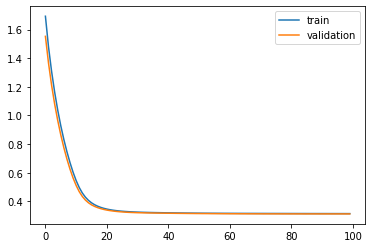

Time to train LSTM:  73.64796543121338
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.6608 - acc: 0.5879 - val_loss: 1.5380 - val_acc: 0.6186

Epoch 00001: val_loss improved from inf to 1.53803, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.4555 - acc: 0.6426 - val_loss: 1.3556 - val_acc: 0.6677

Epoch 00002: val_loss improved from 1.53803 to 1.35559, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.2837 - acc: 0.6912 - val_loss: 1.2009 - val_acc: 0.7086

Epoch 00003: val_loss improved from 1.35559 to 1.20093, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.1377 - acc: 0.7279 - val_loss: 1.0681 - val_acc: 0.7413

Epoch 00004: val_loss improved from 1.20093 to 1.06813, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.0117 - acc: 0.7547 - val_loss: 0.9523 - val_acc: 0.7632

Epoch 00005: val_loss improved from 1.06813 to 0.95234, saving model to Event_val_weights2.hdf5
Epoch 6/100

 - 1s - loss: 0.3184 - acc: 0.8795 - val_loss: 0.3268 - val_acc: 0.8742

Epoch 00046: val_loss improved from 0.32686 to 0.32678, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3183 - acc: 0.8795 - val_loss: 0.3267 - val_acc: 0.8743

Epoch 00047: val_loss improved from 0.32678 to 0.32665, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8795 - val_loss: 0.3267 - val_acc: 0.8744

Epoch 00048: val_loss did not improve from 0.32665
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8795 - val_loss: 0.3266 - val_acc: 0.8747

Epoch 00049: val_loss improved from 0.32665 to 0.32665, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8794 - val_loss: 0.3267 - val_acc: 0.8744

Epoch 00050: val_loss did not improve from 0.32665
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8795 - val_loss: 0.3268 - val_acc: 0.8742

Epoch 00051: val_loss did not improve from 0.32665
Epoch 52/100
 - 1s - loss: 0.3179 - acc: 0.8795 - val_lo

 - 1s - loss: 0.3141 - acc: 0.8805 - val_loss: 0.3234 - val_acc: 0.8754

Epoch 00098: val_loss did not improve from 0.32333
Epoch 99/100
 - 1s - loss: 0.3141 - acc: 0.8805 - val_loss: 0.3235 - val_acc: 0.8752

Epoch 00099: val_loss did not improve from 0.32333
Epoch 100/100
 - 1s - loss: 0.3140 - acc: 0.8805 - val_loss: 0.3234 - val_acc: 0.8751

Epoch 00100: val_loss did not improve from 0.32333
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.0607656679935968
best val loss: 0.3233330487145318
#################################


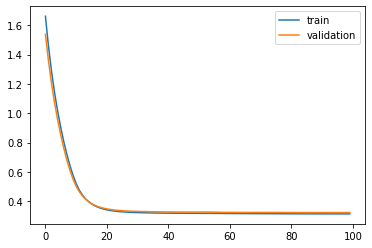

Time to train LSTM:  73.76244378089905
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 1.6629 - acc: 0.5279 - val_loss: 1.5474 - val_acc: 0.5726

Epoch 00001: val_loss improved from inf to 1.54745, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.4644 - acc: 0.6053 - val_loss: 1.3677 - val_acc: 0.6392

Epoch 00002: val_loss improved from 1.54745 to 1.36766, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.2981 - acc: 0.6630 - val_loss: 1.2163 - val_acc: 0.6850

Epoch 00003: val_loss improved from 1.36766 to 1.21628, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.1567 - acc: 0.7012 - val_loss: 1.0868 - val_acc: 0.7178

Epoch 00004: val_loss improved from 1.21628 to 1.08684, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.0342 - acc: 0.7279 - val_loss: 0.9739 - val_acc: 0.7421

Epoch 00005: val_loss improved from 1.08684 to 0.97385, saving model to Event_val_weights3.hdf5
Epoch 6/100

 - 1s - loss: 0.3190 - acc: 0.8801 - val_loss: 0.3279 - val_acc: 0.8758

Epoch 00046: val_loss improved from 0.32819 to 0.32790, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8800 - val_loss: 0.3277 - val_acc: 0.8762

Epoch 00047: val_loss improved from 0.32790 to 0.32770, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8799 - val_loss: 0.3275 - val_acc: 0.8767

Epoch 00048: val_loss improved from 0.32770 to 0.32751, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3275 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32751 to 0.32746, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8797 - val_loss: 0.3274 - val_acc: 0.8767

Epoch 00050: val_loss improved from 0.32746 to 0.32737, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8797 - val_loss: 0.3275 - val_acc: 0.8770

Epoch 00051: val_

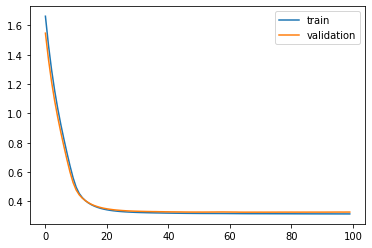

Time to train LSTM:  74.33560395240784


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe894514b00>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 1.6596 - acc: 0.4942 - val_loss: 1.5044 - val_acc: 0.5807

Epoch 00001: val_loss improved from inf to 1.50437, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.4105 - acc: 0.6430 - val_loss: 1.3026 - val_acc: 0.7021

Epoch 00002: val_loss improved from 1.50437 to 1.30257, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.2366 - acc: 0.7229 - val_loss: 1.1591 - val_acc: 0.7371

Epoch 00003: val_loss improved from 1.30257 to 1.15907, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.1040 - acc: 0.7490 - val_loss: 1.0394 - val_acc: 0.7591

Epoch 00004: val_loss improved from 1.15907 to 1.03938, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.9899 - acc: 0.7687 - val_loss: 0.9345 - val_acc: 0.7779

Epoch 00005: val_loss improved from 1.03938 to 0.93451, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8902 - acc: 0.7868 - 

 - 1s - loss: 0.3178 - acc: 0.8805 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00046: val_loss improved from 0.33218 to 0.33205, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3177 - acc: 0.8804 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00047: val_loss improved from 0.33205 to 0.33195, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3175 - acc: 0.8805 - val_loss: 0.3319 - val_acc: 0.8704

Epoch 00048: val_loss improved from 0.33195 to 0.33186, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3174 - acc: 0.8805 - val_loss: 0.3318 - val_acc: 0.8704

Epoch 00049: val_loss improved from 0.33186 to 0.33177, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3173 - acc: 0.8806 - val_loss: 0.3317 - val_acc: 0.8706

Epoch 00050: val_loss improved from 0.33177 to 0.33172, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3172 - acc: 0.8805 - val_loss: 0.3317 - val_acc: 0.8707

Epoch 00051: val_

 - 1s - loss: 0.3149 - acc: 0.8807 - val_loss: 0.3322 - val_acc: 0.8688

Epoch 00100: val_loss did not improve from 0.33092
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.0607656679935968
best val loss: 0.330924447827869
#################################


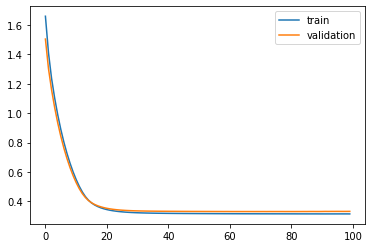

Time to train LSTM:  103.15411019325256
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 1.6810 - acc: 0.5708 - val_loss: 1.5469 - val_acc: 0.6156

Epoch 00001: val_loss improved from inf to 1.54686, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.4575 - acc: 0.6504 - val_loss: 1.3565 - val_acc: 0.6861

Epoch 00002: val_loss improved from 1.54686 to 1.35649, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.2876 - acc: 0.7057 - val_loss: 1.2054 - val_acc: 0.7311

Epoch 00003: val_loss improved from 1.35649 to 1.20537, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.1481 - acc: 0.7401 - val_loss: 1.0776 - val_acc: 0.7563

Epoch 00004: val_loss improved from 1.20537 to 1.07765, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.0281 - acc: 0.7634 - val_loss: 0.9665 - val_acc: 0.7777

Epoch 00005: val_loss improved from 1.07765 to 0.96652, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3197 - acc: 0.8801 - val_loss: 0.3232 - val_acc: 0.8774

Epoch 00046: val_loss improved from 0.32334 to 0.32315, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8800 - val_loss: 0.3229 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32315 to 0.32292, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8798 - val_loss: 0.3227 - val_acc: 0.8780

Epoch 00048: val_loss improved from 0.32292 to 0.32273, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8798 - val_loss: 0.3225 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32273 to 0.32253, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8800 - val_loss: 0.3224 - val_acc: 0.8784

Epoch 00050: val_loss improved from 0.32253 to 0.32235, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8798 - val_loss: 0.3222 - val_acc: 0.8779

Epoch 00051: val_


Epoch 00097: val_loss did not improve from 0.32102
Epoch 98/100
 - 1s - loss: 0.3157 - acc: 0.8799 - val_loss: 0.3212 - val_acc: 0.8787

Epoch 00098: val_loss did not improve from 0.32102
Epoch 99/100
 - 1s - loss: 0.3157 - acc: 0.8799 - val_loss: 0.3213 - val_acc: 0.8788

Epoch 00099: val_loss did not improve from 0.32102
Epoch 100/100
 - 1s - loss: 0.3156 - acc: 0.8800 - val_loss: 0.3212 - val_acc: 0.8787

Epoch 00100: val_loss did not improve from 0.32102
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.0607656679935968
best val loss: 0.32102203363842435
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 

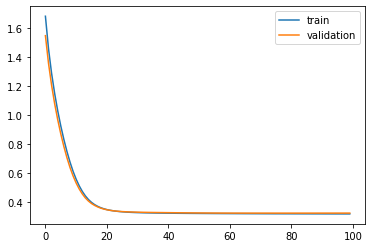

Time to train LSTM:  75.25971555709839
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 2.3539 - acc: 0.5057 - val_loss: 2.1837 - val_acc: 0.5403

Epoch 00001: val_loss improved from inf to 2.18371, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.0436 - acc: 0.5796 - val_loss: 1.8916 - val_acc: 0.6219

Epoch 00002: val_loss improved from 2.18371 to 1.89155, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.7724 - acc: 0.6557 - val_loss: 1.6380 - val_acc: 0.6921

Epoch 00003: val_loss improved from 1.89155 to 1.63801, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.5366 - acc: 0.7147 - val_loss: 1.4183 - val_acc: 0.7419

Epoch 00004: val_loss improved from 1.63801 to 1.41831, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3317 - acc: 0.7550 - val_loss: 1.2274 - val_acc: 0.7748

Epoch 00005: val_loss improved from 1.41831 to 1.22741, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3196 - acc: 0.8794 - val_loss: 0.3156 - val_acc: 0.8819

Epoch 00046: val_loss improved from 0.31571 to 0.31561, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3194 - acc: 0.8796 - val_loss: 0.3154 - val_acc: 0.8822

Epoch 00047: val_loss improved from 0.31561 to 0.31536, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8796 - val_loss: 0.3151 - val_acc: 0.8818

Epoch 00048: val_loss improved from 0.31536 to 0.31509, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8797 - val_loss: 0.3150 - val_acc: 0.8820

Epoch 00049: val_loss improved from 0.31509 to 0.31497, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8797 - val_loss: 0.3148 - val_acc: 0.8822

Epoch 00050: val_loss improved from 0.31497 to 0.31483, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8797 - val_loss: 0.3147 - val_acc: 0.8824

Epoch 00051: val_

 - 1s - loss: 0.3169 - acc: 0.8796 - val_loss: 0.3133 - val_acc: 0.8803

Epoch 00100: val_loss improved from 0.31349 to 0.31334, saving model to Event_val_weights1.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.10950520642062403
best val loss: 0.3133449229929182
#################################


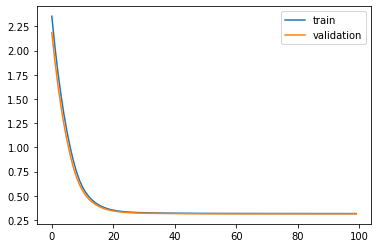

Time to train LSTM:  75.16506099700928
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.3637 - acc: 0.4822 - val_loss: 2.1845 - val_acc: 0.5256

Epoch 00001: val_loss improved from inf to 2.18451, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.0504 - acc: 0.5625 - val_loss: 1.8990 - val_acc: 0.6018

Epoch 00002: val_loss improved from 2.18451 to 1.89897, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.7827 - acc: 0.6325 - val_loss: 1.6547 - val_acc: 0.6644

Epoch 00003: val_loss improved from 1.89897 to 1.65466, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.5531 - acc: 0.6884 - val_loss: 1.4439 - val_acc: 0.7124

Epoch 00004: val_loss improved from 1.65466 to 1.44392, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3545 - acc: 0.7313 - val_loss: 1.2611 - val_acc: 0.7454

Epoch 00005: val_loss improved from 1.44392 to 1.26113, saving model to Event_val_weights2.hdf5
Epoch 6/100

 - 1s - loss: 0.3181 - acc: 0.8800 - val_loss: 0.3258 - val_acc: 0.8766

Epoch 00046: val_loss improved from 0.32590 to 0.32575, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3180 - acc: 0.8801 - val_loss: 0.3257 - val_acc: 0.8763

Epoch 00047: val_loss improved from 0.32575 to 0.32569, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3256 - val_acc: 0.8766

Epoch 00048: val_loss improved from 0.32569 to 0.32555, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3179 - acc: 0.8799 - val_loss: 0.3256 - val_acc: 0.8763

Epoch 00049: val_loss did not improve from 0.32555
Epoch 50/100
 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3254 - val_acc: 0.8762

Epoch 00050: val_loss improved from 0.32555 to 0.32539, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3253 - val_acc: 0.8766

Epoch 00051: val_loss improved from 0.32539 to 0.32532, saving

 - 1s - loss: 0.3163 - acc: 0.8800 - val_loss: 0.3240 - val_acc: 0.8757

Epoch 00098: val_loss did not improve from 0.32398
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8800 - val_loss: 0.3237 - val_acc: 0.8757

Epoch 00099: val_loss improved from 0.32398 to 0.32368, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8799 - val_loss: 0.3238 - val_acc: 0.8764

Epoch 00100: val_loss did not improve from 0.32368
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.10950520642062403
best val loss: 0.3236778086291419
#################################


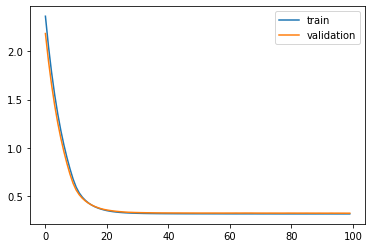

Time to train LSTM:  75.42816066741943
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.4095 - acc: 0.5509 - val_loss: 2.2007 - val_acc: 0.5984

Epoch 00001: val_loss improved from inf to 2.20070, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.0676 - acc: 0.6299 - val_loss: 1.9022 - val_acc: 0.6612

Epoch 00002: val_loss improved from 2.20070 to 1.90219, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.7897 - acc: 0.6809 - val_loss: 1.6541 - val_acc: 0.7046

Epoch 00003: val_loss improved from 1.90219 to 1.65415, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.5558 - acc: 0.7157 - val_loss: 1.4427 - val_acc: 0.7317

Epoch 00004: val_loss improved from 1.65415 to 1.44266, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3565 - acc: 0.7420 - val_loss: 1.2625 - val_acc: 0.7508

Epoch 00005: val_loss improved from 1.44266 to 1.26253, saving model to Event_val_weights3.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.32680 to 0.32670, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3178 - acc: 0.8797 - val_loss: 0.3267 - val_acc: 0.8783

Epoch 00047: val_loss did not improve from 0.32670
Epoch 48/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3267 - val_acc: 0.8783

Epoch 00048: val_loss improved from 0.32670 to 0.32667, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3267 - val_acc: 0.8781

Epoch 00049: val_loss did not improve from 0.32667
Epoch 50/100
 - 1s - loss: 0.3173 - acc: 0.8799 - val_loss: 0.3265 - val_acc: 0.8784

Epoch 00050: val_loss improved from 0.32667 to 0.32654, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3172 - acc: 0.8800 - val_loss: 0.3267 - val_acc: 0.8786

Epoch 00051: val_loss did not improve from 0.32654
Epoch 52/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3267 - val_acc: 0.8784

Epoch 00052: val_loss did not improve from

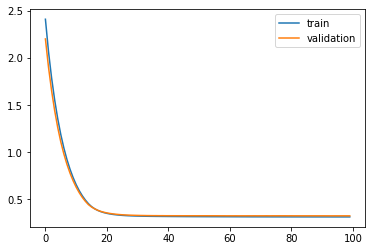

Time to train LSTM:  81.09073853492737
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.3667 - acc: 0.5722 - val_loss: 2.1722 - val_acc: 0.6259

Epoch 00001: val_loss improved from inf to 2.17218, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.0375 - acc: 0.6613 - val_loss: 1.8795 - val_acc: 0.6920

Epoch 00002: val_loss improved from 2.17218 to 1.87946, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.7653 - acc: 0.7153 - val_loss: 1.6330 - val_acc: 0.7307

Epoch 00003: val_loss improved from 1.87946 to 1.63296, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.5344 - acc: 0.7472 - val_loss: 1.4225 - val_acc: 0.7568

Epoch 00004: val_loss improved from 1.63296 to 1.42247, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3365 - acc: 0.7685 - val_loss: 1.2416 - val_acc: 0.7744

Epoch 00005: val_loss improved from 1.42247 to 1.24164, saving model to Event_val_weights4.hdf5
Epoch 6/100

 - 1s - loss: 0.3182 - acc: 0.8802 - val_loss: 0.3323 - val_acc: 0.8714

Epoch 00046: val_loss improved from 0.33267 to 0.33233, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3180 - acc: 0.8802 - val_loss: 0.3321 - val_acc: 0.8718

Epoch 00047: val_loss improved from 0.33233 to 0.33212, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3178 - acc: 0.8802 - val_loss: 0.3317 - val_acc: 0.8720

Epoch 00048: val_loss improved from 0.33212 to 0.33169, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8801 - val_loss: 0.3315 - val_acc: 0.8720

Epoch 00049: val_loss improved from 0.33169 to 0.33149, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3173 - acc: 0.8801 - val_loss: 0.3311 - val_acc: 0.8719

Epoch 00050: val_loss improved from 0.33149 to 0.33111, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3310 - val_acc: 0.8723

Epoch 00051: val_

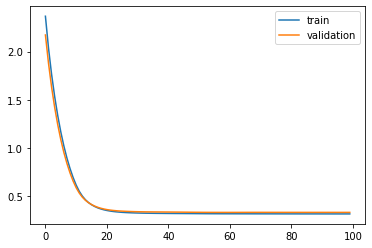

Time to train LSTM:  76.2529399394989
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.3443 - acc: 0.5672 - val_loss: 2.1581 - val_acc: 0.6114

Epoch 00001: val_loss improved from inf to 2.15813, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.0229 - acc: 0.6436 - val_loss: 1.8702 - val_acc: 0.6726

Epoch 00002: val_loss improved from 2.15813 to 1.87022, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.7579 - acc: 0.6947 - val_loss: 1.6279 - val_acc: 0.7101

Epoch 00003: val_loss improved from 1.87022 to 1.62788, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.5333 - acc: 0.7255 - val_loss: 1.4220 - val_acc: 0.7382

Epoch 00004: val_loss improved from 1.62788 to 1.42202, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3417 - acc: 0.7459 - val_loss: 1.2462 - val_acc: 0.7547

Epoch 00005: val_loss improved from 1.42202 to 1.24618, saving model to Event_val_weights5.hdf5
Epoch 6/100


 - 1s - loss: 0.3194 - acc: 0.8796 - val_loss: 0.3206 - val_acc: 0.8810

Epoch 00046: val_loss improved from 0.32074 to 0.32065, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8798 - val_loss: 0.3205 - val_acc: 0.8810

Epoch 00047: val_loss improved from 0.32065 to 0.32054, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.3204 - val_acc: 0.8800

Epoch 00048: val_loss improved from 0.32054 to 0.32040, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8798 - val_loss: 0.3203 - val_acc: 0.8802

Epoch 00049: val_loss improved from 0.32040 to 0.32028, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3202 - val_acc: 0.8796

Epoch 00050: val_loss improved from 0.32028 to 0.32019, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3201 - val_acc: 0.8801

Epoch 00051: val_

 - 1s - loss: 0.3169 - acc: 0.8795 - val_loss: 0.3187 - val_acc: 0.8796

Epoch 00097: val_loss improved from 0.31869 to 0.31866, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8793 - val_loss: 0.3187 - val_acc: 0.8801

Epoch 00098: val_loss did not improve from 0.31866
Epoch 99/100
 - 1s - loss: 0.3169 - acc: 0.8794 - val_loss: 0.3187 - val_acc: 0.8796

Epoch 00099: val_loss did not improve from 0.31866
Epoch 100/100
 - 1s - loss: 0.3169 - acc: 0.8794 - val_loss: 0.3187 - val_acc: 0.8799

Epoch 00100: val_loss did not improve from 0.31866
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.10950520642062403
best val loss: 0.3186645279460483
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.1392860151436

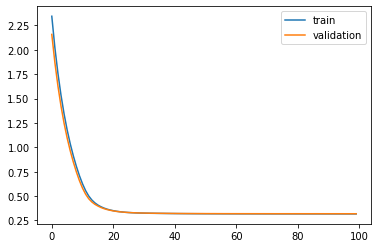

Time to train LSTM:  76.58631658554077


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe87c7e5cc0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.0896 - acc: 0.6254 - val_loss: 1.9286 - val_acc: 0.6538

Epoch 00001: val_loss improved from inf to 1.92864, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.8254 - acc: 0.6685 - val_loss: 1.6845 - val_acc: 0.6957

Epoch 00002: val_loss improved from 1.92864 to 1.68454, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.5970 - acc: 0.7025 - val_loss: 1.4738 - val_acc: 0.7267

Epoch 00003: val_loss improved from 1.68454 to 1.47378, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.3992 - acc: 0.7310 - val_loss: 1.2913 - val_acc: 0.7527

Epoch 00004: val_loss improved from 1.47378 to 1.29126, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.2277 - acc: 0.7553 - val_loss: 1.1329 - val_acc: 0.7724

Epoch 00005: val_loss improved from 1.29126 to 1.13290, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.0790 - acc: 0.7757 - v

 - 1s - loss: 0.3184 - acc: 0.8795 - val_loss: 0.3149 - val_acc: 0.8809

Epoch 00047: val_loss improved from 0.31499 to 0.31490, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8796 - val_loss: 0.3151 - val_acc: 0.8804

Epoch 00048: val_loss did not improve from 0.31490
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8794 - val_loss: 0.3149 - val_acc: 0.8817

Epoch 00049: val_loss did not improve from 0.31490
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8797 - val_loss: 0.3150 - val_acc: 0.8804

Epoch 00050: val_loss did not improve from 0.31490
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8796 - val_loss: 0.3149 - val_acc: 0.8812

Epoch 00051: val_loss did not improve from 0.31490
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8797 - val_loss: 0.3150 - val_acc: 0.8803

Epoch 00052: val_loss did not improve from 0.31490
Epoch 53/100
 - 1s - loss: 0.3181 - acc: 0.8796 - val_loss: 0.3149 - val_acc: 0.8809

Epoch 00053: val_loss improved from 0.31490 to 0.31489, savi

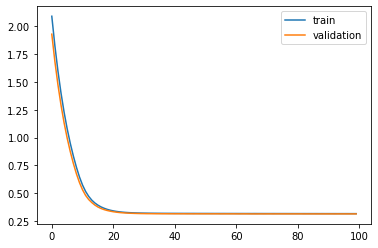

Time to train LSTM:  91.9786319732666
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 2.4581 - acc: 0.3845 - val_loss: 2.2552 - val_acc: 0.4207

Epoch 00001: val_loss improved from inf to 2.25524, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.1125 - acc: 0.4664 - val_loss: 1.9466 - val_acc: 0.5171

Epoch 00002: val_loss improved from 2.25524 to 1.94656, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.8273 - acc: 0.5604 - val_loss: 1.6910 - val_acc: 0.6057

Epoch 00003: val_loss improved from 1.94656 to 1.69098, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.5876 - acc: 0.6480 - val_loss: 1.4740 - val_acc: 0.6848

Epoch 00004: val_loss improved from 1.69098 to 1.47401, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3829 - acc: 0.7202 - val_loss: 1.2877 - val_acc: 0.7466

Epoch 00005: val_loss improved from 1.47401 to 1.28771, saving model to Event_val_weights2.hdf5
Epoch 6/100


 - 1s - loss: 0.3172 - acc: 0.8807 - val_loss: 0.3267 - val_acc: 0.8751

Epoch 00046: val_loss improved from 0.32672 to 0.32667, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3171 - acc: 0.8807 - val_loss: 0.3266 - val_acc: 0.8750

Epoch 00047: val_loss improved from 0.32667 to 0.32661, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3169 - acc: 0.8809 - val_loss: 0.3266 - val_acc: 0.8751

Epoch 00048: val_loss improved from 0.32661 to 0.32656, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3167 - acc: 0.8808 - val_loss: 0.3265 - val_acc: 0.8748

Epoch 00049: val_loss improved from 0.32656 to 0.32652, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8808 - val_loss: 0.3265 - val_acc: 0.8746

Epoch 00050: val_loss improved from 0.32652 to 0.32650, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3165 - acc: 0.8809 - val_loss: 0.3264 - val_acc: 0.8744

Epoch 00051: val_

 - 1s - loss: 0.3145 - acc: 0.8817 - val_loss: 0.3254 - val_acc: 0.8734

Epoch 00095: val_loss improved from 0.32544 to 0.32541, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3144 - acc: 0.8817 - val_loss: 0.3255 - val_acc: 0.8737

Epoch 00096: val_loss did not improve from 0.32541
Epoch 97/100
 - 1s - loss: 0.3144 - acc: 0.8818 - val_loss: 0.3254 - val_acc: 0.8736

Epoch 00097: val_loss did not improve from 0.32541
Epoch 98/100
 - 1s - loss: 0.3143 - acc: 0.8818 - val_loss: 0.3255 - val_acc: 0.8737

Epoch 00098: val_loss did not improve from 0.32541
Epoch 99/100
 - 1s - loss: 0.3144 - acc: 0.8818 - val_loss: 0.3254 - val_acc: 0.8733

Epoch 00099: val_loss improved from 0.32541 to 0.32538, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3143 - acc: 0.8818 - val_loss: 0.3255 - val_acc: 0.8734

Epoch 00100: val_loss did not improve from 0.32538
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.10298173621928

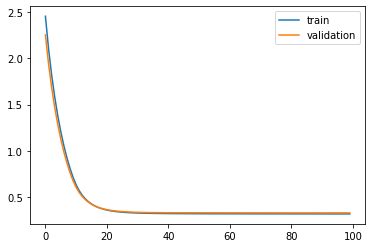

Time to train LSTM:  79.56696915626526
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 2.3795 - acc: 0.4804 - val_loss: 2.1699 - val_acc: 0.5368

Epoch 00001: val_loss improved from inf to 2.16991, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.0230 - acc: 0.5759 - val_loss: 1.8572 - val_acc: 0.6233

Epoch 00002: val_loss improved from 2.16991 to 1.85721, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.7385 - acc: 0.6568 - val_loss: 1.6043 - val_acc: 0.6908

Epoch 00003: val_loss improved from 1.85721 to 1.60425, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.5049 - acc: 0.7144 - val_loss: 1.3938 - val_acc: 0.7348

Epoch 00004: val_loss improved from 1.60425 to 1.39384, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3088 - acc: 0.7522 - val_loss: 1.2164 - val_acc: 0.7663

Epoch 00005: val_loss improved from 1.39384 to 1.21644, saving model to Event_val_weights3.hdf5
Epoch 6/100

 - 1s - loss: 0.3193 - acc: 0.8798 - val_loss: 0.3271 - val_acc: 0.8784

Epoch 00046: val_loss improved from 0.32728 to 0.32713, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8798 - val_loss: 0.3269 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.32713 to 0.32693, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8798 - val_loss: 0.3268 - val_acc: 0.8786

Epoch 00048: val_loss improved from 0.32693 to 0.32683, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8798 - val_loss: 0.3267 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32683 to 0.32669, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8798 - val_loss: 0.3266 - val_acc: 0.8788

Epoch 00050: val_loss improved from 0.32669 to 0.32664, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8798 - val_loss: 0.3266 - val_acc: 0.8784

Epoch 00051: val_

 - 1s - loss: 0.3158 - acc: 0.8804 - val_loss: 0.3249 - val_acc: 0.8782

Epoch 00095: val_loss did not improve from 0.32486
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8803 - val_loss: 0.3248 - val_acc: 0.8778

Epoch 00096: val_loss improved from 0.32486 to 0.32481, saving model to Event_val_weights3.hdf5
Epoch 97/100
 - 1s - loss: 0.3157 - acc: 0.8804 - val_loss: 0.3249 - val_acc: 0.8778

Epoch 00097: val_loss did not improve from 0.32481
Epoch 98/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3249 - val_acc: 0.8781

Epoch 00098: val_loss did not improve from 0.32481
Epoch 99/100
 - 1s - loss: 0.3158 - acc: 0.8804 - val_loss: 0.3249 - val_acc: 0.8781

Epoch 00099: val_loss did not improve from 0.32481
Epoch 100/100
 - 1s - loss: 0.3157 - acc: 0.8803 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00100: val_loss did not improve from 0.32481
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.10298173621928217
best val loss: 0.32481458343399894
######

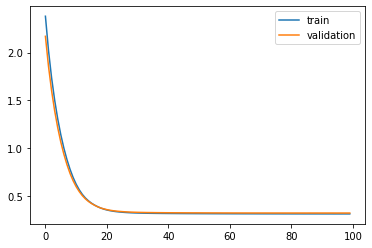

Time to train LSTM:  78.76587533950806
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 2.2268 - acc: 0.5157 - val_loss: 2.0540 - val_acc: 0.5820

Epoch 00001: val_loss improved from inf to 2.05403, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.9335 - acc: 0.6149 - val_loss: 1.7919 - val_acc: 0.6563

Epoch 00002: val_loss improved from 2.05403 to 1.79185, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.6920 - acc: 0.6811 - val_loss: 1.5729 - val_acc: 0.7014

Epoch 00003: val_loss improved from 1.79185 to 1.57291, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.4882 - acc: 0.7198 - val_loss: 1.3865 - val_acc: 0.7337

Epoch 00004: val_loss improved from 1.57291 to 1.38649, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3141 - acc: 0.7463 - val_loss: 1.2271 - val_acc: 0.7549

Epoch 00005: val_loss improved from 1.38649 to 1.22707, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3195 - acc: 0.8809 - val_loss: 0.3341 - val_acc: 0.8711

Epoch 00046: val_loss did not improve from 0.33393
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8810 - val_loss: 0.3339 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33393 to 0.33393, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8809 - val_loss: 0.3338 - val_acc: 0.8704

Epoch 00048: val_loss improved from 0.33393 to 0.33384, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8810 - val_loss: 0.3338 - val_acc: 0.8704

Epoch 00049: val_loss did not improve from 0.33384
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8810 - val_loss: 0.3339 - val_acc: 0.8703

Epoch 00050: val_loss did not improve from 0.33384
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8810 - val_loss: 0.3338 - val_acc: 0.8706

Epoch 00051: val_loss improved from 0.33384 to 0.33375, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3188 - acc: 0.8810 - val_lo


Epoch 00096: val_loss improved from 0.33173 to 0.33163, saving model to Event_val_weights4.hdf5
Epoch 97/100
 - 1s - loss: 0.3156 - acc: 0.8809 - val_loss: 0.3316 - val_acc: 0.8709

Epoch 00097: val_loss improved from 0.33163 to 0.33157, saving model to Event_val_weights4.hdf5
Epoch 98/100
 - 1s - loss: 0.3156 - acc: 0.8809 - val_loss: 0.3314 - val_acc: 0.8706

Epoch 00098: val_loss improved from 0.33157 to 0.33142, saving model to Event_val_weights4.hdf5
Epoch 99/100
 - 1s - loss: 0.3154 - acc: 0.8809 - val_loss: 0.3315 - val_acc: 0.8709

Epoch 00099: val_loss did not improve from 0.33142
Epoch 100/100
 - 1s - loss: 0.3154 - acc: 0.8808 - val_loss: 0.3313 - val_acc: 0.8703

Epoch 00100: val_loss improved from 0.33142 to 0.33128, saving model to Event_val_weights4.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.10298173621928217
best val loss: 0.33127600365214876
#################################


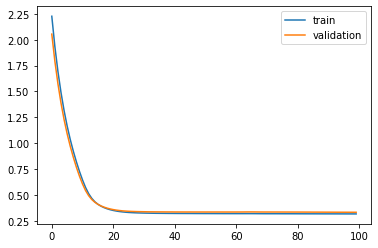

Time to train LSTM:  80.8900043964386
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 2.3112 - acc: 0.6229 - val_loss: 2.1189 - val_acc: 0.6694

Epoch 00001: val_loss improved from inf to 2.11886, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.9919 - acc: 0.6868 - val_loss: 1.8448 - val_acc: 0.7059

Epoch 00002: val_loss improved from 2.11886 to 1.84478, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.7353 - acc: 0.7198 - val_loss: 1.6071 - val_acc: 0.7344

Epoch 00003: val_loss improved from 1.84478 to 1.60711, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.5120 - acc: 0.7425 - val_loss: 1.3990 - val_acc: 0.7562

Epoch 00004: val_loss improved from 1.60711 to 1.39901, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3176 - acc: 0.7642 - val_loss: 1.2179 - val_acc: 0.7777

Epoch 00005: val_loss improved from 1.39901 to 1.21791, saving model to Event_val_weights5.hdf5
Epoch 6/100


 - 1s - loss: 0.3172 - acc: 0.8793 - val_loss: 0.3191 - val_acc: 0.8788

Epoch 00046: val_loss improved from 0.31915 to 0.31908, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3172 - acc: 0.8793 - val_loss: 0.3191 - val_acc: 0.8786

Epoch 00047: val_loss improved from 0.31908 to 0.31907, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8792 - val_loss: 0.3189 - val_acc: 0.8787

Epoch 00048: val_loss improved from 0.31907 to 0.31894, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3171 - acc: 0.8793 - val_loss: 0.3190 - val_acc: 0.8790

Epoch 00049: val_loss did not improve from 0.31894
Epoch 50/100
 - 1s - loss: 0.3170 - acc: 0.8793 - val_loss: 0.3189 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.31894 to 0.31887, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3169 - acc: 0.8792 - val_loss: 0.3189 - val_acc: 0.8789

Epoch 00051: val_loss did not improve from 0.31887
Epoch 52/10

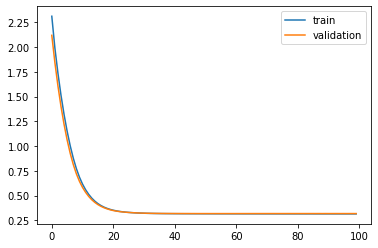

Time to train LSTM:  84.67549753189087
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 2.0997 - acc: 0.5386 - val_loss: 1.9118 - val_acc: 0.6024

Epoch 00001: val_loss improved from inf to 1.91181, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.8220 - acc: 0.6128 - val_loss: 1.6622 - val_acc: 0.6647

Epoch 00002: val_loss improved from 1.91181 to 1.66219, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.5930 - acc: 0.6648 - val_loss: 1.4558 - val_acc: 0.7050

Epoch 00003: val_loss improved from 1.66219 to 1.45585, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.4007 - acc: 0.7012 - val_loss: 1.2818 - val_acc: 0.7368

Epoch 00004: val_loss improved from 1.45585 to 1.28180, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.2371 - acc: 0.7288 - val_loss: 1.1336 - val_acc: 0.7627

Epoch 00005: val_loss improved from 1.28180 to 1.13361, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3169 - val_acc: 0.8812

Epoch 00046: val_loss improved from 0.31693 to 0.31692, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8798 - val_loss: 0.3168 - val_acc: 0.8810

Epoch 00047: val_loss improved from 0.31692 to 0.31677, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8797 - val_loss: 0.3167 - val_acc: 0.8810

Epoch 00048: val_loss improved from 0.31677 to 0.31672, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3166 - val_acc: 0.8814

Epoch 00049: val_loss improved from 0.31672 to 0.31664, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8799 - val_loss: 0.3166 - val_acc: 0.8816

Epoch 00050: val_loss improved from 0.31664 to 0.31660, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3165 - val_acc: 0.8819

Epoch 00051: val_

 - 1s - loss: 0.3157 - acc: 0.8800 - val_loss: 0.3152 - val_acc: 0.8822

Epoch 00099: val_loss did not improve from 0.31446
Epoch 100/100
 - 1s - loss: 0.3154 - acc: 0.8806 - val_loss: 0.3145 - val_acc: 0.8831

Epoch 00100: val_loss did not improve from 0.31446
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.09188074285566543
best val loss: 0.31446098234918385
#################################


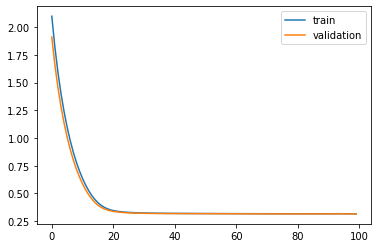

Time to train LSTM:  78.30723214149475
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 2.2427 - acc: 0.5090 - val_loss: 2.0454 - val_acc: 0.5747

Epoch 00001: val_loss improved from inf to 2.04536, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.9208 - acc: 0.6085 - val_loss: 1.7714 - val_acc: 0.6653

Epoch 00002: val_loss improved from 2.04536 to 1.77136, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.6707 - acc: 0.6875 - val_loss: 1.5539 - val_acc: 0.7168

Epoch 00003: val_loss improved from 1.77136 to 1.55394, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.4678 - acc: 0.7284 - val_loss: 1.3710 - val_acc: 0.7434

Epoch 00004: val_loss improved from 1.55394 to 1.37095, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.2953 - acc: 0.7519 - val_loss: 1.2135 - val_acc: 0.7609

Epoch 00005: val_loss improved from 1.37095 to 1.21346, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3182 - acc: 0.8800 - val_loss: 0.3276 - val_acc: 0.8734

Epoch 00046: val_loss improved from 0.32775 to 0.32757, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3181 - acc: 0.8799 - val_loss: 0.3275 - val_acc: 0.8736

Epoch 00047: val_loss improved from 0.32757 to 0.32746, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3274 - val_acc: 0.8743

Epoch 00048: val_loss improved from 0.32746 to 0.32736, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3272 - val_acc: 0.8743

Epoch 00049: val_loss improved from 0.32736 to 0.32723, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3176 - acc: 0.8797 - val_loss: 0.3271 - val_acc: 0.8746

Epoch 00050: val_loss improved from 0.32723 to 0.32710, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3269 - val_acc: 0.8749

Epoch 00051: val_

 - 1s - loss: 0.3147 - acc: 0.8804 - val_loss: 0.3256 - val_acc: 0.8756

Epoch 00100: val_loss improved from 0.32572 to 0.32558, saving model to Event_val_weights2.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.09188074285566543
best val loss: 0.3255809784465366
#################################


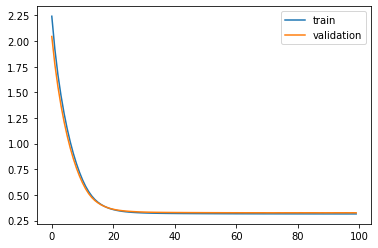

Time to train LSTM:  81.44670271873474
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 1.9902 - acc: 0.6097 - val_loss: 1.8423 - val_acc: 0.6457

Epoch 00001: val_loss improved from inf to 1.84231, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.7321 - acc: 0.6761 - val_loss: 1.6095 - val_acc: 0.7028

Epoch 00002: val_loss improved from 1.84231 to 1.60954, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.5145 - acc: 0.7222 - val_loss: 1.4122 - val_acc: 0.7334

Epoch 00003: val_loss improved from 1.60954 to 1.41222, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.3289 - acc: 0.7520 - val_loss: 1.2430 - val_acc: 0.7567

Epoch 00004: val_loss improved from 1.41222 to 1.24301, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.1695 - acc: 0.7733 - val_loss: 1.0972 - val_acc: 0.7738

Epoch 00005: val_loss improved from 1.24301 to 1.09719, saving model to Event_val_weights3.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.32745 to 0.32737, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3181 - acc: 0.8800 - val_loss: 0.3272 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.32737 to 0.32722, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3180 - acc: 0.8800 - val_loss: 0.3271 - val_acc: 0.8763

Epoch 00048: val_loss improved from 0.32722 to 0.32709, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3270 - val_acc: 0.8761

Epoch 00049: val_loss improved from 0.32709 to 0.32700, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3269 - val_acc: 0.8761

Epoch 00050: val_loss improved from 0.32700 to 0.32689, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3269 - val_acc: 0.8758

Epoch 00051: val_loss improved from 0.32689 to 0.32687, saving model to Event_val_weights


Epoch 00097: val_loss did not improve from 0.32533
Epoch 98/100
 - 1s - loss: 0.3153 - acc: 0.8804 - val_loss: 0.3254 - val_acc: 0.8771

Epoch 00098: val_loss did not improve from 0.32533
Epoch 99/100
 - 1s - loss: 0.3152 - acc: 0.8804 - val_loss: 0.3254 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32533
Epoch 100/100
 - 1s - loss: 0.3153 - acc: 0.8804 - val_loss: 0.3253 - val_acc: 0.8771

Epoch 00100: val_loss improved from 0.32533 to 0.32529, saving model to Event_val_weights3.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.09188074285566543
best val loss: 0.3252926489777035
#################################


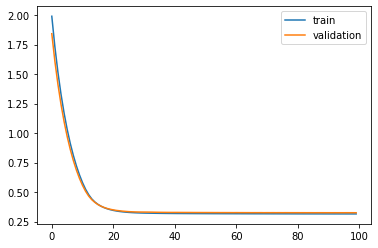

Time to train LSTM:  78.92091274261475


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe715ce2908>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 2.0879 - acc: 0.5132 - val_loss: 1.9292 - val_acc: 0.5651

Epoch 00001: val_loss improved from inf to 1.92916, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.8155 - acc: 0.6142 - val_loss: 1.6852 - val_acc: 0.6554

Epoch 00002: val_loss improved from 1.92916 to 1.68519, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.5904 - acc: 0.6814 - val_loss: 1.4800 - val_acc: 0.7089

Epoch 00003: val_loss improved from 1.68519 to 1.48001, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.3991 - acc: 0.7215 - val_loss: 1.3039 - val_acc: 0.7394

Epoch 00004: val_loss improved from 1.48001 to 1.30385, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.2337 - acc: 0.7482 - val_loss: 1.1511 - val_acc: 0.7612

Epoch 00005: val_loss improved from 1.30385 to 1.15108, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0897 - acc: 0.7678 - v

 - 1s - loss: 0.3171 - acc: 0.8803 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00046: val_loss improved from 0.33219 to 0.33204, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3170 - acc: 0.8804 - val_loss: 0.3319 - val_acc: 0.8708

Epoch 00047: val_loss improved from 0.33204 to 0.33193, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3169 - acc: 0.8803 - val_loss: 0.3319 - val_acc: 0.8707

Epoch 00048: val_loss improved from 0.33193 to 0.33191, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3168 - acc: 0.8804 - val_loss: 0.3319 - val_acc: 0.8709

Epoch 00049: val_loss improved from 0.33191 to 0.33190, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3168 - acc: 0.8802 - val_loss: 0.3320 - val_acc: 0.8706

Epoch 00050: val_loss did not improve from 0.33190
Epoch 51/100
 - 1s - loss: 0.3166 - acc: 0.8804 - val_loss: 0.3317 - val_acc: 0.8710

Epoch 00051: val_loss improved from 0.33190 to 0.33171, saving

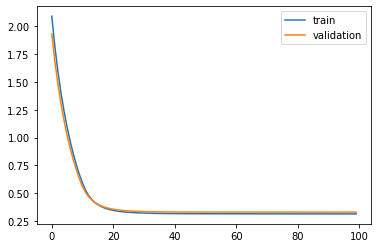

Time to train LSTM:  90.94285321235657
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 2.0913 - acc: 0.5582 - val_loss: 1.9237 - val_acc: 0.6202

Epoch 00001: val_loss improved from inf to 1.92373, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.8169 - acc: 0.6474 - val_loss: 1.6782 - val_acc: 0.6863

Epoch 00002: val_loss improved from 1.92373 to 1.67820, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.5886 - acc: 0.7013 - val_loss: 1.4703 - val_acc: 0.7290

Epoch 00003: val_loss improved from 1.67820 to 1.47027, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.3930 - acc: 0.7347 - val_loss: 1.2895 - val_acc: 0.7523

Epoch 00004: val_loss improved from 1.47027 to 1.28953, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.2225 - acc: 0.7590 - val_loss: 1.1312 - val_acc: 0.7747

Epoch 00005: val_loss improved from 1.28953 to 1.13118, saving model to Event_val_weights5.hdf5
Epoch 6/100

 - 1s - loss: 0.3199 - acc: 0.8791 - val_loss: 0.3247 - val_acc: 0.8772

Epoch 00046: val_loss improved from 0.32475 to 0.32469, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8791 - val_loss: 0.3245 - val_acc: 0.8771

Epoch 00047: val_loss improved from 0.32469 to 0.32451, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8769

Epoch 00048: val_loss did not improve from 0.32451
Epoch 49/100
 - 1s - loss: 0.3194 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32451 to 0.32429, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3193 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8771

Epoch 00050: val_loss did not improve from 0.32429
Epoch 51/100
 - 1s - loss: 0.3192 - acc: 0.8791 - val_loss: 0.3241 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32429 to 0.32413, saving model to Event_val_weights5.hdf5
Epoch 52/10

 - 1s - loss: 0.3156 - acc: 0.8807 - val_loss: 0.3213 - val_acc: 0.8788

Epoch 00096: val_loss did not improve from 0.32122
Epoch 97/100
 - 1s - loss: 0.3156 - acc: 0.8805 - val_loss: 0.3212 - val_acc: 0.8787

Epoch 00097: val_loss improved from 0.32122 to 0.32118, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3156 - acc: 0.8806 - val_loss: 0.3212 - val_acc: 0.8787

Epoch 00098: val_loss did not improve from 0.32118
Epoch 99/100
 - 1s - loss: 0.3156 - acc: 0.8806 - val_loss: 0.3212 - val_acc: 0.8787

Epoch 00099: val_loss improved from 0.32118 to 0.32117, saving model to Event_val_weights5.hdf5
Epoch 100/100
 - 1s - loss: 0.3155 - acc: 0.8806 - val_loss: 0.3211 - val_acc: 0.8791

Epoch 00100: val_loss improved from 0.32117 to 0.32115, saving model to Event_val_weights5.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.09188074285566543
best val loss: 0.3211494630177816
#################################
[[8, 8192, 0.1392860

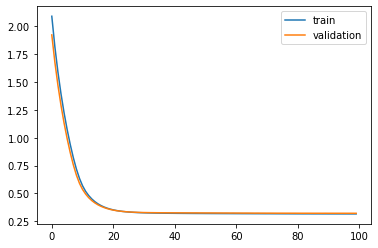

Time to train LSTM:  82.36811113357544
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 1.8974 - acc: 0.5838 - val_loss: 1.7601 - val_acc: 0.6278

Epoch 00001: val_loss improved from inf to 1.76010, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.6706 - acc: 0.6445 - val_loss: 1.5478 - val_acc: 0.6818

Epoch 00002: val_loss improved from 1.76010 to 1.54776, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.4703 - acc: 0.6915 - val_loss: 1.3606 - val_acc: 0.7211

Epoch 00003: val_loss improved from 1.54776 to 1.36064, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.2933 - acc: 0.7265 - val_loss: 1.1954 - val_acc: 0.7523

Epoch 00004: val_loss improved from 1.36064 to 1.19544, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.1360 - acc: 0.7533 - val_loss: 1.0489 - val_acc: 0.7741

Epoch 00005: val_loss improved from 1.19544 to 1.04890, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3136 - val_acc: 0.8812

Epoch 00046: val_loss improved from 0.31368 to 0.31360, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3136 - val_acc: 0.8813

Epoch 00047: val_loss improved from 0.31360 to 0.31355, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8788 - val_loss: 0.3135 - val_acc: 0.8816

Epoch 00048: val_loss improved from 0.31355 to 0.31346, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3134 - val_acc: 0.8810

Epoch 00049: val_loss improved from 0.31346 to 0.31340, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8788 - val_loss: 0.3134 - val_acc: 0.8809

Epoch 00050: val_loss improved from 0.31340 to 0.31337, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3133 - val_acc: 0.8808

Epoch 00051: val_

 - 1s - loss: 0.3171 - acc: 0.8789 - val_loss: 0.3120 - val_acc: 0.8807

Epoch 00098: val_loss did not improve from 0.31194
Epoch 99/100
 - 1s - loss: 0.3171 - acc: 0.8788 - val_loss: 0.3122 - val_acc: 0.8803

Epoch 00099: val_loss did not improve from 0.31194
Epoch 100/100
 - 1s - loss: 0.3171 - acc: 0.8787 - val_loss: 0.3120 - val_acc: 0.8804

Epoch 00100: val_loss did not improve from 0.31194
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.08354078492733293
best val loss: 0.31194304384125604
#################################


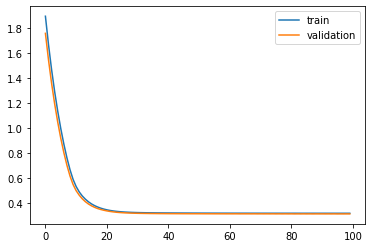

Time to train LSTM:  81.99621677398682
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 2.0747 - acc: 0.4449 - val_loss: 1.9051 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 1.90512, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.7832 - acc: 0.5490 - val_loss: 1.6490 - val_acc: 0.6054

Epoch 00002: val_loss improved from 1.90512 to 1.64904, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.5505 - acc: 0.6519 - val_loss: 1.4425 - val_acc: 0.6897

Epoch 00003: val_loss improved from 1.64904 to 1.44253, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.3600 - acc: 0.7151 - val_loss: 1.2708 - val_acc: 0.7296

Epoch 00004: val_loss improved from 1.44253 to 1.27084, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.1998 - acc: 0.7500 - val_loss: 1.1246 - val_acc: 0.7564

Epoch 00005: val_loss improved from 1.27084 to 1.12456, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3178 - acc: 0.8806 - val_loss: 0.3260 - val_acc: 0.8760

Epoch 00046: val_loss improved from 0.32617 to 0.32597, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3177 - acc: 0.8805 - val_loss: 0.3258 - val_acc: 0.8764

Epoch 00047: val_loss improved from 0.32597 to 0.32581, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3174 - acc: 0.8805 - val_loss: 0.3258 - val_acc: 0.8756

Epoch 00048: val_loss improved from 0.32581 to 0.32576, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3173 - acc: 0.8806 - val_loss: 0.3255 - val_acc: 0.8757

Epoch 00049: val_loss improved from 0.32576 to 0.32554, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3171 - acc: 0.8807 - val_loss: 0.3255 - val_acc: 0.8752

Epoch 00050: val_loss improved from 0.32554 to 0.32546, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3169 - acc: 0.8807 - val_loss: 0.3253 - val_acc: 0.8756

Epoch 00051: val_

 - 1s - loss: 0.3146 - acc: 0.8812 - val_loss: 0.3240 - val_acc: 0.8742

Epoch 00097: val_loss did not improve from 0.32386
Epoch 98/100
 - 1s - loss: 0.3145 - acc: 0.8812 - val_loss: 0.3239 - val_acc: 0.8741

Epoch 00098: val_loss did not improve from 0.32386
Epoch 99/100
 - 1s - loss: 0.3144 - acc: 0.8812 - val_loss: 0.3239 - val_acc: 0.8741

Epoch 00099: val_loss did not improve from 0.32386
Epoch 100/100
 - 1s - loss: 0.3145 - acc: 0.8811 - val_loss: 0.3239 - val_acc: 0.8740

Epoch 00100: val_loss did not improve from 0.32386
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.08354078492733293
best val loss: 0.32385602786805895
#################################


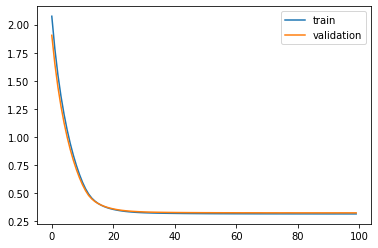

Time to train LSTM:  80.59009432792664
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 2.1415 - acc: 0.5018 - val_loss: 1.9242 - val_acc: 0.5777

Epoch 00001: val_loss improved from inf to 1.92416, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.7972 - acc: 0.6302 - val_loss: 1.6607 - val_acc: 0.6723

Epoch 00002: val_loss improved from 1.92416 to 1.66067, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.5688 - acc: 0.6985 - val_loss: 1.4659 - val_acc: 0.7092

Epoch 00003: val_loss improved from 1.66067 to 1.46592, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.3853 - acc: 0.7318 - val_loss: 1.2974 - val_acc: 0.7421

Epoch 00004: val_loss improved from 1.46592 to 1.29742, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.2252 - acc: 0.7573 - val_loss: 1.1500 - val_acc: 0.7649

Epoch 00005: val_loss improved from 1.29742 to 1.14999, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3180 - acc: 0.8803 - val_loss: 0.3262 - val_acc: 0.8762

Epoch 00046: val_loss improved from 0.32640 to 0.32625, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3179 - acc: 0.8802 - val_loss: 0.3262 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.32625 to 0.32618, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3178 - acc: 0.8802 - val_loss: 0.3261 - val_acc: 0.8761

Epoch 00048: val_loss improved from 0.32618 to 0.32609, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8802 - val_loss: 0.3260 - val_acc: 0.8760

Epoch 00049: val_loss improved from 0.32609 to 0.32602, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3175 - acc: 0.8803 - val_loss: 0.3259 - val_acc: 0.8760

Epoch 00050: val_loss improved from 0.32602 to 0.32595, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3174 - acc: 0.8803 - val_loss: 0.3259 - val_acc: 0.8759

Epoch 00051: val_

 - 1s - loss: 0.3154 - acc: 0.8805 - val_loss: 0.3238 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32395 to 0.32383, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3154 - acc: 0.8805 - val_loss: 0.3239 - val_acc: 0.8766

Epoch 00096: val_loss did not improve from 0.32383
Epoch 97/100
 - 1s - loss: 0.3154 - acc: 0.8806 - val_loss: 0.3239 - val_acc: 0.8762

Epoch 00097: val_loss did not improve from 0.32383
Epoch 98/100
 - 1s - loss: 0.3154 - acc: 0.8806 - val_loss: 0.3239 - val_acc: 0.8764

Epoch 00098: val_loss did not improve from 0.32383
Epoch 99/100
 - 1s - loss: 0.3153 - acc: 0.8806 - val_loss: 0.3239 - val_acc: 0.8762

Epoch 00099: val_loss did not improve from 0.32383
Epoch 100/100
 - 1s - loss: 0.3153 - acc: 0.8807 - val_loss: 0.3239 - val_acc: 0.8764

Epoch 00100: val_loss did not improve from 0.32383
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.08354078492733293
best val loss: 0.3238264745341407
#######

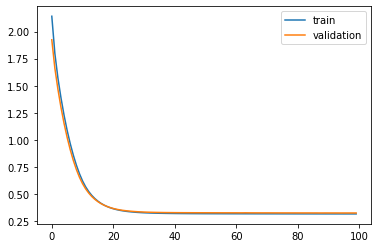

Time to train LSTM:  80.99587607383728
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 1.8881 - acc: 0.5918 - val_loss: 1.7430 - val_acc: 0.6430

Epoch 00001: val_loss improved from inf to 1.74304, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.6454 - acc: 0.6648 - val_loss: 1.5279 - val_acc: 0.6922

Epoch 00002: val_loss improved from 1.74304 to 1.52792, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.4448 - acc: 0.7046 - val_loss: 1.3449 - val_acc: 0.7238

Epoch 00003: val_loss improved from 1.52792 to 1.34491, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.2735 - acc: 0.7304 - val_loss: 1.1879 - val_acc: 0.7431

Epoch 00004: val_loss improved from 1.34491 to 1.18785, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.1259 - acc: 0.7511 - val_loss: 1.0526 - val_acc: 0.7623

Epoch 00005: val_loss improved from 1.18785 to 1.05257, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3172 - acc: 0.8806 - val_loss: 0.3328 - val_acc: 0.8710

Epoch 00046: val_loss improved from 0.33283 to 0.33279, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3171 - acc: 0.8807 - val_loss: 0.3328 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33279 to 0.33275, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3170 - acc: 0.8807 - val_loss: 0.3327 - val_acc: 0.8711

Epoch 00048: val_loss improved from 0.33275 to 0.33274, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3168 - acc: 0.8806 - val_loss: 0.3327 - val_acc: 0.8718

Epoch 00049: val_loss improved from 0.33274 to 0.33269, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8807 - val_loss: 0.3327 - val_acc: 0.8720

Epoch 00050: val_loss did not improve from 0.33269
Epoch 51/100
 - 1s - loss: 0.3166 - acc: 0.8809 - val_loss: 0.3327 - val_acc: 0.8719

Epoch 00051: val_loss improved from 0.33269 to 0.33269, saving

 - 1s - loss: 0.3139 - acc: 0.8810 - val_loss: 0.3318 - val_acc: 0.8699

Epoch 00097: val_loss did not improve from 0.33176
Epoch 98/100
 - 1s - loss: 0.3139 - acc: 0.8810 - val_loss: 0.3317 - val_acc: 0.8697

Epoch 00098: val_loss improved from 0.33176 to 0.33167, saving model to Event_val_weights4.hdf5
Epoch 99/100
 - 1s - loss: 0.3138 - acc: 0.8811 - val_loss: 0.3319 - val_acc: 0.8698

Epoch 00099: val_loss did not improve from 0.33167
Epoch 100/100
 - 1s - loss: 0.3138 - acc: 0.8810 - val_loss: 0.3318 - val_acc: 0.8694

Epoch 00100: val_loss did not improve from 0.33167
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.08354078492733293
best val loss: 0.3316700728469425
#################################


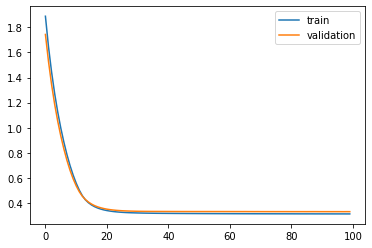

Time to train LSTM:  81.18512034416199
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 2.0117 - acc: 0.5002 - val_loss: 1.8543 - val_acc: 0.5541

Epoch 00001: val_loss improved from inf to 1.85433, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.7426 - acc: 0.5995 - val_loss: 1.6159 - val_acc: 0.6418

Epoch 00002: val_loss improved from 1.85433 to 1.61592, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.5252 - acc: 0.6708 - val_loss: 1.4187 - val_acc: 0.6972

Epoch 00003: val_loss improved from 1.61592 to 1.41874, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.3417 - acc: 0.7145 - val_loss: 1.2502 - val_acc: 0.7313

Epoch 00004: val_loss improved from 1.41874 to 1.25016, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.1838 - acc: 0.7440 - val_loss: 1.1043 - val_acc: 0.7569

Epoch 00005: val_loss improved from 1.25016 to 1.10428, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3204 - val_acc: 0.8793

Epoch 00046: val_loss improved from 0.32053 to 0.32039, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3179 - acc: 0.8799 - val_loss: 0.3202 - val_acc: 0.8797

Epoch 00047: val_loss improved from 0.32039 to 0.32017, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3203 - val_acc: 0.8792

Epoch 00048: val_loss did not improve from 0.32017
Epoch 49/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3201 - val_acc: 0.8794

Epoch 00049: val_loss improved from 0.32017 to 0.32014, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3201 - val_acc: 0.8799

Epoch 00050: val_loss improved from 0.32014 to 0.32006, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3202 - val_acc: 0.8797

Epoch 00051: val_loss did not improve from 0.32006
Epoch 52/10

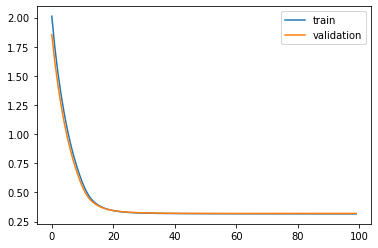

Time to train LSTM:  80.58687567710876
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 2.4798 - acc: 0.4852 - val_loss: 2.2981 - val_acc: 0.5180

Epoch 00001: val_loss improved from inf to 2.29812, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.1526 - acc: 0.5641 - val_loss: 1.9957 - val_acc: 0.6038

Epoch 00002: val_loss improved from 2.29812 to 1.99569, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.8745 - acc: 0.6407 - val_loss: 1.7357 - val_acc: 0.6778

Epoch 00003: val_loss improved from 1.99569 to 1.73570, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.6331 - acc: 0.6974 - val_loss: 1.5085 - val_acc: 0.7263

Epoch 00004: val_loss improved from 1.73570 to 1.50847, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4213 - acc: 0.7337 - val_loss: 1.3100 - val_acc: 0.7524

Epoch 00005: val_loss improved from 1.50847 to 1.31003, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31600 to 0.31569, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3199 - acc: 0.8793 - val_loss: 0.3159 - val_acc: 0.8809

Epoch 00047: val_loss did not improve from 0.31569
Epoch 48/100
 - 1s - loss: 0.3198 - acc: 0.8795 - val_loss: 0.3158 - val_acc: 0.8807

Epoch 00048: val_loss did not improve from 0.31569
Epoch 49/100
 - 1s - loss: 0.3197 - acc: 0.8794 - val_loss: 0.3154 - val_acc: 0.8810

Epoch 00049: val_loss improved from 0.31569 to 0.31538, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8793 - val_loss: 0.3155 - val_acc: 0.8810

Epoch 00050: val_loss did not improve from 0.31538
Epoch 51/100
 - 1s - loss: 0.3195 - acc: 0.8793 - val_loss: 0.3154 - val_acc: 0.8810

Epoch 00051: val_loss did not improve from 0.31538
Epoch 52/100
 - 1s - loss: 0.3193 - acc: 0.8792 - val_loss: 0.3153 - val_acc: 0.8809

Epoch 00052: val_loss improved from 0.31538 to 0.31531, saving model to Event_val_weigh

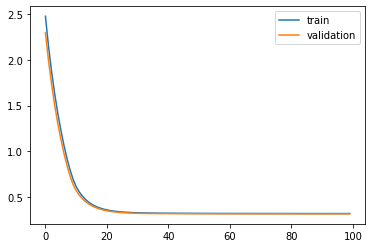

Time to train LSTM:  81.20303869247437
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 2.3178 - acc: 0.5181 - val_loss: 2.1241 - val_acc: 0.5789

Epoch 00001: val_loss improved from inf to 2.12414, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.9858 - acc: 0.6251 - val_loss: 1.8338 - val_acc: 0.6738

Epoch 00002: val_loss improved from 2.12414 to 1.83385, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.7207 - acc: 0.6942 - val_loss: 1.5980 - val_acc: 0.7130

Epoch 00003: val_loss improved from 1.83385 to 1.59797, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.5017 - acc: 0.7275 - val_loss: 1.3997 - val_acc: 0.7344

Epoch 00004: val_loss improved from 1.59797 to 1.39967, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3156 - acc: 0.7458 - val_loss: 1.2298 - val_acc: 0.7482

Epoch 00005: val_loss improved from 1.39967 to 1.22975, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3218 - acc: 0.8792 - val_loss: 0.3297 - val_acc: 0.8733

Epoch 00046: val_loss improved from 0.32984 to 0.32968, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3216 - acc: 0.8793 - val_loss: 0.3296 - val_acc: 0.8731

Epoch 00047: val_loss improved from 0.32968 to 0.32959, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3214 - acc: 0.8794 - val_loss: 0.3295 - val_acc: 0.8728

Epoch 00048: val_loss improved from 0.32959 to 0.32949, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3212 - acc: 0.8796 - val_loss: 0.3294 - val_acc: 0.8723

Epoch 00049: val_loss improved from 0.32949 to 0.32942, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3211 - acc: 0.8794 - val_loss: 0.3293 - val_acc: 0.8726

Epoch 00050: val_loss improved from 0.32942 to 0.32932, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3209 - acc: 0.8795 - val_loss: 0.3293 - val_acc: 0.8723

Epoch 00051: val_

 - 1s - loss: 0.3163 - acc: 0.8802 - val_loss: 0.3247 - val_acc: 0.8739

Epoch 00095: val_loss did not improve from 0.32465
Epoch 96/100
 - 1s - loss: 0.3161 - acc: 0.8803 - val_loss: 0.3245 - val_acc: 0.8741

Epoch 00096: val_loss improved from 0.32465 to 0.32450, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3161 - acc: 0.8803 - val_loss: 0.3246 - val_acc: 0.8739

Epoch 00097: val_loss did not improve from 0.32450
Epoch 98/100
 - 1s - loss: 0.3161 - acc: 0.8803 - val_loss: 0.3245 - val_acc: 0.8739

Epoch 00098: val_loss improved from 0.32450 to 0.32449, saving model to Event_val_weights2.hdf5
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8804 - val_loss: 0.3245 - val_acc: 0.8738

Epoch 00099: val_loss improved from 0.32449 to 0.32449, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8804 - val_loss: 0.3244 - val_acc: 0.8737

Epoch 00100: val_loss improved from 0.32449 to 0.32441, saving model to Event_val_weights2.hdf5
##########

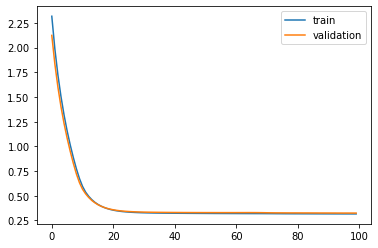

Time to train LSTM:  88.03579711914062
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 2.4295 - acc: 0.5327 - val_loss: 2.2266 - val_acc: 0.5910

Epoch 00001: val_loss improved from inf to 2.22662, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.0903 - acc: 0.6290 - val_loss: 1.9254 - val_acc: 0.6656

Epoch 00002: val_loss improved from 2.22662 to 1.92535, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.8108 - acc: 0.6870 - val_loss: 1.6728 - val_acc: 0.7084

Epoch 00003: val_loss improved from 1.92535 to 1.67283, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.5748 - acc: 0.7207 - val_loss: 1.4579 - val_acc: 0.7328

Epoch 00004: val_loss improved from 1.67283 to 1.45786, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3731 - acc: 0.7452 - val_loss: 1.2735 - val_acc: 0.7530

Epoch 00005: val_loss improved from 1.45786 to 1.27354, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3181 - acc: 0.8792 - val_loss: 0.3272 - val_acc: 0.8761

Epoch 00046: val_loss did not improve from 0.32714
Epoch 47/100
 - 1s - loss: 0.3180 - acc: 0.8790 - val_loss: 0.3270 - val_acc: 0.8763

Epoch 00047: val_loss improved from 0.32714 to 0.32700, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8791 - val_loss: 0.3269 - val_acc: 0.8766

Epoch 00048: val_loss improved from 0.32700 to 0.32692, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3269 - val_acc: 0.8767

Epoch 00049: val_loss improved from 0.32692 to 0.32685, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3268 - val_acc: 0.8764

Epoch 00050: val_loss improved from 0.32685 to 0.32683, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3267 - val_acc: 0.8767

Epoch 00051: val_loss improved from 0.32683 to 0.32673, saving

 - 1s - loss: 0.3154 - acc: 0.8798 - val_loss: 0.3251 - val_acc: 0.8768

Epoch 00096: val_loss did not improve from 0.32498
Epoch 97/100
 - 1s - loss: 0.3154 - acc: 0.8799 - val_loss: 0.3250 - val_acc: 0.8769

Epoch 00097: val_loss did not improve from 0.32498
Epoch 98/100
 - 1s - loss: 0.3154 - acc: 0.8799 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00098: val_loss did not improve from 0.32498
Epoch 99/100
 - 1s - loss: 0.3154 - acc: 0.8799 - val_loss: 0.3250 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32498
Epoch 100/100
 - 1s - loss: 0.3154 - acc: 0.8799 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00100: val_loss did not improve from 0.32498
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.11225194321960902
best val loss: 0.32498149090343054
#################################


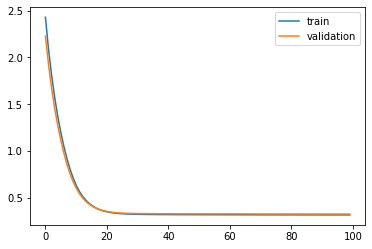

Time to train LSTM:  95.22188305854797


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe6e6730978>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 2.2950 - acc: 0.5940 - val_loss: 2.1179 - val_acc: 0.6423

Epoch 00001: val_loss improved from inf to 2.11791, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.9985 - acc: 0.6656 - val_loss: 1.8473 - val_acc: 0.6946

Epoch 00002: val_loss improved from 2.11791 to 1.84727, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.7447 - acc: 0.7063 - val_loss: 1.6150 - val_acc: 0.7249

Epoch 00003: val_loss improved from 1.84727 to 1.61504, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.5263 - acc: 0.7348 - val_loss: 1.4148 - val_acc: 0.7499

Epoch 00004: val_loss improved from 1.61504 to 1.41479, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3378 - acc: 0.7571 - val_loss: 1.2415 - val_acc: 0.7707

Epoch 00005: val_loss improved from 1.41479 to 1.24153, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.1743 - acc: 0.7770 - 

 - 1s - loss: 0.3188 - acc: 0.8808 - val_loss: 0.3330 - val_acc: 0.8728

Epoch 00046: val_loss did not improve from 0.33296
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8807 - val_loss: 0.3328 - val_acc: 0.8732

Epoch 00047: val_loss improved from 0.33296 to 0.33283, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8807 - val_loss: 0.3329 - val_acc: 0.8733

Epoch 00048: val_loss did not improve from 0.33283
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8807 - val_loss: 0.3327 - val_acc: 0.8733

Epoch 00049: val_loss improved from 0.33283 to 0.33274, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8809 - val_loss: 0.3327 - val_acc: 0.8730

Epoch 00050: val_loss improved from 0.33274 to 0.33272, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8809 - val_loss: 0.3326 - val_acc: 0.8731

Epoch 00051: val_loss improved from 0.33272 to 0.33262, saving model to Event_val_weights4.hdf5
Epoch 52/10

 - 1s - loss: 0.3146 - acc: 0.8812 - val_loss: 0.3314 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.33073
Epoch 98/100
 - 1s - loss: 0.3145 - acc: 0.8811 - val_loss: 0.3315 - val_acc: 0.8711

Epoch 00098: val_loss did not improve from 0.33073
Epoch 99/100
 - 1s - loss: 0.3145 - acc: 0.8809 - val_loss: 0.3315 - val_acc: 0.8712

Epoch 00099: val_loss did not improve from 0.33073
Epoch 100/100
 - 1s - loss: 0.3144 - acc: 0.8811 - val_loss: 0.3316 - val_acc: 0.8712

Epoch 00100: val_loss did not improve from 0.33073
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.11225194321960902
best val loss: 0.33073076036241317
#################################


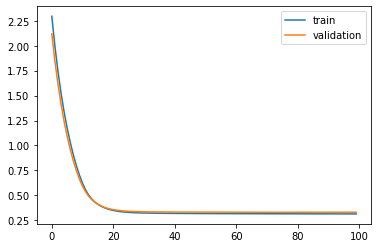

Time to train LSTM:  104.24241256713867
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 2.3412 - acc: 0.4959 - val_loss: 2.1677 - val_acc: 0.5288

Epoch 00001: val_loss improved from inf to 2.16772, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.0473 - acc: 0.5589 - val_loss: 1.8969 - val_acc: 0.5991

Epoch 00002: val_loss improved from 2.16772 to 1.89692, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.7927 - acc: 0.6278 - val_loss: 1.6626 - val_acc: 0.6684

Epoch 00003: val_loss improved from 1.89692 to 1.66258, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.5725 - acc: 0.6891 - val_loss: 1.4597 - val_acc: 0.7186

Epoch 00004: val_loss improved from 1.66258 to 1.45968, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3817 - acc: 0.7315 - val_loss: 1.2837 - val_acc: 0.7494

Epoch 00005: val_loss improved from 1.45968 to 1.28374, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3223 - acc: 0.8786 - val_loss: 0.3229 - val_acc: 0.8783

Epoch 00046: val_loss improved from 0.32318 to 0.32291, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3221 - acc: 0.8788 - val_loss: 0.3228 - val_acc: 0.8787

Epoch 00047: val_loss improved from 0.32291 to 0.32279, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3219 - acc: 0.8787 - val_loss: 0.3226 - val_acc: 0.8781

Epoch 00048: val_loss improved from 0.32279 to 0.32257, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3217 - acc: 0.8788 - val_loss: 0.3224 - val_acc: 0.8782

Epoch 00049: val_loss improved from 0.32257 to 0.32241, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3215 - acc: 0.8788 - val_loss: 0.3222 - val_acc: 0.8783

Epoch 00050: val_loss improved from 0.32241 to 0.32223, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3213 - acc: 0.8788 - val_loss: 0.3221 - val_acc: 0.8780

Epoch 00051: val_


Epoch 00096: val_loss did not improve from 0.32030
Epoch 97/100
 - 1s - loss: 0.3178 - acc: 0.8796 - val_loss: 0.3206 - val_acc: 0.8782

Epoch 00097: val_loss did not improve from 0.32030
Epoch 98/100
 - 1s - loss: 0.3178 - acc: 0.8796 - val_loss: 0.3205 - val_acc: 0.8782

Epoch 00098: val_loss did not improve from 0.32030
Epoch 99/100
 - 1s - loss: 0.3178 - acc: 0.8794 - val_loss: 0.3206 - val_acc: 0.8787

Epoch 00099: val_loss did not improve from 0.32030
Epoch 100/100
 - 1s - loss: 0.3177 - acc: 0.8795 - val_loss: 0.3206 - val_acc: 0.8786

Epoch 00100: val_loss did not improve from 0.32030
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.11225194321960902
best val loss: 0.3203009955618117
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8

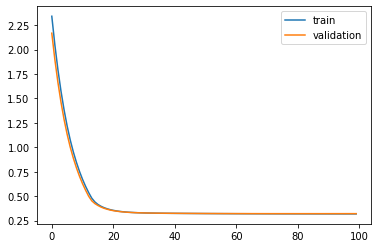

Time to train LSTM:  94.87179851531982
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 2.1442 - acc: 0.5538 - val_loss: 1.9807 - val_acc: 0.5992

Epoch 00001: val_loss improved from inf to 1.98073, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.8748 - acc: 0.6208 - val_loss: 1.7297 - val_acc: 0.6622

Epoch 00002: val_loss improved from 1.98073 to 1.72972, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.6410 - acc: 0.6683 - val_loss: 1.5124 - val_acc: 0.7076

Epoch 00003: val_loss improved from 1.72972 to 1.51240, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.4377 - acc: 0.7045 - val_loss: 1.3242 - val_acc: 0.7338

Epoch 00004: val_loss improved from 1.51240 to 1.32423, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.2605 - acc: 0.7361 - val_loss: 1.1603 - val_acc: 0.7614

Epoch 00005: val_loss improved from 1.32423 to 1.16026, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3198 - acc: 0.8790 - val_loss: 0.3174 - val_acc: 0.8794

Epoch 00046: val_loss improved from 0.31745 to 0.31736, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3196 - acc: 0.8789 - val_loss: 0.3172 - val_acc: 0.8800

Epoch 00047: val_loss improved from 0.31736 to 0.31724, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3170 - val_acc: 0.8798

Epoch 00048: val_loss improved from 0.31724 to 0.31698, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3171 - val_acc: 0.8797

Epoch 00049: val_loss did not improve from 0.31698
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8787 - val_loss: 0.3169 - val_acc: 0.8797

Epoch 00050: val_loss improved from 0.31698 to 0.31687, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8785 - val_loss: 0.3168 - val_acc: 0.8800

Epoch 00051: val_loss improved from 0.31687 to 0.31682, saving

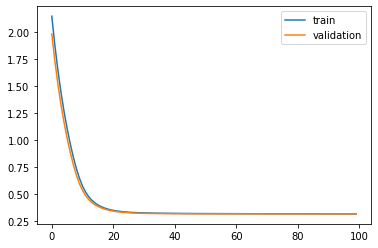

Time to train LSTM:  91.4831051826477
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 2.1669 - acc: 0.5078 - val_loss: 1.9996 - val_acc: 0.5710

Epoch 00001: val_loss improved from inf to 1.99960, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.8686 - acc: 0.6198 - val_loss: 1.7406 - val_acc: 0.6586

Epoch 00002: val_loss improved from 1.99960 to 1.74064, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.6345 - acc: 0.6809 - val_loss: 1.5302 - val_acc: 0.7003

Epoch 00003: val_loss improved from 1.74064 to 1.53023, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.4390 - acc: 0.7137 - val_loss: 1.3514 - val_acc: 0.7237

Epoch 00004: val_loss improved from 1.53023 to 1.35144, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.2717 - acc: 0.7352 - val_loss: 1.1984 - val_acc: 0.7407

Epoch 00005: val_loss improved from 1.35144 to 1.19844, saving model to Event_val_weights2.hdf5
Epoch 6/100

 - 1s - loss: 0.3181 - acc: 0.8800 - val_loss: 0.3271 - val_acc: 0.8750

Epoch 00046: val_loss did not improve from 0.32701
Epoch 47/100
 - 1s - loss: 0.3180 - acc: 0.8800 - val_loss: 0.3269 - val_acc: 0.8753

Epoch 00047: val_loss improved from 0.32701 to 0.32693, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3268 - val_acc: 0.8757

Epoch 00048: val_loss improved from 0.32693 to 0.32683, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3177 - acc: 0.8800 - val_loss: 0.3270 - val_acc: 0.8752

Epoch 00049: val_loss did not improve from 0.32683
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8800 - val_loss: 0.3268 - val_acc: 0.8754

Epoch 00050: val_loss did not improve from 0.32683
Epoch 51/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3268 - val_acc: 0.8752

Epoch 00051: val_loss improved from 0.32683 to 0.32677, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3174 - acc: 0.8801 - val_lo

 - 1s - loss: 0.3149 - acc: 0.8807 - val_loss: 0.3245 - val_acc: 0.8740

Epoch 00098: val_loss did not improve from 0.32437
Epoch 99/100
 - 1s - loss: 0.3149 - acc: 0.8807 - val_loss: 0.3244 - val_acc: 0.8741

Epoch 00099: val_loss improved from 0.32437 to 0.32435, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3149 - acc: 0.8807 - val_loss: 0.3244 - val_acc: 0.8744

Epoch 00100: val_loss did not improve from 0.32435
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.09381414261088741
best val loss: 0.3243529957400428
#################################


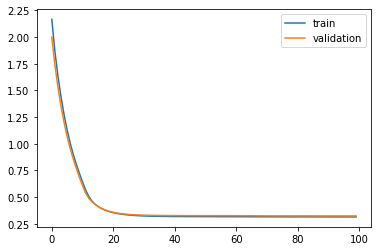

Time to train LSTM:  84.45395135879517
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 2.0392 - acc: 0.5806 - val_loss: 1.8776 - val_acc: 0.6279

Epoch 00001: val_loss improved from inf to 1.87761, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.7630 - acc: 0.6678 - val_loss: 1.6311 - val_acc: 0.6983

Epoch 00002: val_loss improved from 1.87761 to 1.63112, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.5345 - acc: 0.7226 - val_loss: 1.4256 - val_acc: 0.7368

Epoch 00003: val_loss improved from 1.63112 to 1.42563, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.3430 - acc: 0.7508 - val_loss: 1.2518 - val_acc: 0.7580

Epoch 00004: val_loss improved from 1.42563 to 1.25182, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.1803 - acc: 0.7673 - val_loss: 1.1040 - val_acc: 0.7688

Epoch 00005: val_loss improved from 1.25182 to 1.10404, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3207 - acc: 0.8792 - val_loss: 0.3279 - val_acc: 0.8758

Epoch 00046: val_loss improved from 0.32815 to 0.32788, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3205 - acc: 0.8792 - val_loss: 0.3278 - val_acc: 0.8759

Epoch 00047: val_loss improved from 0.32788 to 0.32781, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3203 - acc: 0.8793 - val_loss: 0.3275 - val_acc: 0.8768

Epoch 00048: val_loss improved from 0.32781 to 0.32752, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3201 - acc: 0.8791 - val_loss: 0.3275 - val_acc: 0.8767

Epoch 00049: val_loss improved from 0.32752 to 0.32748, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3199 - acc: 0.8793 - val_loss: 0.3273 - val_acc: 0.8767

Epoch 00050: val_loss improved from 0.32748 to 0.32725, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3198 - acc: 0.8793 - val_loss: 0.3272 - val_acc: 0.8769

Epoch 00051: val_

 - 1s - loss: 0.3164 - acc: 0.8797 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32515
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00098: val_loss did not improve from 0.32515
Epoch 99/100
 - 1s - loss: 0.3163 - acc: 0.8797 - val_loss: 0.3252 - val_acc: 0.8772

Epoch 00099: val_loss did not improve from 0.32515
Epoch 100/100
 - 1s - loss: 0.3163 - acc: 0.8796 - val_loss: 0.3251 - val_acc: 0.8771

Epoch 00100: val_loss improved from 0.32515 to 0.32512, saving model to Event_val_weights3.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.09381414261088741
best val loss: 0.32511946076816983
#################################


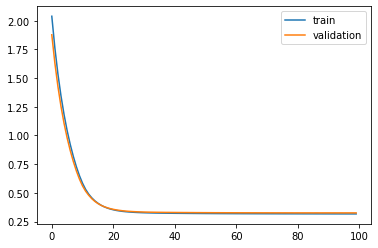

Time to train LSTM:  93.45445036888123
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 2.0939 - acc: 0.5078 - val_loss: 1.9400 - val_acc: 0.5673

Epoch 00001: val_loss improved from inf to 1.94002, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.8249 - acc: 0.5990 - val_loss: 1.6962 - val_acc: 0.6462

Epoch 00002: val_loss improved from 1.94002 to 1.69622, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.5984 - acc: 0.6654 - val_loss: 1.4901 - val_acc: 0.6940

Epoch 00003: val_loss improved from 1.69622 to 1.49007, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.4055 - acc: 0.7056 - val_loss: 1.3129 - val_acc: 0.7228

Epoch 00004: val_loss improved from 1.49007 to 1.31294, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.2388 - acc: 0.7348 - val_loss: 1.1587 - val_acc: 0.7473

Epoch 00005: val_loss improved from 1.31294 to 1.15866, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3168 - acc: 0.8802 - val_loss: 0.3318 - val_acc: 0.8706

Epoch 00046: val_loss improved from 0.33183 to 0.33178, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3167 - acc: 0.8801 - val_loss: 0.3318 - val_acc: 0.8706

Epoch 00047: val_loss improved from 0.33178 to 0.33176, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3166 - acc: 0.8801 - val_loss: 0.3317 - val_acc: 0.8704

Epoch 00048: val_loss improved from 0.33176 to 0.33169, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3165 - acc: 0.8802 - val_loss: 0.3317 - val_acc: 0.8702

Epoch 00049: val_loss did not improve from 0.33169
Epoch 50/100
 - 1s - loss: 0.3164 - acc: 0.8801 - val_loss: 0.3317 - val_acc: 0.8704

Epoch 00050: val_loss improved from 0.33169 to 0.33168, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3163 - acc: 0.8801 - val_loss: 0.3317 - val_acc: 0.8703

Epoch 00051: val_loss improved from 0.33168 to 0.33166, saving

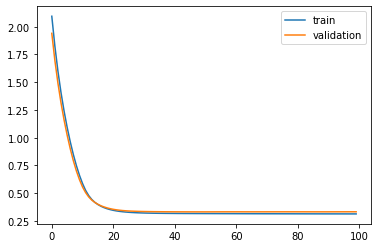

Time to train LSTM:  83.84029293060303
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 2.2107 - acc: 0.5450 - val_loss: 2.0225 - val_acc: 0.5970

Epoch 00001: val_loss improved from inf to 2.02248, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.8985 - acc: 0.6362 - val_loss: 1.7525 - val_acc: 0.6802

Epoch 00002: val_loss improved from 2.02248 to 1.75248, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.6513 - acc: 0.6994 - val_loss: 1.5313 - val_acc: 0.7249

Epoch 00003: val_loss improved from 1.75248 to 1.53129, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.4445 - acc: 0.7361 - val_loss: 1.3427 - val_acc: 0.7529

Epoch 00004: val_loss improved from 1.53129 to 1.34274, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.2676 - acc: 0.7628 - val_loss: 1.1807 - val_acc: 0.7761

Epoch 00005: val_loss improved from 1.34274 to 1.18071, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3213 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32136 to 0.32133, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3212 - val_acc: 0.8780

Epoch 00047: val_loss improved from 0.32133 to 0.32115, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3211 - val_acc: 0.8782

Epoch 00048: val_loss improved from 0.32115 to 0.32114, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3210 - val_acc: 0.8780

Epoch 00049: val_loss improved from 0.32114 to 0.32102, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3210 - val_acc: 0.8782

Epoch 00050: val_loss improved from 0.32102 to 0.32101, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3209 - val_acc: 0.8783

Epoch 00051: val_

 - 1s - loss: 0.3158 - acc: 0.8793 - val_loss: 0.3195 - val_acc: 0.8798

Epoch 00096: val_loss did not improve from 0.31950
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8793 - val_loss: 0.3194 - val_acc: 0.8792

Epoch 00097: val_loss improved from 0.31950 to 0.31944, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8793 - val_loss: 0.3193 - val_acc: 0.8796

Epoch 00098: val_loss improved from 0.31944 to 0.31934, saving model to Event_val_weights5.hdf5
Epoch 99/100
 - 1s - loss: 0.3157 - acc: 0.8792 - val_loss: 0.3194 - val_acc: 0.8794

Epoch 00099: val_loss did not improve from 0.31934
Epoch 100/100
 - 1s - loss: 0.3157 - acc: 0.8792 - val_loss: 0.3194 - val_acc: 0.8791

Epoch 00100: val_loss did not improve from 0.31934
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.09381414261088741
best val loss: 0.31934306875864665
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 819

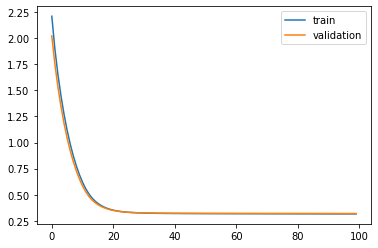

Time to train LSTM:  95.23046779632568
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 2.6924 - acc: 0.4032 - val_loss: 2.4654 - val_acc: 0.4514

Epoch 00001: val_loss improved from inf to 2.46543, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.3031 - acc: 0.4919 - val_loss: 2.1094 - val_acc: 0.5538

Epoch 00002: val_loss improved from 2.46543 to 2.10944, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.9805 - acc: 0.5894 - val_loss: 1.8191 - val_acc: 0.6412

Epoch 00003: val_loss improved from 2.10944 to 1.81910, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.7159 - acc: 0.6612 - val_loss: 1.5791 - val_acc: 0.6970

Epoch 00004: val_loss improved from 1.81910 to 1.57913, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4937 - acc: 0.7127 - val_loss: 1.3763 - val_acc: 0.7392

Epoch 00005: val_loss improved from 1.57913 to 1.37632, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3146 - val_acc: 0.8822

Epoch 00046: val_loss improved from 0.31471 to 0.31458, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3144 - val_acc: 0.8820

Epoch 00047: val_loss improved from 0.31458 to 0.31441, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8791 - val_loss: 0.3145 - val_acc: 0.8819

Epoch 00048: val_loss did not improve from 0.31441
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3142 - val_acc: 0.8822

Epoch 00049: val_loss improved from 0.31441 to 0.31423, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3144 - val_acc: 0.8818

Epoch 00050: val_loss did not improve from 0.31423
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8791 - val_loss: 0.3142 - val_acc: 0.8820

Epoch 00051: val_loss improved from 0.31423 to 0.31420, saving model to Event_val_weights1.hdf5
Epoch 52/10

 - 1s - loss: 0.3170 - acc: 0.8795 - val_loss: 0.3130 - val_acc: 0.8821

Epoch 00100: val_loss improved from 0.31304 to 0.31303, saving model to Event_val_weights1.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.12358821063486902
best val loss: 0.3130298778745863
#################################


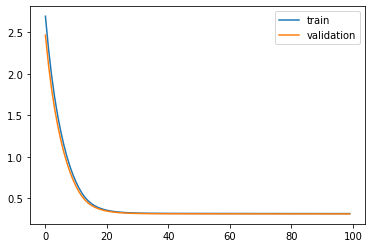

Time to train LSTM:  85.09964632987976
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 2.5885 - acc: 0.5524 - val_loss: 2.3773 - val_acc: 0.5992

Epoch 00001: val_loss improved from inf to 2.37731, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.2356 - acc: 0.6249 - val_loss: 2.0603 - val_acc: 0.6597

Epoch 00002: val_loss improved from 2.37731 to 2.06030, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9387 - acc: 0.6760 - val_loss: 1.7901 - val_acc: 0.7013

Epoch 00003: val_loss improved from 2.06030 to 1.79006, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.6845 - acc: 0.7152 - val_loss: 1.5575 - val_acc: 0.7320

Epoch 00004: val_loss improved from 1.79006 to 1.55750, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4657 - acc: 0.7464 - val_loss: 1.3569 - val_acc: 0.7546

Epoch 00005: val_loss improved from 1.55750 to 1.35694, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3179 - acc: 0.8802 - val_loss: 0.3270 - val_acc: 0.8764

Epoch 00046: val_loss improved from 0.32698 to 0.32696, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3178 - acc: 0.8803 - val_loss: 0.3270 - val_acc: 0.8766

Epoch 00047: val_loss did not improve from 0.32696
Epoch 48/100
 - 1s - loss: 0.3177 - acc: 0.8804 - val_loss: 0.3269 - val_acc: 0.8758

Epoch 00048: val_loss improved from 0.32696 to 0.32693, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8803 - val_loss: 0.3269 - val_acc: 0.8762

Epoch 00049: val_loss improved from 0.32693 to 0.32691, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3175 - acc: 0.8805 - val_loss: 0.3269 - val_acc: 0.8758

Epoch 00050: val_loss improved from 0.32691 to 0.32689, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3174 - acc: 0.8805 - val_loss: 0.3268 - val_acc: 0.8759

Epoch 00051: val_loss improved from 0.32689 to 0.32682, saving

 - 1s - loss: 0.3159 - acc: 0.8806 - val_loss: 0.3242 - val_acc: 0.8769

Epoch 00098: val_loss improved from 0.32416 to 0.32415, saving model to Event_val_weights2.hdf5
Epoch 99/100
 - 1s - loss: 0.3158 - acc: 0.8805 - val_loss: 0.3245 - val_acc: 0.8773

Epoch 00099: val_loss did not improve from 0.32415
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8807 - val_loss: 0.3242 - val_acc: 0.8764

Epoch 00100: val_loss did not improve from 0.32415
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.12358821063486902
best val loss: 0.32415247694651284
#################################


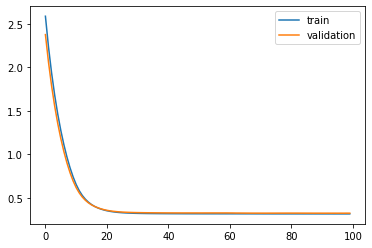

Time to train LSTM:  129.2964470386505
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 34s - loss: 2.4410 - acc: 0.5960 - val_loss: 2.2506 - val_acc: 0.6384

Epoch 00001: val_loss improved from inf to 2.25057, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.1167 - acc: 0.6590 - val_loss: 1.9555 - val_acc: 0.6793

Epoch 00002: val_loss improved from 2.25057 to 1.95554, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.8400 - acc: 0.6951 - val_loss: 1.7011 - val_acc: 0.7057

Epoch 00003: val_loss improved from 1.95554 to 1.70107, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.6003 - acc: 0.7189 - val_loss: 1.4798 - val_acc: 0.7280

Epoch 00004: val_loss improved from 1.70107 to 1.47978, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3920 - acc: 0.7414 - val_loss: 1.2866 - val_acc: 0.7527

Epoch 00005: val_loss improved from 1.47978 to 1.28659, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3170 - acc: 0.8795 - val_loss: 0.3261 - val_acc: 0.8756

Epoch 00048: val_loss did not improve from 0.32610
Epoch 49/100
 - 1s - loss: 0.3169 - acc: 0.8796 - val_loss: 0.3258 - val_acc: 0.8759

Epoch 00049: val_loss improved from 0.32610 to 0.32582, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8797 - val_loss: 0.3256 - val_acc: 0.8764

Epoch 00050: val_loss improved from 0.32582 to 0.32564, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3167 - acc: 0.8796 - val_loss: 0.3256 - val_acc: 0.8762

Epoch 00051: val_loss improved from 0.32564 to 0.32561, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3256 - val_acc: 0.8767

Epoch 00052: val_loss did not improve from 0.32561
Epoch 53/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3254 - val_acc: 0.8766

Epoch 00053: val_loss improved from 0.32561 to 0.32543, saving model to Event_val_weights3.hdf5
Epoch 54/10

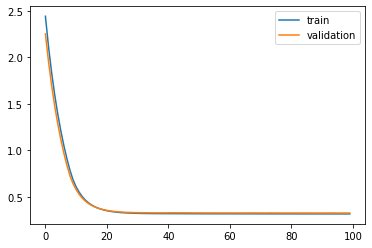

Time to train LSTM:  105.11649537086487
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 28s - loss: 2.6886 - acc: 0.4609 - val_loss: 2.4517 - val_acc: 0.5176

Epoch 00001: val_loss improved from inf to 2.45166, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.2752 - acc: 0.5603 - val_loss: 2.0963 - val_acc: 0.6091

Epoch 00002: val_loss improved from 2.45166 to 2.09630, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.9560 - acc: 0.6323 - val_loss: 1.8143 - val_acc: 0.6594

Epoch 00003: val_loss improved from 2.09630 to 1.81431, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.6962 - acc: 0.6785 - val_loss: 1.5771 - val_acc: 0.7006

Epoch 00004: val_loss improved from 1.81431 to 1.57714, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4756 - acc: 0.7132 - val_loss: 1.3741 - val_acc: 0.7337

Epoch 00005: val_loss improved from 1.57714 to 1.37410, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3173 - acc: 0.8798 - val_loss: 0.3323 - val_acc: 0.8708

Epoch 00046: val_loss improved from 0.33240 to 0.33229, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3171 - acc: 0.8798 - val_loss: 0.3322 - val_acc: 0.8709

Epoch 00047: val_loss improved from 0.33229 to 0.33219, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3170 - acc: 0.8799 - val_loss: 0.3321 - val_acc: 0.8711

Epoch 00048: val_loss improved from 0.33219 to 0.33207, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3169 - acc: 0.8800 - val_loss: 0.3321 - val_acc: 0.8710

Epoch 00049: val_loss improved from 0.33207 to 0.33207, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8802 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00050: val_loss improved from 0.33207 to 0.33195, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3167 - acc: 0.8803 - val_loss: 0.3320 - val_acc: 0.8707

Epoch 00051: val_


Epoch 00097: val_loss did not improve from 0.33041
Epoch 98/100
 - 1s - loss: 0.3146 - acc: 0.8808 - val_loss: 0.3313 - val_acc: 0.8707

Epoch 00098: val_loss did not improve from 0.33041
Epoch 99/100
 - 1s - loss: 0.3145 - acc: 0.8808 - val_loss: 0.3313 - val_acc: 0.8703

Epoch 00099: val_loss did not improve from 0.33041
Epoch 100/100
 - 1s - loss: 0.3145 - acc: 0.8810 - val_loss: 0.3313 - val_acc: 0.8702

Epoch 00100: val_loss did not improve from 0.33041
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.12358821063486902
best val loss: 0.33041091606352063
#################################


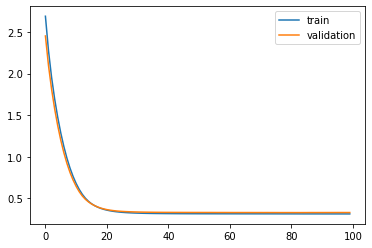

Time to train LSTM:  113.1326174736023
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 2.5890 - acc: 0.4214 - val_loss: 2.3840 - val_acc: 0.4716

Epoch 00001: val_loss improved from inf to 2.38399, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2349 - acc: 0.5240 - val_loss: 2.0579 - val_acc: 0.5836

Epoch 00002: val_loss improved from 2.38399 to 2.05791, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9335 - acc: 0.6301 - val_loss: 1.7850 - val_acc: 0.6723

Epoch 00003: val_loss improved from 2.05791 to 1.78500, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6800 - acc: 0.6931 - val_loss: 1.5554 - val_acc: 0.7106

Epoch 00004: val_loss improved from 1.78500 to 1.55537, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4627 - acc: 0.7276 - val_loss: 1.3567 - val_acc: 0.7378

Epoch 00005: val_loss improved from 1.55537 to 1.35670, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3222 - acc: 0.8794 - val_loss: 0.3238 - val_acc: 0.8781

Epoch 00046: val_loss improved from 0.32398 to 0.32379, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3220 - acc: 0.8793 - val_loss: 0.3236 - val_acc: 0.8784

Epoch 00047: val_loss improved from 0.32379 to 0.32356, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3217 - acc: 0.8791 - val_loss: 0.3233 - val_acc: 0.8787

Epoch 00048: val_loss improved from 0.32356 to 0.32334, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3215 - acc: 0.8792 - val_loss: 0.3231 - val_acc: 0.8787

Epoch 00049: val_loss improved from 0.32334 to 0.32314, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3213 - acc: 0.8793 - val_loss: 0.3229 - val_acc: 0.8788

Epoch 00050: val_loss improved from 0.32314 to 0.32290, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3210 - acc: 0.8791 - val_loss: 0.3227 - val_acc: 0.8790

Epoch 00051: val_


Epoch 00093: val_loss improved from 0.31947 to 0.31933, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8792 - val_loss: 0.3194 - val_acc: 0.8779

Epoch 00094: val_loss did not improve from 0.31933
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3193 - val_acc: 0.8780

Epoch 00095: val_loss improved from 0.31933 to 0.31929, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8791 - val_loss: 0.3194 - val_acc: 0.8781

Epoch 00096: val_loss did not improve from 0.31929
Epoch 97/100
 - 1s - loss: 0.3170 - acc: 0.8789 - val_loss: 0.3192 - val_acc: 0.8782

Epoch 00097: val_loss improved from 0.31929 to 0.31920, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8790 - val_loss: 0.3192 - val_acc: 0.8784

Epoch 00098: val_loss did not improve from 0.31920
Epoch 99/100
 - 1s - loss: 0.3169 - acc: 0.8790 - val_loss: 0.3192 - val_acc: 0.8782

Epoch 00099: val_loss improved from 0.3192

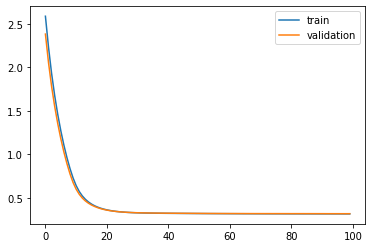

Time to train LSTM:  94.61326122283936


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe521151e80>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 2.2604 - acc: 0.5035 - val_loss: 2.0850 - val_acc: 0.5590

Epoch 00001: val_loss improved from inf to 2.08503, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.9665 - acc: 0.5813 - val_loss: 1.8159 - val_acc: 0.6297

Epoch 00002: val_loss improved from 2.08503 to 1.81590, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.7186 - acc: 0.6417 - val_loss: 1.5895 - val_acc: 0.6789

Epoch 00003: val_loss improved from 1.81590 to 1.58945, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.5083 - acc: 0.6854 - val_loss: 1.3963 - val_acc: 0.7129

Epoch 00004: val_loss improved from 1.58945 to 1.39632, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3278 - acc: 0.7171 - val_loss: 1.2296 - val_acc: 0.7397

Epoch 00005: val_loss improved from 1.39632 to 1.22964, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.1716 - acc: 0.7422 - 

 - 1s - loss: 0.3217 - acc: 0.8785 - val_loss: 0.3178 - val_acc: 0.8822

Epoch 00046: val_loss improved from 0.31805 to 0.31776, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3216 - acc: 0.8786 - val_loss: 0.3179 - val_acc: 0.8822

Epoch 00047: val_loss did not improve from 0.31776
Epoch 48/100
 - 1s - loss: 0.3215 - acc: 0.8785 - val_loss: 0.3176 - val_acc: 0.8826

Epoch 00048: val_loss improved from 0.31776 to 0.31761, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3215 - acc: 0.8784 - val_loss: 0.3177 - val_acc: 0.8826

Epoch 00049: val_loss did not improve from 0.31761
Epoch 50/100
 - 1s - loss: 0.3214 - acc: 0.8785 - val_loss: 0.3174 - val_acc: 0.8831

Epoch 00050: val_loss improved from 0.31761 to 0.31744, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3213 - acc: 0.8785 - val_loss: 0.3175 - val_acc: 0.8831

Epoch 00051: val_loss did not improve from 0.31744
Epoch 52/100
 - 1s - loss: 0.3213 - acc: 0.8786 - val_lo

 - 1s - loss: 0.3193 - acc: 0.8793 - val_loss: 0.3158 - val_acc: 0.8839

Epoch 00098: val_loss did not improve from 0.31570
Epoch 99/100
 - 1s - loss: 0.3192 - acc: 0.8793 - val_loss: 0.3157 - val_acc: 0.8838

Epoch 00099: val_loss improved from 0.31570 to 0.31568, saving model to Event_val_weights1.hdf5
Epoch 100/100
 - 1s - loss: 0.3192 - acc: 0.8793 - val_loss: 0.3158 - val_acc: 0.8837

Epoch 00100: val_loss did not improve from 0.31568
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.10180364119992688
best val loss: 0.3156811849276225
#################################


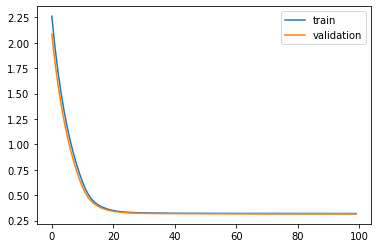

Time to train LSTM:  114.5491304397583
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 2.5352 - acc: 0.4398 - val_loss: 2.2851 - val_acc: 0.5261

Epoch 00001: val_loss improved from inf to 2.28512, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.1335 - acc: 0.5773 - val_loss: 1.9517 - val_acc: 0.6431

Epoch 00002: val_loss improved from 2.28512 to 1.95169, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.8341 - acc: 0.6732 - val_loss: 1.6931 - val_acc: 0.7030

Epoch 00003: val_loss improved from 1.95169 to 1.69310, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.5942 - acc: 0.7234 - val_loss: 1.4784 - val_acc: 0.7373

Epoch 00004: val_loss improved from 1.69310 to 1.47838, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3933 - acc: 0.7524 - val_loss: 1.2956 - val_acc: 0.7626

Epoch 00005: val_loss improved from 1.47838 to 1.29558, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3174 - acc: 0.8803 - val_loss: 0.3250 - val_acc: 0.8757

Epoch 00046: val_loss improved from 0.32528 to 0.32502, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3173 - acc: 0.8803 - val_loss: 0.3249 - val_acc: 0.8757

Epoch 00047: val_loss improved from 0.32502 to 0.32488, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8804 - val_loss: 0.3247 - val_acc: 0.8758

Epoch 00048: val_loss improved from 0.32488 to 0.32474, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3170 - acc: 0.8804 - val_loss: 0.3245 - val_acc: 0.8759

Epoch 00049: val_loss improved from 0.32474 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3169 - acc: 0.8804 - val_loss: 0.3244 - val_acc: 0.8756

Epoch 00050: val_loss improved from 0.32455 to 0.32444, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3167 - acc: 0.8806 - val_loss: 0.3243 - val_acc: 0.8751

Epoch 00051: val_

 - 1s - loss: 0.3149 - acc: 0.8810 - val_loss: 0.3233 - val_acc: 0.8756

Epoch 00096: val_loss did not improve from 0.32312
Epoch 97/100
 - 1s - loss: 0.3149 - acc: 0.8809 - val_loss: 0.3233 - val_acc: 0.8754

Epoch 00097: val_loss did not improve from 0.32312
Epoch 98/100
 - 1s - loss: 0.3148 - acc: 0.8809 - val_loss: 0.3233 - val_acc: 0.8754

Epoch 00098: val_loss did not improve from 0.32312
Epoch 99/100
 - 1s - loss: 0.3148 - acc: 0.8809 - val_loss: 0.3233 - val_acc: 0.8754

Epoch 00099: val_loss did not improve from 0.32312
Epoch 100/100
 - 1s - loss: 0.3147 - acc: 0.8811 - val_loss: 0.3234 - val_acc: 0.8754

Epoch 00100: val_loss did not improve from 0.32312
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.10180364119992688
best val loss: 0.3231177285777198
#################################


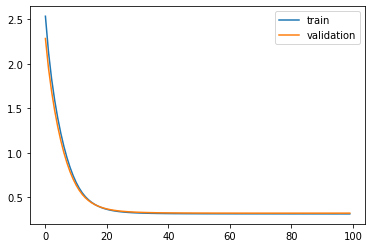

Time to train LSTM:  94.12162518501282
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 2.2338 - acc: 0.5586 - val_loss: 2.0700 - val_acc: 0.5902

Epoch 00001: val_loss improved from inf to 2.07002, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.9382 - acc: 0.6259 - val_loss: 1.8003 - val_acc: 0.6583

Epoch 00002: val_loss improved from 2.07002 to 1.80030, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.6885 - acc: 0.6803 - val_loss: 1.5732 - val_acc: 0.7001

Epoch 00003: val_loss improved from 1.80030 to 1.57317, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.4783 - acc: 0.7188 - val_loss: 1.3815 - val_acc: 0.7288

Epoch 00004: val_loss improved from 1.57317 to 1.38146, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3004 - acc: 0.7446 - val_loss: 1.2183 - val_acc: 0.7489

Epoch 00005: val_loss improved from 1.38146 to 1.21835, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3197 - acc: 0.8793 - val_loss: 0.3282 - val_acc: 0.8752

Epoch 00046: val_loss improved from 0.32824 to 0.32815, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8793 - val_loss: 0.3280 - val_acc: 0.8753

Epoch 00047: val_loss improved from 0.32815 to 0.32802, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8793 - val_loss: 0.3280 - val_acc: 0.8752

Epoch 00048: val_loss improved from 0.32802 to 0.32797, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8791 - val_loss: 0.3278 - val_acc: 0.8751

Epoch 00049: val_loss improved from 0.32797 to 0.32782, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8792 - val_loss: 0.3277 - val_acc: 0.8754

Epoch 00050: val_loss improved from 0.32782 to 0.32773, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8792 - val_loss: 0.3276 - val_acc: 0.8756

Epoch 00051: val_


Epoch 00098: val_loss did not improve from 0.32645
Epoch 99/100
 - 1s - loss: 0.3161 - acc: 0.8795 - val_loss: 0.3265 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32645
Epoch 100/100
 - 1s - loss: 0.3161 - acc: 0.8795 - val_loss: 0.3265 - val_acc: 0.8757

Epoch 00100: val_loss did not improve from 0.32645
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.10180364119992688
best val loss: 0.32644947052001955
#################################


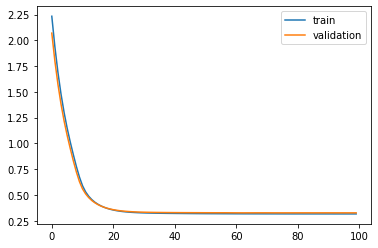

Time to train LSTM:  88.5311427116394
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 2.1656 - acc: 0.5181 - val_loss: 1.9956 - val_acc: 0.5666

Epoch 00001: val_loss improved from inf to 1.99563, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.8816 - acc: 0.5995 - val_loss: 1.7373 - val_acc: 0.6421

Epoch 00002: val_loss improved from 1.99563 to 1.73729, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.6415 - acc: 0.6605 - val_loss: 1.5185 - val_acc: 0.6880

Epoch 00003: val_loss improved from 1.73729 to 1.51854, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.4366 - acc: 0.7013 - val_loss: 1.3307 - val_acc: 0.7211

Epoch 00004: val_loss improved from 1.51854 to 1.33071, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.2595 - acc: 0.7326 - val_loss: 1.1673 - val_acc: 0.7468

Epoch 00005: val_loss improved from 1.33071 to 1.16725, saving model to Event_val_weights4.hdf5
Epoch 6/100

 - 1s - loss: 0.3199 - acc: 0.8801 - val_loss: 0.3328 - val_acc: 0.8714

Epoch 00046: val_loss improved from 0.33304 to 0.33277, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8802 - val_loss: 0.3326 - val_acc: 0.8713

Epoch 00047: val_loss improved from 0.33277 to 0.33263, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3195 - acc: 0.8800 - val_loss: 0.3325 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.33263 to 0.33248, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8800 - val_loss: 0.3323 - val_acc: 0.8717

Epoch 00049: val_loss improved from 0.33248 to 0.33229, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8799 - val_loss: 0.3321 - val_acc: 0.8718

Epoch 00050: val_loss improved from 0.33229 to 0.33215, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8799 - val_loss: 0.3320 - val_acc: 0.8717

Epoch 00051: val_

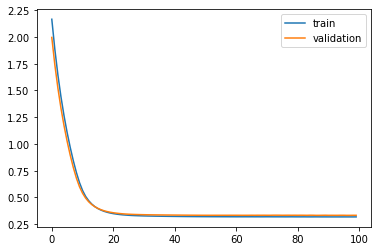

Time to train LSTM:  89.4249587059021
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 2.2833 - acc: 0.4055 - val_loss: 2.1169 - val_acc: 0.4442

Epoch 00001: val_loss improved from inf to 2.11690, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.9933 - acc: 0.4865 - val_loss: 1.8494 - val_acc: 0.5508

Epoch 00002: val_loss improved from 2.11690 to 1.84944, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.7443 - acc: 0.5963 - val_loss: 1.6226 - val_acc: 0.6452

Epoch 00003: val_loss improved from 1.84944 to 1.62256, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.5336 - acc: 0.6704 - val_loss: 1.4313 - val_acc: 0.6954

Epoch 00004: val_loss improved from 1.62256 to 1.43134, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3555 - acc: 0.7091 - val_loss: 1.2686 - val_acc: 0.7269

Epoch 00005: val_loss improved from 1.43134 to 1.26859, saving model to Event_val_weights5.hdf5
Epoch 6/100

 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3213 - val_acc: 0.8788

Epoch 00046: val_loss improved from 0.32143 to 0.32128, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8786 - val_loss: 0.3212 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.32128 to 0.32122, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8785 - val_loss: 0.3211 - val_acc: 0.8787

Epoch 00048: val_loss improved from 0.32122 to 0.32107, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8785 - val_loss: 0.3210 - val_acc: 0.8786

Epoch 00049: val_loss improved from 0.32107 to 0.32101, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8786 - val_loss: 0.3209 - val_acc: 0.8782

Epoch 00050: val_loss improved from 0.32101 to 0.32094, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8786 - val_loss: 0.3208 - val_acc: 0.8784

Epoch 00051: val_


Epoch 00099: val_loss did not improve from 0.32025
Epoch 100/100
 - 1s - loss: 0.3161 - acc: 0.8796 - val_loss: 0.3210 - val_acc: 0.8780

Epoch 00100: val_loss did not improve from 0.32025
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.10180364119992688
best val loss: 0.3202520055770874
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 1, 0.3236824516455332], [8, 8192, 0.08319798053011772, 2, 0.3242554585668776], [8, 8192, 0.08319798053011772, 3, 0.32970055060916476], [8, 8192, 0.08319798053011772, 4, 0.3224302625921037], [8, 8192, 0.13212291230578316, 0, 0.31389645261234705], [8, 8192, 0.1321229123057831

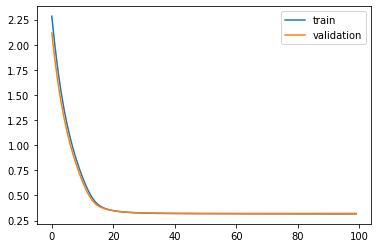

Time to train LSTM:  104.89304614067078
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 2.4368 - acc: 0.4972 - val_loss: 2.2375 - val_acc: 0.5408

Epoch 00001: val_loss improved from inf to 2.23754, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.0982 - acc: 0.5736 - val_loss: 1.9308 - val_acc: 0.6123

Epoch 00002: val_loss improved from 2.23754 to 1.93083, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.8164 - acc: 0.6383 - val_loss: 1.6752 - val_acc: 0.6777

Epoch 00003: val_loss improved from 1.93083 to 1.67520, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.5802 - acc: 0.6874 - val_loss: 1.4592 - val_acc: 0.7181

Epoch 00004: val_loss improved from 1.67520 to 1.45924, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3803 - acc: 0.7217 - val_loss: 1.2757 - val_acc: 0.7489

Epoch 00005: val_loss improved from 1.45924 to 1.27567, saving model to Event_val_weights1.hdf5
Epoch 6/1


Epoch 00046: val_loss improved from 0.31532 to 0.31506, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8796 - val_loss: 0.3151 - val_acc: 0.8812

Epoch 00047: val_loss did not improve from 0.31506
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3150 - val_acc: 0.8810

Epoch 00048: val_loss improved from 0.31506 to 0.31504, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8795 - val_loss: 0.3152 - val_acc: 0.8809

Epoch 00049: val_loss did not improve from 0.31504
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8795 - val_loss: 0.3152 - val_acc: 0.8806

Epoch 00050: val_loss did not improve from 0.31504
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8795 - val_loss: 0.3148 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31504 to 0.31485, saving model to Event_val_weights1.hdf5
Epoch 52/100
 - 1s - loss: 0.3184 - acc: 0.8796 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00052: val_loss improved from 0.3148

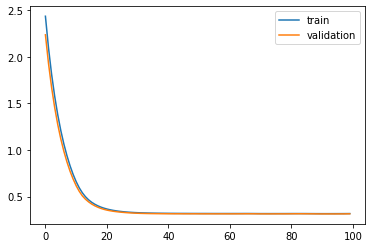

Time to train LSTM:  95.16865611076355
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 2.3128 - acc: 0.4711 - val_loss: 2.1086 - val_acc: 0.5464

Epoch 00001: val_loss improved from inf to 2.10864, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.9917 - acc: 0.5776 - val_loss: 1.8270 - val_acc: 0.6293

Epoch 00002: val_loss improved from 2.10864 to 1.82705, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.7269 - acc: 0.6502 - val_loss: 1.5899 - val_acc: 0.6853

Epoch 00003: val_loss improved from 1.82705 to 1.58989, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.5024 - acc: 0.6998 - val_loss: 1.3875 - val_acc: 0.7221

Epoch 00004: val_loss improved from 1.58989 to 1.38748, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3115 - acc: 0.7338 - val_loss: 1.2159 - val_acc: 0.7464

Epoch 00005: val_loss improved from 1.38748 to 1.21591, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3259 - val_acc: 0.8752

Epoch 00046: val_loss improved from 0.32594 to 0.32586, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3256 - val_acc: 0.8754

Epoch 00047: val_loss improved from 0.32586 to 0.32561, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3256 - val_acc: 0.8751

Epoch 00048: val_loss did not improve from 0.32561
Epoch 49/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3253 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.32561 to 0.32528, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3251 - val_acc: 0.8752

Epoch 00050: val_loss improved from 0.32528 to 0.32511, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3174 - acc: 0.8798 - val_loss: 0.3251 - val_acc: 0.8753

Epoch 00051: val_loss improved from 0.32511 to 0.32506, saving

 - 1s - loss: 0.3153 - acc: 0.8802 - val_loss: 0.3233 - val_acc: 0.8767

Epoch 00096: val_loss did not improve from 0.32311
Epoch 97/100
 - 1s - loss: 0.3154 - acc: 0.8802 - val_loss: 0.3233 - val_acc: 0.8764

Epoch 00097: val_loss did not improve from 0.32311
Epoch 98/100
 - 1s - loss: 0.3153 - acc: 0.8802 - val_loss: 0.3234 - val_acc: 0.8764

Epoch 00098: val_loss did not improve from 0.32311
Epoch 99/100
 - 1s - loss: 0.3153 - acc: 0.8803 - val_loss: 0.3233 - val_acc: 0.8766

Epoch 00099: val_loss did not improve from 0.32311
Epoch 100/100
 - 1s - loss: 0.3152 - acc: 0.8803 - val_loss: 0.3235 - val_acc: 0.8762

Epoch 00100: val_loss did not improve from 0.32311
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.10788586002261571
best val loss: 0.32311203503608704
#################################


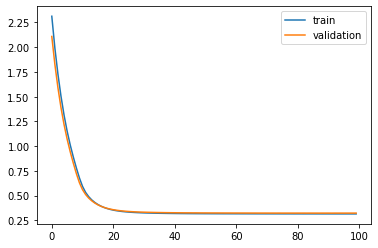

Time to train LSTM:  90.15794157981873
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 2.2385 - acc: 0.5464 - val_loss: 2.0815 - val_acc: 0.5768

Epoch 00001: val_loss improved from inf to 2.08148, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.9669 - acc: 0.6046 - val_loss: 1.8294 - val_acc: 0.6381

Epoch 00002: val_loss improved from 2.08148 to 1.82941, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.7285 - acc: 0.6612 - val_loss: 1.6084 - val_acc: 0.6904

Epoch 00003: val_loss improved from 1.82941 to 1.60843, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.5193 - acc: 0.7070 - val_loss: 1.4142 - val_acc: 0.7258

Epoch 00004: val_loss improved from 1.60843 to 1.41416, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3348 - acc: 0.7381 - val_loss: 1.2430 - val_acc: 0.7473

Epoch 00005: val_loss improved from 1.41416 to 1.24299, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3258 - val_acc: 0.8774

Epoch 00046: val_loss did not improve from 0.32563
Epoch 47/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3256 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32563 to 0.32561, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3255 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32561 to 0.32554, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3255 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32554 to 0.32551, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3174 - acc: 0.8799 - val_loss: 0.3255 - val_acc: 0.8771

Epoch 00050: val_loss did not improve from 0.32551
Epoch 51/100
 - 1s - loss: 0.3173 - acc: 0.8799 - val_loss: 0.3256 - val_acc: 0.8771

Epoch 00051: val_loss did not improve from 0.32551
Epoch 52/100
 - 1s - loss: 0.3173 - acc: 0.8799 - val_lo

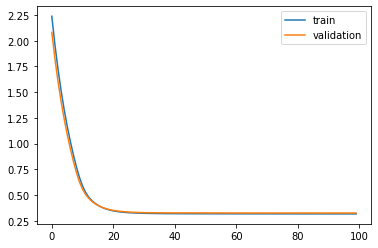

Time to train LSTM:  105.1332437992096
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 43s - loss: 2.2378 - acc: 0.5827 - val_loss: 2.0744 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 2.07441, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.9458 - acc: 0.6537 - val_loss: 1.8087 - val_acc: 0.6697

Epoch 00002: val_loss improved from 2.07441 to 1.80868, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.6994 - acc: 0.6989 - val_loss: 1.5821 - val_acc: 0.7059

Epoch 00003: val_loss improved from 1.80868 to 1.58210, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.4880 - acc: 0.7303 - val_loss: 1.3874 - val_acc: 0.7429

Epoch 00004: val_loss improved from 1.58210 to 1.38737, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3058 - acc: 0.7513 - val_loss: 1.2193 - val_acc: 0.7601

Epoch 00005: val_loss improved from 1.38737 to 1.21928, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3173 - acc: 0.8810 - val_loss: 0.3312 - val_acc: 0.8698

Epoch 00046: val_loss improved from 0.33135 to 0.33121, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3172 - acc: 0.8810 - val_loss: 0.3311 - val_acc: 0.8694

Epoch 00047: val_loss improved from 0.33121 to 0.33110, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8811 - val_loss: 0.3310 - val_acc: 0.8694

Epoch 00048: val_loss improved from 0.33110 to 0.33102, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3169 - acc: 0.8811 - val_loss: 0.3309 - val_acc: 0.8693

Epoch 00049: val_loss improved from 0.33102 to 0.33089, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3168 - acc: 0.8812 - val_loss: 0.3309 - val_acc: 0.8690

Epoch 00050: val_loss improved from 0.33089 to 0.33085, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3167 - acc: 0.8812 - val_loss: 0.3307 - val_acc: 0.8689

Epoch 00051: val_

 - 1s - loss: 0.3142 - acc: 0.8820 - val_loss: 0.3294 - val_acc: 0.8707

Epoch 00097: val_loss did not improve from 0.32940
Epoch 98/100
 - 1s - loss: 0.3142 - acc: 0.8820 - val_loss: 0.3295 - val_acc: 0.8703

Epoch 00098: val_loss did not improve from 0.32940
Epoch 99/100
 - 1s - loss: 0.3141 - acc: 0.8820 - val_loss: 0.3294 - val_acc: 0.8703

Epoch 00099: val_loss improved from 0.32940 to 0.32935, saving model to Event_val_weights4.hdf5
Epoch 100/100
 - 1s - loss: 0.3141 - acc: 0.8820 - val_loss: 0.3296 - val_acc: 0.8704

Epoch 00100: val_loss did not improve from 0.32935
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.10788586002261571
best val loss: 0.32935224016507464
#################################


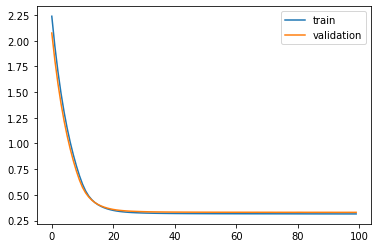

Time to train LSTM:  131.1122763156891
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 2.4930 - acc: 0.4251 - val_loss: 2.2995 - val_acc: 0.4789

Epoch 00001: val_loss improved from inf to 2.29954, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.1523 - acc: 0.5293 - val_loss: 1.9943 - val_acc: 0.5772

Epoch 00002: val_loss improved from 2.29954 to 1.99427, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.8710 - acc: 0.6122 - val_loss: 1.7366 - val_acc: 0.6466

Epoch 00003: val_loss improved from 1.99427 to 1.73658, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6306 - acc: 0.6711 - val_loss: 1.5125 - val_acc: 0.6971

Epoch 00004: val_loss improved from 1.73658 to 1.51246, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4212 - acc: 0.7144 - val_loss: 1.3162 - val_acc: 0.7353

Epoch 00005: val_loss improved from 1.51246 to 1.31624, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3186 - acc: 0.8792 - val_loss: 0.3212 - val_acc: 0.8769

Epoch 00046: val_loss did not improve from 0.32118
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8791 - val_loss: 0.3211 - val_acc: 0.8767

Epoch 00047: val_loss improved from 0.32118 to 0.32109, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3212 - val_acc: 0.8771

Epoch 00048: val_loss did not improve from 0.32109
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3210 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32109 to 0.32100, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3212 - val_acc: 0.8769

Epoch 00050: val_loss did not improve from 0.32100
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8792 - val_loss: 0.3210 - val_acc: 0.8770

Epoch 00051: val_loss did not improve from 0.32100
Epoch 52/100
 - 1s - loss: 0.3179 - acc: 0.8791 - val_loss: 0.3211 - val_acc: 0.8772

Epoch 00052: va

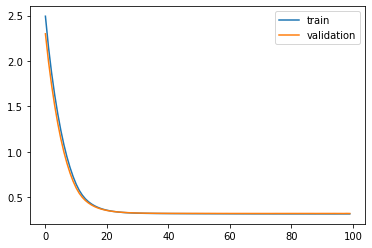

Time to train LSTM:  105.51597547531128
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 2.3329 - acc: 0.5995 - val_loss: 2.1493 - val_acc: 0.6472

Epoch 00001: val_loss improved from inf to 2.14935, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.0241 - acc: 0.6640 - val_loss: 1.8661 - val_acc: 0.6934

Epoch 00002: val_loss improved from 2.14935 to 1.86614, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.7615 - acc: 0.7030 - val_loss: 1.6244 - val_acc: 0.7264

Epoch 00003: val_loss improved from 1.86614 to 1.62436, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.5360 - acc: 0.7285 - val_loss: 1.4166 - val_acc: 0.7473

Epoch 00004: val_loss improved from 1.62436 to 1.41656, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3419 - acc: 0.7470 - val_loss: 1.2369 - val_acc: 0.7623

Epoch 00005: val_loss improved from 1.41656 to 1.23692, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3197 - acc: 0.8788 - val_loss: 0.3157 - val_acc: 0.8804

Epoch 00046: val_loss improved from 0.31598 to 0.31574, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3155 - val_acc: 0.8809

Epoch 00047: val_loss improved from 0.31574 to 0.31555, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8790 - val_loss: 0.3154 - val_acc: 0.8804

Epoch 00048: val_loss improved from 0.31555 to 0.31535, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3152 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31535 to 0.31524, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3151 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31524 to 0.31508, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3149 - val_acc: 0.8804

Epoch 00051: val_

 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3139 - val_acc: 0.8797

Epoch 00098: val_loss did not improve from 0.31348
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8794 - val_loss: 0.3143 - val_acc: 0.8799

Epoch 00099: val_loss did not improve from 0.31348
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3140 - val_acc: 0.8794

Epoch 00100: val_loss did not improve from 0.31348
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.11453550958955938
best val loss: 0.31348147445254854
#################################


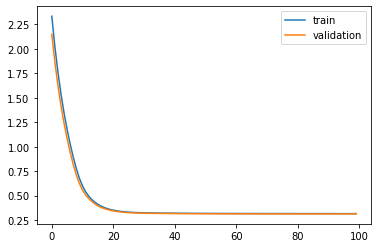

Time to train LSTM:  100.59488415718079
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 2.6371 - acc: 0.4425 - val_loss: 2.3937 - val_acc: 0.5179

Epoch 00001: val_loss improved from inf to 2.39366, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.2360 - acc: 0.5628 - val_loss: 2.0502 - val_acc: 0.6186

Epoch 00002: val_loss improved from 2.39366 to 2.05023, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9291 - acc: 0.6503 - val_loss: 1.7803 - val_acc: 0.6868

Epoch 00003: val_loss improved from 2.05023 to 1.78031, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.6807 - acc: 0.6975 - val_loss: 1.5552 - val_acc: 0.7202

Epoch 00004: val_loss improved from 1.78031 to 1.55525, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4703 - acc: 0.7273 - val_loss: 1.3637 - val_acc: 0.7471

Epoch 00005: val_loss improved from 1.55525 to 1.36371, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3225 - acc: 0.8798 - val_loss: 0.3307 - val_acc: 0.8757

Epoch 00046: val_loss improved from 0.33085 to 0.33068, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3223 - acc: 0.8799 - val_loss: 0.3305 - val_acc: 0.8754

Epoch 00047: val_loss improved from 0.33068 to 0.33054, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3221 - acc: 0.8798 - val_loss: 0.3304 - val_acc: 0.8754

Epoch 00048: val_loss improved from 0.33054 to 0.33040, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3220 - acc: 0.8798 - val_loss: 0.3303 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.33040 to 0.33027, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3218 - acc: 0.8798 - val_loss: 0.3302 - val_acc: 0.8756

Epoch 00050: val_loss improved from 0.33027 to 0.33016, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3217 - acc: 0.8798 - val_loss: 0.3300 - val_acc: 0.8753

Epoch 00051: val_

 - 1s - loss: 0.3176 - acc: 0.8803 - val_loss: 0.3276 - val_acc: 0.8751

Epoch 00092: val_loss did not improve from 0.32754
Epoch 93/100
 - 1s - loss: 0.3175 - acc: 0.8803 - val_loss: 0.3276 - val_acc: 0.8750

Epoch 00093: val_loss did not improve from 0.32754
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8804 - val_loss: 0.3275 - val_acc: 0.8750

Epoch 00094: val_loss improved from 0.32754 to 0.32753, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3174 - acc: 0.8804 - val_loss: 0.3275 - val_acc: 0.8749

Epoch 00095: val_loss improved from 0.32753 to 0.32750, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3174 - acc: 0.8804 - val_loss: 0.3275 - val_acc: 0.8748

Epoch 00096: val_loss did not improve from 0.32750
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8805 - val_loss: 0.3276 - val_acc: 0.8747

Epoch 00097: val_loss did not improve from 0.32750
Epoch 98/100
 - 1s - loss: 0.3174 - acc: 0.8805 - val_loss: 0.3275 - val_acc: 0.8750

Epoch 00098: va

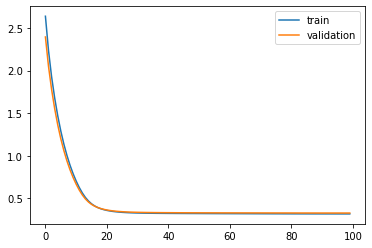

Time to train LSTM:  105.68807125091553
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 2.5061 - acc: 0.4798 - val_loss: 2.2904 - val_acc: 0.5436

Epoch 00001: val_loss improved from inf to 2.29040, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.1417 - acc: 0.5906 - val_loss: 1.9706 - val_acc: 0.6466

Epoch 00002: val_loss improved from 2.29040 to 1.97060, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.8498 - acc: 0.6687 - val_loss: 1.7137 - val_acc: 0.6947

Epoch 00003: val_loss improved from 1.97060 to 1.71374, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.6102 - acc: 0.7097 - val_loss: 1.4981 - val_acc: 0.7216

Epoch 00004: val_loss improved from 1.71374 to 1.49814, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4073 - acc: 0.7353 - val_loss: 1.3142 - val_acc: 0.7444

Epoch 00005: val_loss improved from 1.49814 to 1.31425, saving model to Event_val_weights3.hdf5
Epoch 6/1

 - 1s - loss: 0.3187 - acc: 0.8798 - val_loss: 0.3265 - val_acc: 0.8774

Epoch 00046: val_loss improved from 0.32663 to 0.32649, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8796 - val_loss: 0.3263 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32649 to 0.32629, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8796 - val_loss: 0.3262 - val_acc: 0.8774

Epoch 00048: val_loss improved from 0.32629 to 0.32623, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8796 - val_loss: 0.3260 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32623 to 0.32600, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8796 - val_loss: 0.3259 - val_acc: 0.8774

Epoch 00050: val_loss improved from 0.32600 to 0.32594, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8796 - val_loss: 0.3259 - val_acc: 0.8776

Epoch 00051: val_

 - 1s - loss: 0.3158 - acc: 0.8804 - val_loss: 0.3254 - val_acc: 0.8761

Epoch 00099: val_loss did not improve from 0.32485
Epoch 100/100
 - 1s - loss: 0.3158 - acc: 0.8804 - val_loss: 0.3254 - val_acc: 0.8762

Epoch 00100: val_loss did not improve from 0.32485
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.11453550958955938
best val loss: 0.32485174793667265
#################################


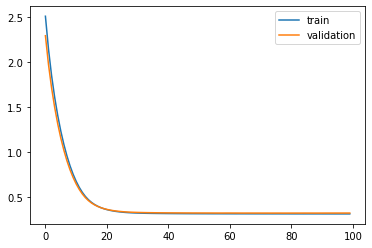

Time to train LSTM:  104.29835247993469
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.3970 - acc: 0.6357 - val_loss: 2.2066 - val_acc: 0.6680

Epoch 00001: val_loss improved from inf to 2.20659, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.0776 - acc: 0.6870 - val_loss: 1.9199 - val_acc: 0.7082

Epoch 00002: val_loss improved from 2.20659 to 1.91990, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.8099 - acc: 0.7171 - val_loss: 1.6734 - val_acc: 0.7299

Epoch 00003: val_loss improved from 1.91990 to 1.67341, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.5784 - acc: 0.7351 - val_loss: 1.4600 - val_acc: 0.7457

Epoch 00004: val_loss improved from 1.67341 to 1.45999, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3778 - acc: 0.7507 - val_loss: 1.2756 - val_acc: 0.7609

Epoch 00005: val_loss improved from 1.45999 to 1.27557, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3174 - acc: 0.8803 - val_loss: 0.3314 - val_acc: 0.8703

Epoch 00046: val_loss improved from 0.33153 to 0.33138, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3172 - acc: 0.8803 - val_loss: 0.3313 - val_acc: 0.8701

Epoch 00047: val_loss improved from 0.33138 to 0.33130, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8802 - val_loss: 0.3312 - val_acc: 0.8699

Epoch 00048: val_loss improved from 0.33130 to 0.33119, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3170 - acc: 0.8803 - val_loss: 0.3311 - val_acc: 0.8698

Epoch 00049: val_loss improved from 0.33119 to 0.33114, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3169 - acc: 0.8803 - val_loss: 0.3311 - val_acc: 0.8698

Epoch 00050: val_loss improved from 0.33114 to 0.33107, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3168 - acc: 0.8803 - val_loss: 0.3310 - val_acc: 0.8698

Epoch 00051: val_


Epoch 00097: val_loss did not improve from 0.33039
Epoch 98/100
 - 1s - loss: 0.3155 - acc: 0.8804 - val_loss: 0.3304 - val_acc: 0.8709

Epoch 00098: val_loss did not improve from 0.33039
Epoch 99/100
 - 1s - loss: 0.3155 - acc: 0.8804 - val_loss: 0.3304 - val_acc: 0.8708

Epoch 00099: val_loss did not improve from 0.33039
Epoch 100/100
 - 1s - loss: 0.3155 - acc: 0.8804 - val_loss: 0.3304 - val_acc: 0.8708

Epoch 00100: val_loss improved from 0.33039 to 0.33035, saving model to Event_val_weights4.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.11453550958955938
best val loss: 0.330354753308826
#################################


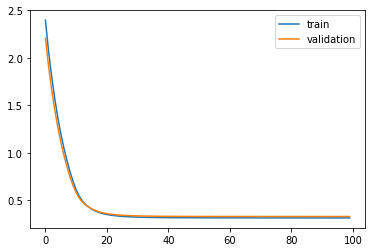

Time to train LSTM:  117.98872303962708


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe50a481a20>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 2.5244 - acc: 0.5101 - val_loss: 2.3056 - val_acc: 0.5863

Epoch 00001: val_loss improved from inf to 2.30557, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.1532 - acc: 0.6283 - val_loss: 1.9897 - val_acc: 0.6704

Epoch 00002: val_loss improved from 2.30557 to 1.98974, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.8672 - acc: 0.6923 - val_loss: 1.7309 - val_acc: 0.7108

Epoch 00003: val_loss improved from 1.98974 to 1.73091, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6261 - acc: 0.7300 - val_loss: 1.5077 - val_acc: 0.7433

Epoch 00004: val_loss improved from 1.73091 to 1.50773, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4177 - acc: 0.7565 - val_loss: 1.3144 - val_acc: 0.7684

Epoch 00005: val_loss improved from 1.50773 to 1.31436, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2369 - acc: 0.7783 - 

 - 1s - loss: 0.3207 - acc: 0.8794 - val_loss: 0.3224 - val_acc: 0.8779

Epoch 00046: val_loss improved from 0.32262 to 0.32244, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3206 - acc: 0.8793 - val_loss: 0.3223 - val_acc: 0.8781

Epoch 00047: val_loss improved from 0.32244 to 0.32229, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8792 - val_loss: 0.3221 - val_acc: 0.8780

Epoch 00048: val_loss improved from 0.32229 to 0.32214, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3204 - acc: 0.8792 - val_loss: 0.3220 - val_acc: 0.8781

Epoch 00049: val_loss improved from 0.32214 to 0.32205, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8792 - val_loss: 0.3219 - val_acc: 0.8779

Epoch 00050: val_loss improved from 0.32205 to 0.32191, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3201 - acc: 0.8791 - val_loss: 0.3218 - val_acc: 0.8778

Epoch 00051: val_

 - 1s - loss: 0.3171 - acc: 0.8797 - val_loss: 0.3202 - val_acc: 0.8779

Epoch 00093: val_loss improved from 0.32027 to 0.32021, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8797 - val_loss: 0.3203 - val_acc: 0.8780

Epoch 00094: val_loss did not improve from 0.32021
Epoch 95/100
 - 1s - loss: 0.3170 - acc: 0.8796 - val_loss: 0.3201 - val_acc: 0.8773

Epoch 00095: val_loss improved from 0.32021 to 0.32012, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8797 - val_loss: 0.3202 - val_acc: 0.8776

Epoch 00096: val_loss did not improve from 0.32012
Epoch 97/100
 - 1s - loss: 0.3170 - acc: 0.8798 - val_loss: 0.3201 - val_acc: 0.8774

Epoch 00097: val_loss improved from 0.32012 to 0.32010, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8799 - val_loss: 0.3202 - val_acc: 0.8772

Epoch 00098: val_loss did not improve from 0.32010
Epoch 99/100
 - 1s - loss: 0.3169 - acc: 0.8797 - val_lo

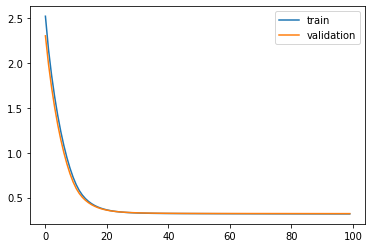

Time to train LSTM:  118.5079300403595
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 3.0301 - acc: 0.5639 - val_loss: 2.7629 - val_acc: 0.6200

Epoch 00001: val_loss improved from inf to 2.76289, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.5873 - acc: 0.6450 - val_loss: 2.3699 - val_acc: 0.6817

Epoch 00002: val_loss improved from 2.76289 to 2.36995, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 2.2282 - acc: 0.6940 - val_loss: 2.0444 - val_acc: 0.7157

Epoch 00003: val_loss improved from 2.36995 to 2.04437, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.9246 - acc: 0.7203 - val_loss: 1.7657 - val_acc: 0.7383

Epoch 00004: val_loss improved from 2.04437 to 1.76568, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.6638 - acc: 0.7400 - val_loss: 1.5265 - val_acc: 0.7577

Epoch 00005: val_loss improved from 1.76568 to 1.52646, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3241 - acc: 0.8780 - val_loss: 0.3205 - val_acc: 0.8796

Epoch 00046: val_loss improved from 0.32068 to 0.32049, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3239 - acc: 0.8780 - val_loss: 0.3204 - val_acc: 0.8794

Epoch 00047: val_loss improved from 0.32049 to 0.32042, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3238 - acc: 0.8780 - val_loss: 0.3202 - val_acc: 0.8793

Epoch 00048: val_loss improved from 0.32042 to 0.32024, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3236 - acc: 0.8780 - val_loss: 0.3202 - val_acc: 0.8793

Epoch 00049: val_loss improved from 0.32024 to 0.32017, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3235 - acc: 0.8780 - val_loss: 0.3200 - val_acc: 0.8793

Epoch 00050: val_loss improved from 0.32017 to 0.31999, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3233 - acc: 0.8781 - val_loss: 0.3199 - val_acc: 0.8791

Epoch 00051: val_


Epoch 00092: val_loss did not improve from 0.31636
Epoch 93/100
 - 1s - loss: 0.3184 - acc: 0.8800 - val_loss: 0.3164 - val_acc: 0.8799

Epoch 00093: val_loss did not improve from 0.31636
Epoch 94/100
 - 1s - loss: 0.3183 - acc: 0.8803 - val_loss: 0.3164 - val_acc: 0.8802

Epoch 00094: val_loss did not improve from 0.31636
Epoch 95/100
 - 1s - loss: 0.3183 - acc: 0.8802 - val_loss: 0.3164 - val_acc: 0.8799

Epoch 00095: val_loss did not improve from 0.31636
Epoch 96/100
 - 1s - loss: 0.3182 - acc: 0.8803 - val_loss: 0.3162 - val_acc: 0.8801

Epoch 00096: val_loss improved from 0.31636 to 0.31620, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3181 - acc: 0.8802 - val_loss: 0.3164 - val_acc: 0.8796

Epoch 00097: val_loss did not improve from 0.31620
Epoch 98/100
 - 1s - loss: 0.3181 - acc: 0.8803 - val_loss: 0.3162 - val_acc: 0.8797

Epoch 00098: val_loss improved from 0.31620 to 0.31618, saving model to Event_val_weights1.hdf5
Epoch 99/100
 - 1s - loss: 0.3180 - 

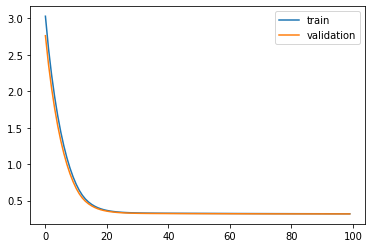

Time to train LSTM:  106.75177145004272
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 3.1868 - acc: 0.5128 - val_loss: 2.9054 - val_acc: 0.5593

Epoch 00001: val_loss improved from inf to 2.90539, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.7160 - acc: 0.5984 - val_loss: 2.4877 - val_acc: 0.6369

Epoch 00002: val_loss improved from 2.90539 to 2.48773, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 2.3320 - acc: 0.6616 - val_loss: 2.1439 - val_acc: 0.6862

Epoch 00003: val_loss improved from 2.48773 to 2.14387, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.0103 - acc: 0.7018 - val_loss: 1.8524 - val_acc: 0.7172

Epoch 00004: val_loss improved from 2.14387 to 1.85244, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.7362 - acc: 0.7307 - val_loss: 1.6025 - val_acc: 0.7391

Epoch 00005: val_loss improved from 1.85244 to 1.60251, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3196 - acc: 0.8792 - val_loss: 0.3268 - val_acc: 0.8746

Epoch 00046: val_loss improved from 0.32693 to 0.32683, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8791 - val_loss: 0.3267 - val_acc: 0.8749

Epoch 00047: val_loss improved from 0.32683 to 0.32672, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8792 - val_loss: 0.3266 - val_acc: 0.8747

Epoch 00048: val_loss improved from 0.32672 to 0.32665, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8792 - val_loss: 0.3265 - val_acc: 0.8748

Epoch 00049: val_loss improved from 0.32665 to 0.32655, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8794 - val_loss: 0.3265 - val_acc: 0.8750

Epoch 00050: val_loss improved from 0.32655 to 0.32647, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8795 - val_loss: 0.3264 - val_acc: 0.8751

Epoch 00051: val_


Epoch 00092: val_loss improved from 0.32409 to 0.32403, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3168 - acc: 0.8795 - val_loss: 0.3242 - val_acc: 0.8759

Epoch 00093: val_loss did not improve from 0.32403
Epoch 94/100
 - 1s - loss: 0.3168 - acc: 0.8795 - val_loss: 0.3240 - val_acc: 0.8759

Epoch 00094: val_loss improved from 0.32403 to 0.32395, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3168 - acc: 0.8796 - val_loss: 0.3241 - val_acc: 0.8761

Epoch 00095: val_loss did not improve from 0.32395
Epoch 96/100
 - 1s - loss: 0.3168 - acc: 0.8796 - val_loss: 0.3239 - val_acc: 0.8761

Epoch 00096: val_loss improved from 0.32395 to 0.32390, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3167 - acc: 0.8798 - val_loss: 0.3239 - val_acc: 0.8762

Epoch 00097: val_loss did not improve from 0.32390
Epoch 98/100
 - 1s - loss: 0.3167 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8763

Epoch 00098: val_loss improved from 0.3239

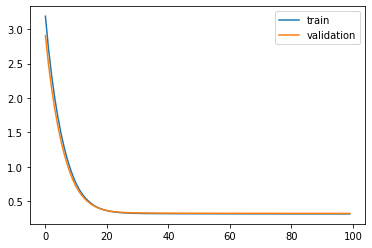

Time to train LSTM:  92.62435293197632
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 2.8972 - acc: 0.5810 - val_loss: 2.6573 - val_acc: 0.6213

Epoch 00001: val_loss improved from inf to 2.65731, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.4943 - acc: 0.6408 - val_loss: 2.2926 - val_acc: 0.6699

Epoch 00002: val_loss improved from 2.65731 to 2.29257, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.1514 - acc: 0.6842 - val_loss: 1.9814 - val_acc: 0.7003

Epoch 00003: val_loss improved from 2.29257 to 1.98139, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.8584 - acc: 0.7178 - val_loss: 1.7142 - val_acc: 0.7327

Epoch 00004: val_loss improved from 1.98139 to 1.71424, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.6067 - acc: 0.7461 - val_loss: 1.4836 - val_acc: 0.7550

Epoch 00005: val_loss improved from 1.71424 to 1.48362, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3226 - acc: 0.8783 - val_loss: 0.3295 - val_acc: 0.8758

Epoch 00046: val_loss improved from 0.32954 to 0.32946, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3226 - acc: 0.8783 - val_loss: 0.3293 - val_acc: 0.8759

Epoch 00047: val_loss improved from 0.32946 to 0.32929, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3224 - acc: 0.8784 - val_loss: 0.3292 - val_acc: 0.8757

Epoch 00048: val_loss improved from 0.32929 to 0.32925, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3223 - acc: 0.8783 - val_loss: 0.3291 - val_acc: 0.8758

Epoch 00049: val_loss improved from 0.32925 to 0.32911, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3222 - acc: 0.8784 - val_loss: 0.3291 - val_acc: 0.8756

Epoch 00050: val_loss improved from 0.32911 to 0.32906, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3221 - acc: 0.8784 - val_loss: 0.3290 - val_acc: 0.8756

Epoch 00051: val_

 - 1s - loss: 0.3187 - acc: 0.8793 - val_loss: 0.3278 - val_acc: 0.8759

Epoch 00097: val_loss improved from 0.32788 to 0.32782, saving model to Event_val_weights3.hdf5
Epoch 98/100
 - 1s - loss: 0.3186 - acc: 0.8794 - val_loss: 0.3277 - val_acc: 0.8758

Epoch 00098: val_loss improved from 0.32782 to 0.32775, saving model to Event_val_weights3.hdf5
Epoch 99/100
 - 1s - loss: 0.3186 - acc: 0.8793 - val_loss: 0.3277 - val_acc: 0.8759

Epoch 00099: val_loss improved from 0.32775 to 0.32770, saving model to Event_val_weights3.hdf5
Epoch 100/100
 - 1s - loss: 0.3185 - acc: 0.8794 - val_loss: 0.3276 - val_acc: 0.8756

Epoch 00100: val_loss improved from 0.32770 to 0.32758, saving model to Event_val_weights3.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.14902242713734165
best val loss: 0.3275826631651984
#################################


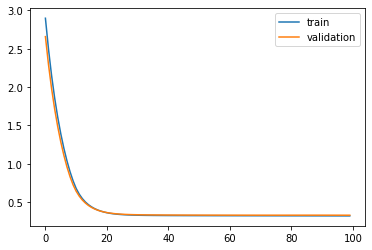

Time to train LSTM:  100.45296478271484
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 3.0418 - acc: 0.4726 - val_loss: 2.7679 - val_acc: 0.5294

Epoch 00001: val_loss improved from inf to 2.76792, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.5922 - acc: 0.5650 - val_loss: 2.3622 - val_acc: 0.6207

Epoch 00002: val_loss improved from 2.76792 to 2.36221, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.2182 - acc: 0.6415 - val_loss: 2.0255 - val_acc: 0.6790

Epoch 00003: val_loss improved from 2.36221 to 2.02550, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.9053 - acc: 0.6879 - val_loss: 1.7433 - val_acc: 0.7104

Epoch 00004: val_loss improved from 2.02550 to 1.74333, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.6409 - acc: 0.7202 - val_loss: 1.5038 - val_acc: 0.7380

Epoch 00005: val_loss improved from 1.74333 to 1.50382, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3189 - acc: 0.8802 - val_loss: 0.3319 - val_acc: 0.8713

Epoch 00046: val_loss improved from 0.33197 to 0.33187, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8803 - val_loss: 0.3318 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33187 to 0.33178, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8803 - val_loss: 0.3317 - val_acc: 0.8713

Epoch 00048: val_loss improved from 0.33178 to 0.33169, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8804 - val_loss: 0.3316 - val_acc: 0.8713

Epoch 00049: val_loss improved from 0.33169 to 0.33162, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8803 - val_loss: 0.3315 - val_acc: 0.8716

Epoch 00050: val_loss improved from 0.33162 to 0.33155, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8803 - val_loss: 0.3315 - val_acc: 0.8717

Epoch 00051: val_

 - 1s - loss: 0.3170 - acc: 0.8802 - val_loss: 0.3306 - val_acc: 0.8713

Epoch 00095: val_loss did not improve from 0.33062
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8801 - val_loss: 0.3306 - val_acc: 0.8713

Epoch 00096: val_loss improved from 0.33062 to 0.33058, saving model to Event_val_weights4.hdf5
Epoch 97/100
 - 1s - loss: 0.3170 - acc: 0.8802 - val_loss: 0.3306 - val_acc: 0.8716

Epoch 00097: val_loss did not improve from 0.33058
Epoch 98/100
 - 1s - loss: 0.3170 - acc: 0.8801 - val_loss: 0.3306 - val_acc: 0.8713

Epoch 00098: val_loss did not improve from 0.33058
Epoch 99/100
 - 1s - loss: 0.3169 - acc: 0.8802 - val_loss: 0.3306 - val_acc: 0.8714

Epoch 00099: val_loss did not improve from 0.33058
Epoch 100/100
 - 1s - loss: 0.3169 - acc: 0.8801 - val_loss: 0.3305 - val_acc: 0.8713

Epoch 00100: val_loss improved from 0.33058 to 0.33052, saving model to Event_val_weights4.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.14902242713734

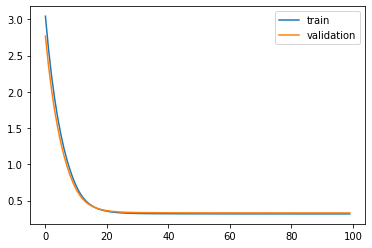

Time to train LSTM:  104.26682662963867
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 27s - loss: 3.0402 - acc: 0.4780 - val_loss: 2.7830 - val_acc: 0.5474

Epoch 00001: val_loss improved from inf to 2.78302, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.6114 - acc: 0.5782 - val_loss: 2.3968 - val_acc: 0.6290

Epoch 00002: val_loss improved from 2.78302 to 2.39684, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 2.2534 - acc: 0.6434 - val_loss: 2.0706 - val_acc: 0.6744

Epoch 00003: val_loss improved from 2.39684 to 2.07060, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.9489 - acc: 0.6885 - val_loss: 1.7916 - val_acc: 0.7124

Epoch 00004: val_loss improved from 2.07060 to 1.79158, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.6881 - acc: 0.7255 - val_loss: 1.5518 - val_acc: 0.7496

Epoch 00005: val_loss improved from 1.79158 to 1.55184, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3190 - acc: 0.8791 - val_loss: 0.3198 - val_acc: 0.8796

Epoch 00046: val_loss improved from 0.31993 to 0.31981, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8792 - val_loss: 0.3197 - val_acc: 0.8796

Epoch 00047: val_loss improved from 0.31981 to 0.31974, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8793 - val_loss: 0.3196 - val_acc: 0.8796

Epoch 00048: val_loss improved from 0.31974 to 0.31959, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8792 - val_loss: 0.3196 - val_acc: 0.8797

Epoch 00049: val_loss improved from 0.31959 to 0.31959, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8793 - val_loss: 0.3195 - val_acc: 0.8797

Epoch 00050: val_loss improved from 0.31959 to 0.31946, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8793 - val_loss: 0.3194 - val_acc: 0.8797

Epoch 00051: val_

 - 1s - loss: 0.3170 - acc: 0.8796 - val_loss: 0.3186 - val_acc: 0.8786

Epoch 00096: val_loss did not improve from 0.31845
Epoch 97/100
 - 1s - loss: 0.3170 - acc: 0.8796 - val_loss: 0.3186 - val_acc: 0.8787

Epoch 00097: val_loss did not improve from 0.31845
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8796 - val_loss: 0.3186 - val_acc: 0.8788

Epoch 00098: val_loss did not improve from 0.31845
Epoch 99/100
 - 1s - loss: 0.3170 - acc: 0.8795 - val_loss: 0.3186 - val_acc: 0.8791

Epoch 00099: val_loss did not improve from 0.31845
Epoch 100/100
 - 1s - loss: 0.3169 - acc: 0.8794 - val_loss: 0.3187 - val_acc: 0.8787

Epoch 00100: val_loss did not improve from 0.31845
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.14902242713734165
best val loss: 0.3184478693538242
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032

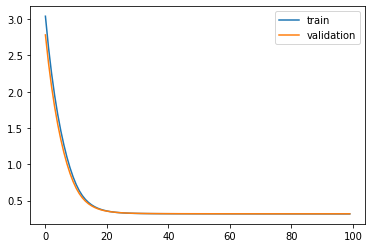

Time to train LSTM:  115.7060055732727
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 2.6672 - acc: 0.6121 - val_loss: 2.4540 - val_acc: 0.6561

Epoch 00001: val_loss improved from inf to 2.45398, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.3045 - acc: 0.6776 - val_loss: 2.1226 - val_acc: 0.7014

Epoch 00002: val_loss improved from 2.45398 to 2.12258, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.9960 - acc: 0.7153 - val_loss: 1.8387 - val_acc: 0.7319

Epoch 00003: val_loss improved from 2.12258 to 1.83873, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.7305 - acc: 0.7416 - val_loss: 1.5948 - val_acc: 0.7548

Epoch 00004: val_loss improved from 1.83873 to 1.59478, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5018 - acc: 0.7622 - val_loss: 1.3846 - val_acc: 0.7732

Epoch 00005: val_loss improved from 1.59478 to 1.38460, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3191 - acc: 0.8795 - val_loss: 0.3145 - val_acc: 0.8812

Epoch 00046: val_loss improved from 0.31454 to 0.31449, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8794 - val_loss: 0.3143 - val_acc: 0.8809

Epoch 00047: val_loss improved from 0.31449 to 0.31428, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8794 - val_loss: 0.3143 - val_acc: 0.8814

Epoch 00048: val_loss did not improve from 0.31428
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3142 - val_acc: 0.8816

Epoch 00049: val_loss improved from 0.31428 to 0.31417, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3141 - val_acc: 0.8811

Epoch 00050: val_loss improved from 0.31417 to 0.31413, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3139 - val_acc: 0.8814

Epoch 00051: val_loss improved from 0.31413 to 0.31387, saving

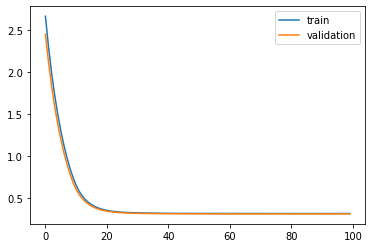

Time to train LSTM:  110.90714001655579
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 2.7538 - acc: 0.5792 - val_loss: 2.5389 - val_acc: 0.6083

Epoch 00001: val_loss improved from inf to 2.53888, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.3787 - acc: 0.6313 - val_loss: 2.1934 - val_acc: 0.6561

Epoch 00002: val_loss improved from 2.53888 to 2.19337, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 2.0559 - acc: 0.6724 - val_loss: 1.8969 - val_acc: 0.6907

Epoch 00003: val_loss improved from 2.19337 to 1.89694, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.7786 - acc: 0.7033 - val_loss: 1.6431 - val_acc: 0.7189

Epoch 00004: val_loss improved from 1.89694 to 1.64314, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5405 - acc: 0.7309 - val_loss: 1.4260 - val_acc: 0.7434

Epoch 00005: val_loss improved from 1.64314 to 1.42604, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3164 - acc: 0.8807 - val_loss: 0.3249 - val_acc: 0.8762

Epoch 00046: val_loss improved from 0.32496 to 0.32486, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3163 - acc: 0.8807 - val_loss: 0.3248 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.32486 to 0.32477, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3162 - acc: 0.8807 - val_loss: 0.3247 - val_acc: 0.8761

Epoch 00048: val_loss improved from 0.32477 to 0.32470, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3161 - acc: 0.8807 - val_loss: 0.3247 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.32470 to 0.32466, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3160 - acc: 0.8808 - val_loss: 0.3245 - val_acc: 0.8757

Epoch 00050: val_loss improved from 0.32466 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3159 - acc: 0.8807 - val_loss: 0.3246 - val_acc: 0.8752

Epoch 00051: val_

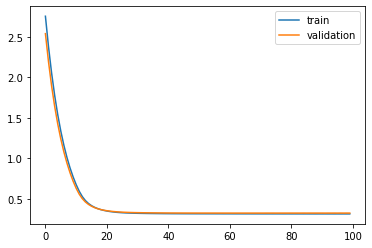

Time to train LSTM:  110.5242817401886
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 39s - loss: 2.6863 - acc: 0.5857 - val_loss: 2.4689 - val_acc: 0.6172

Epoch 00001: val_loss improved from inf to 2.46890, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.3130 - acc: 0.6384 - val_loss: 2.1298 - val_acc: 0.6620

Epoch 00002: val_loss improved from 2.46890 to 2.12984, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.9981 - acc: 0.6783 - val_loss: 1.8424 - val_acc: 0.6972

Epoch 00003: val_loss improved from 2.12984 to 1.84236, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.7304 - acc: 0.7082 - val_loss: 1.5968 - val_acc: 0.7233

Epoch 00004: val_loss improved from 1.84236 to 1.59679, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5015 - acc: 0.7322 - val_loss: 1.3865 - val_acc: 0.7454

Epoch 00005: val_loss improved from 1.59679 to 1.38651, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3176 - acc: 0.8797 - val_loss: 0.3260 - val_acc: 0.8758

Epoch 00046: val_loss improved from 0.32615 to 0.32598, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3259 - val_acc: 0.8758

Epoch 00047: val_loss improved from 0.32598 to 0.32592, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3174 - acc: 0.8800 - val_loss: 0.3258 - val_acc: 0.8758

Epoch 00048: val_loss improved from 0.32592 to 0.32585, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3173 - acc: 0.8801 - val_loss: 0.3259 - val_acc: 0.8760

Epoch 00049: val_loss did not improve from 0.32585
Epoch 50/100
 - 1s - loss: 0.3172 - acc: 0.8801 - val_loss: 0.3259 - val_acc: 0.8758

Epoch 00050: val_loss did not improve from 0.32585
Epoch 51/100
 - 1s - loss: 0.3171 - acc: 0.8801 - val_loss: 0.3259 - val_acc: 0.8758

Epoch 00051: val_loss did not improve from 0.32585
Epoch 52/100
 - 1s - loss: 0.3171 - acc: 0.8801 - val_lo

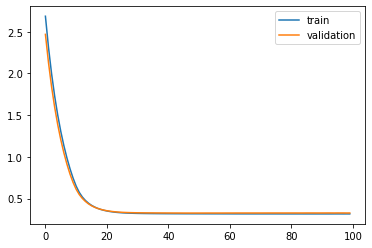

Time to train LSTM:  128.82691168785095
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 2.7433 - acc: 0.4242 - val_loss: 2.5131 - val_acc: 0.4830

Epoch 00001: val_loss improved from inf to 2.51310, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.3530 - acc: 0.5283 - val_loss: 2.1560 - val_acc: 0.5934

Epoch 00002: val_loss improved from 2.51310 to 2.15599, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0215 - acc: 0.6296 - val_loss: 1.8559 - val_acc: 0.6758

Epoch 00003: val_loss improved from 2.15599 to 1.85594, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7432 - acc: 0.6991 - val_loss: 1.6042 - val_acc: 0.7259

Epoch 00004: val_loss improved from 1.85594 to 1.60423, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5079 - acc: 0.7410 - val_loss: 1.3903 - val_acc: 0.7586

Epoch 00005: val_loss improved from 1.60423 to 1.39028, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3180 - acc: 0.8800 - val_loss: 0.3310 - val_acc: 0.8719

Epoch 00046: val_loss improved from 0.33107 to 0.33100, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3178 - acc: 0.8800 - val_loss: 0.3309 - val_acc: 0.8721

Epoch 00047: val_loss improved from 0.33100 to 0.33092, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3177 - acc: 0.8800 - val_loss: 0.3309 - val_acc: 0.8719

Epoch 00048: val_loss improved from 0.33092 to 0.33086, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8800 - val_loss: 0.3308 - val_acc: 0.8720

Epoch 00049: val_loss improved from 0.33086 to 0.33083, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3308 - val_acc: 0.8719

Epoch 00050: val_loss improved from 0.33083 to 0.33077, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3175 - acc: 0.8800 - val_loss: 0.3308 - val_acc: 0.8719

Epoch 00051: val_


Epoch 00100: val_loss did not improve from 0.33006
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.13198581969218415
best val loss: 0.33005850826369393
#################################


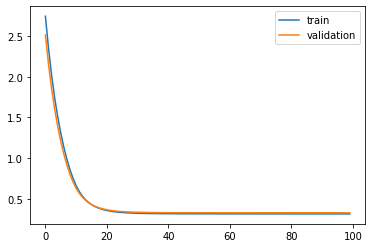

Time to train LSTM:  112.78407716751099
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.6205 - acc: 0.5205 - val_loss: 2.4126 - val_acc: 0.5642

Epoch 00001: val_loss improved from inf to 2.41256, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2592 - acc: 0.6027 - val_loss: 2.0864 - val_acc: 0.6362

Epoch 00002: val_loss improved from 2.41256 to 2.08642, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9561 - acc: 0.6584 - val_loss: 1.8091 - val_acc: 0.6780

Epoch 00003: val_loss improved from 2.08642 to 1.80909, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6973 - acc: 0.6956 - val_loss: 1.5709 - val_acc: 0.7112

Epoch 00004: val_loss improved from 1.80909 to 1.57093, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4754 - acc: 0.7229 - val_loss: 1.3662 - val_acc: 0.7359

Epoch 00005: val_loss improved from 1.57093 to 1.36619, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3187 - acc: 0.8792 - val_loss: 0.3202 - val_acc: 0.8797

Epoch 00046: val_loss improved from 0.32023 to 0.32017, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8791 - val_loss: 0.3201 - val_acc: 0.8799

Epoch 00047: val_loss improved from 0.32017 to 0.32012, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8791 - val_loss: 0.3201 - val_acc: 0.8798

Epoch 00048: val_loss improved from 0.32012 to 0.32010, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8791 - val_loss: 0.3199 - val_acc: 0.8798

Epoch 00049: val_loss improved from 0.32010 to 0.31991, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8791 - val_loss: 0.3198 - val_acc: 0.8800

Epoch 00050: val_loss improved from 0.31991 to 0.31981, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8791 - val_loss: 0.3197 - val_acc: 0.8797

Epoch 00051: val_

 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3188 - val_acc: 0.8793

Epoch 00097: val_loss did not improve from 0.31877
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8793 - val_loss: 0.3189 - val_acc: 0.8794

Epoch 00098: val_loss did not improve from 0.31877
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3189 - val_acc: 0.8793

Epoch 00099: val_loss did not improve from 0.31877
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3187 - val_acc: 0.8793

Epoch 00100: val_loss improved from 0.31877 to 0.31875, saving model to Event_val_weights5.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.13198581969218415
best val loss: 0.3187475106186337
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.1392860151436

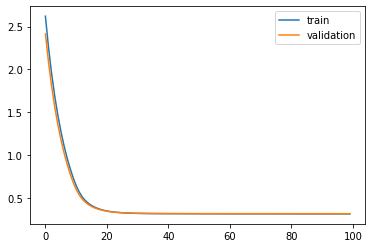

Time to train LSTM:  120.53449320793152
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 2.1405 - acc: 0.5783 - val_loss: 1.9571 - val_acc: 0.6340

Epoch 00001: val_loss improved from inf to 1.95714, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.8423 - acc: 0.6586 - val_loss: 1.7015 - val_acc: 0.6914

Epoch 00002: val_loss improved from 1.95714 to 1.70150, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.6119 - acc: 0.7006 - val_loss: 1.4918 - val_acc: 0.7220

Epoch 00003: val_loss improved from 1.70150 to 1.49182, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.4170 - acc: 0.7249 - val_loss: 1.3122 - val_acc: 0.7426

Epoch 00004: val_loss improved from 1.49182 to 1.31224, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.2488 - acc: 0.7434 - val_loss: 1.1571 - val_acc: 0.7598

Epoch 00005: val_loss improved from 1.31224 to 1.15714, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3233 - acc: 0.8786 - val_loss: 0.3184 - val_acc: 0.8802

Epoch 00046: val_loss improved from 0.31859 to 0.31844, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3232 - acc: 0.8785 - val_loss: 0.3183 - val_acc: 0.8801

Epoch 00047: val_loss improved from 0.31844 to 0.31831, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3231 - acc: 0.8785 - val_loss: 0.3182 - val_acc: 0.8803

Epoch 00048: val_loss improved from 0.31831 to 0.31820, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3230 - acc: 0.8785 - val_loss: 0.3181 - val_acc: 0.8803

Epoch 00049: val_loss improved from 0.31820 to 0.31808, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3229 - acc: 0.8785 - val_loss: 0.3180 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31808 to 0.31798, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3228 - acc: 0.8785 - val_loss: 0.3179 - val_acc: 0.8807

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31632 to 0.31628, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3197 - acc: 0.8793 - val_loss: 0.3163 - val_acc: 0.8810

Epoch 00092: val_loss did not improve from 0.31628
Epoch 93/100
 - 1s - loss: 0.3196 - acc: 0.8793 - val_loss: 0.3162 - val_acc: 0.8811

Epoch 00093: val_loss improved from 0.31628 to 0.31623, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3195 - acc: 0.8793 - val_loss: 0.3162 - val_acc: 0.8809

Epoch 00094: val_loss did not improve from 0.31623
Epoch 95/100
 - 1s - loss: 0.3194 - acc: 0.8793 - val_loss: 0.3162 - val_acc: 0.8810

Epoch 00095: val_loss improved from 0.31623 to 0.31619, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3193 - acc: 0.8793 - val_loss: 0.3162 - val_acc: 0.8810

Epoch 00096: val_loss did not improve from 0.31619
Epoch 97/100
 - 1s - loss: 0.3193 - acc: 0.8794 - val_loss: 0.3162 - val_acc: 0.8810

Epoch 00097: val_loss improved from 0.3161

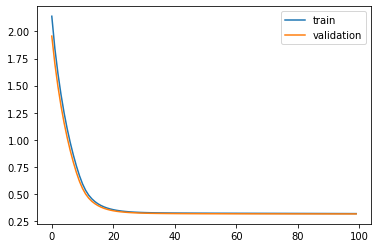

Time to train LSTM:  104.97881555557251
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 2.1163 - acc: 0.5272 - val_loss: 1.9465 - val_acc: 0.5820

Epoch 00001: val_loss improved from inf to 1.94652, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.8361 - acc: 0.6151 - val_loss: 1.7036 - val_acc: 0.6511

Epoch 00002: val_loss improved from 1.94652 to 1.70359, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.6079 - acc: 0.6735 - val_loss: 1.4964 - val_acc: 0.6969

Epoch 00003: val_loss improved from 1.70359 to 1.49639, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.4111 - acc: 0.7122 - val_loss: 1.3140 - val_acc: 0.7291

Epoch 00004: val_loss improved from 1.49639 to 1.31403, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.2379 - acc: 0.7430 - val_loss: 1.1529 - val_acc: 0.7560

Epoch 00005: val_loss improved from 1.31403 to 1.15289, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3189 - acc: 0.8794 - val_loss: 0.3280 - val_acc: 0.8747

Epoch 00046: val_loss improved from 0.32816 to 0.32805, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8795 - val_loss: 0.3279 - val_acc: 0.8744

Epoch 00047: val_loss improved from 0.32805 to 0.32793, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8794 - val_loss: 0.3278 - val_acc: 0.8740

Epoch 00048: val_loss improved from 0.32793 to 0.32780, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8795 - val_loss: 0.3277 - val_acc: 0.8739

Epoch 00049: val_loss improved from 0.32780 to 0.32772, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8795 - val_loss: 0.3276 - val_acc: 0.8740

Epoch 00050: val_loss improved from 0.32772 to 0.32760, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8794 - val_loss: 0.3276 - val_acc: 0.8744

Epoch 00051: val_


Epoch 00094: val_loss did not improve from 0.32557
Epoch 95/100
 - 1s - loss: 0.3160 - acc: 0.8799 - val_loss: 0.3255 - val_acc: 0.8738

Epoch 00095: val_loss improved from 0.32557 to 0.32550, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8799 - val_loss: 0.3256 - val_acc: 0.8736

Epoch 00096: val_loss did not improve from 0.32550
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8798 - val_loss: 0.3256 - val_acc: 0.8736

Epoch 00097: val_loss did not improve from 0.32550
Epoch 98/100
 - 1s - loss: 0.3159 - acc: 0.8799 - val_loss: 0.3255 - val_acc: 0.8737

Epoch 00098: val_loss improved from 0.32550 to 0.32549, saving model to Event_val_weights2.hdf5
Epoch 99/100
 - 1s - loss: 0.3159 - acc: 0.8798 - val_loss: 0.3256 - val_acc: 0.8737

Epoch 00099: val_loss did not improve from 0.32549
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8799 - val_loss: 0.3255 - val_acc: 0.8739

Epoch 00100: val_loss improved from 0.32549 to 0.32546, saving model to Event_val_weig

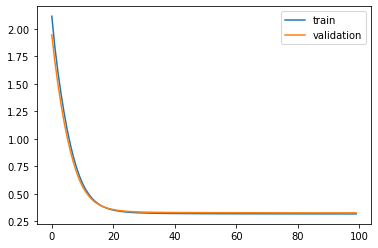

Time to train LSTM:  98.31225156784058
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 28s - loss: 2.0957 - acc: 0.5037 - val_loss: 1.9429 - val_acc: 0.5563

Epoch 00001: val_loss improved from inf to 1.94293, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.8273 - acc: 0.5983 - val_loss: 1.6992 - val_acc: 0.6413

Epoch 00002: val_loss improved from 1.94293 to 1.69919, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.6018 - acc: 0.6673 - val_loss: 1.4937 - val_acc: 0.6884

Epoch 00003: val_loss improved from 1.69919 to 1.49372, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.4106 - acc: 0.7081 - val_loss: 1.3186 - val_acc: 0.7219

Epoch 00004: val_loss improved from 1.49372 to 1.31860, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.2471 - acc: 0.7360 - val_loss: 1.1679 - val_acc: 0.7440

Epoch 00005: val_loss improved from 1.31860 to 1.16793, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3224 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8757

Epoch 00046: val_loss improved from 0.32988 to 0.32976, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3221 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8760

Epoch 00047: val_loss improved from 0.32976 to 0.32960, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3221 - acc: 0.8796 - val_loss: 0.3295 - val_acc: 0.8761

Epoch 00048: val_loss improved from 0.32960 to 0.32954, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3218 - acc: 0.8799 - val_loss: 0.3293 - val_acc: 0.8762

Epoch 00049: val_loss improved from 0.32954 to 0.32935, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3218 - acc: 0.8797 - val_loss: 0.3293 - val_acc: 0.8761

Epoch 00050: val_loss improved from 0.32935 to 0.32927, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3215 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8761

Epoch 00051: val_


Epoch 00093: val_loss improved from 0.32641 to 0.32633, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3170 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8757

Epoch 00094: val_loss did not improve from 0.32633
Epoch 95/100
 - 1s - loss: 0.3170 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8757

Epoch 00095: val_loss improved from 0.32633 to 0.32630, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8757

Epoch 00096: val_loss improved from 0.32630 to 0.32630, saving model to Event_val_weights3.hdf5
Epoch 97/100
 - 1s - loss: 0.3169 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8757

Epoch 00097: val_loss did not improve from 0.32630
Epoch 98/100
 - 1s - loss: 0.3169 - acc: 0.8802 - val_loss: 0.3263 - val_acc: 0.8756

Epoch 00098: val_loss improved from 0.32630 to 0.32626, saving model to Event_val_weights3.hdf5
Epoch 99/100
 - 1s - loss: 0.3169 - acc: 0.8802 - val_loss: 0.3262 - val_acc: 0.875

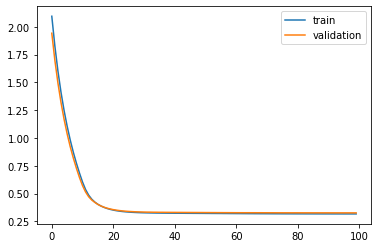

Time to train LSTM:  112.07778239250183
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 2.0351 - acc: 0.5225 - val_loss: 1.8849 - val_acc: 0.5641

Epoch 00001: val_loss improved from inf to 1.88492, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.7784 - acc: 0.6036 - val_loss: 1.6519 - val_acc: 0.6423

Epoch 00002: val_loss improved from 1.88492 to 1.65190, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.5599 - acc: 0.6664 - val_loss: 1.4531 - val_acc: 0.6904

Epoch 00003: val_loss improved from 1.65190 to 1.45313, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.3728 - acc: 0.7085 - val_loss: 1.2822 - val_acc: 0.7253

Epoch 00004: val_loss improved from 1.45313 to 1.28216, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.2115 - acc: 0.7371 - val_loss: 1.1341 - val_acc: 0.7478

Epoch 00005: val_loss improved from 1.28216 to 1.13405, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3156 - acc: 0.8810 - val_loss: 0.3302 - val_acc: 0.8704

Epoch 00046: val_loss improved from 0.33026 to 0.33021, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3155 - acc: 0.8810 - val_loss: 0.3302 - val_acc: 0.8708

Epoch 00047: val_loss improved from 0.33021 to 0.33021, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3154 - acc: 0.8811 - val_loss: 0.3302 - val_acc: 0.8706

Epoch 00048: val_loss did not improve from 0.33021
Epoch 49/100
 - 1s - loss: 0.3153 - acc: 0.8813 - val_loss: 0.3303 - val_acc: 0.8702

Epoch 00049: val_loss did not improve from 0.33021
Epoch 50/100
 - 1s - loss: 0.3152 - acc: 0.8813 - val_loss: 0.3302 - val_acc: 0.8704

Epoch 00050: val_loss did not improve from 0.33021
Epoch 51/100
 - 1s - loss: 0.3151 - acc: 0.8813 - val_loss: 0.3302 - val_acc: 0.8704

Epoch 00051: val_loss did not improve from 0.33021
Epoch 52/100
 - 1s - loss: 0.3151 - acc: 0.8815 - val_loss: 0.3302 - val_acc: 0.8704

Epoch 00052: va

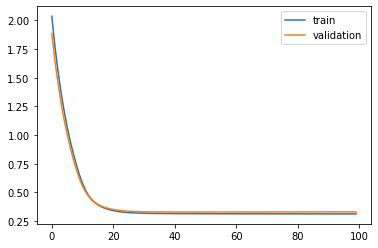

Time to train LSTM:  112.06920599937439
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 2.0854 - acc: 0.5383 - val_loss: 1.9325 - val_acc: 0.5850

Epoch 00001: val_loss improved from inf to 1.93250, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.8240 - acc: 0.6141 - val_loss: 1.6923 - val_acc: 0.6494

Epoch 00002: val_loss improved from 1.93250 to 1.69234, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.6002 - acc: 0.6675 - val_loss: 1.4862 - val_acc: 0.6972

Epoch 00003: val_loss improved from 1.69234 to 1.48616, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.4071 - acc: 0.7064 - val_loss: 1.3073 - val_acc: 0.7300

Epoch 00004: val_loss improved from 1.48616 to 1.30731, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.2384 - acc: 0.7337 - val_loss: 1.1497 - val_acc: 0.7523

Epoch 00005: val_loss improved from 1.30731 to 1.14975, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3203 - acc: 0.8786 - val_loss: 0.3210 - val_acc: 0.8796

Epoch 00046: val_loss improved from 0.32127 to 0.32105, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3201 - acc: 0.8787 - val_loss: 0.3210 - val_acc: 0.8792

Epoch 00047: val_loss improved from 0.32105 to 0.32100, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3200 - acc: 0.8787 - val_loss: 0.3208 - val_acc: 0.8797

Epoch 00048: val_loss improved from 0.32100 to 0.32079, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8789 - val_loss: 0.3208 - val_acc: 0.8793

Epoch 00049: val_loss improved from 0.32079 to 0.32077, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8789 - val_loss: 0.3206 - val_acc: 0.8796

Epoch 00050: val_loss improved from 0.32077 to 0.32059, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8789 - val_loss: 0.3205 - val_acc: 0.8797

Epoch 00051: val_

 - 1s - loss: 0.3163 - acc: 0.8798 - val_loss: 0.3191 - val_acc: 0.8799

Epoch 00096: val_loss did not improve from 0.31887
Epoch 97/100
 - 1s - loss: 0.3163 - acc: 0.8798 - val_loss: 0.3191 - val_acc: 0.8800

Epoch 00097: val_loss did not improve from 0.31887
Epoch 98/100
 - 1s - loss: 0.3163 - acc: 0.8798 - val_loss: 0.3191 - val_acc: 0.8800

Epoch 00098: val_loss did not improve from 0.31887
Epoch 99/100
 - 1s - loss: 0.3162 - acc: 0.8799 - val_loss: 0.3191 - val_acc: 0.8798

Epoch 00099: val_loss did not improve from 0.31887
Epoch 100/100
 - 1s - loss: 0.3162 - acc: 0.8799 - val_loss: 0.3192 - val_acc: 0.8797

Epoch 00100: val_loss did not improve from 0.31887
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.09132009348161808
best val loss: 0.3188668739530775
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032

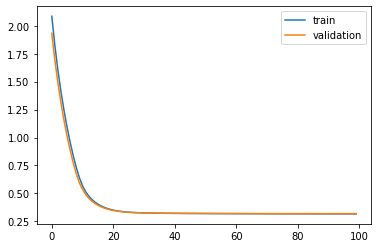

Time to train LSTM:  99.46488571166992
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 2.8386 - acc: 0.5259 - val_loss: 2.6047 - val_acc: 0.5527

Epoch 00001: val_loss improved from inf to 2.60467, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.4444 - acc: 0.5766 - val_loss: 2.2397 - val_acc: 0.6101

Epoch 00002: val_loss improved from 2.60467 to 2.23975, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 2.1069 - acc: 0.6293 - val_loss: 1.9299 - val_acc: 0.6703

Epoch 00003: val_loss improved from 2.23975 to 1.92990, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.8198 - acc: 0.6783 - val_loss: 1.6673 - val_acc: 0.7150

Epoch 00004: val_loss improved from 1.92990 to 1.66728, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5759 - acc: 0.7171 - val_loss: 1.4449 - val_acc: 0.7471

Epoch 00005: val_loss improved from 1.66728 to 1.44487, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3153 - val_acc: 0.8813

Epoch 00046: val_loss did not improve from 0.31531
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8791 - val_loss: 0.3152 - val_acc: 0.8810

Epoch 00047: val_loss improved from 0.31531 to 0.31524, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3153 - val_acc: 0.8814

Epoch 00048: val_loss did not improve from 0.31524
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8791 - val_loss: 0.3151 - val_acc: 0.8813

Epoch 00049: val_loss improved from 0.31524 to 0.31514, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3149 - val_acc: 0.8816

Epoch 00050: val_loss improved from 0.31514 to 0.31492, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8789 - val_loss: 0.3149 - val_acc: 0.8816

Epoch 00051: val_loss did not improve from 0.31492
Epoch 52/100
 - 1s - loss: 0.3184 - acc: 0.8791 - val_lo


Epoch 00100: val_loss did not improve from 0.31365
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.13762676552066272
best val loss: 0.31364966220325896
#################################


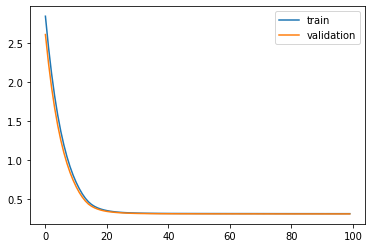

Time to train LSTM:  98.49712944030762
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 2.6752 - acc: 0.5683 - val_loss: 2.4641 - val_acc: 0.5983

Epoch 00001: val_loss improved from inf to 2.46412, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.3003 - acc: 0.6292 - val_loss: 2.1250 - val_acc: 0.6554

Epoch 00002: val_loss improved from 2.46412 to 2.12499, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9857 - acc: 0.6748 - val_loss: 1.8380 - val_acc: 0.6933

Epoch 00003: val_loss improved from 2.12499 to 1.83800, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.7189 - acc: 0.7094 - val_loss: 1.5937 - val_acc: 0.7210

Epoch 00004: val_loss improved from 1.83800 to 1.59374, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4915 - acc: 0.7357 - val_loss: 1.3850 - val_acc: 0.7451

Epoch 00005: val_loss improved from 1.59374 to 1.38499, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3194 - acc: 0.8792 - val_loss: 0.3267 - val_acc: 0.8761

Epoch 00046: val_loss did not improve from 0.32664
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8793 - val_loss: 0.3264 - val_acc: 0.8757

Epoch 00047: val_loss improved from 0.32664 to 0.32642, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8794 - val_loss: 0.3263 - val_acc: 0.8756

Epoch 00048: val_loss improved from 0.32642 to 0.32628, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8794 - val_loss: 0.3262 - val_acc: 0.8761

Epoch 00049: val_loss improved from 0.32628 to 0.32619, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8793 - val_loss: 0.3262 - val_acc: 0.8758

Epoch 00050: val_loss did not improve from 0.32619
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8792 - val_loss: 0.3262 - val_acc: 0.8758

Epoch 00051: val_loss did not improve from 0.32619
Epoch 52/100
 - 1s - loss: 0.3189 - acc: 0.8792 - val_lo


Epoch 00099: val_loss did not improve from 0.32461
Epoch 100/100
 - 1s - loss: 0.3174 - acc: 0.8795 - val_loss: 0.3246 - val_acc: 0.8750

Epoch 00100: val_loss improved from 0.32461 to 0.32460, saving model to Event_val_weights2.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.13762676552066272
best val loss: 0.3246046578619215
#################################


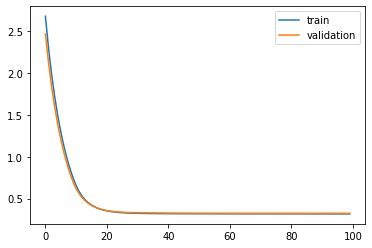

Time to train LSTM:  105.07038474082947
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 2.9499 - acc: 0.5649 - val_loss: 2.6685 - val_acc: 0.6186

Epoch 00001: val_loss improved from inf to 2.66846, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.5011 - acc: 0.6521 - val_loss: 2.2950 - val_acc: 0.6850

Epoch 00002: val_loss improved from 2.66846 to 2.29497, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.1607 - acc: 0.7009 - val_loss: 1.9914 - val_acc: 0.7157

Epoch 00003: val_loss improved from 2.29497 to 1.99141, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.8727 - acc: 0.7275 - val_loss: 1.7275 - val_acc: 0.7372

Epoch 00004: val_loss improved from 1.99141 to 1.72749, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.6232 - acc: 0.7479 - val_loss: 1.5003 - val_acc: 0.7557

Epoch 00005: val_loss improved from 1.72749 to 1.50027, saving model to Event_val_weights3.hdf5
Epoch 6/1

 - 1s - loss: 0.3206 - acc: 0.8791 - val_loss: 0.3280 - val_acc: 0.8767

Epoch 00046: val_loss improved from 0.32821 to 0.32803, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3203 - acc: 0.8793 - val_loss: 0.3280 - val_acc: 0.8764

Epoch 00047: val_loss improved from 0.32803 to 0.32798, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3201 - acc: 0.8794 - val_loss: 0.3281 - val_acc: 0.8767

Epoch 00048: val_loss did not improve from 0.32798
Epoch 49/100
 - 1s - loss: 0.3199 - acc: 0.8796 - val_loss: 0.3281 - val_acc: 0.8764

Epoch 00049: val_loss did not improve from 0.32798
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8796 - val_loss: 0.3281 - val_acc: 0.8762

Epoch 00050: val_loss did not improve from 0.32798
Epoch 51/100
 - 1s - loss: 0.3195 - acc: 0.8794 - val_loss: 0.3280 - val_acc: 0.8763

Epoch 00051: val_loss did not improve from 0.32798
Epoch 52/100
 - 1s - loss: 0.3193 - acc: 0.8795 - val_loss: 0.3280 - val_acc: 0.8762

Epoch 00052: va


Epoch 00097: val_loss did not improve from 0.32547
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3257 - val_acc: 0.8770

Epoch 00098: val_loss did not improve from 0.32547
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3258 - val_acc: 0.8767

Epoch 00099: val_loss did not improve from 0.32547
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3257 - val_acc: 0.8768

Epoch 00100: val_loss did not improve from 0.32547
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.13762676552066272
best val loss: 0.32547176112069026
#################################


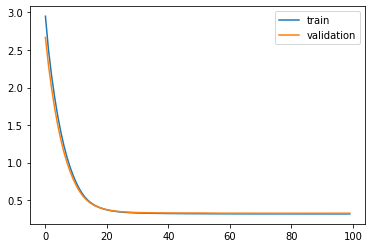

Time to train LSTM:  98.71528649330139


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe500e33a58>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 2.6944 - acc: 0.5834 - val_loss: 2.4881 - val_acc: 0.6234

Epoch 00001: val_loss improved from inf to 2.48806, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.3275 - acc: 0.6503 - val_loss: 2.1525 - val_acc: 0.6762

Epoch 00002: val_loss improved from 2.48806 to 2.15247, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0153 - acc: 0.6943 - val_loss: 1.8650 - val_acc: 0.7081

Epoch 00003: val_loss improved from 2.15247 to 1.86500, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7472 - acc: 0.7209 - val_loss: 1.6193 - val_acc: 0.7274

Epoch 00004: val_loss improved from 1.86500 to 1.61933, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5178 - acc: 0.7396 - val_loss: 1.4097 - val_acc: 0.7432

Epoch 00005: val_loss improved from 1.61933 to 1.40969, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.3213 - acc: 0.7550 - 

 - 1s - loss: 0.3175 - acc: 0.8806 - val_loss: 0.3313 - val_acc: 0.8690

Epoch 00046: val_loss improved from 0.33144 to 0.33127, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3173 - acc: 0.8807 - val_loss: 0.3313 - val_acc: 0.8691

Epoch 00047: val_loss did not improve from 0.33127
Epoch 48/100
 - 1s - loss: 0.3172 - acc: 0.8808 - val_loss: 0.3311 - val_acc: 0.8697

Epoch 00048: val_loss improved from 0.33127 to 0.33114, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3170 - acc: 0.8807 - val_loss: 0.3312 - val_acc: 0.8694

Epoch 00049: val_loss did not improve from 0.33114
Epoch 50/100
 - 1s - loss: 0.3169 - acc: 0.8809 - val_loss: 0.3310 - val_acc: 0.8696

Epoch 00050: val_loss improved from 0.33114 to 0.33098, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3168 - acc: 0.8810 - val_loss: 0.3310 - val_acc: 0.8696

Epoch 00051: val_loss did not improve from 0.33098
Epoch 52/100
 - 1s - loss: 0.3166 - acc: 0.8810 - val_lo

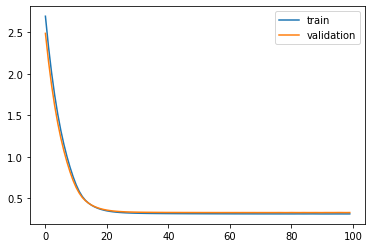

Time to train LSTM:  115.75996923446655
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 2.7738 - acc: 0.4748 - val_loss: 2.5585 - val_acc: 0.4970

Epoch 00001: val_loss improved from inf to 2.55853, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.4066 - acc: 0.5282 - val_loss: 2.2215 - val_acc: 0.5566

Epoch 00002: val_loss improved from 2.55853 to 2.22152, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 2.0924 - acc: 0.5820 - val_loss: 1.9340 - val_acc: 0.6100

Epoch 00003: val_loss improved from 2.22152 to 1.93398, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.8239 - acc: 0.6335 - val_loss: 1.6877 - val_acc: 0.6556

Epoch 00004: val_loss improved from 1.93398 to 1.68769, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5929 - acc: 0.6811 - val_loss: 1.4746 - val_acc: 0.7056

Epoch 00005: val_loss improved from 1.68769 to 1.47456, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3249 - acc: 0.8778 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32537 to 0.32519, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3248 - acc: 0.8775 - val_loss: 0.3251 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32519 to 0.32510, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3246 - acc: 0.8778 - val_loss: 0.3249 - val_acc: 0.8773

Epoch 00048: val_loss improved from 0.32510 to 0.32491, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3245 - acc: 0.8777 - val_loss: 0.3249 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32491 to 0.32486, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3243 - acc: 0.8778 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32486 to 0.32469, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3242 - acc: 0.8778 - val_loss: 0.3247 - val_acc: 0.8772

Epoch 00051: val_


Epoch 00094: val_loss improved from 0.32268 to 0.32260, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3212 - acc: 0.8785 - val_loss: 0.3227 - val_acc: 0.8770

Epoch 00095: val_loss did not improve from 0.32260
Epoch 96/100
 - 1s - loss: 0.3210 - acc: 0.8785 - val_loss: 0.3225 - val_acc: 0.8772

Epoch 00096: val_loss improved from 0.32260 to 0.32255, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3210 - acc: 0.8785 - val_loss: 0.3226 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32255
Epoch 98/100
 - 1s - loss: 0.3209 - acc: 0.8786 - val_loss: 0.3225 - val_acc: 0.8773

Epoch 00098: val_loss improved from 0.32255 to 0.32249, saving model to Event_val_weights5.hdf5
Epoch 99/100
 - 1s - loss: 0.3209 - acc: 0.8785 - val_loss: 0.3226 - val_acc: 0.8770

Epoch 00099: val_loss did not improve from 0.32249
Epoch 100/100
 - 1s - loss: 0.3208 - acc: 0.8785 - val_loss: 0.3224 - val_acc: 0.8770

Epoch 00100: val_loss improved from 0.322

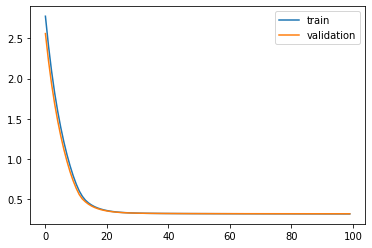

Time to train LSTM:  106.30338382720947
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 27s - loss: 2.6295 - acc: 0.5563 - val_loss: 2.4207 - val_acc: 0.5926

Epoch 00001: val_loss improved from inf to 2.42073, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.2705 - acc: 0.6187 - val_loss: 2.0923 - val_acc: 0.6488

Epoch 00002: val_loss improved from 2.42073 to 2.09228, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.9670 - acc: 0.6648 - val_loss: 1.8147 - val_acc: 0.6891

Epoch 00003: val_loss improved from 2.09228 to 1.81467, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.7104 - acc: 0.6976 - val_loss: 1.5803 - val_acc: 0.7178

Epoch 00004: val_loss improved from 1.81467 to 1.58027, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4931 - acc: 0.7236 - val_loss: 1.3819 - val_acc: 0.7402

Epoch 00005: val_loss improved from 1.58027 to 1.38187, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3169 - val_acc: 0.8813

Epoch 00046: val_loss improved from 0.31695 to 0.31686, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3167 - val_acc: 0.8810

Epoch 00047: val_loss improved from 0.31686 to 0.31675, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3168 - val_acc: 0.8819

Epoch 00048: val_loss did not improve from 0.31675
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8800 - val_loss: 0.3167 - val_acc: 0.8820

Epoch 00049: val_loss improved from 0.31675 to 0.31666, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8799 - val_loss: 0.3168 - val_acc: 0.8819

Epoch 00050: val_loss did not improve from 0.31666
Epoch 51/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3168 - val_acc: 0.8820

Epoch 00051: val_loss did not improve from 0.31666
Epoch 52/100
 - 1s - loss: 0.3178 - acc: 0.8801 - val_lo

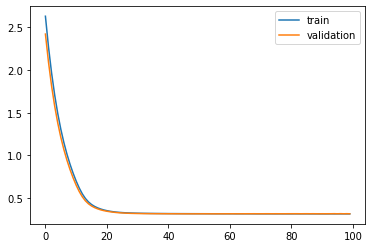

Time to train LSTM:  103.01410412788391
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 27s - loss: 2.5732 - acc: 0.5422 - val_loss: 2.3789 - val_acc: 0.5829

Epoch 00001: val_loss improved from inf to 2.37895, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.2354 - acc: 0.6154 - val_loss: 2.0668 - val_acc: 0.6472

Epoch 00002: val_loss improved from 2.37895 to 2.06683, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9417 - acc: 0.6742 - val_loss: 1.7969 - val_acc: 0.6947

Epoch 00003: val_loss improved from 2.06683 to 1.79686, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.6877 - acc: 0.7170 - val_loss: 1.5638 - val_acc: 0.7347

Epoch 00004: val_loss improved from 1.79686 to 1.56381, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4682 - acc: 0.7480 - val_loss: 1.3627 - val_acc: 0.7597

Epoch 00005: val_loss improved from 1.56381 to 1.36271, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3209 - acc: 0.8801 - val_loss: 0.3292 - val_acc: 0.8752

Epoch 00046: val_loss improved from 0.32964 to 0.32925, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3205 - acc: 0.8800 - val_loss: 0.3289 - val_acc: 0.8753

Epoch 00047: val_loss improved from 0.32925 to 0.32890, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3202 - acc: 0.8801 - val_loss: 0.3286 - val_acc: 0.8754

Epoch 00048: val_loss improved from 0.32890 to 0.32858, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8754

Epoch 00049: val_loss improved from 0.32858 to 0.32840, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3196 - acc: 0.8804 - val_loss: 0.3284 - val_acc: 0.8750

Epoch 00050: val_loss did not improve from 0.32840
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8804 - val_loss: 0.3283 - val_acc: 0.8754

Epoch 00051: val_loss improved from 0.32840 to 0.32830, saving

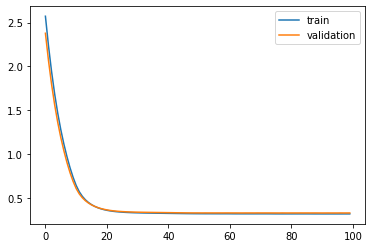

Time to train LSTM:  111.76698994636536
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 2.8005 - acc: 0.5114 - val_loss: 2.5680 - val_acc: 0.5543

Epoch 00001: val_loss improved from inf to 2.56798, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.3973 - acc: 0.5824 - val_loss: 2.2052 - val_acc: 0.6143

Epoch 00002: val_loss improved from 2.56798 to 2.20521, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.0620 - acc: 0.6406 - val_loss: 1.9018 - val_acc: 0.6651

Epoch 00003: val_loss improved from 2.20521 to 1.90183, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.7804 - acc: 0.6832 - val_loss: 1.6456 - val_acc: 0.7022

Epoch 00004: val_loss improved from 1.90183 to 1.64559, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5421 - acc: 0.7165 - val_loss: 1.4275 - val_acc: 0.7313

Epoch 00005: val_loss improved from 1.64559 to 1.42752, saving model to Event_val_weights3.hdf5
Epoch 6/1

 - 1s - loss: 0.3184 - acc: 0.8793 - val_loss: 0.3283 - val_acc: 0.8760

Epoch 00047: val_loss did not improve from 0.32724
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8794 - val_loss: 0.3286 - val_acc: 0.8756

Epoch 00048: val_loss did not improve from 0.32724
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8795 - val_loss: 0.3281 - val_acc: 0.8759

Epoch 00049: val_loss did not improve from 0.32724
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8796 - val_loss: 0.3275 - val_acc: 0.8761

Epoch 00050: val_loss did not improve from 0.32724
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3270 - val_acc: 0.8761

Epoch 00051: val_loss improved from 0.32724 to 0.32699, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3174 - acc: 0.8797 - val_loss: 0.3266 - val_acc: 0.8763

Epoch 00052: val_loss improved from 0.32699 to 0.32660, saving model to Event_val_weights3.hdf5
Epoch 53/100
 - 1s - loss: 0.3172 - acc: 0.8797 - val_loss: 0.3264 - val_acc: 0.8762

Epoch 00053: va

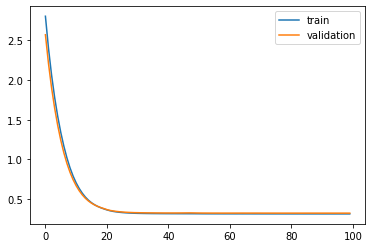

Time to train LSTM:  103.75899910926819
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 2.6036 - acc: 0.5829 - val_loss: 2.4081 - val_acc: 0.6267

Epoch 00001: val_loss improved from inf to 2.40808, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.2565 - acc: 0.6498 - val_loss: 2.0892 - val_acc: 0.6761

Epoch 00002: val_loss improved from 2.40808 to 2.08919, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.9579 - acc: 0.6926 - val_loss: 1.8140 - val_acc: 0.7117

Epoch 00003: val_loss improved from 2.08919 to 1.81402, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7011 - acc: 0.7240 - val_loss: 1.5772 - val_acc: 0.7374

Epoch 00004: val_loss improved from 1.81402 to 1.57716, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4805 - acc: 0.7491 - val_loss: 1.3734 - val_acc: 0.7616

Epoch 00005: val_loss improved from 1.57716 to 1.37341, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3174 - acc: 0.8807 - val_loss: 0.3311 - val_acc: 0.8702

Epoch 00046: val_loss improved from 0.33128 to 0.33107, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3172 - acc: 0.8807 - val_loss: 0.3310 - val_acc: 0.8700

Epoch 00047: val_loss improved from 0.33107 to 0.33105, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3171 - acc: 0.8808 - val_loss: 0.3309 - val_acc: 0.8701

Epoch 00048: val_loss improved from 0.33105 to 0.33094, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3169 - acc: 0.8809 - val_loss: 0.3309 - val_acc: 0.8701

Epoch 00049: val_loss improved from 0.33094 to 0.33093, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3168 - acc: 0.8807 - val_loss: 0.3308 - val_acc: 0.8702

Epoch 00050: val_loss improved from 0.33093 to 0.33082, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3167 - acc: 0.8806 - val_loss: 0.3308 - val_acc: 0.8703

Epoch 00051: val_

 - 1s - loss: 0.3143 - acc: 0.8806 - val_loss: 0.3298 - val_acc: 0.8706

Epoch 00097: val_loss did not improve from 0.32973
Epoch 98/100
 - 1s - loss: 0.3143 - acc: 0.8806 - val_loss: 0.3297 - val_acc: 0.8703

Epoch 00098: val_loss did not improve from 0.32973
Epoch 99/100
 - 1s - loss: 0.3142 - acc: 0.8807 - val_loss: 0.3297 - val_acc: 0.8704

Epoch 00099: val_loss improved from 0.32973 to 0.32973, saving model to Event_val_weights4.hdf5
Epoch 100/100
 - 1s - loss: 0.3142 - acc: 0.8806 - val_loss: 0.3297 - val_acc: 0.8703

Epoch 00100: val_loss improved from 0.32973 to 0.32969, saving model to Event_val_weights4.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.13237594325705213
best val loss: 0.32969036706288657
#################################


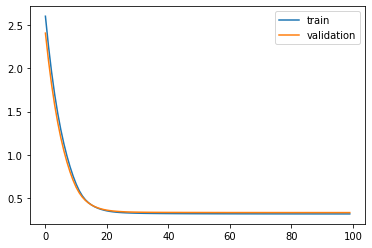

Time to train LSTM:  119.4355103969574
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 2.6478 - acc: 0.5255 - val_loss: 2.4411 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 2.44114, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2954 - acc: 0.5840 - val_loss: 2.1188 - val_acc: 0.6146

Epoch 00002: val_loss improved from 2.44114 to 2.11880, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9916 - acc: 0.6335 - val_loss: 1.8406 - val_acc: 0.6602

Epoch 00003: val_loss improved from 2.11880 to 1.84065, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.7304 - acc: 0.6743 - val_loss: 1.6007 - val_acc: 0.6956

Epoch 00004: val_loss improved from 1.84065 to 1.60072, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5052 - acc: 0.7079 - val_loss: 1.3930 - val_acc: 0.7263

Epoch 00005: val_loss improved from 1.60072 to 1.39298, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3230 - acc: 0.8787 - val_loss: 0.3236 - val_acc: 0.8774

Epoch 00046: val_loss improved from 0.32379 to 0.32364, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3229 - acc: 0.8787 - val_loss: 0.3236 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32364 to 0.32356, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3228 - acc: 0.8789 - val_loss: 0.3234 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32356 to 0.32338, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3227 - acc: 0.8788 - val_loss: 0.3233 - val_acc: 0.8779

Epoch 00049: val_loss improved from 0.32338 to 0.32330, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3226 - acc: 0.8789 - val_loss: 0.3231 - val_acc: 0.8782

Epoch 00050: val_loss improved from 0.32330 to 0.32312, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3225 - acc: 0.8789 - val_loss: 0.3231 - val_acc: 0.8783

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31991 to 0.31985, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3188 - acc: 0.8794 - val_loss: 0.3198 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31985 to 0.31976, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3187 - acc: 0.8794 - val_loss: 0.3197 - val_acc: 0.8796

Epoch 00093: val_loss improved from 0.31976 to 0.31971, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3186 - acc: 0.8794 - val_loss: 0.3196 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31971 to 0.31962, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3185 - acc: 0.8795 - val_loss: 0.3196 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31962 to 0.31957, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3185 - acc: 0.8795 - val_loss: 0.3195 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31957 to 0.31950, saving model to Event_val_weights

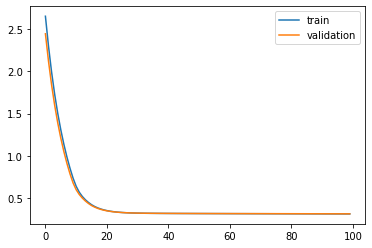

Time to train LSTM:  108.60316920280457
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 1.5453 - acc: 0.5855 - val_loss: 1.4323 - val_acc: 0.6489

Epoch 00001: val_loss improved from inf to 1.43228, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 1.3649 - acc: 0.6689 - val_loss: 1.2671 - val_acc: 0.7108

Epoch 00002: val_loss improved from 1.43228 to 1.26710, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.2138 - acc: 0.7176 - val_loss: 1.1278 - val_acc: 0.7461

Epoch 00003: val_loss improved from 1.26710 to 1.12778, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.0848 - acc: 0.7473 - val_loss: 1.0090 - val_acc: 0.7676

Epoch 00004: val_loss improved from 1.12778 to 1.00899, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.9737 - acc: 0.7663 - val_loss: 0.9068 - val_acc: 0.7828

Epoch 00005: val_loss improved from 1.00899 to 0.90683, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3160 - val_acc: 0.8819

Epoch 00046: val_loss improved from 0.31610 to 0.31602, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3160 - val_acc: 0.8817

Epoch 00047: val_loss improved from 0.31602 to 0.31601, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3159 - val_acc: 0.8817

Epoch 00048: val_loss improved from 0.31601 to 0.31594, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3158 - val_acc: 0.8817

Epoch 00049: val_loss improved from 0.31594 to 0.31582, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3159 - val_acc: 0.8816

Epoch 00050: val_loss did not improve from 0.31582
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3158 - val_acc: 0.8809

Epoch 00051: val_loss did not improve from 0.31582
Epoch 52/10

 - 1s - loss: 0.3160 - acc: 0.8804 - val_loss: 0.3153 - val_acc: 0.8811

Epoch 00100: val_loss did not improve from 0.31508
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.055447450782235466
best val loss: 0.31507860096295676
#################################


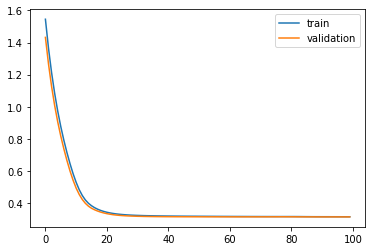

Time to train LSTM:  102.07179045677185
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 42s - loss: 1.5928 - acc: 0.5175 - val_loss: 1.4663 - val_acc: 0.5786

Epoch 00001: val_loss improved from inf to 1.46635, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 1.3831 - acc: 0.6236 - val_loss: 1.2890 - val_acc: 0.6688

Epoch 00002: val_loss improved from 1.46635 to 1.28904, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.2238 - acc: 0.6920 - val_loss: 1.1496 - val_acc: 0.7154

Epoch 00003: val_loss improved from 1.28904 to 1.14955, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.0929 - acc: 0.7283 - val_loss: 1.0299 - val_acc: 0.7416

Epoch 00004: val_loss improved from 1.14955 to 1.02990, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.9790 - acc: 0.7515 - val_loss: 0.9242 - val_acc: 0.7580

Epoch 00005: val_loss improved from 1.02990 to 0.92425, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3167 - acc: 0.8799 - val_loss: 0.3274 - val_acc: 0.8731

Epoch 00046: val_loss improved from 0.32753 to 0.32739, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3165 - acc: 0.8799 - val_loss: 0.3273 - val_acc: 0.8733

Epoch 00047: val_loss improved from 0.32739 to 0.32728, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3163 - acc: 0.8799 - val_loss: 0.3272 - val_acc: 0.8730

Epoch 00048: val_loss improved from 0.32728 to 0.32716, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3161 - acc: 0.8799 - val_loss: 0.3271 - val_acc: 0.8731

Epoch 00049: val_loss improved from 0.32716 to 0.32708, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3269 - val_acc: 0.8729

Epoch 00050: val_loss improved from 0.32708 to 0.32693, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3158 - acc: 0.8800 - val_loss: 0.3268 - val_acc: 0.8731

Epoch 00051: val_

 - 1s - loss: 0.3128 - acc: 0.8806 - val_loss: 0.3263 - val_acc: 0.8751

Epoch 00099: val_loss did not improve from 0.32496
Epoch 100/100
 - 1s - loss: 0.3129 - acc: 0.8807 - val_loss: 0.3255 - val_acc: 0.8748

Epoch 00100: val_loss did not improve from 0.32496
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.055447450782235466
best val loss: 0.32495962084664237
#################################


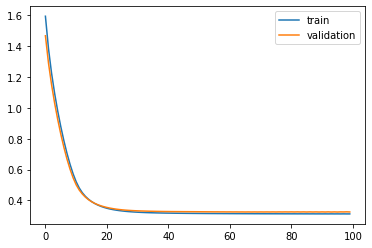

Time to train LSTM:  120.00462651252747
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 42s - loss: 1.5392 - acc: 0.5956 - val_loss: 1.4263 - val_acc: 0.6371

Epoch 00001: val_loss improved from inf to 1.42630, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 1.3444 - acc: 0.6678 - val_loss: 1.2571 - val_acc: 0.6857

Epoch 00002: val_loss improved from 1.42630 to 1.25713, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.1900 - acc: 0.7071 - val_loss: 1.1181 - val_acc: 0.7171

Epoch 00003: val_loss improved from 1.25713 to 1.11814, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.0604 - acc: 0.7362 - val_loss: 0.9994 - val_acc: 0.7459

Epoch 00004: val_loss improved from 1.11814 to 0.99941, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.9477 - acc: 0.7612 - val_loss: 0.8943 - val_acc: 0.7692

Epoch 00005: val_loss improved from 0.99941 to 0.89433, saving model to Event_val_weights3.hdf5
Epoch 6/1


Epoch 00046: val_loss improved from 0.32794 to 0.32773, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3160 - acc: 0.8807 - val_loss: 0.3278 - val_acc: 0.8748

Epoch 00047: val_loss did not improve from 0.32773
Epoch 48/100
 - 1s - loss: 0.3158 - acc: 0.8807 - val_loss: 0.3276 - val_acc: 0.8748

Epoch 00048: val_loss improved from 0.32773 to 0.32762, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3157 - acc: 0.8807 - val_loss: 0.3275 - val_acc: 0.8751

Epoch 00049: val_loss improved from 0.32762 to 0.32747, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3156 - acc: 0.8807 - val_loss: 0.3274 - val_acc: 0.8750

Epoch 00050: val_loss improved from 0.32747 to 0.32744, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3155 - acc: 0.8806 - val_loss: 0.3274 - val_acc: 0.8750

Epoch 00051: val_loss improved from 0.32744 to 0.32737, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3153 - ac


Epoch 00098: val_loss did not improve from 0.32604
Epoch 99/100
 - 1s - loss: 0.3125 - acc: 0.8810 - val_loss: 0.3262 - val_acc: 0.8754

Epoch 00099: val_loss did not improve from 0.32604
Epoch 100/100
 - 1s - loss: 0.3125 - acc: 0.8810 - val_loss: 0.3261 - val_acc: 0.8753

Epoch 00100: val_loss did not improve from 0.32604
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.055447450782235466
best val loss: 0.3260384438832601
#################################


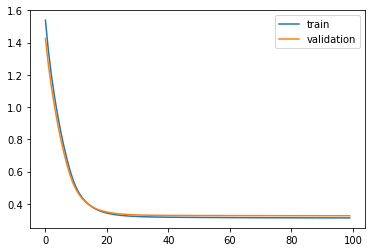

Time to train LSTM:  118.86083483695984
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 52s - loss: 1.5965 - acc: 0.5328 - val_loss: 1.4716 - val_acc: 0.6110

Epoch 00001: val_loss improved from inf to 1.47159, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 1.3821 - acc: 0.6560 - val_loss: 1.2970 - val_acc: 0.6889

Epoch 00002: val_loss improved from 1.47159 to 1.29699, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.2269 - acc: 0.7131 - val_loss: 1.1573 - val_acc: 0.7286

Epoch 00003: val_loss improved from 1.29699 to 1.15727, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.0969 - acc: 0.7441 - val_loss: 1.0357 - val_acc: 0.7547

Epoch 00004: val_loss improved from 1.15727 to 1.03572, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.9820 - acc: 0.7649 - val_loss: 0.9273 - val_acc: 0.7728

Epoch 00005: val_loss improved from 1.03572 to 0.92732, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3181 - acc: 0.8801 - val_loss: 0.3349 - val_acc: 0.8720

Epoch 00046: val_loss improved from 0.33517 to 0.33495, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3179 - acc: 0.8801 - val_loss: 0.3348 - val_acc: 0.8718

Epoch 00047: val_loss improved from 0.33495 to 0.33476, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3177 - acc: 0.8802 - val_loss: 0.3346 - val_acc: 0.8717

Epoch 00048: val_loss improved from 0.33476 to 0.33460, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3176 - acc: 0.8802 - val_loss: 0.3345 - val_acc: 0.8717

Epoch 00049: val_loss improved from 0.33460 to 0.33449, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3174 - acc: 0.8802 - val_loss: 0.3343 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.33449 to 0.33432, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3172 - acc: 0.8804 - val_loss: 0.3341 - val_acc: 0.8711

Epoch 00051: val_

 - 1s - loss: 0.3142 - acc: 0.8811 - val_loss: 0.3317 - val_acc: 0.8689

Epoch 00094: val_loss improved from 0.33179 to 0.33166, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3141 - acc: 0.8810 - val_loss: 0.3318 - val_acc: 0.8694

Epoch 00095: val_loss did not improve from 0.33166
Epoch 96/100
 - 1s - loss: 0.3141 - acc: 0.8810 - val_loss: 0.3317 - val_acc: 0.8689

Epoch 00096: val_loss did not improve from 0.33166
Epoch 97/100
 - 1s - loss: 0.3140 - acc: 0.8811 - val_loss: 0.3316 - val_acc: 0.8694

Epoch 00097: val_loss improved from 0.33166 to 0.33159, saving model to Event_val_weights4.hdf5
Epoch 98/100
 - 1s - loss: 0.3140 - acc: 0.8809 - val_loss: 0.3315 - val_acc: 0.8690

Epoch 00098: val_loss improved from 0.33159 to 0.33150, saving model to Event_val_weights4.hdf5
Epoch 99/100
 - 1s - loss: 0.3140 - acc: 0.8811 - val_loss: 0.3317 - val_acc: 0.8696

Epoch 00099: val_loss did not improve from 0.33150
Epoch 100/100
 - 1s - loss: 0.3139 - acc: 0.8810 - val_l

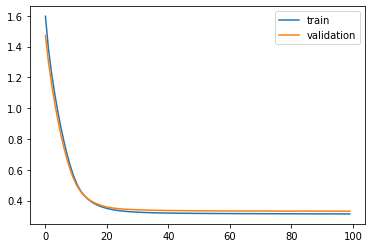

Time to train LSTM:  129.62951517105103
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 44s - loss: 1.6454 - acc: 0.4659 - val_loss: 1.5087 - val_acc: 0.5447

Epoch 00001: val_loss improved from inf to 1.50873, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 1.4260 - acc: 0.5897 - val_loss: 1.3248 - val_acc: 0.6479

Epoch 00002: val_loss improved from 1.50873 to 1.32475, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.2623 - acc: 0.6671 - val_loss: 1.1807 - val_acc: 0.7008

Epoch 00003: val_loss improved from 1.32475 to 1.18071, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.1286 - acc: 0.7111 - val_loss: 1.0578 - val_acc: 0.7337

Epoch 00004: val_loss improved from 1.18071 to 1.05779, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.0135 - acc: 0.7412 - val_loss: 0.9505 - val_acc: 0.7609

Epoch 00005: val_loss improved from 1.05779 to 0.95051, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3230 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8781

Epoch 00046: val_loss improved from 0.32551 to 0.32535, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3228 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8782

Epoch 00047: val_loss improved from 0.32535 to 0.32519, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3226 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8780

Epoch 00048: val_loss improved from 0.32519 to 0.32504, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3223 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8783

Epoch 00049: val_loss improved from 0.32504 to 0.32490, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3221 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8782

Epoch 00050: val_loss improved from 0.32490 to 0.32476, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3219 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8781

Epoch 00051: val_

 - 1s - loss: 0.3164 - acc: 0.8804 - val_loss: 0.3222 - val_acc: 0.8782

Epoch 00097: val_loss improved from 0.32220 to 0.32219, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3162 - acc: 0.8805 - val_loss: 0.3222 - val_acc: 0.8787

Epoch 00098: val_loss did not improve from 0.32219
Epoch 99/100
 - 1s - loss: 0.3161 - acc: 0.8805 - val_loss: 0.3222 - val_acc: 0.8786

Epoch 00099: val_loss improved from 0.32219 to 0.32218, saving model to Event_val_weights5.hdf5
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8805 - val_loss: 0.3223 - val_acc: 0.8783

Epoch 00100: val_loss did not improve from 0.32218
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.055447450782235466
best val loss: 0.3221844888793098
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 

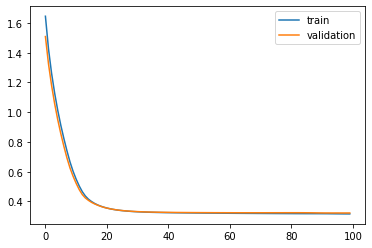

Time to train LSTM:  120.92011618614197
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 28s - loss: 2.5852 - acc: 0.4595 - val_loss: 2.3721 - val_acc: 0.5237

Epoch 00001: val_loss improved from inf to 2.37211, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.2284 - acc: 0.5644 - val_loss: 2.0488 - val_acc: 0.6214

Epoch 00002: val_loss improved from 2.37211 to 2.04881, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.9320 - acc: 0.6440 - val_loss: 1.7772 - val_acc: 0.6817

Epoch 00003: val_loss improved from 2.04881 to 1.77720, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.6801 - acc: 0.6936 - val_loss: 1.5452 - val_acc: 0.7221

Epoch 00004: val_loss improved from 1.77720 to 1.54525, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4636 - acc: 0.7264 - val_loss: 1.3457 - val_acc: 0.7517

Epoch 00005: val_loss improved from 1.54525 to 1.34568, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3151 - val_acc: 0.8804

Epoch 00046: val_loss improved from 0.31511 to 0.31505, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3149 - val_acc: 0.8802

Epoch 00047: val_loss improved from 0.31505 to 0.31488, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3148 - val_acc: 0.8803

Epoch 00048: val_loss improved from 0.31488 to 0.31483, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3147 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.31483 to 0.31465, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8789 - val_loss: 0.3146 - val_acc: 0.8803

Epoch 00050: val_loss improved from 0.31465 to 0.31459, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3144 - val_acc: 0.8803

Epoch 00051: val_


Epoch 00099: val_loss did not improve from 0.31316
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8791 - val_loss: 0.3134 - val_acc: 0.8809

Epoch 00100: val_loss did not improve from 0.31316
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.12186372365641943
best val loss: 0.3131591586271922
#################################


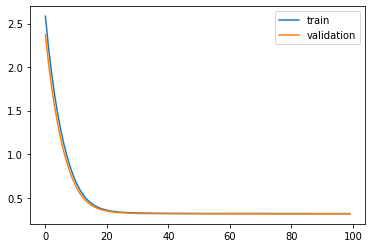

Time to train LSTM:  105.33272981643677
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 40s - loss: 2.5034 - acc: 0.6041 - val_loss: 2.3105 - val_acc: 0.6417

Epoch 00001: val_loss improved from inf to 2.31050, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.1682 - acc: 0.6630 - val_loss: 2.0038 - val_acc: 0.6891

Epoch 00002: val_loss improved from 2.31050 to 2.00381, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.8815 - acc: 0.7007 - val_loss: 1.7412 - val_acc: 0.7153

Epoch 00003: val_loss improved from 2.00381 to 1.74124, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.6349 - acc: 0.7279 - val_loss: 1.5151 - val_acc: 0.7388

Epoch 00004: val_loss improved from 1.74124 to 1.51513, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4214 - acc: 0.7505 - val_loss: 1.3190 - val_acc: 0.7550

Epoch 00005: val_loss improved from 1.51513 to 1.31900, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3182 - acc: 0.8792 - val_loss: 0.3254 - val_acc: 0.8763

Epoch 00046: val_loss improved from 0.32560 to 0.32545, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3181 - acc: 0.8792 - val_loss: 0.3254 - val_acc: 0.8763

Epoch 00047: val_loss improved from 0.32545 to 0.32540, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3180 - acc: 0.8793 - val_loss: 0.3253 - val_acc: 0.8763

Epoch 00048: val_loss improved from 0.32540 to 0.32534, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3179 - acc: 0.8793 - val_loss: 0.3253 - val_acc: 0.8763

Epoch 00049: val_loss improved from 0.32534 to 0.32528, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3178 - acc: 0.8794 - val_loss: 0.3252 - val_acc: 0.8762

Epoch 00050: val_loss improved from 0.32528 to 0.32522, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8793 - val_loss: 0.3252 - val_acc: 0.8760

Epoch 00051: val_

 - 1s - loss: 0.3163 - acc: 0.8797 - val_loss: 0.3238 - val_acc: 0.8756

Epoch 00097: val_loss did not improve from 0.32365
Epoch 98/100
 - 1s - loss: 0.3163 - acc: 0.8797 - val_loss: 0.3238 - val_acc: 0.8756

Epoch 00098: val_loss did not improve from 0.32365
Epoch 99/100
 - 1s - loss: 0.3163 - acc: 0.8798 - val_loss: 0.3238 - val_acc: 0.8756

Epoch 00099: val_loss did not improve from 0.32365
Epoch 100/100
 - 1s - loss: 0.3163 - acc: 0.8798 - val_loss: 0.3237 - val_acc: 0.8757

Epoch 00100: val_loss did not improve from 0.32365
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.12186372365641943
best val loss: 0.32365263856781856
#################################


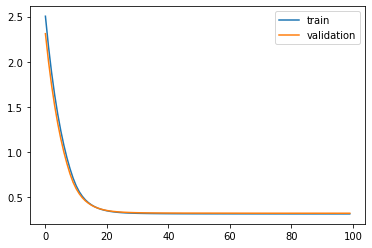

Time to train LSTM:  117.12502098083496
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 42s - loss: 2.4433 - acc: 0.5921 - val_loss: 2.2436 - val_acc: 0.6591

Epoch 00001: val_loss improved from inf to 2.24363, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.1052 - acc: 0.6857 - val_loss: 1.9471 - val_acc: 0.7172

Epoch 00002: val_loss improved from 2.24363 to 1.94707, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.8302 - acc: 0.7296 - val_loss: 1.6971 - val_acc: 0.7417

Epoch 00003: val_loss improved from 1.94707 to 1.69712, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.5958 - acc: 0.7510 - val_loss: 1.4818 - val_acc: 0.7559

Epoch 00004: val_loss improved from 1.69712 to 1.48178, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3944 - acc: 0.7656 - val_loss: 1.2967 - val_acc: 0.7698

Epoch 00005: val_loss improved from 1.48178 to 1.29673, saving model to Event_val_weights3.hdf5
Epoch 6/1

 - 1s - loss: 0.3206 - acc: 0.8794 - val_loss: 0.3303 - val_acc: 0.8759

Epoch 00046: val_loss improved from 0.33049 to 0.33027, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3205 - acc: 0.8793 - val_loss: 0.3301 - val_acc: 0.8761

Epoch 00047: val_loss improved from 0.33027 to 0.33012, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3204 - acc: 0.8794 - val_loss: 0.3300 - val_acc: 0.8759

Epoch 00048: val_loss improved from 0.33012 to 0.32995, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3203 - acc: 0.8795 - val_loss: 0.3298 - val_acc: 0.8761

Epoch 00049: val_loss improved from 0.32995 to 0.32983, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3202 - acc: 0.8794 - val_loss: 0.3297 - val_acc: 0.8759

Epoch 00050: val_loss improved from 0.32983 to 0.32967, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8795 - val_loss: 0.3296 - val_acc: 0.8760

Epoch 00051: val_

 - 1s - loss: 0.3176 - acc: 0.8794 - val_loss: 0.3272 - val_acc: 0.8769

Epoch 00097: val_loss did not improve from 0.32721
Epoch 98/100
 - 1s - loss: 0.3176 - acc: 0.8793 - val_loss: 0.3273 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32721
Epoch 99/100
 - 1s - loss: 0.3176 - acc: 0.8793 - val_loss: 0.3275 - val_acc: 0.8766

Epoch 00099: val_loss did not improve from 0.32721
Epoch 100/100
 - 1s - loss: 0.3176 - acc: 0.8792 - val_loss: 0.3275 - val_acc: 0.8769

Epoch 00100: val_loss did not improve from 0.32721
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.12186372365641943
best val loss: 0.32720797284444175
#################################


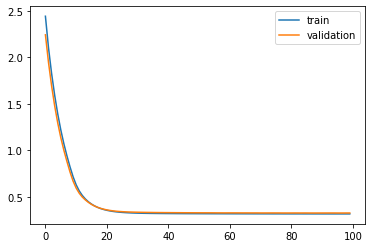

Time to train LSTM:  119.52467083930969
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 2.4672 - acc: 0.5637 - val_loss: 2.2789 - val_acc: 0.5921

Epoch 00001: val_loss improved from inf to 2.27886, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.1422 - acc: 0.6150 - val_loss: 1.9776 - val_acc: 0.6400

Epoch 00002: val_loss improved from 2.27886 to 1.97760, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.8591 - acc: 0.6579 - val_loss: 1.7155 - val_acc: 0.6816

Epoch 00003: val_loss improved from 1.97760 to 1.71551, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.6122 - acc: 0.6970 - val_loss: 1.4871 - val_acc: 0.7190

Epoch 00004: val_loss improved from 1.71551 to 1.48712, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3968 - acc: 0.7309 - val_loss: 1.2886 - val_acc: 0.7467

Epoch 00005: val_loss improved from 1.48712 to 1.28862, saving model to Event_val_weights4.hdf5
Epoch 6/1


Epoch 00046: val_loss did not improve from 0.33234
Epoch 47/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3327 - val_acc: 0.8696

Epoch 00047: val_loss did not improve from 0.33234
Epoch 48/100
 - 1s - loss: 0.3175 - acc: 0.8799 - val_loss: 0.3326 - val_acc: 0.8700

Epoch 00048: val_loss did not improve from 0.33234
Epoch 49/100
 - 1s - loss: 0.3175 - acc: 0.8799 - val_loss: 0.3330 - val_acc: 0.8698

Epoch 00049: val_loss did not improve from 0.33234
Epoch 50/100
 - 1s - loss: 0.3174 - acc: 0.8800 - val_loss: 0.3332 - val_acc: 0.8701

Epoch 00050: val_loss did not improve from 0.33234
Epoch 51/100
 - 1s - loss: 0.3174 - acc: 0.8800 - val_loss: 0.3336 - val_acc: 0.8694

Epoch 00051: val_loss did not improve from 0.33234
Epoch 52/100
 - 1s - loss: 0.3174 - acc: 0.8799 - val_loss: 0.3337 - val_acc: 0.8689

Epoch 00052: val_loss did not improve from 0.33234
Epoch 53/100
 - 1s - loss: 0.3175 - acc: 0.8797 - val_loss: 0.3339 - val_acc: 0.8692

Epoch 00053: val_loss did not improve fr

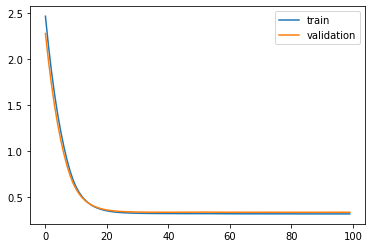

Time to train LSTM:  112.4444808959961
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 50s - loss: 2.5240 - acc: 0.6124 - val_loss: 2.3239 - val_acc: 0.6487

Epoch 00001: val_loss improved from inf to 2.32395, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.1700 - acc: 0.6773 - val_loss: 2.0056 - val_acc: 0.6978

Epoch 00002: val_loss improved from 2.32395 to 2.00563, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.8738 - acc: 0.7173 - val_loss: 1.7356 - val_acc: 0.7307

Epoch 00003: val_loss improved from 2.00563 to 1.73557, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6225 - acc: 0.7465 - val_loss: 1.5060 - val_acc: 0.7532

Epoch 00004: val_loss improved from 1.73557 to 1.50602, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4086 - acc: 0.7672 - val_loss: 1.3100 - val_acc: 0.7732

Epoch 00005: val_loss improved from 1.50602 to 1.31002, saving model to Event_val_weights5.hdf5
Epoch 6/10

 - 1s - loss: 0.3195 - acc: 0.8789 - val_loss: 0.3223 - val_acc: 0.8782

Epoch 00046: val_loss improved from 0.32229 to 0.32227, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3194 - acc: 0.8790 - val_loss: 0.3223 - val_acc: 0.8783

Epoch 00047: val_loss did not improve from 0.32227
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8792 - val_loss: 0.3223 - val_acc: 0.8781

Epoch 00048: val_loss did not improve from 0.32227
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8792 - val_loss: 0.3223 - val_acc: 0.8787

Epoch 00049: val_loss improved from 0.32227 to 0.32227, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8791 - val_loss: 0.3222 - val_acc: 0.8786

Epoch 00050: val_loss improved from 0.32227 to 0.32221, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3192 - acc: 0.8791 - val_loss: 0.3221 - val_acc: 0.8781

Epoch 00051: val_loss improved from 0.32221 to 0.32214, saving model to Event_val_weights5.hdf5
Epoch 52/10

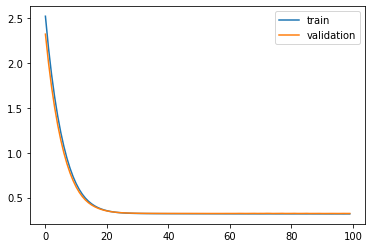

Time to train LSTM:  126.89562511444092
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.4982 - acc: 0.5522 - val_loss: 2.3107 - val_acc: 0.5773

Epoch 00001: val_loss improved from inf to 2.31074, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.1711 - acc: 0.6058 - val_loss: 2.0070 - val_acc: 0.6358

Epoch 00002: val_loss improved from 2.31074 to 2.00702, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.8883 - acc: 0.6520 - val_loss: 1.7450 - val_acc: 0.6774

Epoch 00003: val_loss improved from 2.00702 to 1.74500, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.6444 - acc: 0.6906 - val_loss: 1.5187 - val_acc: 0.7147

Epoch 00004: val_loss improved from 1.74500 to 1.51866, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4328 - acc: 0.7237 - val_loss: 1.3218 - val_acc: 0.7431

Epoch 00005: val_loss improved from 1.51866 to 1.32175, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3205 - acc: 0.8786 - val_loss: 0.3157 - val_acc: 0.8810

Epoch 00046: val_loss improved from 0.31585 to 0.31570, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3203 - acc: 0.8786 - val_loss: 0.3157 - val_acc: 0.8811

Epoch 00047: val_loss did not improve from 0.31570
Epoch 48/100
 - 1s - loss: 0.3202 - acc: 0.8786 - val_loss: 0.3156 - val_acc: 0.8811

Epoch 00048: val_loss improved from 0.31570 to 0.31555, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3202 - acc: 0.8787 - val_loss: 0.3155 - val_acc: 0.8812

Epoch 00049: val_loss improved from 0.31555 to 0.31546, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3201 - acc: 0.8785 - val_loss: 0.3154 - val_acc: 0.8814

Epoch 00050: val_loss improved from 0.31546 to 0.31543, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8785 - val_loss: 0.3153 - val_acc: 0.8812

Epoch 00051: val_loss improved from 0.31543 to 0.31531, saving

 - 1s - loss: 0.3183 - acc: 0.8783 - val_loss: 0.3144 - val_acc: 0.8818

Epoch 00100: val_loss did not improve from 0.31389
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.13021705624244753
best val loss: 0.3138890782992045
#################################


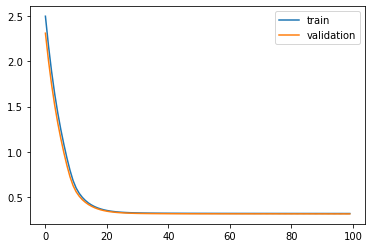

Time to train LSTM:  107.89915609359741
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 40s - loss: 2.8223 - acc: 0.4895 - val_loss: 2.5727 - val_acc: 0.5500

Epoch 00001: val_loss improved from inf to 2.57269, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.4152 - acc: 0.5792 - val_loss: 2.2152 - val_acc: 0.6277

Epoch 00002: val_loss improved from 2.57269 to 2.21519, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 2.0831 - acc: 0.6499 - val_loss: 1.9195 - val_acc: 0.6809

Epoch 00003: val_loss improved from 2.21519 to 1.91955, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.8061 - acc: 0.6982 - val_loss: 1.6693 - val_acc: 0.7168

Epoch 00004: val_loss improved from 1.91955 to 1.66934, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5705 - acc: 0.7332 - val_loss: 1.4544 - val_acc: 0.7464

Epoch 00005: val_loss improved from 1.66934 to 1.45442, saving model to Event_val_weights2.hdf5
Epoch 6/1

 - 1s - loss: 0.3194 - acc: 0.8801 - val_loss: 0.3262 - val_acc: 0.8756

Epoch 00046: val_loss improved from 0.32618 to 0.32616, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8800 - val_loss: 0.3261 - val_acc: 0.8756

Epoch 00047: val_loss improved from 0.32616 to 0.32614, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8800 - val_loss: 0.3260 - val_acc: 0.8758

Epoch 00048: val_loss improved from 0.32614 to 0.32599, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8802 - val_loss: 0.3258 - val_acc: 0.8756

Epoch 00049: val_loss improved from 0.32599 to 0.32576, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8801 - val_loss: 0.3259 - val_acc: 0.8757

Epoch 00050: val_loss did not improve from 0.32576
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8802 - val_loss: 0.3258 - val_acc: 0.8754

Epoch 00051: val_loss did not improve from 0.32576
Epoch 52/10

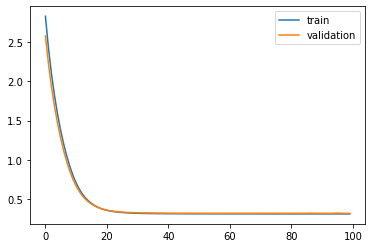

Time to train LSTM:  117.0575475692749
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 2.8428 - acc: 0.5560 - val_loss: 2.5898 - val_acc: 0.6043

Epoch 00001: val_loss improved from inf to 2.58977, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.4200 - acc: 0.6357 - val_loss: 2.2214 - val_acc: 0.6676

Epoch 00002: val_loss improved from 2.58977 to 2.22143, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 2.0815 - acc: 0.6901 - val_loss: 1.9177 - val_acc: 0.7102

Epoch 00003: val_loss improved from 2.22143 to 1.91770, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.7978 - acc: 0.7242 - val_loss: 1.6609 - val_acc: 0.7372

Epoch 00004: val_loss improved from 1.91770 to 1.66092, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5574 - acc: 0.7499 - val_loss: 1.4425 - val_acc: 0.7567

Epoch 00005: val_loss improved from 1.66092 to 1.44247, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3175 - acc: 0.8796 - val_loss: 0.3252 - val_acc: 0.8777

Epoch 00046: val_loss improved from 0.32530 to 0.32518, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3175 - acc: 0.8795 - val_loss: 0.3250 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32518 to 0.32500, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3173 - acc: 0.8795 - val_loss: 0.3249 - val_acc: 0.8773

Epoch 00048: val_loss improved from 0.32500 to 0.32491, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3172 - acc: 0.8796 - val_loss: 0.3248 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32491 to 0.32480, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3171 - acc: 0.8796 - val_loss: 0.3248 - val_acc: 0.8767

Epoch 00050: val_loss improved from 0.32480 to 0.32477, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3171 - acc: 0.8794 - val_loss: 0.3246 - val_acc: 0.8769

Epoch 00051: val_

 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3238 - val_acc: 0.8772

Epoch 00098: val_loss improved from 0.32380 to 0.32379, saving model to Event_val_weights3.hdf5
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3239 - val_acc: 0.8772

Epoch 00099: val_loss did not improve from 0.32379
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3238 - val_acc: 0.8771

Epoch 00100: val_loss did not improve from 0.32379
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.13021705624244753
best val loss: 0.3237887923452589
#################################


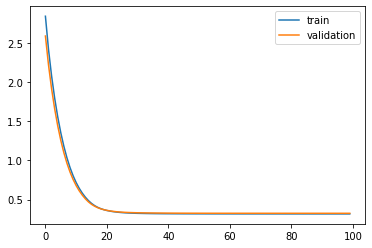

Time to train LSTM:  113.5733790397644
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 60s - loss: 2.7256 - acc: 0.5769 - val_loss: 2.5105 - val_acc: 0.6150

Epoch 00001: val_loss improved from inf to 2.51055, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.3444 - acc: 0.6421 - val_loss: 2.1663 - val_acc: 0.6642

Epoch 00002: val_loss improved from 2.51055 to 2.16628, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0251 - acc: 0.6847 - val_loss: 1.8719 - val_acc: 0.7008

Epoch 00003: val_loss improved from 2.16628 to 1.87193, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7517 - acc: 0.7170 - val_loss: 1.6183 - val_acc: 0.7301

Epoch 00004: val_loss improved from 1.87193 to 1.61835, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5164 - acc: 0.7430 - val_loss: 1.4002 - val_acc: 0.7553

Epoch 00005: val_loss improved from 1.61835 to 1.40024, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3190 - acc: 0.8802 - val_loss: 0.3332 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33320 to 0.33316, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8802 - val_loss: 0.3331 - val_acc: 0.8710

Epoch 00047: val_loss improved from 0.33316 to 0.33305, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8803 - val_loss: 0.3334 - val_acc: 0.8711

Epoch 00048: val_loss did not improve from 0.33305
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8804 - val_loss: 0.3334 - val_acc: 0.8712

Epoch 00049: val_loss did not improve from 0.33305
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8804 - val_loss: 0.3331 - val_acc: 0.8708

Epoch 00050: val_loss did not improve from 0.33305
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8804 - val_loss: 0.3330 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.33305 to 0.33303, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3186 - acc: 0.8804 - val_lo

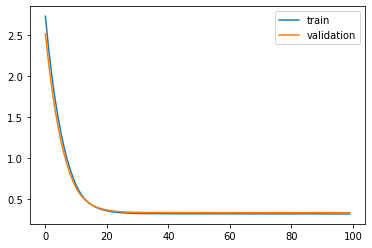

Time to train LSTM:  137.80683374404907
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 34s - loss: 2.6672 - acc: 0.5839 - val_loss: 2.4436 - val_acc: 0.6368

Epoch 00001: val_loss improved from inf to 2.44364, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2925 - acc: 0.6654 - val_loss: 2.1120 - val_acc: 0.6953

Epoch 00002: val_loss improved from 2.44364 to 2.11204, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9849 - acc: 0.7097 - val_loss: 1.8298 - val_acc: 0.7261

Epoch 00003: val_loss improved from 2.11204 to 1.82975, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.7207 - acc: 0.7358 - val_loss: 1.5857 - val_acc: 0.7517

Epoch 00004: val_loss improved from 1.82975 to 1.58569, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4923 - acc: 0.7575 - val_loss: 1.3743 - val_acc: 0.7743

Epoch 00005: val_loss improved from 1.58569 to 1.37434, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3199 - acc: 0.8792 - val_loss: 0.3204 - val_acc: 0.8783

Epoch 00046: val_loss improved from 0.32059 to 0.32044, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8792 - val_loss: 0.3203 - val_acc: 0.8780

Epoch 00047: val_loss improved from 0.32044 to 0.32033, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8793 - val_loss: 0.3202 - val_acc: 0.8782

Epoch 00048: val_loss improved from 0.32033 to 0.32020, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8793 - val_loss: 0.3201 - val_acc: 0.8783

Epoch 00049: val_loss improved from 0.32020 to 0.32010, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8794 - val_loss: 0.3200 - val_acc: 0.8788

Epoch 00050: val_loss improved from 0.32010 to 0.32000, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8793 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00051: val_

 - 1s - loss: 0.3171 - acc: 0.8797 - val_loss: 0.3187 - val_acc: 0.8798

Epoch 00095: val_loss improved from 0.31867 to 0.31867, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8797 - val_loss: 0.3187 - val_acc: 0.8800

Epoch 00096: val_loss did not improve from 0.31867
Epoch 97/100
 - 1s - loss: 0.3170 - acc: 0.8797 - val_loss: 0.3187 - val_acc: 0.8800

Epoch 00097: val_loss improved from 0.31867 to 0.31865, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3170 - acc: 0.8797 - val_loss: 0.3187 - val_acc: 0.8801

Epoch 00098: val_loss did not improve from 0.31865
Epoch 99/100
 - 1s - loss: 0.3170 - acc: 0.8797 - val_loss: 0.3187 - val_acc: 0.8798

Epoch 00099: val_loss did not improve from 0.31865
Epoch 100/100
 - 1s - loss: 0.3169 - acc: 0.8796 - val_loss: 0.3187 - val_acc: 0.8797

Epoch 00100: val_loss did not improve from 0.31865
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.13021705624244

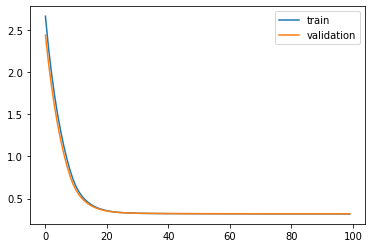

Time to train LSTM:  120.74470973014832


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe45423e630>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 2.5004 - acc: 0.4830 - val_loss: 2.3069 - val_acc: 0.5341

Epoch 00001: val_loss improved from inf to 2.30692, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.1702 - acc: 0.5711 - val_loss: 2.0020 - val_acc: 0.6197

Epoch 00002: val_loss improved from 2.30692 to 2.00204, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.8875 - acc: 0.6412 - val_loss: 1.7432 - val_acc: 0.6776

Epoch 00003: val_loss improved from 2.00204 to 1.74322, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.6469 - acc: 0.6885 - val_loss: 1.5231 - val_acc: 0.7139

Epoch 00004: val_loss improved from 1.74322 to 1.52314, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4414 - acc: 0.7210 - val_loss: 1.3340 - val_acc: 0.7421

Epoch 00005: val_loss improved from 1.52314 to 1.33405, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.2641 - acc: 0.7491 - 

 - 1s - loss: 0.3209 - acc: 0.8792 - val_loss: 0.3189 - val_acc: 0.8818

Epoch 00046: val_loss improved from 0.31891 to 0.31889, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3207 - acc: 0.8791 - val_loss: 0.3188 - val_acc: 0.8816

Epoch 00047: val_loss improved from 0.31889 to 0.31884, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8791 - val_loss: 0.3188 - val_acc: 0.8813

Epoch 00048: val_loss improved from 0.31884 to 0.31883, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3205 - acc: 0.8791 - val_loss: 0.3186 - val_acc: 0.8812

Epoch 00049: val_loss improved from 0.31883 to 0.31863, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8792 - val_loss: 0.3186 - val_acc: 0.8810

Epoch 00050: val_loss improved from 0.31863 to 0.31861, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3202 - acc: 0.8794 - val_loss: 0.3185 - val_acc: 0.8807

Epoch 00051: val_

 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3168 - val_acc: 0.8814

Epoch 00098: val_loss did not improve from 0.31654
Epoch 99/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3168 - val_acc: 0.8814

Epoch 00099: val_loss did not improve from 0.31654
Epoch 100/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3169 - val_acc: 0.8813

Epoch 00100: val_loss did not improve from 0.31654
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.12364066438114389
best val loss: 0.31654450885454816
#################################


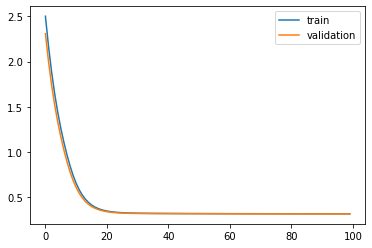

Time to train LSTM:  123.1472704410553
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 2.5871 - acc: 0.5940 - val_loss: 2.3878 - val_acc: 0.6192

Epoch 00001: val_loss improved from inf to 2.38781, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.2443 - acc: 0.6407 - val_loss: 2.0710 - val_acc: 0.6601

Epoch 00002: val_loss improved from 2.38781 to 2.07098, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9470 - acc: 0.6752 - val_loss: 1.7974 - val_acc: 0.6913

Epoch 00003: val_loss improved from 2.07098 to 1.79742, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.6910 - acc: 0.7041 - val_loss: 1.5635 - val_acc: 0.7163

Epoch 00004: val_loss improved from 1.79742 to 1.56351, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4716 - acc: 0.7277 - val_loss: 1.3636 - val_acc: 0.7404

Epoch 00005: val_loss improved from 1.56351 to 1.36362, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3199 - acc: 0.8792 - val_loss: 0.3277 - val_acc: 0.8753

Epoch 00046: val_loss improved from 0.32787 to 0.32769, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8792 - val_loss: 0.3276 - val_acc: 0.8754

Epoch 00047: val_loss improved from 0.32769 to 0.32765, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3197 - acc: 0.8792 - val_loss: 0.3274 - val_acc: 0.8756

Epoch 00048: val_loss improved from 0.32765 to 0.32740, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8791 - val_loss: 0.3274 - val_acc: 0.8757

Epoch 00049: val_loss improved from 0.32740 to 0.32737, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8790 - val_loss: 0.3271 - val_acc: 0.8758

Epoch 00050: val_loss improved from 0.32737 to 0.32710, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8790 - val_loss: 0.3270 - val_acc: 0.8759

Epoch 00051: val_


Epoch 00096: val_loss did not improve from 0.32432
Epoch 97/100
 - 1s - loss: 0.3161 - acc: 0.8802 - val_loss: 0.3242 - val_acc: 0.8770

Epoch 00097: val_loss improved from 0.32432 to 0.32424, saving model to Event_val_weights2.hdf5
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3243 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32424
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8803 - val_loss: 0.3242 - val_acc: 0.8767

Epoch 00099: val_loss improved from 0.32424 to 0.32420, saving model to Event_val_weights2.hdf5
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8803 - val_loss: 0.3243 - val_acc: 0.8769

Epoch 00100: val_loss did not improve from 0.32420
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.12364066438114389
best val loss: 0.32419608362515767
#################################


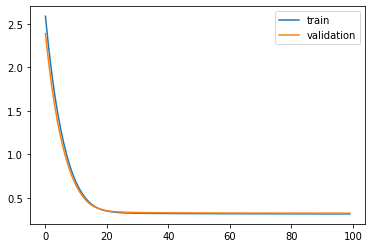

Time to train LSTM:  110.4632785320282
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 2.6192 - acc: 0.5123 - val_loss: 2.4075 - val_acc: 0.5548

Epoch 00001: val_loss improved from inf to 2.40754, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.2465 - acc: 0.5942 - val_loss: 2.0752 - val_acc: 0.6320

Epoch 00002: val_loss improved from 2.40754 to 2.07519, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.9421 - acc: 0.6559 - val_loss: 1.8002 - val_acc: 0.6777

Epoch 00003: val_loss improved from 2.07519 to 1.80025, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.6882 - acc: 0.6971 - val_loss: 1.5684 - val_acc: 0.7147

Epoch 00004: val_loss improved from 1.80025 to 1.56837, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4727 - acc: 0.7276 - val_loss: 1.3707 - val_acc: 0.7443

Epoch 00005: val_loss improved from 1.56837 to 1.37074, saving model to Event_val_weights3.hdf5
Epoch 6/10


Epoch 00046: val_loss did not improve from 0.32612
Epoch 47/100
 - 1s - loss: 0.3178 - acc: 0.8799 - val_loss: 0.3260 - val_acc: 0.8773

Epoch 00047: val_loss improved from 0.32612 to 0.32603, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3261 - val_acc: 0.8774

Epoch 00048: val_loss did not improve from 0.32603
Epoch 49/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3260 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32603 to 0.32598, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3260 - val_acc: 0.8774

Epoch 00050: val_loss improved from 0.32598 to 0.32597, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3258 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32597 to 0.32585, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3176 - acc: 0.8799 - val_loss: 0.3258 - val_acc: 0.877


Epoch 00099: val_loss did not improve from 0.32526
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8803 - val_loss: 0.3253 - val_acc: 0.8780

Epoch 00100: val_loss improved from 0.32526 to 0.32525, saving model to Event_val_weights3.hdf5
#################################
Number of units: 8
Batch size: 8192
Fold: 2
L2_1: 0.12364066438114389
best val loss: 0.32525325022803414
#################################


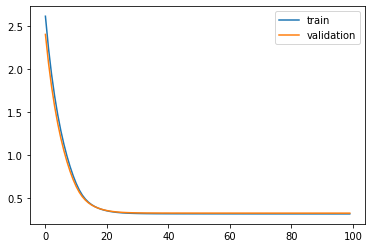

Time to train LSTM:  109.1343457698822
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 34s - loss: 2.7030 - acc: 0.5069 - val_loss: 2.4903 - val_acc: 0.5488

Epoch 00001: val_loss improved from inf to 2.49027, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.3291 - acc: 0.5838 - val_loss: 2.1556 - val_acc: 0.6221

Epoch 00002: val_loss improved from 2.49027 to 2.15555, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 2.0191 - acc: 0.6453 - val_loss: 1.8717 - val_acc: 0.6699

Epoch 00003: val_loss improved from 2.15555 to 1.87175, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.7543 - acc: 0.6872 - val_loss: 1.6280 - val_acc: 0.6977

Epoch 00004: val_loss improved from 1.87175 to 1.62800, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5265 - acc: 0.7170 - val_loss: 1.4178 - val_acc: 0.7267

Epoch 00005: val_loss improved from 1.62800 to 1.41776, saving model to Event_val_weights4.hdf5
Epoch 6/10

 - 1s - loss: 0.3171 - acc: 0.8803 - val_loss: 0.3313 - val_acc: 0.8709

Epoch 00046: val_loss improved from 0.33141 to 0.33134, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3170 - acc: 0.8803 - val_loss: 0.3313 - val_acc: 0.8706

Epoch 00047: val_loss improved from 0.33134 to 0.33131, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3169 - acc: 0.8803 - val_loss: 0.3313 - val_acc: 0.8704

Epoch 00048: val_loss improved from 0.33131 to 0.33126, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3168 - acc: 0.8802 - val_loss: 0.3312 - val_acc: 0.8701

Epoch 00049: val_loss improved from 0.33126 to 0.33120, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3167 - acc: 0.8802 - val_loss: 0.3311 - val_acc: 0.8702

Epoch 00050: val_loss improved from 0.33120 to 0.33114, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3166 - acc: 0.8802 - val_loss: 0.3311 - val_acc: 0.8701

Epoch 00051: val_


Epoch 00096: val_loss did not improve from 0.32999
Epoch 97/100
 - 1s - loss: 0.3144 - acc: 0.8808 - val_loss: 0.3302 - val_acc: 0.8702

Epoch 00097: val_loss did not improve from 0.32999
Epoch 98/100
 - 1s - loss: 0.3144 - acc: 0.8809 - val_loss: 0.3303 - val_acc: 0.8702

Epoch 00098: val_loss did not improve from 0.32999
Epoch 99/100
 - 1s - loss: 0.3143 - acc: 0.8809 - val_loss: 0.3302 - val_acc: 0.8702

Epoch 00099: val_loss did not improve from 0.32999
Epoch 100/100
 - 1s - loss: 0.3143 - acc: 0.8810 - val_loss: 0.3303 - val_acc: 0.8700

Epoch 00100: val_loss did not improve from 0.32999
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.12364066438114389
best val loss: 0.32998805030186973
#################################


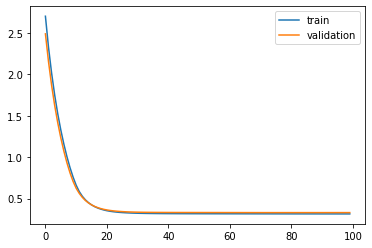

Time to train LSTM:  114.60099172592163
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.5972 - acc: 0.5304 - val_loss: 2.3988 - val_acc: 0.5580

Epoch 00001: val_loss improved from inf to 2.39880, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.2517 - acc: 0.5823 - val_loss: 2.0799 - val_acc: 0.6123

Epoch 00002: val_loss improved from 2.39880 to 2.07993, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.9524 - acc: 0.6351 - val_loss: 1.8033 - val_acc: 0.6664

Epoch 00003: val_loss improved from 2.07993 to 1.80328, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.6928 - acc: 0.6845 - val_loss: 1.5629 - val_acc: 0.7118

Epoch 00004: val_loss improved from 1.80328 to 1.56294, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4678 - acc: 0.7254 - val_loss: 1.3543 - val_acc: 0.7432

Epoch 00005: val_loss improved from 1.56294 to 1.35433, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3200 - acc: 0.8790 - val_loss: 0.3205 - val_acc: 0.8784

Epoch 00046: val_loss improved from 0.32057 to 0.32047, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3199 - acc: 0.8791 - val_loss: 0.3203 - val_acc: 0.8782

Epoch 00047: val_loss improved from 0.32047 to 0.32032, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3198 - acc: 0.8790 - val_loss: 0.3202 - val_acc: 0.8787

Epoch 00048: val_loss improved from 0.32032 to 0.32023, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3197 - acc: 0.8790 - val_loss: 0.3200 - val_acc: 0.8783

Epoch 00049: val_loss improved from 0.32023 to 0.32004, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8789 - val_loss: 0.3200 - val_acc: 0.8783

Epoch 00050: val_loss improved from 0.32004 to 0.31999, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8790 - val_loss: 0.3198 - val_acc: 0.8786

Epoch 00051: val_


Epoch 00096: val_loss improved from 0.31838 to 0.31835, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8799 - val_loss: 0.3184 - val_acc: 0.8802

Epoch 00097: val_loss did not improve from 0.31835
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8797 - val_loss: 0.3182 - val_acc: 0.8797

Epoch 00098: val_loss improved from 0.31835 to 0.31820, saving model to Event_val_weights5.hdf5
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8799 - val_loss: 0.3183 - val_acc: 0.8801

Epoch 00099: val_loss did not improve from 0.31820
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3183 - val_acc: 0.8798

Epoch 00100: val_loss did not improve from 0.31820
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.12364066438114389
best val loss: 0.31820276917351614
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.139286015143

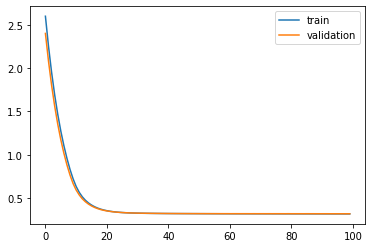

Time to train LSTM:  110.59623551368713
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.5821 - acc: 0.5510 - val_loss: 2.3730 - val_acc: 0.5960

Epoch 00001: val_loss improved from inf to 2.37304, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 2.2341 - acc: 0.6192 - val_loss: 2.0536 - val_acc: 0.6499

Epoch 00002: val_loss improved from 2.37304 to 2.05362, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 1.9389 - acc: 0.6632 - val_loss: 1.7812 - val_acc: 0.6913

Epoch 00003: val_loss improved from 2.05362 to 1.78117, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 1.6852 - acc: 0.6969 - val_loss: 1.5474 - val_acc: 0.7209

Epoch 00004: val_loss improved from 1.78117 to 1.54740, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4666 - acc: 0.7244 - val_loss: 1.3463 - val_acc: 0.7477

Epoch 00005: val_loss improved from 1.54740 to 1.34633, saving model to Event_val_weights1.hdf5
Epoch 6/1

 - 1s - loss: 0.3213 - acc: 0.8784 - val_loss: 0.3158 - val_acc: 0.8799

Epoch 00046: val_loss improved from 0.31596 to 0.31578, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3212 - acc: 0.8783 - val_loss: 0.3156 - val_acc: 0.8799

Epoch 00047: val_loss improved from 0.31578 to 0.31562, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3210 - acc: 0.8783 - val_loss: 0.3155 - val_acc: 0.8798

Epoch 00048: val_loss improved from 0.31562 to 0.31545, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3208 - acc: 0.8784 - val_loss: 0.3153 - val_acc: 0.8800

Epoch 00049: val_loss improved from 0.31545 to 0.31530, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3207 - acc: 0.8785 - val_loss: 0.3152 - val_acc: 0.8800

Epoch 00050: val_loss improved from 0.31530 to 0.31515, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3205 - acc: 0.8785 - val_loss: 0.3150 - val_acc: 0.8802

Epoch 00051: val_

 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3135 - val_acc: 0.8807

Epoch 00097: val_loss did not improve from 0.31325
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3135 - val_acc: 0.8808

Epoch 00098: val_loss did not improve from 0.31325
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3137 - val_acc: 0.8808

Epoch 00099: val_loss did not improve from 0.31325
Epoch 100/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3134 - val_acc: 0.8806

Epoch 00100: val_loss did not improve from 0.31325
#################################
Number of units: 8
Batch size: 8192
Fold: 0
L2_1: 0.12091317507811673
best val loss: 0.31324749904208715
#################################


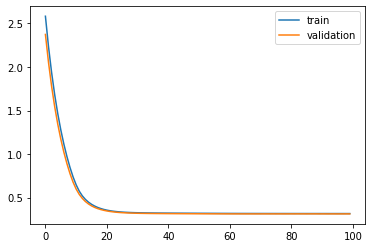

Time to train LSTM:  111.3576500415802
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 2.7290 - acc: 0.4295 - val_loss: 2.4740 - val_acc: 0.4751

Epoch 00001: val_loss improved from inf to 2.47397, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 2.3013 - acc: 0.5250 - val_loss: 2.1037 - val_acc: 0.5792

Epoch 00002: val_loss improved from 2.47397 to 2.10372, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 1.9699 - acc: 0.6182 - val_loss: 1.8128 - val_acc: 0.6568

Epoch 00003: val_loss improved from 2.10372 to 1.81279, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 1.7010 - acc: 0.6865 - val_loss: 1.5710 - val_acc: 0.7108

Epoch 00004: val_loss improved from 1.81279 to 1.57103, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4743 - acc: 0.7346 - val_loss: 1.3653 - val_acc: 0.7508

Epoch 00005: val_loss improved from 1.57103 to 1.36534, saving model to Event_val_weights2.hdf5
Epoch 6/10

 - 1s - loss: 0.3190 - acc: 0.8798 - val_loss: 0.3264 - val_acc: 0.8761

Epoch 00046: val_loss improved from 0.32651 to 0.32636, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8799 - val_loss: 0.3260 - val_acc: 0.8757

Epoch 00047: val_loss improved from 0.32636 to 0.32605, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8800 - val_loss: 0.3260 - val_acc: 0.8761

Epoch 00048: val_loss improved from 0.32605 to 0.32603, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8799 - val_loss: 0.3258 - val_acc: 0.8761

Epoch 00049: val_loss improved from 0.32603 to 0.32581, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8799 - val_loss: 0.3258 - val_acc: 0.8763

Epoch 00050: val_loss improved from 0.32581 to 0.32579, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3256 - val_acc: 0.8759

Epoch 00051: val_

 - 1s - loss: 0.3161 - acc: 0.8803 - val_loss: 0.3248 - val_acc: 0.8747

Epoch 00098: val_loss did not improve from 0.32444
Epoch 99/100
 - 1s - loss: 0.3161 - acc: 0.8802 - val_loss: 0.3245 - val_acc: 0.8748

Epoch 00099: val_loss did not improve from 0.32444
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8803 - val_loss: 0.3248 - val_acc: 0.8747

Epoch 00100: val_loss did not improve from 0.32444
#################################
Number of units: 8
Batch size: 8192
Fold: 1
L2_1: 0.12091317507811673
best val loss: 0.32444338329633077
#################################


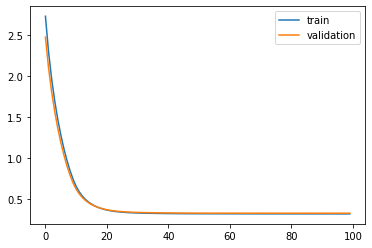

Time to train LSTM:  109.6963701248169
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 2.4845 - acc: 0.5255 - val_loss: 2.3018 - val_acc: 0.5668

Epoch 00001: val_loss improved from inf to 2.30183, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 2.1570 - acc: 0.6132 - val_loss: 1.9997 - val_acc: 0.6538

Epoch 00002: val_loss improved from 2.30183 to 1.99970, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 1.8745 - acc: 0.6857 - val_loss: 1.7392 - val_acc: 0.7110

Epoch 00003: val_loss improved from 1.99970 to 1.73918, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 1.6314 - acc: 0.7312 - val_loss: 1.5146 - val_acc: 0.7423

Epoch 00004: val_loss improved from 1.73918 to 1.51464, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4216 - acc: 0.7584 - val_loss: 1.3208 - val_acc: 0.7649

Epoch 00005: val_loss improved from 1.51464 to 1.32082, saving model to Event_val_weights3.hdf5
Epoch 6/10

 - 1s - loss: 0.3184 - acc: 0.8799 - val_loss: 0.3268 - val_acc: 0.8777

Epoch 00046: val_loss improved from 0.32695 to 0.32682, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3266 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32682 to 0.32659, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8799 - val_loss: 0.3267 - val_acc: 0.8779

Epoch 00048: val_loss did not improve from 0.32659
Epoch 49/100
 - 1s - loss: 0.3180 - acc: 0.8800 - val_loss: 0.3267 - val_acc: 0.8778

Epoch 00049: val_loss did not improve from 0.32659
Epoch 50/100
 - 1s - loss: 0.3179 - acc: 0.8800 - val_loss: 0.3265 - val_acc: 0.8780

Epoch 00050: val_loss improved from 0.32659 to 0.32653, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3179 - acc: 0.8802 - val_loss: 0.3267 - val_acc: 0.8773

Epoch 00051: val_loss did not improve from 0.32653
Epoch 52/100
 - 1s - loss: 0.3178 - acc: 0.8803 - val_lo

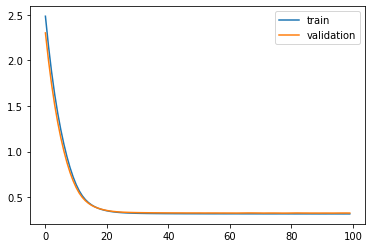

Time to train LSTM:  109.05039548873901
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.5378 - acc: 0.5583 - val_loss: 2.3564 - val_acc: 0.5886

Epoch 00001: val_loss improved from inf to 2.35644, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 2.1988 - acc: 0.6164 - val_loss: 2.0428 - val_acc: 0.6426

Epoch 00002: val_loss improved from 2.35644 to 2.04284, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 1.9055 - acc: 0.6637 - val_loss: 1.7710 - val_acc: 0.6804

Epoch 00003: val_loss improved from 2.04284 to 1.77097, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 1.6508 - acc: 0.7026 - val_loss: 1.5347 - val_acc: 0.7158

Epoch 00004: val_loss improved from 1.77097 to 1.53473, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4296 - acc: 0.7379 - val_loss: 1.3300 - val_acc: 0.7440

Epoch 00005: val_loss improved from 1.53473 to 1.33001, saving model to Event_val_weights4.hdf5
Epoch 6/1

 - 1s - loss: 0.3166 - acc: 0.8801 - val_loss: 0.3304 - val_acc: 0.8706

Epoch 00046: val_loss improved from 0.33050 to 0.33038, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3165 - acc: 0.8803 - val_loss: 0.3305 - val_acc: 0.8708

Epoch 00047: val_loss did not improve from 0.33038
Epoch 48/100
 - 1s - loss: 0.3164 - acc: 0.8804 - val_loss: 0.3304 - val_acc: 0.8709

Epoch 00048: val_loss did not improve from 0.33038
Epoch 49/100
 - 1s - loss: 0.3164 - acc: 0.8803 - val_loss: 0.3305 - val_acc: 0.8710

Epoch 00049: val_loss did not improve from 0.33038
Epoch 50/100
 - 1s - loss: 0.3163 - acc: 0.8804 - val_loss: 0.3305 - val_acc: 0.8709

Epoch 00050: val_loss did not improve from 0.33038
Epoch 51/100
 - 1s - loss: 0.3162 - acc: 0.8804 - val_loss: 0.3304 - val_acc: 0.8709

Epoch 00051: val_loss did not improve from 0.33038
Epoch 52/100
 - 1s - loss: 0.3162 - acc: 0.8803 - val_loss: 0.3305 - val_acc: 0.8706

Epoch 00052: val_loss did not improve from 0.33038
Epoch 53/

 - 1s - loss: 0.3144 - acc: 0.8811 - val_loss: 0.3297 - val_acc: 0.8706

Epoch 00098: val_loss did not improve from 0.32951
Epoch 99/100
 - 1s - loss: 0.3143 - acc: 0.8811 - val_loss: 0.3296 - val_acc: 0.8704

Epoch 00099: val_loss did not improve from 0.32951
Epoch 100/100
 - 1s - loss: 0.3143 - acc: 0.8812 - val_loss: 0.3297 - val_acc: 0.8702

Epoch 00100: val_loss did not improve from 0.32951
#################################
Number of units: 8
Batch size: 8192
Fold: 3
L2_1: 0.12091317507811673
best val loss: 0.3295110450055864
#################################


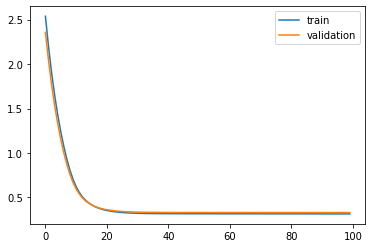

Time to train LSTM:  109.77117109298706
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 2.3913 - acc: 0.5868 - val_loss: 2.2105 - val_acc: 0.6194

Epoch 00001: val_loss improved from inf to 2.21046, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 2.0784 - acc: 0.6370 - val_loss: 1.9219 - val_acc: 0.6611

Epoch 00002: val_loss improved from 2.21046 to 1.92191, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 1.8083 - acc: 0.6783 - val_loss: 1.6723 - val_acc: 0.6940

Epoch 00003: val_loss improved from 1.92191 to 1.67226, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 1.5741 - acc: 0.7129 - val_loss: 1.4553 - val_acc: 0.7232

Epoch 00004: val_loss improved from 1.67226 to 1.45527, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3705 - acc: 0.7394 - val_loss: 1.2661 - val_acc: 0.7491

Epoch 00005: val_loss improved from 1.45527 to 1.26607, saving model to Event_val_weights5.hdf5
Epoch 6/1

 - 1s - loss: 0.3197 - acc: 0.8790 - val_loss: 0.3219 - val_acc: 0.8784

Epoch 00046: val_loss improved from 0.32196 to 0.32185, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8791 - val_loss: 0.3219 - val_acc: 0.8787

Epoch 00047: val_loss did not improve from 0.32185
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8791 - val_loss: 0.3218 - val_acc: 0.8787

Epoch 00048: val_loss improved from 0.32185 to 0.32179, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8790 - val_loss: 0.3218 - val_acc: 0.8784

Epoch 00049: val_loss did not improve from 0.32179
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8790 - val_loss: 0.3217 - val_acc: 0.8786

Epoch 00050: val_loss improved from 0.32179 to 0.32167, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8791 - val_loss: 0.3215 - val_acc: 0.8783

Epoch 00051: val_loss improved from 0.32167 to 0.32153, saving model to Event_val_weights5.hdf5
Epoch 52/10

 - 1s - loss: 0.3164 - acc: 0.8797 - val_loss: 0.3202 - val_acc: 0.8786

Epoch 00098: val_loss did not improve from 0.32007
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3201 - val_acc: 0.8784

Epoch 00099: val_loss improved from 0.32007 to 0.32006, saving model to Event_val_weights5.hdf5
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3204 - val_acc: 0.8786

Epoch 00100: val_loss did not improve from 0.32006
#################################
Number of units: 8
Batch size: 8192
Fold: 4
L2_1: 0.12091317507811673
best val loss: 0.32006476232740616
#################################
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 1, 0.32368245164553

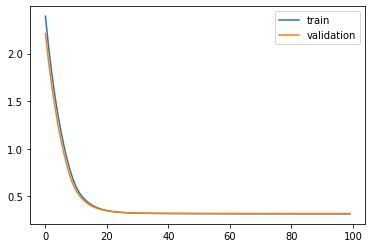

Time to train LSTM:  109.84353303909302
Entire process took:  12063.221755743027
Experiment record:
[[8, 8192, 0.13928601514360017, 0, 0.31342351322703893], [8, 8192, 0.13928601514360017, 1, 0.3238393450578054], [8, 8192, 0.13928601514360017, 2, 0.3264032313028971], [8, 8192, 0.13928601514360017, 3, 0.3297080023818546], [8, 8192, 0.13928601514360017, 4, 0.31892433892356026], [8, 8192, 0.08319798053011772, 0, 0.3121349759366777], [8, 8192, 0.08319798053011772, 1, 0.3236824516455332], [8, 8192, 0.08319798053011772, 2, 0.3242554585668776], [8, 8192, 0.08319798053011772, 3, 0.32970055060916476], [8, 8192, 0.08319798053011772, 4, 0.3224302625921037], [8, 8192, 0.13212291230578316, 0, 0.31389645261234705], [8, 8192, 0.13212291230578316, 1, 0.32574390784899393], [8, 8192, 0.13212291230578316, 2, 0.3268150253560808], [8, 8192, 0.13212291230578316, 3, 0.3314819699393378], [8, 8192, 0.13212291230578316, 4, 0.32203768446710374], [8, 8192, 0.05416966257252499, 0, 0.3158049712446001], [8, 8192, 0.0

In [13]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

# LSTM
#units = 16
#batch_s = 16384

# Simple RNN
units = 8
batch_s = 8192

start_time = time.time()

exp_record = []

for i in range(len(L2_1_list)):
    L2_1 = L2_1_list[i]
    #L2_2 = L2_2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) 
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(SimpleRNN(units, 
                                kernel_regularizer=regularizers.l2(L2_1),
                                #return_sequences=True, 
                                input_shape=(8, 182))) 
            #model.add(CuDNNLSTM(units, 
            #                    kernel_regularizer=regularizers.l2(L2_2)))
            model.add(Dense(2, activation='softmax'))
            model.compile(loss='categorical_crossentropy', 
                          optimizer='adam', metrics=['accuracy'])
            val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("Fold:", f)
            print("L2_1:", L2_1)
            #print("L2_2:", L2_2)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, f, min(history.history['val_loss'])])
            #exp_record.append([units, batch_s, L2_1, L2_2, f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
        end_time = time.time()
        print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [14]:
#exp_record = [[16, 16384, 0.14670298390136766, 0, 0.3132003843784332], [16, 16384, 0.14670298390136766, 1, 0.3234946131706238], [16, 16384, 0.14670298390136766, 2, 0.32347333431243896], [16, 16384, 0.14670298390136766, 3, 0.3281570076942444], [16, 16384, 0.14670298390136766, 4, 0.31874898076057434], [16, 16384, 0.10472322491757223, 0, 0.31347230076789856], [16, 16384, 0.10472322491757223, 1, 0.3229997456073761], [16, 16384, 0.10472322491757223, 2, 0.32400357723236084], [16, 16384, 0.10472322491757223, 3, 0.32788795232772827], [16, 16384, 0.10472322491757223, 4, 0.3181871771812439], [16, 16384, 0.14726843599648842, 0, 0.3128780424594879], [16, 16384, 0.14726843599648842, 1, 0.3233289420604706], [16, 16384, 0.14726843599648842, 2, 0.3236597776412964], [16, 16384, 0.14726843599648842, 3, 0.3281111419200897], [16, 16384, 0.14726843599648842, 4, 0.3185248374938965], [16, 16384, 0.12148159936743647, 0, 0.31249499320983887], [16, 16384, 0.12148159936743647, 1, 0.3231829106807709], [16, 16384, 0.12148159936743647, 2, 0.32358279824256897], [16, 16384, 0.12148159936743647, 3, 0.32796597480773926], [16, 16384, 0.12148159936743647, 4, 0.3182612657546997], [16, 16384, 0.11977288245972707, 0, 0.3128148913383484], [16, 16384, 0.11977288245972707, 1, 0.32302331924438477], [16, 16384, 0.11977288245972707, 2, 0.3240733742713928], [16, 16384, 0.11977288245972707, 3, 0.3278117775917053], [16, 16384, 0.11977288245972707, 4, 0.31881678104400635], [16, 16384, 0.07160894955803764, 0, 0.3131681978702545], [16, 16384, 0.07160894955803764, 1, 0.3228434920310974], [16, 16384, 0.07160894955803764, 2, 0.3230917751789093], [16, 16384, 0.07160894955803764, 3, 0.3274252712726593], [16, 16384, 0.07160894955803764, 4, 0.3179936707019806], [16, 16384, 0.1476274454776242, 0, 0.3133706748485565], [16, 16384, 0.1476274454776242, 1, 0.3230186700820923], [16, 16384, 0.1476274454776242, 2, 0.32339614629745483], [16, 16384, 0.1476274454776242, 3, 0.3280078172683716], [16, 16384, 0.1476274454776242, 4, 0.31842514872550964], [16, 16384, 0.05062302552045899, 0, 0.3131609261035919], [16, 16384, 0.05062302552045899, 1, 0.3222581446170807], [16, 16384, 0.05062302552045899, 2, 0.3237561583518982], [16, 16384, 0.05062302552045899, 3, 0.32773149013519287], [16, 16384, 0.05062302552045899, 4, 0.317837119102478], [16, 16384, 0.07529823623834439, 0, 0.3132457137107849], [16, 16384, 0.07529823623834439, 1, 0.3230583071708679], [16, 16384, 0.07529823623834439, 2, 0.3234211206436157], [16, 16384, 0.07529823623834439, 3, 0.32745328545570374], [16, 16384, 0.07529823623834439, 4, 0.317659854888916], [16, 16384, 0.09347915324044458, 0, 0.31254786252975464], [16, 16384, 0.09347915324044458, 1, 0.3226998448371887], [16, 16384, 0.09347915324044458, 2, 0.32380953431129456], [16, 16384, 0.09347915324044458, 3, 0.3280501067638397], [16, 16384, 0.09347915324044458, 4, 0.31785979866981506], [16, 16384, 0.12793829217937525, 0, 0.31314748525619507], [16, 16384, 0.12793829217937525, 1, 0.3232339322566986], [16, 16384, 0.12793829217937525, 2, 0.3241264224052429], [16, 16384, 0.12793829217937525, 3, 0.3278678059577942], [16, 16384, 0.12793829217937525, 4, 0.31844136118888855], [16, 16384, 0.0697685074600253, 0, 0.312503844499588], [16, 16384, 0.0697685074600253, 1, 0.32309064269065857], [16, 16384, 0.0697685074600253, 2, 0.32339638471603394], [16, 16384, 0.0697685074600253, 3, 0.32735756039619446], [16, 16384, 0.0697685074600253, 4, 0.31800857186317444], [16, 16384, 0.13629932355992222, 0, 0.31320545077323914], [16, 16384, 0.13629932355992222, 1, 0.323174387216568], [16, 16384, 0.13629932355992222, 2, 0.3241329491138458], [16, 16384, 0.13629932355992222, 3, 0.3278745412826538], [16, 16384, 0.13629932355992222, 4, 0.318375825881958], [16, 16384, 0.14834006771753128, 0, 0.31289973855018616], [16, 16384, 0.14834006771753128, 1, 0.3232513666152954], [16, 16384, 0.14834006771753128, 2, 0.3238146901130676], [16, 16384, 0.14834006771753128, 3, 0.32806268334388733], [16, 16384, 0.14834006771753128, 4, 0.31867077946662903], [16, 16384, 0.06638422414046988, 0, 0.3123474419116974], [16, 16384, 0.06638422414046988, 1, 0.322932630777359], [16, 16384, 0.06638422414046988, 2, 0.323117733001709], [16, 16384, 0.06638422414046988, 3, 0.32768845558166504], [16, 16384, 0.06638422414046988, 4, 0.31782934069633484], [16, 16384, 0.10973339439328592, 0, 0.3129052221775055], [16, 16384, 0.10973339439328592, 1, 0.3236052691936493], [16, 16384, 0.10973339439328592, 2, 0.3237645626068115], [16, 16384, 0.10973339439328592, 3, 0.3280142545700073], [16, 16384, 0.10973339439328592, 4, 0.31787294149398804], [16, 16384, 0.050898609766755504, 0, 0.3129667043685913], [16, 16384, 0.050898609766755504, 1, 0.3226625621318817], [16, 16384, 0.050898609766755504, 2, 0.3236100673675537], [16, 16384, 0.050898609766755504, 3, 0.3279189169406891], [16, 16384, 0.050898609766755504, 4, 0.31779906153678894], [16, 16384, 0.08865712826436294, 0, 0.3127317428588867], [16, 16384, 0.08865712826436294, 1, 0.3224087357521057], [16, 16384, 0.08865712826436294, 2, 0.32315051555633545], [16, 16384, 0.08865712826436294, 3, 0.32761359214782715], [16, 16384, 0.08865712826436294, 4, 0.31787562370300293], [16, 16384, 0.05441600579314996, 0, 0.31252521276474], [16, 16384, 0.05441600579314996, 1, 0.3225976526737213], [16, 16384, 0.05441600579314996, 2, 0.32276231050491333], [16, 16384, 0.05441600579314996, 3, 0.327262282371521], [16, 16384, 0.05441600579314996, 4, 0.317602276802063], [16, 16384, 0.1456652967714236, 0, 0.31340333819389343], [16, 16384, 0.1456652967714236, 1, 0.3231170177459717], [16, 16384, 0.1456652967714236, 2, 0.32376524806022644], [16, 16384, 0.1456652967714236, 3, 0.3280846178531647], [16, 16384, 0.1456652967714236, 4, 0.3185417652130127], [16, 16384, 0.09361466468797977, 0, 0.31296294927597046], [16, 16384, 0.09361466468797977, 1, 0.3231085538864136], [16, 16384, 0.09361466468797977, 2, 0.32298922538757324], [16, 16384, 0.09361466468797977, 3, 0.32773515582084656], [16, 16384, 0.09361466468797977, 4, 0.3181569278240204], [16, 16384, 0.14489773067815626, 0, 0.3137519359588623], [16, 16384, 0.14489773067815626, 1, 0.32313424348831177], [16, 16384, 0.14489773067815626, 2, 0.32427239418029785], [16, 16384, 0.14489773067815626, 3, 0.32805994153022766], [16, 16384, 0.14489773067815626, 4, 0.3185545802116394], [16, 16384, 0.1286305985935061, 0, 0.3127855658531189], [16, 16384, 0.1286305985935061, 1, 0.32326531410217285], [16, 16384, 0.1286305985935061, 2, 0.32358241081237793], [16, 16384, 0.1286305985935061, 3, 0.32797500491142273], [16, 16384, 0.1286305985935061, 4, 0.31836503744125366], [16, 16384, 0.13662892985816982, 0, 0.3125362992286682], [16, 16384, 0.13662892985816982, 1, 0.3232365846633911], [16, 16384, 0.13662892985816982, 2, 0.3237420618534088], [16, 16384, 0.13662892985816982, 3, 0.328080952167511], [16, 16384, 0.13662892985816982, 4, 0.3183414936065674], [16, 16384, 0.06731654214959482, 0, 0.3127394914627075], [16, 16384, 0.06731654214959482, 1, 0.32282719016075134], [16, 16384, 0.06731654214959482, 2, 0.3240504562854767], [16, 16384, 0.06731654214959482, 3, 0.3275611996650696], [16, 16384, 0.06731654214959482, 4, 0.31809595227241516]]
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    print("L2 1:", h_params[0, 2])
    print("h2 2:", h_params[0, 3])
    #print("Val loss (mean):", np.mean(h_params[:, 5]))
    #print("Val loss (std):", np.std(h_params[:, 5]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 4]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 4]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 4]))
print(min(val_loss_list))
print("max L2:", max(complete_v[:, 2]))
print("min L2", min(complete_v[:, 2]))

(125, 5)
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.13928601514360017
h2 2: 0.0
Val loss (mean): 0.32246
Val loss (std): 0.00573
###############################
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.08319798053011772
h2 2: 0.0
Val loss (mean): 0.32244
Val loss (std): 0.00572
###############################
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.13212291230578316
h2 2: 0.0
Val loss (mean): 0.324
Val loss (std): 0.00588
###############################
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.05416966257252499
h2 2: 0.0
Val loss (mean): 0.32357
Val loss (std): 0.00534
###############################
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.0607656679935968
h2 2: 0.0
Val loss (mean): 0.32294
Val loss (std): 0.0061
###############################
###############################
Units: 8.0
Batch size: 8192.0
L2 1: 0.10950520642062403
h2 2: 0.0
Va

## SGDM search

In [11]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(7) 
# Seed 4 LSTM lr [0.005, 0.015) decay [1e-5 1e-7)
# seed 5 LSTM lr [0.015, 0.025) decay [1e-5, 1e-7)
# seed 6 lSTM lr [0.025, 0.05), decay [1e-5, 1e-7)
# seed 7 lstm lr [0.035, 0.045), decay [1e-5, 1e-8) Fine grain
lr_list = []
for i in range(25):
    lr_list.append(np.random.uniform(0.035, 0.045))
decay_list = []
for i in range(25):
    r = -3*np.random.rand()
    s = 0.00001*(10**r) # between [1e-5 1e-7)
    decay_list.append(s)
print("Min L2 layer 1:\t", min(lr_list))
print("Max L2 layer 1:\t", max(lr_list))
print("Min L2 layer 2:\t", min(decay_list))
print("Max L2 layer 2:\t", max(decay_list))
print("Layer 1 L2:\t", lr_list)
print("Layer 2 L2:\t", decay_list)

Min L2 layer 1:	 0.03524899227550348
Max L2 layer 1:	 0.04477989511996602
Min L2 layer 2:	 1.90866712171598e-08
Max L2 layer 2:	 3.985581210035447e-06
Layer 1 L2:	 [0.03576308289373958, 0.042799187922401144, 0.03938409231440894, 0.042234651778309415, 0.04477989511996602, 0.040384958704104336, 0.04001120463659938, 0.03572051133359762, 0.037684389801018715, 0.0399988250082556, 0.0417922999612094, 0.04303739036104375, 0.03880941133148538, 0.035659363469059055, 0.03788145599307994, 0.04409593527719614, 0.037133853535799156, 0.03952123961817683, 0.04431206019689021, 0.03524899227550348, 0.041005489174641224, 0.04450129500413645, 0.03730302879020965, 0.040484899192360306, 0.04409128374886731]
Layer 2 L2:	 [3.985581210035447e-06, 2.690061803835159e-07, 5.607514725076507e-08, 9.83921107512064e-08, 3.9513128857426947e-07, 2.429141027157357e-06, 3.3705620971929057e-07, 7.63564857044826e-07, 3.696549579102171e-07, 7.985991482475232e-07, 3.063698451547112e-08, 4.943761151192986e-08, 1.142920357498

9000
True
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.6265 - acc: 0.6200 - val_loss: 5.0994 - val_acc: 0.8109

Epoch 00001: val_loss improved from inf to 5.09938, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6699 - acc: 0.8418 - val_loss: 4.0019 - val_acc: 0.8711

Epoch 00002: val_loss improved from 5.09938 to 4.00190, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5950 - acc: 0.8676 - val_loss: 2.9690 - val_acc: 0.8761

Epoch 00003: val_loss improved from 4.00190 to 2.96898, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.6213 - acc: 0.8724 - val_loss: 2.0955 - val_acc: 0.8759

Epoch 00004: val_loss improved from 2.96898 to 2.09555, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.8291 - acc: 0.8741 - val_loss: 1.4302 - val_acc: 0.8776

Epoch 00005: val

 - 1s - loss: 0.3211 - acc: 0.8782 - val_loss: 0.3154 - val_acc: 0.8807

Epoch 00043: val_loss improved from 0.31545 to 0.31535, saving model to Event_val_weights1.hdf5
Epoch 44/100
 - 1s - loss: 0.3210 - acc: 0.8783 - val_loss: 0.3153 - val_acc: 0.8807

Epoch 00044: val_loss improved from 0.31535 to 0.31525, saving model to Event_val_weights1.hdf5
Epoch 45/100
 - 1s - loss: 0.3208 - acc: 0.8783 - val_loss: 0.3152 - val_acc: 0.8808

Epoch 00045: val_loss improved from 0.31525 to 0.31516, saving model to Event_val_weights1.hdf5
Epoch 46/100
 - 1s - loss: 0.3207 - acc: 0.8783 - val_loss: 0.3151 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31516 to 0.31507, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3206 - acc: 0.8783 - val_loss: 0.3150 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31507 to 0.31498, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8784 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00048: val_


Epoch 00088: val_loss improved from 0.31291 to 0.31288, saving model to Event_val_weights1.hdf5
Epoch 89/100
 - 1s - loss: 0.3179 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00089: val_loss improved from 0.31288 to 0.31285, saving model to Event_val_weights1.hdf5
Epoch 90/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00090: val_loss improved from 0.31285 to 0.31282, saving model to Event_val_weights1.hdf5
Epoch 91/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00091: val_loss improved from 0.31282 to 0.31279, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31279 to 0.31276, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31276 to 0.31273, saving model to Event_val_weights

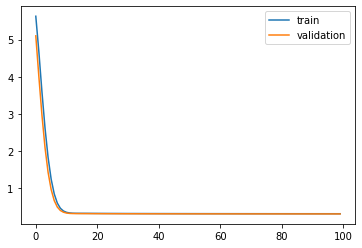

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 5.6271 - acc: 0.6189 - val_loss: 5.0976 - val_acc: 0.8142

Epoch 00001: val_loss improved from inf to 5.09759, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6690 - acc: 0.8425 - val_loss: 4.0117 - val_acc: 0.8623

Epoch 00002: val_loss improved from 5.09759 to 4.01168, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5934 - acc: 0.8684 - val_loss: 2.9849 - val_acc: 0.8704

Epoch 00003: val_loss improved from 4.01168 to 2.98494, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.6197 - acc: 0.8727 - val_loss: 2.1137 - val_acc: 0.8722

Epoch 00004: val_loss improved from 2.98494 to 2.11373, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.8277 - acc: 0.8747 - val_loss: 1.4487 - val_acc: 0.8739

Epoch 00005: val_loss improved from 2.11373 to 1.44871, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.2439 - acc: 0.8756 - v

 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3254 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32555 to 0.32545, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32545 to 0.32535, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8769

Epoch 00048: val_loss improved from 0.32535 to 0.32525, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32525 to 0.32516, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32516 to 0.32507, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00094: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00095: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8764

Epoch 00096: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights

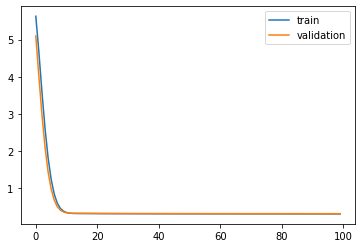

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 5.6272 - acc: 0.6193 - val_loss: 5.0992 - val_acc: 0.8137

Epoch 00001: val_loss improved from inf to 5.09922, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6692 - acc: 0.8416 - val_loss: 4.0154 - val_acc: 0.8628

Epoch 00002: val_loss improved from 5.09922 to 4.01537, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5935 - acc: 0.8684 - val_loss: 2.9886 - val_acc: 0.8699

Epoch 00003: val_loss improved from 4.01537 to 2.98861, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.6198 - acc: 0.8729 - val_loss: 2.1175 - val_acc: 0.8719

Epoch 00004: val_loss improved from 2.98861 to 2.11747, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.8276 - acc: 0.8746 - val_loss: 1.4521 - val_acc: 0.8748

Epoch 00005: val_loss improved from 2.11747 to 1.45214, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.2438 - acc: 0.8754 - v

 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3255 - val_acc: 0.8777

Epoch 00046: val_loss improved from 0.32560 to 0.32550, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8789 - val_loss: 0.3254 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32550 to 0.32541, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32541 to 0.32531, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32531 to 0.32522, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32522 to 0.32514, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32324 to 0.32322, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00092: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00094: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00095: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00096: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights

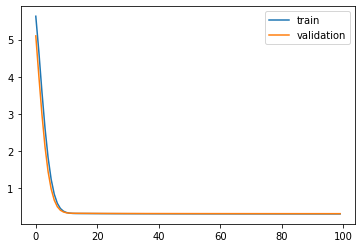

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 5.6265 - acc: 0.6198 - val_loss: 5.1074 - val_acc: 0.8022

Epoch 00001: val_loss improved from inf to 5.10744, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6688 - acc: 0.8422 - val_loss: 4.0228 - val_acc: 0.8578

Epoch 00002: val_loss improved from 5.10744 to 4.02279, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5929 - acc: 0.8689 - val_loss: 2.9977 - val_acc: 0.8652

Epoch 00003: val_loss improved from 4.02279 to 2.99770, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.6189 - acc: 0.8735 - val_loss: 2.1265 - val_acc: 0.8672

Epoch 00004: val_loss improved from 2.99770 to 2.12651, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.8268 - acc: 0.8752 - val_loss: 1.4604 - val_acc: 0.8678

Epoch 00005: val_loss improved from 2.12651 to 1.46040, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.2430 - acc: 0.8762 - v

 - 1s - loss: 0.3191 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33034 to 0.33025, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00047: val_loss improved from 0.33025 to 0.33015, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3301 - val_acc: 0.8711

Epoch 00048: val_loss improved from 0.33015 to 0.33006, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.33006 to 0.32997, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.32997 to 0.32989, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32810 to 0.32808, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3161 - acc: 0.8800 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00092: val_loss improved from 0.32808 to 0.32806, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3161 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32806 to 0.32805, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32805 to 0.32803, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00096: val_loss improved from 0.32802 to 0.32800, saving model to Event_val_weights

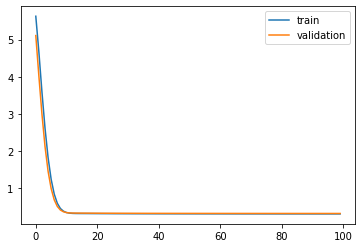

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fee790b4a90>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 5.6270 - acc: 0.6186 - val_loss: 5.1006 - val_acc: 0.8117

Epoch 00001: val_loss improved from inf to 5.10063, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6704 - acc: 0.8410 - val_loss: 4.0070 - val_acc: 0.8677

Epoch 00002: val_loss improved from 5.10063 to 4.00696, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5950 - acc: 0.8680 - val_loss: 2.9759 - val_acc: 0.8733

Epoch 00003: val_loss improved from 4.00696 to 2.97585, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.6208 - acc: 0.8727 - val_loss: 2.1027 - val_acc: 0.8754

Epoch 00004: val_loss improved from 2.97585 to 2.10271, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.8284 - acc: 0.8743 - val_loss: 1.4373 - val_acc: 0.8773

Epoch 00005: val_loss improved from 2.10271 to 1.43730, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2443 - acc: 0.8751 - v

 - 1s - loss: 0.3201 - acc: 0.8785 - val_loss: 0.3207 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32081 to 0.32071, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3206 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32071 to 0.32062, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32062 to 0.32053, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32053 to 0.32044, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8791

Epoch 00050: val_loss improved from 0.32044 to 0.32035, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31836 to 0.31834, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31834 to 0.31831, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31831 to 0.31829, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31829 to 0.31826, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31826 to 0.31824, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31824 to 0.31822, saving model to Event_val_weights

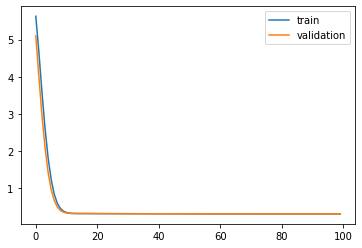

Time to train LSTM:  66.70017600059509
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 5.5859 - acc: 0.6362 - val_loss: 4.9759 - val_acc: 0.8271

Epoch 00001: val_loss improved from inf to 4.97594, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4939 - acc: 0.8501 - val_loss: 3.7465 - val_acc: 0.8724

Epoch 00002: val_loss improved from 4.97594 to 3.74651, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2971 - acc: 0.8698 - val_loss: 2.6145 - val_acc: 0.8759

Epoch 00003: val_loss improved from 3.74651 to 2.61448, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.2486 - acc: 0.8732 - val_loss: 1.7081 - val_acc: 0.8764

Epoch 00004: val_loss improved from 2.61448 to 1.70815, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4500 - acc: 0.8748 - val_loss: 1.0741 - val_acc: 0.8779

Epoch 00005: val_loss improved from 1.70815 to 1.07413, saving model to Event_val_weights1.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.31452 to 0.31444, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3144 - val_acc: 0.8806

Epoch 00047: val_loss improved from 0.31444 to 0.31435, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00048: val_loss improved from 0.31435 to 0.31427, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31427 to 0.31419, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31419 to 0.31412, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8806

Epoch 00051: val_loss improved from 0.31412 to 0.31405, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8806

Epoch 00092: val_loss improved from 0.31229 to 0.31226, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31226 to 0.31224, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00094: val_loss improved from 0.31224 to 0.31221, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00095: val_loss improved from 0.31221 to 0.31219, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31219 to 0.31217, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

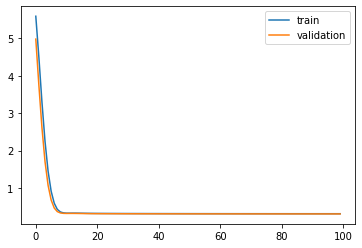

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.5864 - acc: 0.6350 - val_loss: 4.9756 - val_acc: 0.8272

Epoch 00001: val_loss improved from inf to 4.97562, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4929 - acc: 0.8512 - val_loss: 3.7584 - val_acc: 0.8661

Epoch 00002: val_loss improved from 4.97562 to 3.75840, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2955 - acc: 0.8703 - val_loss: 2.6319 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.75840 to 2.63191, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.2471 - acc: 0.8737 - val_loss: 1.7273 - val_acc: 0.8733

Epoch 00004: val_loss improved from 2.63191 to 1.72730, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4487 - acc: 0.8752 - val_loss: 1.0931 - val_acc: 0.8738

Epoch 00005: val_loss improved from 1.72730 to 1.09307, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.9136 - acc: 0.8760 - v

 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00047: val_loss improved from 0.32475 to 0.32465, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32465 to 0.32457, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32457 to 0.32448, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32448 to 0.32440, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8789 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32440 to 0.32433, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00052: val_

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00093: val_loss did not improve from 0.32312
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00094: val_loss did not improve from 0.32312
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00095: val_loss did not improve from 0.32312
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00096: val_loss did not improve from 0.32312
Epoch 97/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00097: val_loss did not improve from 0.32312
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00098: val_loss did not improve from 0.32312
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32312
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val

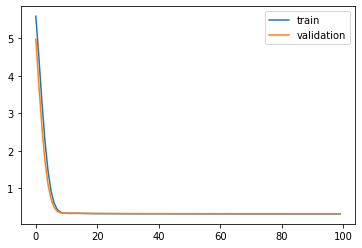

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fecabde4588>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.5865 - acc: 0.6351 - val_loss: 4.9776 - val_acc: 0.8283

Epoch 00001: val_loss improved from inf to 4.97764, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4932 - acc: 0.8501 - val_loss: 3.7622 - val_acc: 0.8650

Epoch 00002: val_loss improved from 4.97764 to 3.76218, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2956 - acc: 0.8702 - val_loss: 2.6357 - val_acc: 0.8714

Epoch 00003: val_loss improved from 3.76218 to 2.63566, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.2471 - acc: 0.8738 - val_loss: 1.7312 - val_acc: 0.8740

Epoch 00004: val_loss improved from 2.63566 to 1.73124, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4485 - acc: 0.8750 - val_loss: 1.0963 - val_acc: 0.8749

Epoch 00005: val_loss improved from 1.73124 to 1.09628, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.9135 - acc: 0.8759 - v

 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32485 to 0.32476, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32476 to 0.32467, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32467 to 0.32459, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32459 to 0.32451, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32451 to 0.32444, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00052: val_


Epoch 00094: val_loss did not improve from 0.32325
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8768

Epoch 00095: val_loss did not improve from 0.32325
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8768

Epoch 00096: val_loss did not improve from 0.32325
Epoch 97/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32325
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8766

Epoch 00098: val_loss did not improve from 0.32325
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3236 - val_acc: 0.8766

Epoch 00099: val_loss did not improve from 0.32325
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3236 - val_acc: 0.8768

Epoch 00100: val_loss did not improve from 0.32325
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04279918792240

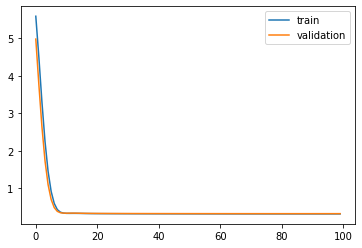

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.5859 - acc: 0.6360 - val_loss: 4.9856 - val_acc: 0.8162

Epoch 00001: val_loss improved from inf to 4.98561, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4929 - acc: 0.8509 - val_loss: 3.7700 - val_acc: 0.8604

Epoch 00002: val_loss improved from 4.98561 to 3.77004, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2949 - acc: 0.8709 - val_loss: 2.6450 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.77004 to 2.64496, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.2463 - acc: 0.8744 - val_loss: 1.7398 - val_acc: 0.8673

Epoch 00004: val_loss improved from 2.64496 to 1.73981, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4477 - acc: 0.8759 - val_loss: 1.1038 - val_acc: 0.8683

Epoch 00005: val_loss improved from 1.73981 to 1.10385, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.9127 - acc: 0.8766 - v

 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8713

Epoch 00047: val_loss improved from 0.32958 to 0.32949, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32949 to 0.32941, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00049: val_loss improved from 0.32941 to 0.32933, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00050: val_loss improved from 0.32933 to 0.32925, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00051: val_loss improved from 0.32925 to 0.32918, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00052: val_


Epoch 00094: val_loss did not improve from 0.32807
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8717

Epoch 00095: val_loss did not improve from 0.32807
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8714

Epoch 00096: val_loss did not improve from 0.32807
Epoch 97/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3283 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.32807
Epoch 98/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32807
Epoch 99/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32807
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8709

Epoch 00100: val_loss did not improve from 0.32807
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04279918792240

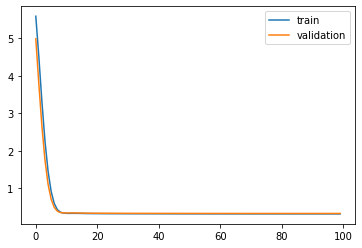

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.5865 - acc: 0.6350 - val_loss: 4.9777 - val_acc: 0.8279

Epoch 00001: val_loss improved from inf to 4.97771, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4945 - acc: 0.8495 - val_loss: 3.7522 - val_acc: 0.8697

Epoch 00002: val_loss improved from 4.97771 to 3.75222, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2970 - acc: 0.8697 - val_loss: 2.6217 - val_acc: 0.8746

Epoch 00003: val_loss improved from 3.75222 to 2.62167, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.2481 - acc: 0.8734 - val_loss: 1.7154 - val_acc: 0.8777

Epoch 00004: val_loss improved from 2.62167 to 1.71540, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4492 - acc: 0.8749 - val_loss: 1.0814 - val_acc: 0.8774

Epoch 00005: val_loss improved from 1.71540 to 1.08140, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.9138 - acc: 0.8758 - v

 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32005 to 0.31996, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.31996 to 0.31987, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.31987 to 0.31979, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3197 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31979 to 0.31971, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31971 to 0.31963, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00052: val_


Epoch 00093: val_loss did not improve from 0.31805
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31805 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss did not improve from 0.31802
Epoch 96/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31802 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31802
Epoch 98/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00098: val_loss did not improve from 0.31802
Epoch 99/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00099: val_loss did not improve from 0.31802
Epoch 100/100
 - 1s - loss: 0.3172 -

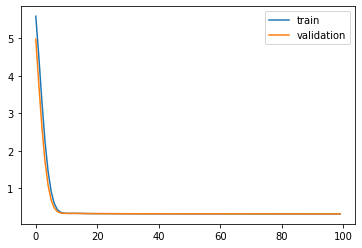

Time to train LSTM:  65.8003797531128


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fecaafc52b0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 5.6055 - acc: 0.6285 - val_loss: 5.0350 - val_acc: 0.8206

Epoch 00001: val_loss improved from inf to 5.03501, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5779 - acc: 0.8466 - val_loss: 3.8681 - val_acc: 0.8718

Epoch 00002: val_loss improved from 5.03501 to 3.86814, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.4385 - acc: 0.8687 - val_loss: 2.7817 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.86814 to 2.78167, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.4232 - acc: 0.8729 - val_loss: 1.8875 - val_acc: 0.8762

Epoch 00004: val_loss improved from 2.78167 to 1.88750, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.6238 - acc: 0.8745 - val_loss: 1.2346 - val_acc: 0.8773

Epoch 00005: val_loss improved from 1.88750 to 1.23465, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.0618 - acc: 0.8755 - v

 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00046: val_loss improved from 0.31482 to 0.31473, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3202 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31473 to 0.31464, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00048: val_loss improved from 0.31464 to 0.31456, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31456 to 0.31448, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31448 to 0.31440, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31255 to 0.31252, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31252 to 0.31250, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31250 to 0.31247, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31247 to 0.31244, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31244 to 0.31241, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31241 to 0.31239, saving model to Event_val_weights

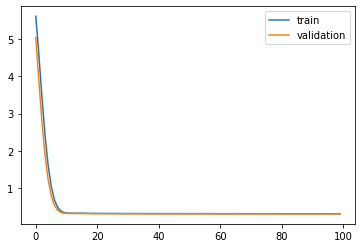

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 5.6060 - acc: 0.6276 - val_loss: 5.0340 - val_acc: 0.8217

Epoch 00001: val_loss improved from inf to 5.03400, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5769 - acc: 0.8473 - val_loss: 3.8791 - val_acc: 0.8641

Epoch 00002: val_loss improved from 5.03400 to 3.87906, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.4369 - acc: 0.8695 - val_loss: 2.7984 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.87906 to 2.79844, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.4216 - acc: 0.8734 - val_loss: 1.9062 - val_acc: 0.8726

Epoch 00004: val_loss improved from 2.79844 to 1.90622, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.6225 - acc: 0.8749 - val_loss: 1.2534 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.90622 to 1.25341, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0606 - acc: 0.8759 - v

 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32506 to 0.32497, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32497 to 0.32488, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32488 to 0.32479, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32479 to 0.32470, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3246 - val_acc: 0.8770

Epoch 00051: val_loss improved from 0.32470 to 0.32462, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8759

Epoch 00095: val_loss improved from 0.32307 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8758

Epoch 00096: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights

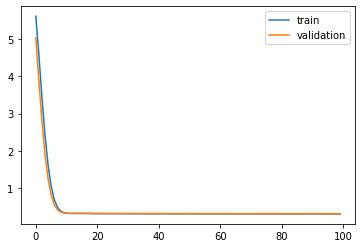

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 5.6061 - acc: 0.6279 - val_loss: 5.0358 - val_acc: 0.8203

Epoch 00001: val_loss improved from inf to 5.03583, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5772 - acc: 0.8463 - val_loss: 3.8828 - val_acc: 0.8640

Epoch 00002: val_loss improved from 5.03583 to 3.88281, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.4370 - acc: 0.8695 - val_loss: 2.8021 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.88281 to 2.80213, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.4217 - acc: 0.8732 - val_loss: 1.9101 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.80213 to 1.91006, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.6223 - acc: 0.8750 - val_loss: 1.2568 - val_acc: 0.8748

Epoch 00005: val_loss improved from 1.91006 to 1.25676, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0605 - acc: 0.8757 - v


Epoch 00046: val_loss improved from 0.32524 to 0.32514, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00047: val_loss improved from 0.32514 to 0.32505, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32505 to 0.32496, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32496 to 0.32488, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32488 to 0.32479, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8774

Epoch 00051: val_loss improved from 0.32479 to 0.32472, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00092: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32315 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00094: val_loss improved from 0.32315 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00095: val_loss did not improve from 0.32315
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00096: val_loss did not improve from 0.32315
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32315
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_lo

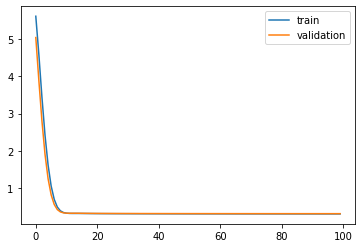

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 5.6054 - acc: 0.6288 - val_loss: 5.0439 - val_acc: 0.8093

Epoch 00001: val_loss improved from inf to 5.04392, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5768 - acc: 0.8470 - val_loss: 3.8904 - val_acc: 0.8594

Epoch 00002: val_loss improved from 5.04392 to 3.89044, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.4364 - acc: 0.8700 - val_loss: 2.8114 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.89044 to 2.81138, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.4208 - acc: 0.8738 - val_loss: 1.9189 - val_acc: 0.8668

Epoch 00004: val_loss improved from 2.81138 to 1.91889, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.6216 - acc: 0.8757 - val_loss: 1.2647 - val_acc: 0.8680

Epoch 00005: val_loss improved from 1.91889 to 1.26468, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0597 - acc: 0.8762 - v


Epoch 00046: val_loss improved from 0.32998 to 0.32988, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00047: val_loss improved from 0.32988 to 0.32979, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32979 to 0.32971, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00049: val_loss improved from 0.32971 to 0.32962, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32962 to 0.32954, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8716

Epoch 00051: val_loss improved from 0.32954 to 0.32946, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00092: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00093: val_loss improved from 0.32800 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00094: val_loss improved from 0.32800 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00095: val_loss improved from 0.32799 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00096: val_loss did not improve from 0.32799
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.32799
Epoch 98/10

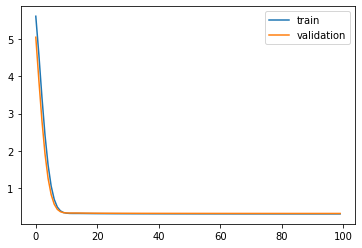

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feca43a97b8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.6060 - acc: 0.6276 - val_loss: 5.0365 - val_acc: 0.8209

Epoch 00001: val_loss improved from inf to 5.03653, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5785 - acc: 0.8457 - val_loss: 3.8735 - val_acc: 0.8688

Epoch 00002: val_loss improved from 5.03653 to 3.87355, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.4385 - acc: 0.8689 - val_loss: 2.7887 - val_acc: 0.8734

Epoch 00003: val_loss improved from 3.87355 to 2.78873, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.4227 - acc: 0.8729 - val_loss: 1.8947 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.78873 to 1.89470, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.6231 - acc: 0.8747 - val_loss: 1.2418 - val_acc: 0.8769

Epoch 00005: val_loss improved from 1.89470 to 1.24183, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0609 - acc: 0.8754 - v


Epoch 00046: val_loss improved from 0.32045 to 0.32036, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32036 to 0.32026, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32026 to 0.32017, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32017 to 0.32009, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32009 to 0.32000, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.32000 to 0.31992, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00092: val_loss improved from 0.31815 to 0.31813, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00093: val_loss improved from 0.31813 to 0.31812, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00094: val_loss improved from 0.31812 to 0.31809, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00095: val_loss did not improve from 0.31809
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31809 to 0.31804, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00097: val_loss did not improve from 0.31804
Epoch 98/10

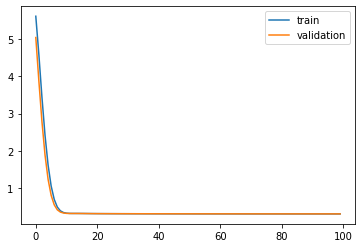

Time to train LSTM:  71.04737448692322
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 5.5892 - acc: 0.6350 - val_loss: 4.9856 - val_acc: 0.8264

Epoch 00001: val_loss improved from inf to 4.98560, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5076 - acc: 0.8498 - val_loss: 3.7663 - val_acc: 0.8722

Epoch 00002: val_loss improved from 4.98560 to 3.76633, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.3201 - acc: 0.8697 - val_loss: 2.6415 - val_acc: 0.8759

Epoch 00003: val_loss improved from 3.76633 to 2.64151, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.2767 - acc: 0.8731 - val_loss: 1.7367 - val_acc: 0.8764

Epoch 00004: val_loss improved from 2.64151 to 1.73671, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4775 - acc: 0.8747 - val_loss: 1.0992 - val_acc: 0.8779

Epoch 00005: val_loss improved from 1.73671 to 1.09916, saving model to Event_val_weights1.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.31457 to 0.31448, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31448 to 0.31440, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31440 to 0.31432, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31432 to 0.31424, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31424 to 0.31416, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8806

Epoch 00051: val_loss improved from 0.31416 to 0.31409, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31233 to 0.31230, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31230 to 0.31227, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31227 to 0.31225, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00095: val_loss improved from 0.31225 to 0.31222, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00096: val_loss improved from 0.31222 to 0.31220, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00097: val_

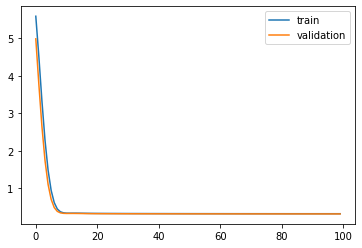

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.5896 - acc: 0.6337 - val_loss: 4.9852 - val_acc: 0.8266

Epoch 00001: val_loss improved from inf to 4.98517, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5066 - acc: 0.8507 - val_loss: 3.7781 - val_acc: 0.8658

Epoch 00002: val_loss improved from 4.98517 to 3.77807, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.3184 - acc: 0.8703 - val_loss: 2.6588 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.77807 to 2.65883, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.2751 - acc: 0.8738 - val_loss: 1.7558 - val_acc: 0.8733

Epoch 00004: val_loss improved from 2.65883 to 1.75580, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4761 - acc: 0.8752 - val_loss: 1.1181 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.75580 to 1.11807, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.9363 - acc: 0.8760 - v

 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00047: val_loss improved from 0.32480 to 0.32470, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00048: val_loss improved from 0.32470 to 0.32462, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32462 to 0.32453, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32453 to 0.32445, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32445 to 0.32437, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss did not improve from 0.32310
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00093: val_loss did not improve from 0.32310
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00094: val_loss did not improve from 0.32310
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss did not improve from 0.32310
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00096: val_loss did not improve from 0.32310
Epoch 97/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss did not improve from 0.32310
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8756

Epoch 00098: val_loss did not improve from 0.32310
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00099: val_loss did not improve fr

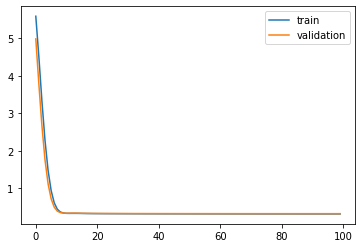

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.5897 - acc: 0.6340 - val_loss: 4.9872 - val_acc: 0.8270

Epoch 00001: val_loss improved from inf to 4.98716, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5069 - acc: 0.8495 - val_loss: 3.7818 - val_acc: 0.8647

Epoch 00002: val_loss improved from 4.98716 to 3.78184, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.3185 - acc: 0.8702 - val_loss: 2.6626 - val_acc: 0.8712

Epoch 00003: val_loss improved from 3.78184 to 2.66257, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.2751 - acc: 0.8737 - val_loss: 1.7597 - val_acc: 0.8739

Epoch 00004: val_loss improved from 2.66257 to 1.75972, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4760 - acc: 0.8750 - val_loss: 1.1213 - val_acc: 0.8749

Epoch 00005: val_loss improved from 1.75972 to 1.12131, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.9362 - acc: 0.8760 - v

 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32489 to 0.32480, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32480 to 0.32472, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32472 to 0.32464, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32464 to 0.32456, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32456 to 0.32448, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8776

Epoch 00052: val_

 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8769

Epoch 00094: val_loss did not improve from 0.32324
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8797 - val_loss: 0.3233 - val_acc: 0.8768

Epoch 00095: val_loss did not improve from 0.32324
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8768

Epoch 00096: val_loss did not improve from 0.32324
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8768

Epoch 00097: val_loss did not improve from 0.32324
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8768

Epoch 00098: val_loss did not improve from 0.32324
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8766

Epoch 00099: val_loss did not improve from 0.32324
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8766

Epoch 00100: val_loss did not improve from 0.32324
#################################
Number of units: 16

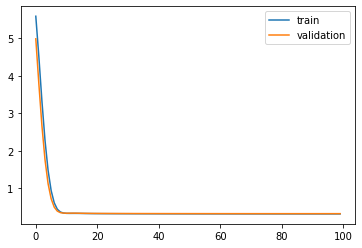

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.5891 - acc: 0.6349 - val_loss: 4.9951 - val_acc: 0.8156

Epoch 00001: val_loss improved from inf to 4.99515, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5066 - acc: 0.8504 - val_loss: 3.7897 - val_acc: 0.8603

Epoch 00002: val_loss improved from 4.99515 to 3.78966, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.3179 - acc: 0.8708 - val_loss: 2.6719 - val_acc: 0.8657

Epoch 00003: val_loss improved from 3.78966 to 2.67187, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.2743 - acc: 0.8742 - val_loss: 1.7683 - val_acc: 0.8673

Epoch 00004: val_loss improved from 2.67187 to 1.76834, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4752 - acc: 0.8759 - val_loss: 1.1289 - val_acc: 0.8682

Epoch 00005: val_loss improved from 1.76834 to 1.12893, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.9353 - acc: 0.8765 - v

 - 1s - loss: 0.3182 - acc: 0.8797 - val_loss: 0.3295 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32963 to 0.32954, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00048: val_loss improved from 0.32954 to 0.32946, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.32946 to 0.32938, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00050: val_loss improved from 0.32938 to 0.32930, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32930 to 0.32922, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00052: val_

 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00094: val_loss did not improve from 0.32806
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00095: val_loss did not improve from 0.32806
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8716

Epoch 00096: val_loss did not improve from 0.32806
Epoch 97/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8717

Epoch 00097: val_loss did not improve from 0.32806
Epoch 98/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8713

Epoch 00098: val_loss did not improve from 0.32806
Epoch 99/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3282 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32806
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00100: val_loss did not improve from 0.32806
#################################
Number of units: 16

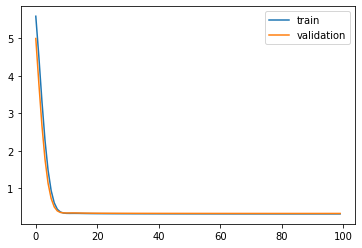

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feca2c85c18>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.5898 - acc: 0.6339 - val_loss: 4.9873 - val_acc: 0.8269

Epoch 00001: val_loss improved from inf to 4.98733, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5082 - acc: 0.8487 - val_loss: 3.7720 - val_acc: 0.8697

Epoch 00002: val_loss improved from 4.98733 to 3.77200, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.3200 - acc: 0.8696 - val_loss: 2.6487 - val_acc: 0.8744

Epoch 00003: val_loss improved from 3.77200 to 2.64867, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.2761 - acc: 0.8733 - val_loss: 1.7440 - val_acc: 0.8774

Epoch 00004: val_loss improved from 2.64867 to 1.74395, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4767 - acc: 0.8748 - val_loss: 1.1064 - val_acc: 0.8773

Epoch 00005: val_loss improved from 1.74395 to 1.10641, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.9365 - acc: 0.8758 - v

 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32010 to 0.32001, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32001 to 0.31992, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.31992 to 0.31983, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31983 to 0.31975, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3197 - val_acc: 0.8792

Epoch 00051: val_loss improved from 0.31975 to 0.31967, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8794

Epoch 00052: val_


Epoch 00093: val_loss improved from 0.31806 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00094: val_loss did not improve from 0.31805
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31805 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31802
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00097: val_loss improved from 0.31802 to 0.31801, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00098: val_loss did not improve from 0.31801
Epoch 99/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00099: val_loss did not improve from

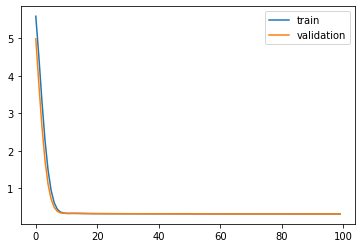

Time to train LSTM:  71.1127119064331
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 5.5747 - acc: 0.6405 - val_loss: 4.9424 - val_acc: 0.8300

Epoch 00001: val_loss improved from inf to 4.94237, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4464 - acc: 0.8519 - val_loss: 3.6778 - val_acc: 0.8728

Epoch 00002: val_loss improved from 4.94237 to 3.67781, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2176 - acc: 0.8700 - val_loss: 2.5215 - val_acc: 0.8758

Epoch 00003: val_loss improved from 3.67781 to 2.52151, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.1525 - acc: 0.8733 - val_loss: 1.6112 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.52151 to 1.61120, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3574 - acc: 0.8749 - val_loss: 0.9908 - val_acc: 0.8781

Epoch 00005: val_loss improved from 1.61120 to 0.99081, saving model to Event_val_weights1.hdf5
Epoch 6/100



Epoch 00046: val_loss improved from 0.31436 to 0.31428, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8784 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31428 to 0.31420, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31420 to 0.31412, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.31412 to 0.31404, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3140 - val_acc: 0.8803

Epoch 00050: val_loss improved from 0.31404 to 0.31397, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3139 - val_acc: 0.8802

Epoch 00051: val_loss improved from 0.31397 to 0.31390, saving model to Event_val_weights

 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00092: val_loss improved from 0.31218 to 0.31216, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31216 to 0.31214, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31214 to 0.31212, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00095: val_loss improved from 0.31212 to 0.31210, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00096: val_loss improved from 0.31210 to 0.31209, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

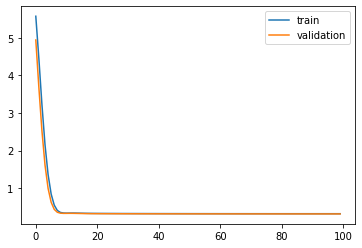

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 5.5752 - acc: 0.6393 - val_loss: 4.9424 - val_acc: 0.8302

Epoch 00001: val_loss improved from inf to 4.94244, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4453 - acc: 0.8528 - val_loss: 3.6902 - val_acc: 0.8662

Epoch 00002: val_loss improved from 4.94244 to 3.69022, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2160 - acc: 0.8706 - val_loss: 2.5393 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.69022 to 2.53928, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.1510 - acc: 0.8738 - val_loss: 1.6306 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.53928 to 1.63057, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3561 - acc: 0.8753 - val_loss: 1.0098 - val_acc: 0.8738

Epoch 00005: val_loss improved from 1.63057 to 1.00982, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.8388 - acc: 0.8762 - v

 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00047: val_loss improved from 0.32458 to 0.32449, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32449 to 0.32441, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32441 to 0.32433, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32433 to 0.32425, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32425 to 0.32418, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3241 - val_acc: 0.8770

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00095: val_loss did not improve from 0.32316
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00096: val_loss did not improve from 0.32316
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00097: val_loss did not improve from 0.32316
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00098: val_loss did not improve from 0.32316
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32316
Epoch 100/100
 - 1s - loss: 0.3167 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8759

Epoch 00100: val_loss did not improve from 0.32316
#################################
Number of units: 16
Batch size: 16384
Fold: 1
L2 : 0.05441600579314996
LR: 0.04477989511996602
Decay: 3.9513128857426947e-07
best val loss: 0.32315543293952

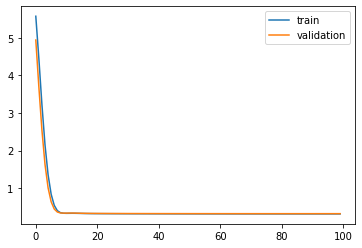

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.5753 - acc: 0.6393 - val_loss: 4.9446 - val_acc: 0.8310

Epoch 00001: val_loss improved from inf to 4.94457, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4456 - acc: 0.8520 - val_loss: 3.6940 - val_acc: 0.8654

Epoch 00002: val_loss improved from 4.94457 to 3.69401, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2161 - acc: 0.8707 - val_loss: 2.5431 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.69401 to 2.54309, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.1510 - acc: 0.8741 - val_loss: 1.6346 - val_acc: 0.8742

Epoch 00004: val_loss improved from 2.54309 to 1.63455, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3559 - acc: 0.8751 - val_loss: 1.0129 - val_acc: 0.8748

Epoch 00005: val_loss improved from 1.63455 to 1.01292, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.8386 - acc: 0.8759 - v

 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32469 to 0.32461, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32461 to 0.32452, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8774

Epoch 00049: val_loss improved from 0.32452 to 0.32445, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32445 to 0.32437, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32437 to 0.32430, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3180 - acc: 0.8791 - val_loss: 0.3242 - val_acc: 0.8773

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00096: val_loss did not improve from 0.32332
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32332
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32332
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3239 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32332
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3239 - val_acc: 0.8770

Epoch 00100: val_loss did not improve from 0.32332
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04477989511996602
Decay: 3.9513128857426947e-07
best val loss: 0.32331734895706177
#################################


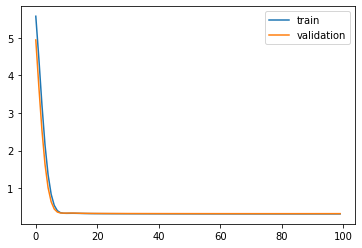

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.5747 - acc: 0.6398 - val_loss: 4.9525 - val_acc: 0.8192

Epoch 00001: val_loss improved from inf to 4.95246, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4453 - acc: 0.8531 - val_loss: 3.7020 - val_acc: 0.8617

Epoch 00002: val_loss improved from 4.95246 to 3.70201, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2155 - acc: 0.8714 - val_loss: 2.5524 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.70201 to 2.55238, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.1502 - acc: 0.8746 - val_loss: 1.6430 - val_acc: 0.8676

Epoch 00004: val_loss improved from 2.55238 to 1.64298, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3551 - acc: 0.8759 - val_loss: 1.0203 - val_acc: 0.8687

Epoch 00005: val_loss improved from 1.64298 to 1.02029, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8378 - acc: 0.8765 - v

 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00047: val_loss improved from 0.32942 to 0.32934, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32934 to 0.32926, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.32926 to 0.32918, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.32918 to 0.32911, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32911 to 0.32904, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00052: val_

 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8709

Epoch 00096: val_loss did not improve from 0.32811
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00097: val_loss did not improve from 0.32811
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32811
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3286 - val_acc: 0.8711

Epoch 00099: val_loss did not improve from 0.32811
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3286 - val_acc: 0.8712

Epoch 00100: val_loss did not improve from 0.32811
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04477989511996602
Decay: 3.9513128857426947e-07
best val loss: 0.32811102271080017
#################################


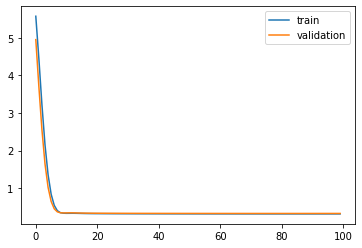

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.5754 - acc: 0.6388 - val_loss: 4.9443 - val_acc: 0.8323

Epoch 00001: val_loss improved from inf to 4.94427, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4470 - acc: 0.8515 - val_loss: 3.6837 - val_acc: 0.8703

Epoch 00002: val_loss improved from 4.94427 to 3.68369, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2175 - acc: 0.8702 - val_loss: 2.5287 - val_acc: 0.8747

Epoch 00003: val_loss improved from 3.68369 to 2.52874, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.1520 - acc: 0.8736 - val_loss: 1.6185 - val_acc: 0.8777

Epoch 00004: val_loss improved from 2.52874 to 1.61849, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3566 - acc: 0.8748 - val_loss: 0.9981 - val_acc: 0.8768

Epoch 00005: val_loss improved from 1.61849 to 0.99813, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.8389 - acc: 0.8757 - v

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3198 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.31988 to 0.31979, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.31979 to 0.31971, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00049: val_loss improved from 0.31971 to 0.31963, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00050: val_loss improved from 0.31963 to 0.31955, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31955 to 0.31947, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3194 - val_acc: 0.8793

Epoch 00052: val_

 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00094: val_loss did not improve from 0.31806
Epoch 95/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31806 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31803
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00097: val_loss did not improve from 0.31803
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00098: val_loss did not improve from 0.31803
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00099: val_loss did not improve from 0.31803
Epoch 100/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00100: val_loss did not improve from 0.31803
########

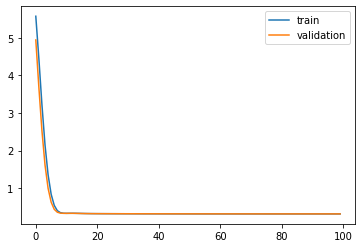

Time to train LSTM:  68.79240322113037


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feca0c17f60>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.5997 - acc: 0.6309 - val_loss: 5.0175 - val_acc: 0.8230

Epoch 00001: val_loss improved from inf to 5.01755, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5530 - acc: 0.8478 - val_loss: 3.8321 - val_acc: 0.8718

Epoch 00002: val_loss improved from 5.01755 to 3.83207, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.3965 - acc: 0.8691 - val_loss: 2.7318 - val_acc: 0.8760

Epoch 00003: val_loss improved from 3.83207 to 2.73177, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.3709 - acc: 0.8730 - val_loss: 1.8333 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.73177 to 1.83333, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5710 - acc: 0.8745 - val_loss: 1.1853 - val_acc: 0.8774

Epoch 00005: val_loss improved from 1.83333 to 1.18535, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.0163 - acc: 0.8755 - v


Epoch 00046: val_loss improved from 0.31473 to 0.31464, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00047: val_loss improved from 0.31464 to 0.31456, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31456 to 0.31447, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31447 to 0.31439, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31439 to 0.31432, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31432 to 0.31424, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31246 to 0.31243, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31243 to 0.31240, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00094: val_loss improved from 0.31240 to 0.31237, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31237 to 0.31235, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31235 to 0.31232, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00097: val_

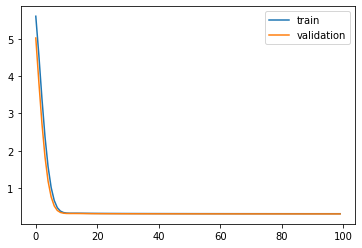

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.6002 - acc: 0.6298 - val_loss: 5.0167 - val_acc: 0.8228

Epoch 00001: val_loss improved from inf to 5.01673, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5520 - acc: 0.8485 - val_loss: 3.8433 - val_acc: 0.8646

Epoch 00002: val_loss improved from 5.01673 to 3.84329, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.3949 - acc: 0.8699 - val_loss: 2.7487 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.84329 to 2.74874, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.3693 - acc: 0.8735 - val_loss: 1.8522 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.74874 to 1.85219, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5697 - acc: 0.8750 - val_loss: 1.2042 - val_acc: 0.8734

Epoch 00005: val_loss improved from 1.85219 to 1.20417, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0151 - acc: 0.8759 - v

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32497 to 0.32487, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32487 to 0.32478, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32478 to 0.32469, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32469 to 0.32461, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32461 to 0.32453, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8759

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00096: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss did not improve from 0.32307
Epoch 98/100
 - 1s - loss: 0.3164 - ac

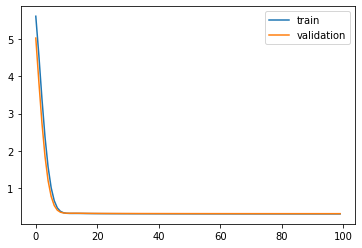

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.6003 - acc: 0.6301 - val_loss: 5.0186 - val_acc: 0.8228

Epoch 00001: val_loss improved from inf to 5.01862, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5523 - acc: 0.8476 - val_loss: 3.8470 - val_acc: 0.8642

Epoch 00002: val_loss improved from 5.01862 to 3.84705, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.3950 - acc: 0.8698 - val_loss: 2.7524 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.84705 to 2.75244, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.3693 - acc: 0.8733 - val_loss: 1.8561 - val_acc: 0.8739

Epoch 00004: val_loss improved from 2.75244 to 1.85606, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5695 - acc: 0.8750 - val_loss: 1.2075 - val_acc: 0.8746

Epoch 00005: val_loss improved from 1.85606 to 1.20748, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0150 - acc: 0.8758 - v


Epoch 00046: val_loss improved from 0.32515 to 0.32505, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32505 to 0.32496, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32496 to 0.32487, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32487 to 0.32479, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00050: val_loss improved from 0.32479 to 0.32471, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32471 to 0.32463, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss did not improve from 0.32318
Epoch 93/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00093: val_loss did not improve from 0.32318
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00094: val_loss did not improve from 0.32318
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00095: val_loss did not improve from 0.32318
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00096: val_loss did not improve from 0.32318
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32318
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00098: val_loss did not improve from 0.32318
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_

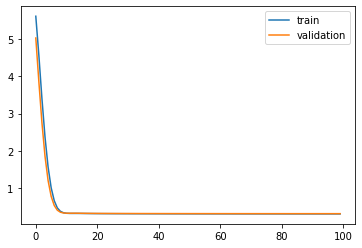

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 5.5997 - acc: 0.6309 - val_loss: 5.0267 - val_acc: 0.8118

Epoch 00001: val_loss improved from inf to 5.02668, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5520 - acc: 0.8483 - val_loss: 3.8547 - val_acc: 0.8600

Epoch 00002: val_loss improved from 5.02668 to 3.85474, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.3944 - acc: 0.8702 - val_loss: 2.7617 - val_acc: 0.8659

Epoch 00003: val_loss improved from 3.85474 to 2.76173, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.3685 - acc: 0.8739 - val_loss: 1.8648 - val_acc: 0.8667

Epoch 00004: val_loss improved from 2.76173 to 1.86481, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5687 - acc: 0.8759 - val_loss: 1.2153 - val_acc: 0.8683

Epoch 00005: val_loss improved from 1.86481 to 1.21530, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0142 - acc: 0.8764 - v


Epoch 00046: val_loss improved from 0.32989 to 0.32979, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32979 to 0.32970, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32970 to 0.32962, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8797 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32962 to 0.32953, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32953 to 0.32945, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32945 to 0.32938, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00092: val_loss improved from 0.32801 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00093: val_loss did not improve from 0.32801
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00094: val_loss did not improve from 0.32801
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00095: val_loss did not improve from 0.32801
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss did not improve from 0.32801
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00097: val_loss did not improve from 0.32801
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00098: val_loss did not improve from 0.32801
Epoch 99/

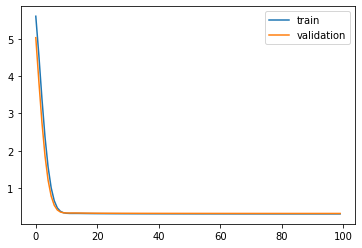

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 5.6003 - acc: 0.6299 - val_loss: 5.0191 - val_acc: 0.8232

Epoch 00001: val_loss improved from inf to 5.01914, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5536 - acc: 0.8471 - val_loss: 3.8376 - val_acc: 0.8690

Epoch 00002: val_loss improved from 5.01914 to 3.83757, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.3964 - acc: 0.8692 - val_loss: 2.7389 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.83757 to 2.73887, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.3703 - acc: 0.8731 - val_loss: 1.8405 - val_acc: 0.8770

Epoch 00004: val_loss improved from 2.73887 to 1.84054, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5702 - acc: 0.8747 - val_loss: 1.1926 - val_acc: 0.8771

Epoch 00005: val_loss improved from 1.84054 to 1.19255, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0154 - acc: 0.8755 - v


Epoch 00046: val_loss improved from 0.32036 to 0.32026, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32026 to 0.32017, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32017 to 0.32008, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32008 to 0.32000, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32000 to 0.31991, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.31991 to 0.31983, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00092: val_loss improved from 0.31812 to 0.31806, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00093: val_loss did not improve from 0.31806
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31806 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31805 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31802
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31802
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_lo

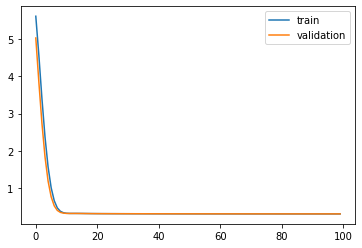

Time to train LSTM:  70.30746102333069
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 5.6019 - acc: 0.6300 - val_loss: 5.0241 - val_acc: 0.8224

Epoch 00001: val_loss improved from inf to 5.02405, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5623 - acc: 0.8472 - val_loss: 3.8455 - val_acc: 0.8719

Epoch 00002: val_loss improved from 5.02405 to 3.84549, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.4121 - acc: 0.8690 - val_loss: 2.7503 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.84549 to 2.75030, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.3903 - acc: 0.8730 - val_loss: 1.8534 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.75030 to 1.85337, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5905 - acc: 0.8745 - val_loss: 1.2035 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.85337 to 1.20351, saving model to Event_val_weights1.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.31476 to 0.31467, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00047: val_loss improved from 0.31467 to 0.31459, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8806

Epoch 00048: val_loss improved from 0.31459 to 0.31450, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31450 to 0.31442, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31442 to 0.31435, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00051: val_loss improved from 0.31435 to 0.31427, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31248 to 0.31245, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31245 to 0.31242, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31242 to 0.31240, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31240 to 0.31237, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31237 to 0.31234, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00097: val_

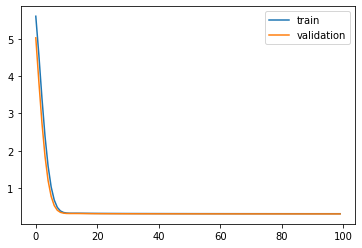

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 5.6024 - acc: 0.6290 - val_loss: 5.0232 - val_acc: 0.8222

Epoch 00001: val_loss improved from inf to 5.02316, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5613 - acc: 0.8480 - val_loss: 3.8566 - val_acc: 0.8642

Epoch 00002: val_loss improved from 5.02316 to 3.85660, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.4105 - acc: 0.8697 - val_loss: 2.7672 - val_acc: 0.8706

Epoch 00003: val_loss improved from 3.85660 to 2.76720, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.3887 - acc: 0.8734 - val_loss: 1.8722 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.76720 to 1.87219, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5892 - acc: 0.8750 - val_loss: 1.2223 - val_acc: 0.8736

Epoch 00005: val_loss improved from 1.87219 to 1.22231, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0319 - acc: 0.8759 - v

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32500 to 0.32491, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32491 to 0.32482, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32482 to 0.32473, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32473 to 0.32464, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32464 to 0.32456, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8759

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00096: val_loss improved from 0.32307 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights

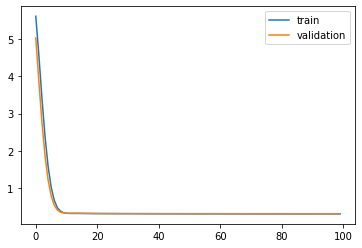

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feae57374a8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 5.6025 - acc: 0.6294 - val_loss: 5.0250 - val_acc: 0.8218

Epoch 00001: val_loss improved from inf to 5.02503, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5616 - acc: 0.8471 - val_loss: 3.8604 - val_acc: 0.8639

Epoch 00002: val_loss improved from 5.02503 to 3.86035, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.4106 - acc: 0.8696 - val_loss: 2.7709 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.86035 to 2.77089, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.3887 - acc: 0.8733 - val_loss: 1.8760 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.77089 to 1.87604, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5890 - acc: 0.8751 - val_loss: 1.2256 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.87604 to 1.22563, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0317 - acc: 0.8757 - v


Epoch 00046: val_loss improved from 0.32518 to 0.32509, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32509 to 0.32499, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32499 to 0.32491, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32491 to 0.32482, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32482 to 0.32474, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32474 to 0.32466, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss improved from 0.32317 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3164 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32317 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00094: val_loss did not improve from 0.32317
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00095: val_loss did not improve from 0.32317
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00096: val_loss did not improve from 0.32317
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32317
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00098: va

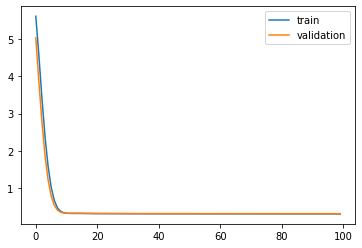

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 5.6018 - acc: 0.6300 - val_loss: 5.0331 - val_acc: 0.8109

Epoch 00001: val_loss improved from inf to 5.03310, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5612 - acc: 0.8479 - val_loss: 3.8680 - val_acc: 0.8598

Epoch 00002: val_loss improved from 5.03310 to 3.86802, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.4100 - acc: 0.8701 - val_loss: 2.7802 - val_acc: 0.8659

Epoch 00003: val_loss improved from 3.86802 to 2.78017, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.3879 - acc: 0.8739 - val_loss: 1.8848 - val_acc: 0.8664

Epoch 00004: val_loss improved from 2.78017 to 1.88483, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5883 - acc: 0.8759 - val_loss: 1.2335 - val_acc: 0.8681

Epoch 00005: val_loss improved from 1.88483 to 1.23349, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0309 - acc: 0.8762 - v


Epoch 00046: val_loss improved from 0.32992 to 0.32983, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32983 to 0.32974, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32974 to 0.32965, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00049: val_loss improved from 0.32965 to 0.32956, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32956 to 0.32948, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32948 to 0.32941, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00092: val_loss improved from 0.32801 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00093: val_loss improved from 0.32801 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00094: val_loss did not improve from 0.32801
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00095: val_loss did not improve from 0.32801
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss did not improve from 0.32801
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.32801
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00098: va

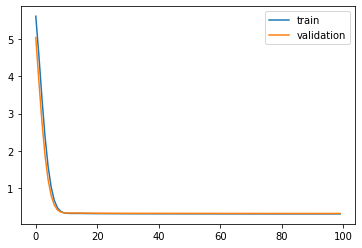

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 5.6024 - acc: 0.6290 - val_loss: 5.0256 - val_acc: 0.8223

Epoch 00001: val_loss improved from inf to 5.02562, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5629 - acc: 0.8467 - val_loss: 3.8510 - val_acc: 0.8689

Epoch 00002: val_loss improved from 5.02562 to 3.85096, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.4121 - acc: 0.8690 - val_loss: 2.7574 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.85096 to 2.75739, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.3897 - acc: 0.8730 - val_loss: 1.8606 - val_acc: 0.8769

Epoch 00004: val_loss improved from 2.75739 to 1.86058, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5898 - acc: 0.8747 - val_loss: 1.2107 - val_acc: 0.8771

Epoch 00005: val_loss improved from 1.86058 to 1.21070, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0321 - acc: 0.8755 - v


Epoch 00046: val_loss improved from 0.32039 to 0.32030, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8791

Epoch 00047: val_loss improved from 0.32030 to 0.32020, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32020 to 0.32012, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32012 to 0.32003, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32003 to 0.31995, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.31995 to 0.31987, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00092: val_loss improved from 0.31814 to 0.31808, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00093: val_loss did not improve from 0.31808
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31808 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31805 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31803
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss improved from 0.31803 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 98/10

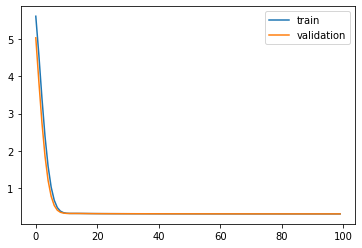

Time to train LSTM:  71.43815970420837
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6268 - acc: 0.6199 - val_loss: 5.1001 - val_acc: 0.8108

Epoch 00001: val_loss improved from inf to 5.10014, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6709 - acc: 0.8418 - val_loss: 4.0035 - val_acc: 0.8709

Epoch 00002: val_loss improved from 5.10014 to 4.00349, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5968 - acc: 0.8676 - val_loss: 2.9712 - val_acc: 0.8761

Epoch 00003: val_loss improved from 4.00349 to 2.97121, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.6237 - acc: 0.8724 - val_loss: 2.0981 - val_acc: 0.8759

Epoch 00004: val_loss improved from 2.97121 to 2.09806, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.8316 - acc: 0.8741 - val_loss: 1.4326 - val_acc: 0.8776

Epoch 00005: val_loss improved from 2.09806 to 1.43260, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3207 - acc: 0.8783 - val_loss: 0.3151 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31516 to 0.31507, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3206 - acc: 0.8783 - val_loss: 0.3150 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31507 to 0.31498, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8784 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00048: val_loss improved from 0.31498 to 0.31490, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00049: val_loss improved from 0.31490 to 0.31481, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31481 to 0.31473, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8806

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31282 to 0.31279, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31279 to 0.31276, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31276 to 0.31273, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8803

Epoch 00094: val_loss improved from 0.31273 to 0.31270, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31270 to 0.31268, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31268 to 0.31265, saving model to Event_val_weights

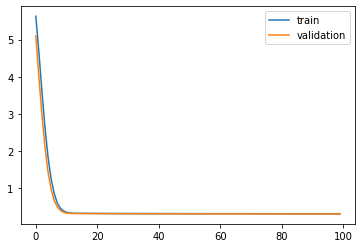

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 5.6274 - acc: 0.6188 - val_loss: 5.0983 - val_acc: 0.8141

Epoch 00001: val_loss improved from inf to 5.09835, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6701 - acc: 0.8424 - val_loss: 4.0133 - val_acc: 0.8623

Epoch 00002: val_loss improved from 5.09835 to 4.01326, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5953 - acc: 0.8684 - val_loss: 2.9872 - val_acc: 0.8704

Epoch 00003: val_loss improved from 4.01326 to 2.98716, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.6221 - acc: 0.8727 - val_loss: 2.1162 - val_acc: 0.8722

Epoch 00004: val_loss improved from 2.98716 to 2.11623, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.8302 - acc: 0.8747 - val_loss: 1.4511 - val_acc: 0.8739

Epoch 00005: val_loss improved from 2.11623 to 1.45110, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.2462 - acc: 0.8756 - v

 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3255 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32556 to 0.32545, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3254 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32545 to 0.32535, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32535 to 0.32525, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32525 to 0.32516, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32516 to 0.32507, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3167 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00094: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00095: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8764

Epoch 00096: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights

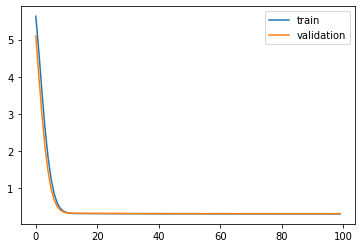

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 5.6274 - acc: 0.6192 - val_loss: 5.1000 - val_acc: 0.8133

Epoch 00001: val_loss improved from inf to 5.09997, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6703 - acc: 0.8415 - val_loss: 4.0169 - val_acc: 0.8628

Epoch 00002: val_loss improved from 5.09997 to 4.01694, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5953 - acc: 0.8684 - val_loss: 2.9908 - val_acc: 0.8699

Epoch 00003: val_loss improved from 4.01694 to 2.99083, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.6221 - acc: 0.8729 - val_loss: 2.1200 - val_acc: 0.8719

Epoch 00004: val_loss improved from 2.99083 to 2.11997, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.8301 - acc: 0.8746 - val_loss: 1.4545 - val_acc: 0.8748

Epoch 00005: val_loss improved from 2.11997 to 1.45453, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.2460 - acc: 0.8754 - v

 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3255 - val_acc: 0.8777

Epoch 00046: val_loss improved from 0.32560 to 0.32550, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8789 - val_loss: 0.3254 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32550 to 0.32541, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32541 to 0.32532, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32532 to 0.32523, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32523 to 0.32514, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3251 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32324 to 0.32322, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00092: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00094: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00095: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00096: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights

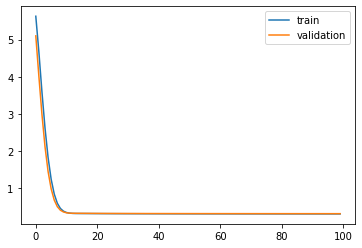

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 5.6267 - acc: 0.6198 - val_loss: 5.1082 - val_acc: 0.8022

Epoch 00001: val_loss improved from inf to 5.10819, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6699 - acc: 0.8421 - val_loss: 4.0244 - val_acc: 0.8578

Epoch 00002: val_loss improved from 5.10819 to 4.02436, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5948 - acc: 0.8688 - val_loss: 2.9999 - val_acc: 0.8651

Epoch 00003: val_loss improved from 4.02436 to 2.99992, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.6213 - acc: 0.8734 - val_loss: 2.1290 - val_acc: 0.8672

Epoch 00004: val_loss improved from 2.99992 to 2.12901, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.8293 - acc: 0.8752 - val_loss: 1.4628 - val_acc: 0.8678

Epoch 00005: val_loss improved from 2.12901 to 1.46281, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.2452 - acc: 0.8763 - v

 - 1s - loss: 0.3191 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33035 to 0.33025, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00047: val_loss improved from 0.33025 to 0.33015, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3301 - val_acc: 0.8711

Epoch 00048: val_loss improved from 0.33015 to 0.33006, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.33006 to 0.32997, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.32997 to 0.32989, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32810 to 0.32808, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3161 - acc: 0.8800 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00092: val_loss improved from 0.32808 to 0.32806, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3161 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32806 to 0.32805, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32805 to 0.32803, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00096: val_loss improved from 0.32802 to 0.32800, saving model to Event_val_weights

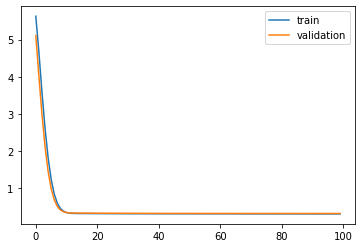

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6273 - acc: 0.6184 - val_loss: 5.1014 - val_acc: 0.8116

Epoch 00001: val_loss improved from inf to 5.10139, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6715 - acc: 0.8409 - val_loss: 4.0085 - val_acc: 0.8676

Epoch 00002: val_loss improved from 5.10139 to 4.00854, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5968 - acc: 0.8679 - val_loss: 2.9781 - val_acc: 0.8733

Epoch 00003: val_loss improved from 4.00854 to 2.97808, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.6232 - acc: 0.8727 - val_loss: 2.1052 - val_acc: 0.8754

Epoch 00004: val_loss improved from 2.97808 to 2.10522, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.8309 - acc: 0.8743 - val_loss: 1.4397 - val_acc: 0.8773

Epoch 00005: val_loss improved from 2.10522 to 1.43970, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2466 - acc: 0.8751 - v

 - 1s - loss: 0.3201 - acc: 0.8785 - val_loss: 0.3207 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32081 to 0.32072, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8785 - val_loss: 0.3206 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32072 to 0.32062, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32062 to 0.32053, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32053 to 0.32044, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8791

Epoch 00050: val_loss improved from 0.32044 to 0.32036, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31836 to 0.31834, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31834 to 0.31831, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31831 to 0.31829, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31829 to 0.31826, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31826 to 0.31824, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31824 to 0.31822, saving model to Event_val_weights

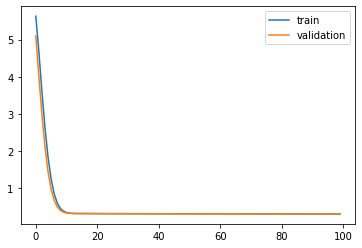

Time to train LSTM:  71.45397186279297
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6153 - acc: 0.6247 - val_loss: 5.0650 - val_acc: 0.8150

Epoch 00001: val_loss improved from inf to 5.06500, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6207 - acc: 0.8444 - val_loss: 3.9303 - val_acc: 0.8719

Epoch 00002: val_loss improved from 5.06500 to 3.93027, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5111 - acc: 0.8682 - val_loss: 2.8683 - val_acc: 0.8761

Epoch 00003: val_loss improved from 3.93027 to 2.86826, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.5145 - acc: 0.8727 - val_loss: 1.9828 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.86826 to 1.98277, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.7174 - acc: 0.8742 - val_loss: 1.3230 - val_acc: 0.8777

Epoch 00005: val_loss improved from 1.98277 to 1.32302, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3205 - acc: 0.8783 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31497 to 0.31488, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31488 to 0.31480, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31480 to 0.31471, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3202 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31471 to 0.31463, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3201 - acc: 0.8784 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31463 to 0.31455, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8803

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31267 to 0.31264, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00092: val_loss improved from 0.31264 to 0.31262, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00093: val_loss improved from 0.31262 to 0.31259, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00094: val_loss improved from 0.31259 to 0.31256, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8800

Epoch 00095: val_loss improved from 0.31256 to 0.31253, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8802

Epoch 00096: val_loss improved from 0.31253 to 0.31251, saving model to Event_val_weights

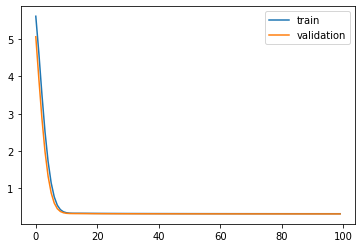

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feac7268a58>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6159 - acc: 0.6237 - val_loss: 5.0636 - val_acc: 0.8181

Epoch 00001: val_loss improved from inf to 5.06362, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6197 - acc: 0.8454 - val_loss: 3.9407 - val_acc: 0.8631

Epoch 00002: val_loss improved from 5.06362 to 3.94068, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5095 - acc: 0.8689 - val_loss: 2.8847 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.94068 to 2.88466, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.5129 - acc: 0.8730 - val_loss: 2.0013 - val_acc: 0.8720

Epoch 00004: val_loss improved from 2.88466 to 2.00126, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.7160 - acc: 0.8747 - val_loss: 1.3417 - val_acc: 0.8738

Epoch 00005: val_loss improved from 2.00126 to 1.34167, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.1430 - acc: 0.8757 - v

 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32534 to 0.32524, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32524 to 0.32514, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32514 to 0.32505, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32505 to 0.32495, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32495 to 0.32487, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00092: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32312 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00094: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00096: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights

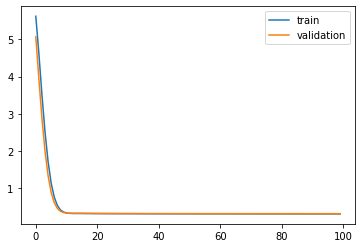

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6159 - acc: 0.6239 - val_loss: 5.0654 - val_acc: 0.8164

Epoch 00001: val_loss improved from inf to 5.06536, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6200 - acc: 0.8446 - val_loss: 3.9444 - val_acc: 0.8632

Epoch 00002: val_loss improved from 5.06536 to 3.94440, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5096 - acc: 0.8691 - val_loss: 2.8883 - val_acc: 0.8703

Epoch 00003: val_loss improved from 3.94440 to 2.88834, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.5129 - acc: 0.8731 - val_loss: 2.0051 - val_acc: 0.8727

Epoch 00004: val_loss improved from 2.88834 to 2.00505, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.7159 - acc: 0.8748 - val_loss: 1.3451 - val_acc: 0.8747

Epoch 00005: val_loss improved from 2.00505 to 1.34507, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.1428 - acc: 0.8755 - v

 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32540 to 0.32531, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32531 to 0.32521, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00048: val_loss improved from 0.32521 to 0.32512, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32512 to 0.32503, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00050: val_loss improved from 0.32503 to 0.32495, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32315 to 0.32314, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00094: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00095: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00096: val_loss improved from 0.32312 to 0.32311, saving model to Event_val_weights

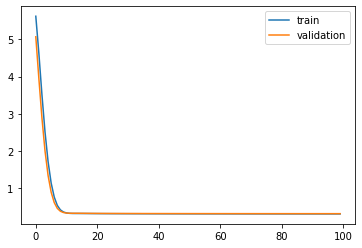

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6153 - acc: 0.6247 - val_loss: 5.0735 - val_acc: 0.8072

Epoch 00001: val_loss improved from inf to 5.07351, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6196 - acc: 0.8449 - val_loss: 3.9519 - val_acc: 0.8587

Epoch 00002: val_loss improved from 5.07351 to 3.95193, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5090 - acc: 0.8695 - val_loss: 2.8975 - val_acc: 0.8652

Epoch 00003: val_loss improved from 3.95193 to 2.89753, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.5121 - acc: 0.8737 - val_loss: 2.0140 - val_acc: 0.8663

Epoch 00004: val_loss improved from 2.89753 to 2.01398, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.7151 - acc: 0.8756 - val_loss: 1.3532 - val_acc: 0.8679

Epoch 00005: val_loss improved from 2.01398 to 1.35316, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.1420 - acc: 0.8762 - v

 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33015 to 0.33005, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33005 to 0.32996, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32996 to 0.32987, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32987 to 0.32978, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00050: val_loss improved from 0.32978 to 0.32970, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32804 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00092: val_loss improved from 0.32802 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8714

Epoch 00093: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32800 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00095: val_loss improved from 0.32799 to 0.32798, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00096: val_loss improved from 0.32798 to 0.32797, saving model to Event_val_weights

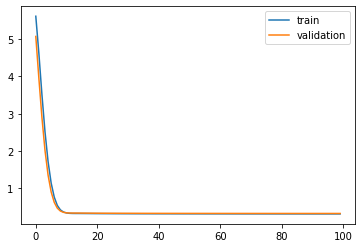

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6159 - acc: 0.6234 - val_loss: 5.0664 - val_acc: 0.8177

Epoch 00001: val_loss improved from inf to 5.06639, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6212 - acc: 0.8435 - val_loss: 3.9355 - val_acc: 0.8682

Epoch 00002: val_loss improved from 5.06639 to 3.93553, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5110 - acc: 0.8687 - val_loss: 2.8752 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.93553 to 2.87524, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.5140 - acc: 0.8728 - val_loss: 1.9900 - val_acc: 0.8761

Epoch 00004: val_loss improved from 2.87524 to 1.98995, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.7167 - acc: 0.8745 - val_loss: 1.3302 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.98995 to 1.33016, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.1433 - acc: 0.8754 - v

 - 1s - loss: 0.3199 - acc: 0.8785 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32062 to 0.32052, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32052 to 0.32043, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32043 to 0.32033, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32033 to 0.32025, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.32025 to 0.32016, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31825 to 0.31823, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31823 to 0.31820, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31820 to 0.31818, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31818 to 0.31816, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31816 to 0.31815, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00096: val_loss improved from 0.31815 to 0.31812, saving model to Event_val_weights

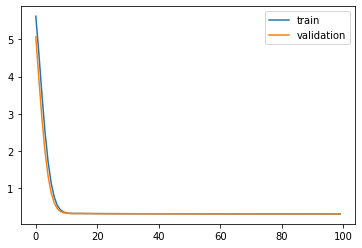

Time to train LSTM:  73.38635349273682
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 5.6020 - acc: 0.6299 - val_loss: 5.0243 - val_acc: 0.8223

Epoch 00001: val_loss improved from inf to 5.02427, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5626 - acc: 0.8472 - val_loss: 3.8459 - val_acc: 0.8719

Epoch 00002: val_loss improved from 5.02427 to 3.84594, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.4126 - acc: 0.8690 - val_loss: 2.7509 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.84594 to 2.75092, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.3909 - acc: 0.8730 - val_loss: 1.8540 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.75092 to 1.85405, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5912 - acc: 0.8745 - val_loss: 1.2041 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.85405 to 1.20412, saving model to Event_val_weights1.hdf5
Epoch 6/100


Epoch 00046: val_loss improved from 0.31476 to 0.31467, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8806

Epoch 00047: val_loss improved from 0.31467 to 0.31459, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00048: val_loss improved from 0.31459 to 0.31451, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31451 to 0.31443, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31443 to 0.31435, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31435 to 0.31427, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31248 to 0.31245, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31245 to 0.31243, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31243 to 0.31240, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00095: val_loss improved from 0.31240 to 0.31237, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31237 to 0.31235, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00097: val_

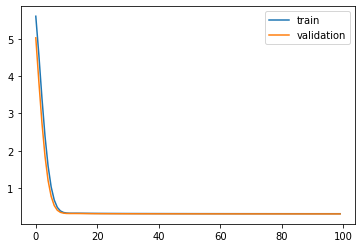

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 5.6025 - acc: 0.6289 - val_loss: 5.0234 - val_acc: 0.8222

Epoch 00001: val_loss improved from inf to 5.02338, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5616 - acc: 0.8479 - val_loss: 3.8570 - val_acc: 0.8642

Epoch 00002: val_loss improved from 5.02338 to 3.85704, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.4110 - acc: 0.8697 - val_loss: 2.7678 - val_acc: 0.8706

Epoch 00003: val_loss improved from 3.85704 to 2.76782, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.3894 - acc: 0.8734 - val_loss: 1.8729 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.76782 to 1.87286, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5898 - acc: 0.8750 - val_loss: 1.2229 - val_acc: 0.8736

Epoch 00005: val_loss improved from 1.87286 to 1.22292, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0324 - acc: 0.8759 - v

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32500 to 0.32491, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32491 to 0.32482, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32482 to 0.32473, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32473 to 0.32464, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32464 to 0.32456, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8759

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00096: val_loss improved from 0.32307 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights

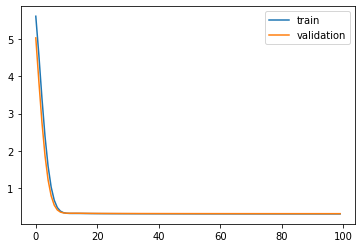

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 5.6026 - acc: 0.6294 - val_loss: 5.0252 - val_acc: 0.8217

Epoch 00001: val_loss improved from inf to 5.02524, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5619 - acc: 0.8471 - val_loss: 3.8608 - val_acc: 0.8639

Epoch 00002: val_loss improved from 5.02524 to 3.86080, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.4111 - acc: 0.8696 - val_loss: 2.7715 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.86080 to 2.77151, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.3894 - acc: 0.8733 - val_loss: 1.8767 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.77151 to 1.87672, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5897 - acc: 0.8751 - val_loss: 1.2262 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.87672 to 1.22625, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0323 - acc: 0.8757 - v


Epoch 00046: val_loss improved from 0.32518 to 0.32509, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32509 to 0.32500, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32500 to 0.32491, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32491 to 0.32482, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32482 to 0.32474, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32474 to 0.32466, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss improved from 0.32317 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3164 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32317 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00094: val_loss did not improve from 0.32317
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00095: val_loss did not improve from 0.32317
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00096: val_loss did not improve from 0.32317
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32317
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00098: va

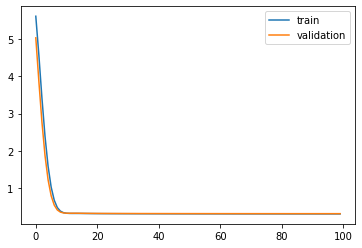

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 5.6019 - acc: 0.6300 - val_loss: 5.0333 - val_acc: 0.8109

Epoch 00001: val_loss improved from inf to 5.03332, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5615 - acc: 0.8479 - val_loss: 3.8685 - val_acc: 0.8598

Epoch 00002: val_loss improved from 5.03332 to 3.86847, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.4105 - acc: 0.8701 - val_loss: 2.7808 - val_acc: 0.8659

Epoch 00003: val_loss improved from 3.86847 to 2.78079, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.3886 - acc: 0.8739 - val_loss: 1.8855 - val_acc: 0.8664

Epoch 00004: val_loss improved from 2.78079 to 1.88550, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5889 - acc: 0.8759 - val_loss: 1.2341 - val_acc: 0.8681

Epoch 00005: val_loss improved from 1.88550 to 1.23410, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0315 - acc: 0.8762 - v


Epoch 00046: val_loss improved from 0.32992 to 0.32983, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32983 to 0.32974, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32974 to 0.32965, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00049: val_loss improved from 0.32965 to 0.32957, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32957 to 0.32949, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32949 to 0.32941, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00092: val_loss improved from 0.32801 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00093: val_loss improved from 0.32801 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00094: val_loss did not improve from 0.32801
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00095: val_loss did not improve from 0.32801
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss did not improve from 0.32801
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.32801
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00098: va

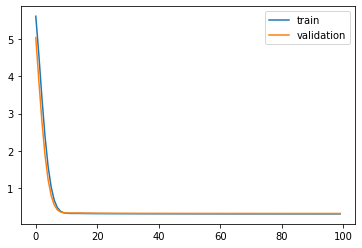

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 5.6025 - acc: 0.6290 - val_loss: 5.0258 - val_acc: 0.8222

Epoch 00001: val_loss improved from inf to 5.02583, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5632 - acc: 0.8466 - val_loss: 3.8514 - val_acc: 0.8689

Epoch 00002: val_loss improved from 5.02583 to 3.85140, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.4126 - acc: 0.8690 - val_loss: 2.7580 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.85140 to 2.75801, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.3904 - acc: 0.8730 - val_loss: 1.8613 - val_acc: 0.8768

Epoch 00004: val_loss improved from 2.75801 to 1.86126, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5904 - acc: 0.8747 - val_loss: 1.2113 - val_acc: 0.8771

Epoch 00005: val_loss improved from 1.86126 to 1.21132, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0327 - acc: 0.8755 - v


Epoch 00046: val_loss improved from 0.32039 to 0.32030, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8791

Epoch 00047: val_loss improved from 0.32030 to 0.32021, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32021 to 0.32012, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32012 to 0.32003, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32003 to 0.31995, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.31995 to 0.31987, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8791

Epoch 00092: val_loss did not improve from 0.31812
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31812 to 0.31806, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00094: val_loss did not improve from 0.31806
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31806 to 0.31804, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31804 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31802
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_lo

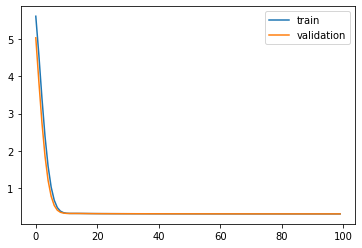

Time to train LSTM:  73.85160398483276
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 5.5917 - acc: 0.6341 - val_loss: 4.9932 - val_acc: 0.8262

Epoch 00001: val_loss improved from inf to 4.99320, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5184 - acc: 0.8494 - val_loss: 3.7819 - val_acc: 0.8721

Epoch 00002: val_loss improved from 4.99320 to 3.78194, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.3382 - acc: 0.8696 - val_loss: 2.6629 - val_acc: 0.8761

Epoch 00003: val_loss improved from 3.78194 to 2.66285, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.2989 - acc: 0.8731 - val_loss: 1.7594 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.66285 to 1.75939, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4993 - acc: 0.8747 - val_loss: 1.1192 - val_acc: 0.8778

Epoch 00005: val_loss improved from 1.75939 to 1.11917, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31461 to 0.31452, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3199 - acc: 0.8783 - val_loss: 0.3144 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31452 to 0.31444, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8806

Epoch 00048: val_loss improved from 0.31444 to 0.31435, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31435 to 0.31427, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31427 to 0.31420, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31420 to 0.31413, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8803

Epoch 00092: val_loss improved from 0.31236 to 0.31233, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31233 to 0.31230, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31230 to 0.31228, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31228 to 0.31225, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31225 to 0.31222, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00097: val_

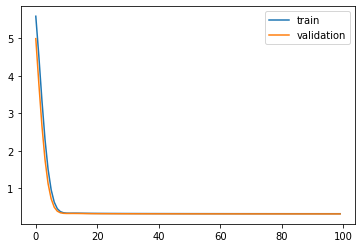

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 5.5922 - acc: 0.6328 - val_loss: 4.9927 - val_acc: 0.8263

Epoch 00001: val_loss improved from inf to 4.99268, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5174 - acc: 0.8502 - val_loss: 3.7936 - val_acc: 0.8657

Epoch 00002: val_loss improved from 4.99268 to 3.79355, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.3366 - acc: 0.8703 - val_loss: 2.6801 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.79355 to 2.68009, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.2973 - acc: 0.8737 - val_loss: 1.7784 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.68009 to 1.77842, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4980 - acc: 0.8750 - val_loss: 1.1381 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.77842 to 1.13807, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.9545 - acc: 0.8759 - 

 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00047: val_loss improved from 0.32484 to 0.32474, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00048: val_loss improved from 0.32474 to 0.32465, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32465 to 0.32457, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32457 to 0.32449, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32449 to 0.32441, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3183 - acc: 0.8789 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32310 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00093: val_loss did not improve from 0.32310
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00094: val_loss did not improve from 0.32310
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00095: val_loss did not improve from 0.32310
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00096: val_loss did not improve from 0.32310
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00097: val_loss did not improve from 0.32310
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00098: val_loss did not improve from 0.32310
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8

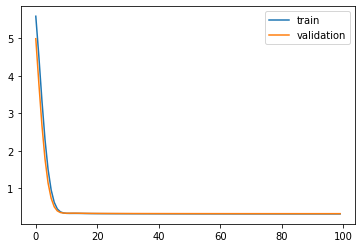

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feac46b9550>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 5.5923 - acc: 0.6332 - val_loss: 4.9946 - val_acc: 0.8261

Epoch 00001: val_loss improved from inf to 4.99464, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5177 - acc: 0.8492 - val_loss: 3.7973 - val_acc: 0.8648

Epoch 00002: val_loss improved from 4.99464 to 3.79733, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.3367 - acc: 0.8701 - val_loss: 2.6838 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.79733 to 2.68382, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.2974 - acc: 0.8735 - val_loss: 1.7823 - val_acc: 0.8739

Epoch 00004: val_loss improved from 2.68382 to 1.78233, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4979 - acc: 0.8750 - val_loss: 1.1413 - val_acc: 0.8749

Epoch 00005: val_loss improved from 1.78233 to 1.14133, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.9544 - acc: 0.8760 - 

 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8774

Epoch 00047: val_loss improved from 0.32493 to 0.32484, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32484 to 0.32475, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32475 to 0.32467, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32467 to 0.32459, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32459 to 0.32452, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8776

Epoch 00052: val_


Epoch 00093: val_loss did not improve from 0.32322
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8768

Epoch 00094: val_loss did not improve from 0.32322
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8768

Epoch 00095: val_loss did not improve from 0.32322
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8769

Epoch 00096: val_loss did not improve from 0.32322
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32322
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8768

Epoch 00098: val_loss did not improve from 0.32322
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3234 - val_acc: 0.8768

Epoch 00099: val_loss did not improve from 0.32322
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3234 - val_acc: 0.8767

Epoch 00100: val_loss did not improve f

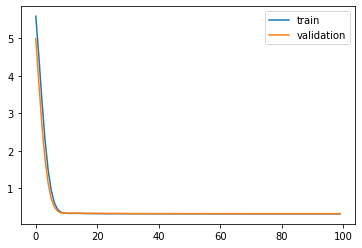

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 5.5916 - acc: 0.6340 - val_loss: 5.0026 - val_acc: 0.8149

Epoch 00001: val_loss improved from inf to 5.00265, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5174 - acc: 0.8500 - val_loss: 3.8051 - val_acc: 0.8603

Epoch 00002: val_loss improved from 5.00265 to 3.80512, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.3361 - acc: 0.8707 - val_loss: 2.6931 - val_acc: 0.8657

Epoch 00003: val_loss improved from 3.80512 to 2.69312, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.2965 - acc: 0.8742 - val_loss: 1.7910 - val_acc: 0.8672

Epoch 00004: val_loss improved from 2.69312 to 1.79099, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4971 - acc: 0.8759 - val_loss: 1.1490 - val_acc: 0.8683

Epoch 00005: val_loss improved from 1.79099 to 1.14900, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.9536 - acc: 0.8764 - 

 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32967 to 0.32958, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8713

Epoch 00048: val_loss improved from 0.32958 to 0.32949, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.32949 to 0.32941, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00050: val_loss improved from 0.32941 to 0.32933, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32933 to 0.32926, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00052: val_


Epoch 00093: val_loss did not improve from 0.32805
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00094: val_loss did not improve from 0.32805
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00095: val_loss did not improve from 0.32805
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00096: val_loss did not improve from 0.32805
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00097: val_loss did not improve from 0.32805
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8717

Epoch 00098: val_loss did not improve from 0.32805
Epoch 99/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8717

Epoch 00099: val_loss did not improve from 0.32805
Epoch 100/100
 - 1s - loss: 0.3158 - acc: 0.8800 - val_loss: 0.3282 - val_acc: 0.8712

Epoch 00100: val_loss did not improve f

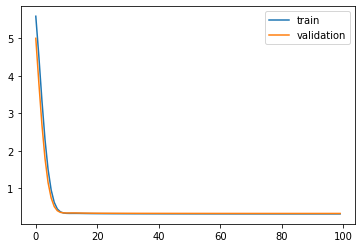

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5923 - acc: 0.6330 - val_loss: 4.9949 - val_acc: 0.8259

Epoch 00001: val_loss improved from inf to 4.99489, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5190 - acc: 0.8484 - val_loss: 3.7876 - val_acc: 0.8698

Epoch 00002: val_loss improved from 4.99489 to 3.78757, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.3381 - acc: 0.8695 - val_loss: 2.6700 - val_acc: 0.8743

Epoch 00003: val_loss improved from 3.78757 to 2.67000, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.2983 - acc: 0.8733 - val_loss: 1.7666 - val_acc: 0.8773

Epoch 00004: val_loss improved from 2.67000 to 1.76662, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4986 - acc: 0.8748 - val_loss: 1.1264 - val_acc: 0.8769

Epoch 00005: val_loss improved from 1.76662 to 1.12641, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.9547 - acc: 0.8757 - 

 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32014 to 0.32004, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32004 to 0.31996, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.31996 to 0.31987, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.31987 to 0.31979, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3197 - val_acc: 0.8792

Epoch 00051: val_loss improved from 0.31979 to 0.31971, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8793

Epoch 00052: val_


Epoch 00093: val_loss improved from 0.31806 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00094: val_loss did not improve from 0.31805
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31805 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31803
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss improved from 0.31803 to 0.31800, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00098: val_loss did not improve from 0.31800
Epoch 99/100
 - 1s - loss: 0.3171 - acc: 0.8789 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00099: val_loss improved from 0.3180

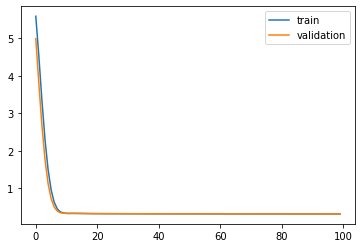

Time to train LSTM:  75.41778326034546
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5846 - acc: 0.6368 - val_loss: 4.9719 - val_acc: 0.8271

Epoch 00001: val_loss improved from inf to 4.97188, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4882 - acc: 0.8503 - val_loss: 3.7382 - val_acc: 0.8724

Epoch 00002: val_loss improved from 4.97188 to 3.73818, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2874 - acc: 0.8698 - val_loss: 2.6031 - val_acc: 0.8759

Epoch 00003: val_loss improved from 3.73818 to 2.60315, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.2369 - acc: 0.8732 - val_loss: 1.6962 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.60315 to 1.69622, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.4385 - acc: 0.8748 - val_loss: 1.0637 - val_acc: 0.8779

Epoch 00005: val_loss improved from 1.69622 to 1.06374, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31450 to 0.31442, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31442 to 0.31433, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31433 to 0.31425, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31425 to 0.31417, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31417 to 0.31410, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8804

Epoch 00051: val_loss improved from 0.31410 to 0.31403, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00092: val_loss improved from 0.31228 to 0.31225, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31225 to 0.31222, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31222 to 0.31220, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31220 to 0.31218, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31218 to 0.31215, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

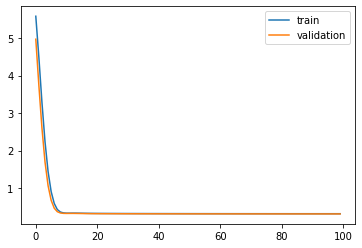

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5851 - acc: 0.6356 - val_loss: 4.9716 - val_acc: 0.8274

Epoch 00001: val_loss improved from inf to 4.97161, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4871 - acc: 0.8515 - val_loss: 3.7501 - val_acc: 0.8662

Epoch 00002: val_loss improved from 4.97161 to 3.75013, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2858 - acc: 0.8704 - val_loss: 2.6206 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.75013 to 2.62061, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.2353 - acc: 0.8737 - val_loss: 1.7154 - val_acc: 0.8732

Epoch 00004: val_loss improved from 2.62061 to 1.71539, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.4372 - acc: 0.8752 - val_loss: 1.0827 - val_acc: 0.8736

Epoch 00005: val_loss improved from 1.71539 to 1.08269, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.9043 - acc: 0.8760 - 

 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00047: val_loss improved from 0.32472 to 0.32463, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32463 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00049: val_loss improved from 0.32455 to 0.32446, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32446 to 0.32438, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32438 to 0.32431, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00093: val_loss did not improve from 0.32312
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00094: val_loss did not improve from 0.32312
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8758

Epoch 00095: val_loss did not improve from 0.32312
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00096: val_loss did not improve from 0.32312
Epoch 97/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00097: val_loss did not improve from 0.32312
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00098: val_loss did not improve from 0.32312
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32312
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8760

Epoch 00100: val_loss did not improve f

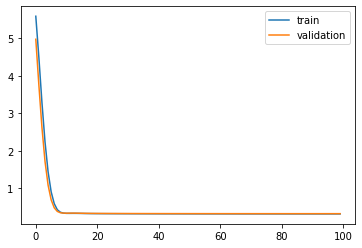

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5852 - acc: 0.6357 - val_loss: 4.9736 - val_acc: 0.8287

Epoch 00001: val_loss improved from inf to 4.97364, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4874 - acc: 0.8503 - val_loss: 3.7539 - val_acc: 0.8651

Epoch 00002: val_loss improved from 4.97364 to 3.75391, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2859 - acc: 0.8703 - val_loss: 2.6244 - val_acc: 0.8713

Epoch 00003: val_loss improved from 3.75391 to 2.62437, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.2353 - acc: 0.8738 - val_loss: 1.7193 - val_acc: 0.8740

Epoch 00004: val_loss improved from 2.62437 to 1.71934, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.4371 - acc: 0.8750 - val_loss: 1.0859 - val_acc: 0.8749

Epoch 00005: val_loss improved from 1.71934 to 1.08589, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.9041 - acc: 0.8759 - 

 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32483 to 0.32474, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32474 to 0.32465, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32465 to 0.32457, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32457 to 0.32450, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32450 to 0.32442, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00052: val_

 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8768

Epoch 00095: val_loss did not improve from 0.32326
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3235 - val_acc: 0.8768

Epoch 00096: val_loss did not improve from 0.32326
Epoch 97/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3235 - val_acc: 0.8766

Epoch 00097: val_loss did not improve from 0.32326
Epoch 98/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3236 - val_acc: 0.8766

Epoch 00098: val_loss did not improve from 0.32326
Epoch 99/100
 - 1s - loss: 0.3165 - acc: 0.8796 - val_loss: 0.3236 - val_acc: 0.8768

Epoch 00099: val_loss did not improve from 0.32326
Epoch 100/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3236 - val_acc: 0.8768

Epoch 00100: val_loss did not improve from 0.32326
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04303739036104375
Decay: 4.943761151192986e-08
best val loss: 0.323261827230453

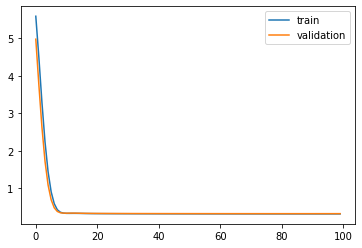

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5845 - acc: 0.6366 - val_loss: 4.9816 - val_acc: 0.8168

Epoch 00001: val_loss improved from inf to 4.98160, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4871 - acc: 0.8511 - val_loss: 3.7618 - val_acc: 0.8606

Epoch 00002: val_loss improved from 4.98160 to 3.76179, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2853 - acc: 0.8709 - val_loss: 2.6337 - val_acc: 0.8659

Epoch 00003: val_loss improved from 3.76179 to 2.63367, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.2345 - acc: 0.8744 - val_loss: 1.7279 - val_acc: 0.8672

Epoch 00004: val_loss improved from 2.63367 to 1.72790, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.4363 - acc: 0.8759 - val_loss: 1.0934 - val_acc: 0.8684

Epoch 00005: val_loss improved from 1.72790 to 1.09343, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.9033 - acc: 0.8766 - 

 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8713

Epoch 00047: val_loss improved from 0.32956 to 0.32947, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32947 to 0.32939, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00049: val_loss improved from 0.32939 to 0.32931, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.32931 to 0.32924, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00051: val_loss improved from 0.32924 to 0.32916, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00052: val_


Epoch 00094: val_loss did not improve from 0.32807
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3282 - val_acc: 0.8716

Epoch 00095: val_loss did not improve from 0.32807
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3283 - val_acc: 0.8712

Epoch 00096: val_loss did not improve from 0.32807
Epoch 97/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00097: val_loss did not improve from 0.32807
Epoch 98/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32807
Epoch 99/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00099: val_loss did not improve from 0.32807
Epoch 100/100
 - 1s - loss: 0.3159 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00100: val_loss did not improve from 0.32807
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04303739036104

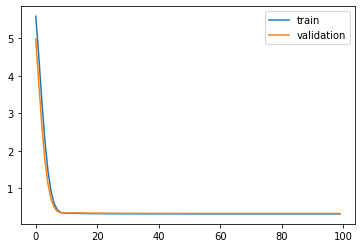

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.5852 - acc: 0.6355 - val_loss: 4.9737 - val_acc: 0.8282

Epoch 00001: val_loss improved from inf to 4.97366, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4888 - acc: 0.8497 - val_loss: 3.7439 - val_acc: 0.8697

Epoch 00002: val_loss improved from 4.97366 to 3.74391, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2873 - acc: 0.8698 - val_loss: 2.6103 - val_acc: 0.8742

Epoch 00003: val_loss improved from 3.74391 to 2.61034, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.2363 - acc: 0.8734 - val_loss: 1.7035 - val_acc: 0.8776

Epoch 00004: val_loss improved from 2.61034 to 1.70347, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.4377 - acc: 0.8748 - val_loss: 1.0710 - val_acc: 0.8774

Epoch 00005: val_loss improved from 1.70347 to 1.07101, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.9044 - acc: 0.8758 - 

 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.32003 to 0.31994, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.31994 to 0.31985, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8792

Epoch 00049: val_loss improved from 0.31985 to 0.31977, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31977 to 0.31969, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00051: val_loss improved from 0.31969 to 0.31961, saving model to Event_val_weights5.hdf5
Epoch 52/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00052: val_


Epoch 00093: val_loss did not improve from 0.31804
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31804 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss did not improve from 0.31803
Epoch 96/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31803
Epoch 97/100
 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31803
Epoch 98/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00098: val_loss did not improve from 0.31803
Epoch 99/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00099: val_loss did not improve from 0.31803
Epoch 100/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.

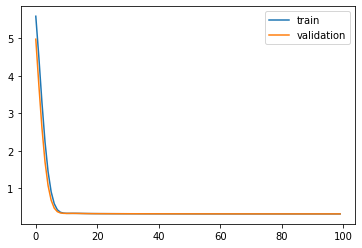

Time to train LSTM:  76.29329037666321
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 11s - loss: 5.6088 - acc: 0.6272 - val_loss: 5.0451 - val_acc: 0.8184

Epoch 00001: val_loss improved from inf to 5.04511, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5923 - acc: 0.8461 - val_loss: 3.8890 - val_acc: 0.8720

Epoch 00002: val_loss improved from 5.04511 to 3.88903, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.4629 - acc: 0.8685 - val_loss: 2.8107 - val_acc: 0.8762

Epoch 00003: val_loss improved from 3.88903 to 2.81070, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.4537 - acc: 0.8729 - val_loss: 1.9193 - val_acc: 0.8762

Epoch 00004: val_loss improved from 2.81070 to 1.91927, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.6549 - acc: 0.8744 - val_loss: 1.2639 - val_acc: 0.8776

Epoch 00005: val_loss improved from 1.91927 to 1.26389, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8807

Epoch 00046: val_loss improved from 0.31487 to 0.31478, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3203 - acc: 0.8783 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31478 to 0.31469, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8806

Epoch 00048: val_loss improved from 0.31469 to 0.31461, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.31461 to 0.31453, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31453 to 0.31445, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31259 to 0.31257, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8802

Epoch 00092: val_loss improved from 0.31257 to 0.31254, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8802

Epoch 00093: val_loss improved from 0.31254 to 0.31251, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8803

Epoch 00094: val_loss improved from 0.31251 to 0.31248, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8803

Epoch 00095: val_loss improved from 0.31248 to 0.31246, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31246 to 0.31243, saving model to Event_val_weights

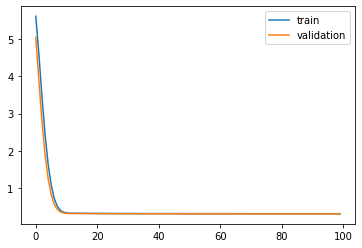

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 5.6093 - acc: 0.6263 - val_loss: 5.0440 - val_acc: 0.8204

Epoch 00001: val_loss improved from inf to 5.04397, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5913 - acc: 0.8467 - val_loss: 3.8998 - val_acc: 0.8638

Epoch 00002: val_loss improved from 5.04397 to 3.89978, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.4613 - acc: 0.8693 - val_loss: 2.8273 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.89978 to 2.82735, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.4522 - acc: 0.8733 - val_loss: 1.9379 - val_acc: 0.8722

Epoch 00004: val_loss improved from 2.82735 to 1.93791, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.6536 - acc: 0.8748 - val_loss: 1.2826 - val_acc: 0.8736

Epoch 00005: val_loss improved from 1.93791 to 1.28262, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0878 - acc: 0.8758 - 

 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32522 to 0.32512, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32512 to 0.32503, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32503 to 0.32493, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32493 to 0.32484, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32484 to 0.32476, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32312 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00092: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00096: val_loss improved from 0.32307 to 0.32306, saving model to Event_val_weights

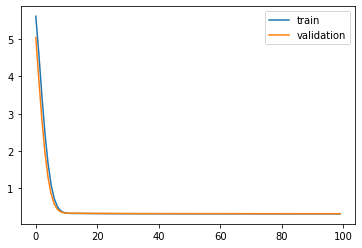

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 5.6094 - acc: 0.6267 - val_loss: 5.0458 - val_acc: 0.8198

Epoch 00001: val_loss improved from inf to 5.04577, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5916 - acc: 0.8457 - val_loss: 3.9035 - val_acc: 0.8641

Epoch 00002: val_loss improved from 5.04577 to 3.90352, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.4614 - acc: 0.8693 - val_loss: 2.8310 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.90352 to 2.83103, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.4522 - acc: 0.8732 - val_loss: 1.9417 - val_acc: 0.8731

Epoch 00004: val_loss improved from 2.83103 to 1.94174, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.6534 - acc: 0.8750 - val_loss: 1.2860 - val_acc: 0.8744

Epoch 00005: val_loss improved from 1.94174 to 1.28598, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0876 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32529 to 0.32520, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00047: val_loss improved from 0.32520 to 0.32510, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32510 to 0.32502, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00049: val_loss improved from 0.32502 to 0.32493, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32493 to 0.32485, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32485 to 0.32477, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00092: val_loss improved from 0.32315 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00093: val_loss improved from 0.32315 to 0.32314, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00094: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00095: val_loss improved from 0.32313 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00096: val_loss improved from 0.32313 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8770

Epoch 00097: val_

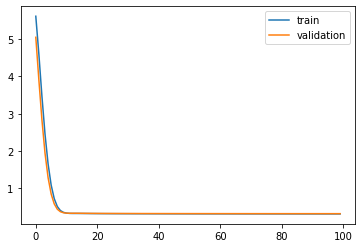

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 5.6087 - acc: 0.6276 - val_loss: 5.0539 - val_acc: 0.8084

Epoch 00001: val_loss improved from inf to 5.05388, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5912 - acc: 0.8464 - val_loss: 3.9111 - val_acc: 0.8596

Epoch 00002: val_loss improved from 5.05388 to 3.91111, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.4608 - acc: 0.8699 - val_loss: 2.8403 - val_acc: 0.8654

Epoch 00003: val_loss improved from 3.91111 to 2.84027, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.4514 - acc: 0.8738 - val_loss: 1.9506 - val_acc: 0.8666

Epoch 00004: val_loss improved from 2.84027 to 1.95060, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.6527 - acc: 0.8757 - val_loss: 1.2940 - val_acc: 0.8682

Epoch 00005: val_loss improved from 1.95060 to 1.29396, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0868 - acc: 0.8761 - 


Epoch 00046: val_loss improved from 0.33004 to 0.32994, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8713

Epoch 00047: val_loss improved from 0.32994 to 0.32985, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00048: val_loss improved from 0.32985 to 0.32976, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00049: val_loss improved from 0.32976 to 0.32967, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00050: val_loss improved from 0.32967 to 0.32959, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8716

Epoch 00051: val_loss improved from 0.32959 to 0.32951, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00092: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00093: val_loss improved from 0.32800 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00094: val_loss improved from 0.32799 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00095: val_loss improved from 0.32799 to 0.32798, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss improved from 0.32798 to 0.32798, saving model to Event_val_weights4.hdf5
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00097: val_

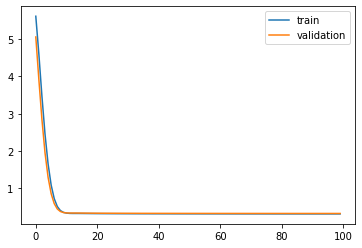

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 5.6094 - acc: 0.6263 - val_loss: 5.0466 - val_acc: 0.8196

Epoch 00001: val_loss improved from inf to 5.04658, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5928 - acc: 0.8449 - val_loss: 3.8944 - val_acc: 0.8689

Epoch 00002: val_loss improved from 5.04658 to 3.89439, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.4628 - acc: 0.8688 - val_loss: 2.8177 - val_acc: 0.8734

Epoch 00003: val_loss improved from 3.89439 to 2.81773, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.4532 - acc: 0.8728 - val_loss: 1.9265 - val_acc: 0.8764

Epoch 00004: val_loss improved from 2.81773 to 1.92646, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.6542 - acc: 0.8746 - val_loss: 1.2711 - val_acc: 0.8769

Epoch 00005: val_loss improved from 1.92646 to 1.27106, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0881 - acc: 0.8754 - 

 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32051 to 0.32041, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32041 to 0.32032, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.32032 to 0.32023, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32023 to 0.32014, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32014 to 0.32006, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31820 to 0.31818, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31818 to 0.31815, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00093: val_loss improved from 0.31815 to 0.31814, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00094: val_loss improved from 0.31814 to 0.31811, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00095: val_loss did not improve from 0.31811
Epoch 96/100
 - 1s - loss: 0.3170 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31811 to 0.31806, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3171 - ac

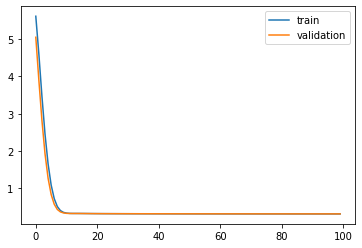

Time to train LSTM:  79.68722152709961


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feac0ec9518>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6271 - acc: 0.6198 - val_loss: 5.1012 - val_acc: 0.8109

Epoch 00001: val_loss improved from inf to 5.10124, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6725 - acc: 0.8417 - val_loss: 4.0058 - val_acc: 0.8709

Epoch 00002: val_loss improved from 5.10124 to 4.00579, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5995 - acc: 0.8676 - val_loss: 2.9745 - val_acc: 0.8761

Epoch 00003: val_loss improved from 4.00579 to 2.97446, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.6272 - acc: 0.8724 - val_loss: 2.1017 - val_acc: 0.8760

Epoch 00004: val_loss improved from 2.97446 to 2.10173, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.8352 - acc: 0.8741 - val_loss: 1.4361 - val_acc: 0.8776

Epoch 00005: val_loss improved from 2.10173 to 1.43614, saving model to Event_val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 1.2507 - acc: 0.8752 - 

 - 1s - loss: 0.3207 - acc: 0.8783 - val_loss: 0.3151 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31517 to 0.31508, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3206 - acc: 0.8783 - val_loss: 0.3150 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31508 to 0.31499, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3205 - acc: 0.8783 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00048: val_loss improved from 0.31499 to 0.31490, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00049: val_loss improved from 0.31490 to 0.31482, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31482 to 0.31474, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8806

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31282 to 0.31279, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00092: val_loss improved from 0.31279 to 0.31276, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31276 to 0.31274, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8803

Epoch 00094: val_loss improved from 0.31274 to 0.31271, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31271 to 0.31268, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31268 to 0.31265, saving model to Event_val_weights

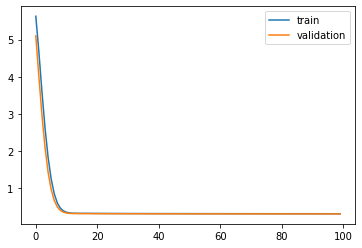

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6277 - acc: 0.6186 - val_loss: 5.0994 - val_acc: 0.8142

Epoch 00001: val_loss improved from inf to 5.09944, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6716 - acc: 0.8423 - val_loss: 4.0155 - val_acc: 0.8623

Epoch 00002: val_loss improved from 5.09944 to 4.01554, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5980 - acc: 0.8684 - val_loss: 2.9904 - val_acc: 0.8703

Epoch 00003: val_loss improved from 4.01554 to 2.99040, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.6256 - acc: 0.8727 - val_loss: 2.1199 - val_acc: 0.8722

Epoch 00004: val_loss improved from 2.99040 to 2.11989, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.8338 - acc: 0.8746 - val_loss: 1.4546 - val_acc: 0.8739

Epoch 00005: val_loss improved from 2.11989 to 1.45463, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.2495 - acc: 0.8756 - 

 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3255 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32556 to 0.32546, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3254 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32546 to 0.32536, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32536 to 0.32526, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32526 to 0.32517, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8769

Epoch 00050: val_loss improved from 0.32517 to 0.32508, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3167 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32318 to 0.32317, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00094: val_loss improved from 0.32317 to 0.32315, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00095: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8764

Epoch 00096: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights

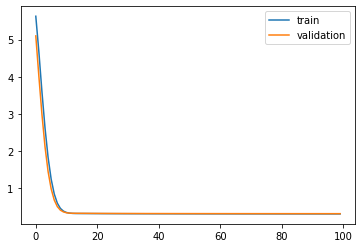

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6278 - acc: 0.6190 - val_loss: 5.1011 - val_acc: 0.8134

Epoch 00001: val_loss improved from inf to 5.10106, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6719 - acc: 0.8414 - val_loss: 4.0192 - val_acc: 0.8628

Epoch 00002: val_loss improved from 5.10106 to 4.01922, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5980 - acc: 0.8684 - val_loss: 2.9941 - val_acc: 0.8699

Epoch 00003: val_loss improved from 4.01922 to 2.99407, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.6256 - acc: 0.8729 - val_loss: 2.1236 - val_acc: 0.8719

Epoch 00004: val_loss improved from 2.99407 to 2.12363, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.8337 - acc: 0.8746 - val_loss: 1.4581 - val_acc: 0.8748

Epoch 00005: val_loss improved from 2.12363 to 1.45806, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.2494 - acc: 0.8754 - 

 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3255 - val_acc: 0.8777

Epoch 00046: val_loss improved from 0.32561 to 0.32551, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8789 - val_loss: 0.3254 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32551 to 0.32541, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32541 to 0.32532, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32532 to 0.32523, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32523 to 0.32515, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3251 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32324 to 0.32322, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00093: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00094: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00095: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00096: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights

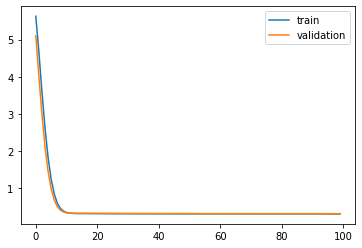

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6271 - acc: 0.6196 - val_loss: 5.1093 - val_acc: 0.8018

Epoch 00001: val_loss improved from inf to 5.10928, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6715 - acc: 0.8420 - val_loss: 4.0266 - val_acc: 0.8577

Epoch 00002: val_loss improved from 5.10928 to 4.02664, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5975 - acc: 0.8688 - val_loss: 3.0032 - val_acc: 0.8651

Epoch 00003: val_loss improved from 4.02664 to 3.00315, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.6248 - acc: 0.8734 - val_loss: 2.1327 - val_acc: 0.8672

Epoch 00004: val_loss improved from 3.00315 to 2.13267, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.8329 - acc: 0.8752 - val_loss: 1.4663 - val_acc: 0.8678

Epoch 00005: val_loss improved from 2.13267 to 1.46634, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.2486 - acc: 0.8762 - 

 - 1s - loss: 0.3191 - acc: 0.8796 - val_loss: 0.3303 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33035 to 0.33025, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00047: val_loss improved from 0.33025 to 0.33016, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8796 - val_loss: 0.3301 - val_acc: 0.8711

Epoch 00048: val_loss improved from 0.33016 to 0.33007, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.33007 to 0.32998, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.32998 to 0.32989, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32810 to 0.32808, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3161 - acc: 0.8800 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00092: val_loss improved from 0.32808 to 0.32807, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3161 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32807 to 0.32805, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32805 to 0.32803, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00096: val_loss improved from 0.32802 to 0.32801, saving model to Event_val_weights

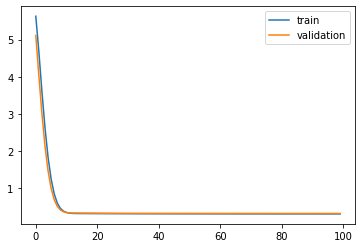

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6276 - acc: 0.6183 - val_loss: 5.1025 - val_acc: 0.8114

Epoch 00001: val_loss improved from inf to 5.10249, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6730 - acc: 0.8408 - val_loss: 4.0108 - val_acc: 0.8676

Epoch 00002: val_loss improved from 5.10249 to 4.01084, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5995 - acc: 0.8679 - val_loss: 2.9813 - val_acc: 0.8733

Epoch 00003: val_loss improved from 4.01084 to 2.98133, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.6266 - acc: 0.8727 - val_loss: 2.1089 - val_acc: 0.8756

Epoch 00004: val_loss improved from 2.98133 to 2.10889, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.8345 - acc: 0.8743 - val_loss: 1.4432 - val_acc: 0.8773

Epoch 00005: val_loss improved from 2.10889 to 1.44324, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2499 - acc: 0.8751 - 

 - 1s - loss: 0.3201 - acc: 0.8785 - val_loss: 0.3207 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32082 to 0.32072, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8785 - val_loss: 0.3206 - val_acc: 0.8789

Epoch 00047: val_loss improved from 0.32072 to 0.32063, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32063 to 0.32054, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32054 to 0.32045, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8791

Epoch 00050: val_loss improved from 0.32045 to 0.32036, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31837 to 0.31834, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31834 to 0.31831, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31831 to 0.31829, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31829 to 0.31827, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31827 to 0.31824, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31824 to 0.31822, saving model to Event_val_weights

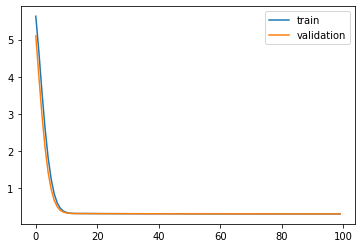

Time to train LSTM:  78.94725775718689
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6142 - acc: 0.6252 - val_loss: 5.0615 - val_acc: 0.8152

Epoch 00001: val_loss improved from inf to 5.06150, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6157 - acc: 0.8447 - val_loss: 3.9230 - val_acc: 0.8719

Epoch 00002: val_loss improved from 5.06150 to 3.92302, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5026 - acc: 0.8682 - val_loss: 2.8581 - val_acc: 0.8761

Epoch 00003: val_loss improved from 3.92302 to 2.85811, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.5038 - acc: 0.8727 - val_loss: 1.9715 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.85811 to 1.97153, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.7063 - acc: 0.8742 - val_loss: 1.3125 - val_acc: 0.8777

Epoch 00005: val_loss improved from 1.97153 to 1.31250, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3205 - acc: 0.8784 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31496 to 0.31487, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31487 to 0.31478, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31478 to 0.31469, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.31469 to 0.31461, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31461 to 0.31453, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31266 to 0.31263, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00092: val_loss improved from 0.31263 to 0.31260, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00093: val_loss improved from 0.31260 to 0.31258, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3125 - val_acc: 0.8801

Epoch 00094: val_loss improved from 0.31258 to 0.31255, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31255 to 0.31252, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8802

Epoch 00096: val_loss improved from 0.31252 to 0.31249, saving model to Event_val_weights

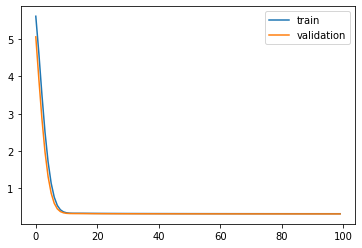

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6147 - acc: 0.6241 - val_loss: 5.0602 - val_acc: 0.8189

Epoch 00001: val_loss improved from inf to 5.06017, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6147 - acc: 0.8456 - val_loss: 3.9335 - val_acc: 0.8633

Epoch 00002: val_loss improved from 5.06017 to 3.93349, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5010 - acc: 0.8689 - val_loss: 2.8746 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.93349 to 2.87456, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.5022 - acc: 0.8730 - val_loss: 1.9900 - val_acc: 0.8720

Epoch 00004: val_loss improved from 2.87456 to 1.99005, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.7049 - acc: 0.8747 - val_loss: 1.3312 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.99005 to 1.33116, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.1331 - acc: 0.8757 - 

 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32532 to 0.32522, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32522 to 0.32512, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32512 to 0.32503, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32503 to 0.32493, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32493 to 0.32485, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00092: val_loss improved from 0.32313 to 0.32311, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00093: val_loss improved from 0.32311 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00094: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00096: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights

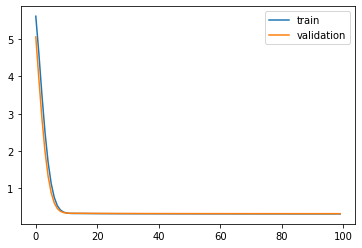

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 5.6148 - acc: 0.6244 - val_loss: 5.0619 - val_acc: 0.8173

Epoch 00001: val_loss improved from inf to 5.06191, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6150 - acc: 0.8448 - val_loss: 3.9372 - val_acc: 0.8636

Epoch 00002: val_loss improved from 5.06191 to 3.93721, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5011 - acc: 0.8691 - val_loss: 2.8782 - val_acc: 0.8703

Epoch 00003: val_loss improved from 3.93721 to 2.87824, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.5022 - acc: 0.8731 - val_loss: 1.9938 - val_acc: 0.8727

Epoch 00004: val_loss improved from 2.87824 to 1.99384, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.7048 - acc: 0.8749 - val_loss: 1.3346 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.99384 to 1.33455, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.1329 - acc: 0.8756 - 

 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32538 to 0.32529, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32529 to 0.32519, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00048: val_loss improved from 0.32519 to 0.32510, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32510 to 0.32502, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00050: val_loss improved from 0.32502 to 0.32493, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32317 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00092: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32315 to 0.32314, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00094: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00095: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00096: val_loss improved from 0.32312 to 0.32311, saving model to Event_val_weights

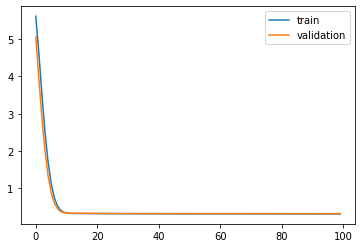

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 5.6141 - acc: 0.6253 - val_loss: 5.0701 - val_acc: 0.8072

Epoch 00001: val_loss improved from inf to 5.07006, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6146 - acc: 0.8452 - val_loss: 3.9447 - val_acc: 0.8589

Epoch 00002: val_loss improved from 5.07006 to 3.94475, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5005 - acc: 0.8696 - val_loss: 2.8874 - val_acc: 0.8651

Epoch 00003: val_loss improved from 3.94475 to 2.88744, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.5014 - acc: 0.8737 - val_loss: 2.0028 - val_acc: 0.8663

Epoch 00004: val_loss improved from 2.88744 to 2.00277, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.7040 - acc: 0.8756 - val_loss: 1.3426 - val_acc: 0.8681

Epoch 00005: val_loss improved from 2.00277 to 1.34262, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.1321 - acc: 0.8762 - 

 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33013 to 0.33003, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3299 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33003 to 0.32994, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8713

Epoch 00048: val_loss improved from 0.32994 to 0.32985, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32985 to 0.32976, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00050: val_loss improved from 0.32976 to 0.32968, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00092: val_loss improved from 0.32802 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00094: val_loss improved from 0.32800 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00095: val_loss improved from 0.32799 to 0.32798, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00096: val_loss improved from 0.32798 to 0.32797, saving model to Event_val_weights

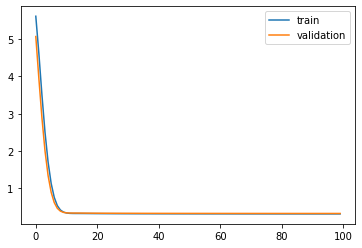

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 5.6147 - acc: 0.6239 - val_loss: 5.0629 - val_acc: 0.8178

Epoch 00001: val_loss improved from inf to 5.06291, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6162 - acc: 0.8437 - val_loss: 3.9283 - val_acc: 0.8684

Epoch 00002: val_loss improved from 5.06291 to 3.92829, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5026 - acc: 0.8687 - val_loss: 2.8651 - val_acc: 0.8736

Epoch 00003: val_loss improved from 3.92829 to 2.86510, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.5032 - acc: 0.8728 - val_loss: 1.9787 - val_acc: 0.8763

Epoch 00004: val_loss improved from 2.86510 to 1.97872, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.7056 - acc: 0.8745 - val_loss: 1.3196 - val_acc: 0.8773

Epoch 00005: val_loss improved from 1.97872 to 1.31964, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.1334 - acc: 0.8754 - 

 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32060 to 0.32050, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32050 to 0.32041, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32041 to 0.32032, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32032 to 0.32023, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.32023 to 0.32014, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31824 to 0.31822, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31822 to 0.31820, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31820 to 0.31818, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31818 to 0.31815, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00095: val_loss improved from 0.31815 to 0.31814, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00096: val_loss improved from 0.31814 to 0.31811, saving model to Event_val_weights

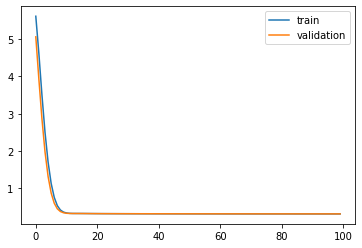

Time to train LSTM:  79.56116724014282
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 5.5786 - acc: 0.6390 - val_loss: 4.9539 - val_acc: 0.8296

Epoch 00001: val_loss improved from inf to 4.95391, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4627 - acc: 0.8510 - val_loss: 3.7014 - val_acc: 0.8728

Epoch 00002: val_loss improved from 4.95391 to 3.70139, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2449 - acc: 0.8700 - val_loss: 2.5533 - val_acc: 0.8760

Epoch 00003: val_loss improved from 3.70139 to 2.55329, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.1853 - acc: 0.8732 - val_loss: 1.6441 - val_acc: 0.8768

Epoch 00004: val_loss improved from 2.55329 to 1.64411, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3887 - acc: 0.8748 - val_loss: 1.0188 - val_acc: 0.8780

Epoch 00005: val_loss improved from 1.64411 to 1.01881, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31442 to 0.31433, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31433 to 0.31425, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31425 to 0.31417, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31417 to 0.31409, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31409 to 0.31402, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3139 - val_acc: 0.8803

Epoch 00051: val_loss improved from 0.31402 to 0.31395, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31221 to 0.31219, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8792 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31219 to 0.31217, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00094: val_loss improved from 0.31217 to 0.31214, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31214 to 0.31213, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31213 to 0.31211, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

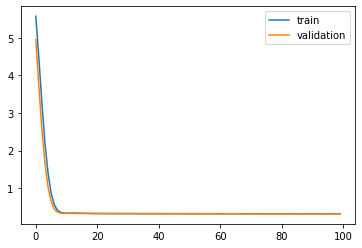

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 5.5791 - acc: 0.6379 - val_loss: 4.9538 - val_acc: 0.8286

Epoch 00001: val_loss improved from inf to 4.95385, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4616 - acc: 0.8522 - val_loss: 3.7136 - val_acc: 0.8662

Epoch 00002: val_loss improved from 4.95385 to 3.71362, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2432 - acc: 0.8705 - val_loss: 2.5709 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.71362 to 2.57095, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.1838 - acc: 0.8737 - val_loss: 1.6634 - val_acc: 0.8729

Epoch 00004: val_loss improved from 2.57095 to 1.66340, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3874 - acc: 0.8752 - val_loss: 1.0378 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.66340 to 1.03779, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.8638 - acc: 0.8761 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00047: val_loss improved from 0.32464 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32455 to 0.32446, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32446 to 0.32438, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32438 to 0.32430, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32430 to 0.32423, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00094: val_loss did not improve from 0.32314
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8760

Epoch 00095: val_loss did not improve from 0.32314
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00096: val_loss did not improve from 0.32314
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00097: val_loss did not improve from 0.32314
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00098: val_loss did not improve from 0.32314
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00099: val_loss did not improve from 0.32314
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00100: val_loss did not improve from 0.32314
#################################
Number of units: 16

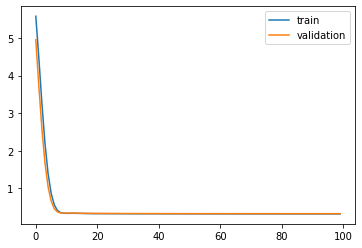

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 5.5792 - acc: 0.6378 - val_loss: 4.9559 - val_acc: 0.8303

Epoch 00001: val_loss improved from inf to 4.95593, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4619 - acc: 0.8513 - val_loss: 3.7174 - val_acc: 0.8651

Epoch 00002: val_loss improved from 4.95593 to 3.71741, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2433 - acc: 0.8706 - val_loss: 2.5747 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.71741 to 2.57473, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.1838 - acc: 0.8739 - val_loss: 1.6674 - val_acc: 0.8741

Epoch 00004: val_loss improved from 2.57473 to 1.66737, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3872 - acc: 0.8751 - val_loss: 1.0409 - val_acc: 0.8746

Epoch 00005: val_loss improved from 1.66737 to 1.04094, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.8637 - acc: 0.8758 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32474 to 0.32466, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32466 to 0.32457, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32457 to 0.32449, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8774

Epoch 00050: val_loss improved from 0.32449 to 0.32442, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32442 to 0.32435, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8771

Epoch 00052: val_

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8770

Epoch 00096: val_loss did not improve from 0.32330
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00097: val_loss did not improve from 0.32330
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32330
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00099: val_loss did not improve from 0.32330
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8769

Epoch 00100: val_loss did not improve from 0.32330
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04409593527719614
Decay: 4.3799706705345337e-07
best val loss: 0.323295533657074
#################################


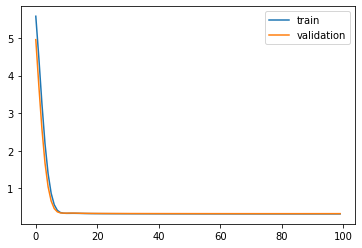

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 5.5785 - acc: 0.6384 - val_loss: 4.9639 - val_acc: 0.8178

Epoch 00001: val_loss improved from inf to 4.96386, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4616 - acc: 0.8522 - val_loss: 3.7254 - val_acc: 0.8612

Epoch 00002: val_loss improved from 4.96386 to 3.72536, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2427 - acc: 0.8712 - val_loss: 2.5840 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.72536 to 2.58403, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.1830 - acc: 0.8745 - val_loss: 1.6759 - val_acc: 0.8674

Epoch 00004: val_loss improved from 2.58403 to 1.67585, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3865 - acc: 0.8758 - val_loss: 1.0484 - val_acc: 0.8688

Epoch 00005: val_loss improved from 1.67585 to 1.04837, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8628 - acc: 0.8766 - 

 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.32947 to 0.32939, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32939 to 0.32931, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8711

Epoch 00049: val_loss improved from 0.32931 to 0.32923, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.32923 to 0.32916, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32916 to 0.32908, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00052: val_


Epoch 00095: val_loss did not improve from 0.32810
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00096: val_loss did not improve from 0.32810
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3285 - val_acc: 0.8709

Epoch 00097: val_loss did not improve from 0.32810
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00098: val_loss did not improve from 0.32810
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32810
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3286 - val_acc: 0.8710

Epoch 00100: val_loss did not improve from 0.32810
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04409593527719614
Decay: 4.3799706705345337e-07
best val loss: 0.3280960023403168
#################################


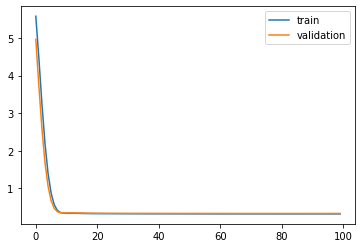

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 5.5792 - acc: 0.6375 - val_loss: 4.9558 - val_acc: 0.8308

Epoch 00001: val_loss improved from inf to 4.95576, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4633 - acc: 0.8508 - val_loss: 3.7072 - val_acc: 0.8700

Epoch 00002: val_loss improved from 4.95576 to 3.70721, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2448 - acc: 0.8700 - val_loss: 2.5605 - val_acc: 0.8742

Epoch 00003: val_loss improved from 3.70721 to 2.56051, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.1847 - acc: 0.8735 - val_loss: 1.6514 - val_acc: 0.8776

Epoch 00004: val_loss improved from 2.56051 to 1.65138, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3879 - acc: 0.8748 - val_loss: 1.0261 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.65138 to 1.02611, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.8639 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32003 to 0.31994, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3198 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.31994 to 0.31985, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.31985 to 0.31976, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8791

Epoch 00049: val_loss improved from 0.31976 to 0.31968, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31968 to 0.31960, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31960 to 0.31953, saving model to Event_val_weights

 - 1s - loss: 0.3172 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00093: val_loss improved from 0.31806 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00094: val_loss did not improve from 0.31803
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss did not improve from 0.31803
Epoch 96/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31803 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00097: val_loss did not improve from 0.31802
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8792

Epoch 00098: val_loss did not improve from 0.31802
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00099: va

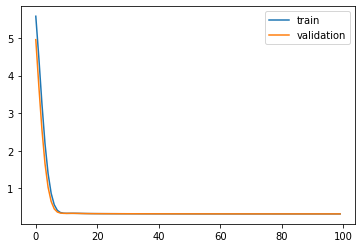

Time to train LSTM:  80.5428478717804
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 5.6185 - acc: 0.6231 - val_loss: 5.0748 - val_acc: 0.8134

Epoch 00001: val_loss improved from inf to 5.07479, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6347 - acc: 0.8437 - val_loss: 3.9506 - val_acc: 0.8719

Epoch 00002: val_loss improved from 5.07479 to 3.95064, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5349 - acc: 0.8679 - val_loss: 2.8968 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.95064 to 2.89680, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.5447 - acc: 0.8726 - val_loss: 2.0145 - val_acc: 0.8763

Epoch 00004: val_loss improved from 2.89680 to 2.01453, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.7487 - acc: 0.8742 - val_loss: 1.3529 - val_acc: 0.8777

Epoch 00005: val_loss improved from 2.01453 to 1.35292, saving model to Event_val_weights1.hdf5
Epoch 6/100

 - 1s - loss: 0.3206 - acc: 0.8783 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31503 to 0.31493, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31493 to 0.31485, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31485 to 0.31476, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31476 to 0.31468, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31468 to 0.31460, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31271 to 0.31268, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8803

Epoch 00092: val_loss improved from 0.31268 to 0.31266, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00093: val_loss improved from 0.31266 to 0.31263, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00094: val_loss improved from 0.31263 to 0.31260, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31260 to 0.31257, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3125 - val_acc: 0.8801

Epoch 00096: val_loss improved from 0.31257 to 0.31255, saving model to Event_val_weights

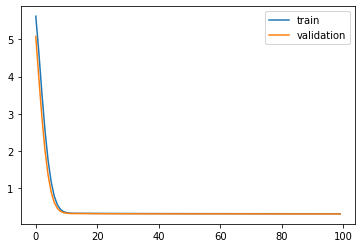

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 5.6191 - acc: 0.6222 - val_loss: 5.0733 - val_acc: 0.8163

Epoch 00001: val_loss improved from inf to 5.07330, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6337 - acc: 0.8448 - val_loss: 3.9609 - val_acc: 0.8627

Epoch 00002: val_loss improved from 5.07330 to 3.96088, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5333 - acc: 0.8687 - val_loss: 2.9131 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.96088 to 2.91309, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.5431 - acc: 0.8729 - val_loss: 2.0329 - val_acc: 0.8720

Epoch 00004: val_loss improved from 2.91309 to 2.03293, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.7473 - acc: 0.8747 - val_loss: 1.3715 - val_acc: 0.8739

Epoch 00005: val_loss improved from 2.03293 to 1.37153, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.1710 - acc: 0.8757 - 

 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3253 - val_acc: 0.8771

Epoch 00046: val_loss improved from 0.32540 to 0.32530, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32530 to 0.32520, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32520 to 0.32510, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32510 to 0.32501, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32501 to 0.32492, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8793 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00094: val_loss improved from 0.32312 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00095: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00096: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights

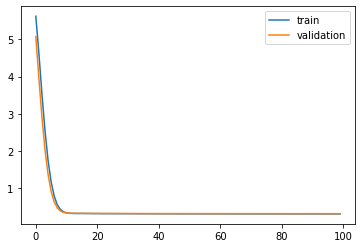

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7feabcc5a550>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 5.6192 - acc: 0.6230 - val_loss: 5.0750 - val_acc: 0.8161

Epoch 00001: val_loss improved from inf to 5.07501, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6340 - acc: 0.8438 - val_loss: 3.9646 - val_acc: 0.8632

Epoch 00002: val_loss improved from 5.07501 to 3.96459, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5334 - acc: 0.8689 - val_loss: 2.9168 - val_acc: 0.8700

Epoch 00003: val_loss improved from 3.96459 to 2.91676, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.5431 - acc: 0.8730 - val_loss: 2.0367 - val_acc: 0.8726

Epoch 00004: val_loss improved from 2.91676 to 2.03671, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.7472 - acc: 0.8748 - val_loss: 1.3749 - val_acc: 0.8747

Epoch 00005: val_loss improved from 2.03671 to 1.37494, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.1708 - acc: 0.8755 - 

 - 1s - loss: 0.3194 - acc: 0.8789 - val_loss: 0.3254 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32546 to 0.32536, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32536 to 0.32527, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32527 to 0.32517, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00049: val_loss improved from 0.32517 to 0.32509, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32509 to 0.32500, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32319 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00092: val_loss improved from 0.32317 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00093: val_loss improved from 0.32316 to 0.32314, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00094: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00095: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00096: val_loss improved from 0.32312 to 0.32311, saving model to Event_val_weights

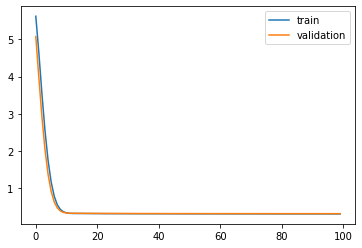

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 5.6185 - acc: 0.6234 - val_loss: 5.0832 - val_acc: 0.8057

Epoch 00001: val_loss improved from inf to 5.08318, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6336 - acc: 0.8443 - val_loss: 3.9721 - val_acc: 0.8588

Epoch 00002: val_loss improved from 5.08318 to 3.97208, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5329 - acc: 0.8694 - val_loss: 2.9259 - val_acc: 0.8651

Epoch 00003: val_loss improved from 3.97208 to 2.92593, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.5423 - acc: 0.8737 - val_loss: 2.0457 - val_acc: 0.8666

Epoch 00004: val_loss improved from 2.92593 to 2.04567, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.7464 - acc: 0.8755 - val_loss: 1.3831 - val_acc: 0.8678

Epoch 00005: val_loss improved from 2.04567 to 1.38308, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.1700 - acc: 0.8762 - 

 - 1s - loss: 0.3189 - acc: 0.8797 - val_loss: 0.3301 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33020 to 0.33010, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8711

Epoch 00047: val_loss improved from 0.33010 to 0.33001, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3299 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.33001 to 0.32992, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32992 to 0.32983, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32983 to 0.32975, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8798 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32805 to 0.32804, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00092: val_loss improved from 0.32804 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32802 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32800 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00096: val_loss improved from 0.32799 to 0.32798, saving model to Event_val_weights

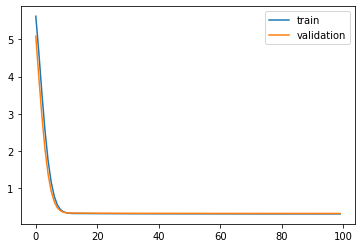

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 5.6191 - acc: 0.6221 - val_loss: 5.0761 - val_acc: 0.8160

Epoch 00001: val_loss improved from inf to 5.07615, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6352 - acc: 0.8428 - val_loss: 3.9558 - val_acc: 0.8681

Epoch 00002: val_loss improved from 5.07615 to 3.95584, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5349 - acc: 0.8685 - val_loss: 2.9038 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.95584 to 2.90375, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.5442 - acc: 0.8728 - val_loss: 2.0217 - val_acc: 0.8759

Epoch 00004: val_loss improved from 2.90375 to 2.02170, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.7480 - acc: 0.8744 - val_loss: 1.3601 - val_acc: 0.8771

Epoch 00005: val_loss improved from 2.02170 to 1.36005, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.1713 - acc: 0.8752 - 

 - 1s - loss: 0.3199 - acc: 0.8785 - val_loss: 0.3206 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32067 to 0.32057, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32057 to 0.32048, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.32048 to 0.32039, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32039 to 0.32030, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.32030 to 0.32022, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31828 to 0.31826, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31826 to 0.31823, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31823 to 0.31821, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31821 to 0.31819, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31819 to 0.31817, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31817 to 0.31815, saving model to Event_val_weights

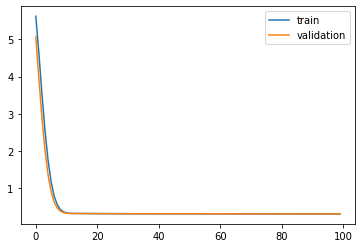

Time to train LSTM:  83.34775829315186
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 5.6047 - acc: 0.6288 - val_loss: 5.0326 - val_acc: 0.8207

Epoch 00001: val_loss improved from inf to 5.03261, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5745 - acc: 0.8467 - val_loss: 3.8632 - val_acc: 0.8718

Epoch 00002: val_loss improved from 5.03261 to 3.86317, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.4327 - acc: 0.8688 - val_loss: 2.7748 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.86317 to 2.77478, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.4160 - acc: 0.8730 - val_loss: 1.8800 - val_acc: 0.8763

Epoch 00004: val_loss improved from 2.77478 to 1.87999, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.6165 - acc: 0.8744 - val_loss: 1.2278 - val_acc: 0.8771

Epoch 00005: val_loss improved from 1.87999 to 1.22777, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00046: val_loss improved from 0.31481 to 0.31472, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3202 - acc: 0.8783 - val_loss: 0.3146 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31472 to 0.31463, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00048: val_loss improved from 0.31463 to 0.31455, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31455 to 0.31447, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31447 to 0.31439, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31254 to 0.31251, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31251 to 0.31249, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3125 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31249 to 0.31246, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31246 to 0.31243, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31243 to 0.31240, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31240 to 0.31238, saving model to Event_val_weights

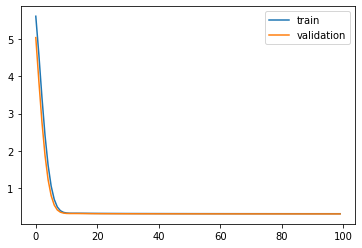

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 5.6052 - acc: 0.6277 - val_loss: 5.0316 - val_acc: 0.8218

Epoch 00001: val_loss improved from inf to 5.03162, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5735 - acc: 0.8475 - val_loss: 3.8741 - val_acc: 0.8641

Epoch 00002: val_loss improved from 5.03162 to 3.87414, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.4311 - acc: 0.8695 - val_loss: 2.7916 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.87414 to 2.79158, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.4144 - acc: 0.8734 - val_loss: 1.8987 - val_acc: 0.8727

Epoch 00004: val_loss improved from 2.79158 to 1.89873, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.6151 - acc: 0.8749 - val_loss: 1.2465 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.89873 to 1.24654, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0543 - acc: 0.8759 - 

 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32505 to 0.32495, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32495 to 0.32486, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32486 to 0.32477, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32477 to 0.32469, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3246 - val_acc: 0.8770

Epoch 00051: val_loss improved from 0.32469 to 0.32461, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8760

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8759

Epoch 00095: val_loss improved from 0.32307 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8758

Epoch 00096: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss improved from 0.32306 to 0.32306, saving model to Event_val_weights

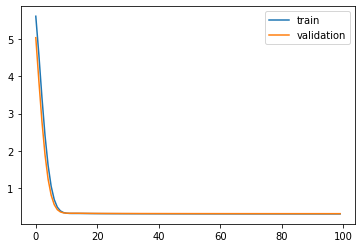

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 5.6053 - acc: 0.6283 - val_loss: 5.0335 - val_acc: 0.8208

Epoch 00001: val_loss improved from inf to 5.03346, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5738 - acc: 0.8465 - val_loss: 3.8779 - val_acc: 0.8639

Epoch 00002: val_loss improved from 5.03346 to 3.87789, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.4312 - acc: 0.8695 - val_loss: 2.7953 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.87789 to 2.79527, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.4144 - acc: 0.8732 - val_loss: 1.9026 - val_acc: 0.8734

Epoch 00004: val_loss improved from 2.79527 to 1.90258, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.6150 - acc: 0.8750 - val_loss: 1.2499 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.90258 to 1.24989, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0541 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32523 to 0.32513, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8790 - val_loss: 0.3250 - val_acc: 0.8779

Epoch 00047: val_loss improved from 0.32513 to 0.32504, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32504 to 0.32495, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32495 to 0.32486, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00050: val_loss improved from 0.32486 to 0.32478, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8774

Epoch 00051: val_loss improved from 0.32478 to 0.32470, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32315 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8770

Epoch 00094: val_loss improved from 0.32315 to 0.32315, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8770

Epoch 00095: val_loss did not improve from 0.32315
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8770

Epoch 00096: val_loss did not improve from 0.32315
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32315
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_lo

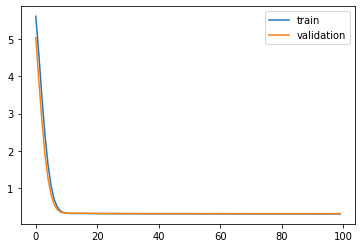

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 5.6046 - acc: 0.6291 - val_loss: 5.0416 - val_acc: 0.8102

Epoch 00001: val_loss improved from inf to 5.04155, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5734 - acc: 0.8473 - val_loss: 3.8855 - val_acc: 0.8597

Epoch 00002: val_loss improved from 5.04155 to 3.88552, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.4306 - acc: 0.8700 - val_loss: 2.8045 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.88552 to 2.80453, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.4136 - acc: 0.8738 - val_loss: 1.9114 - val_acc: 0.8667

Epoch 00004: val_loss improved from 2.80453 to 1.91139, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.6142 - acc: 0.8758 - val_loss: 1.2578 - val_acc: 0.8679

Epoch 00005: val_loss improved from 1.91139 to 1.25779, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0533 - acc: 0.8762 - 


Epoch 00046: val_loss improved from 0.32997 to 0.32987, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3185 - acc: 0.8797 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00047: val_loss improved from 0.32987 to 0.32978, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32978 to 0.32969, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00049: val_loss improved from 0.32969 to 0.32961, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32961 to 0.32953, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8717

Epoch 00051: val_loss improved from 0.32953 to 0.32945, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00092: val_loss improved from 0.32801 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00093: val_loss improved from 0.32800 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00094: val_loss improved from 0.32800 to 0.32800, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00095: val_loss did not improve from 0.32800
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss did not improve from 0.32800
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00097: val_loss did not improve from 0.32800
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8802 - val_lo

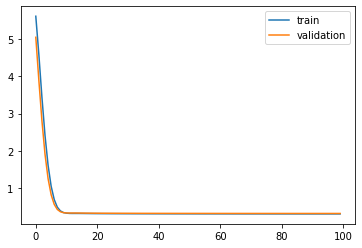

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 5.6053 - acc: 0.6279 - val_loss: 5.0341 - val_acc: 0.8214

Epoch 00001: val_loss improved from inf to 5.03414, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5750 - acc: 0.8460 - val_loss: 3.8686 - val_acc: 0.8688

Epoch 00002: val_loss improved from 5.03414 to 3.86860, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.4327 - acc: 0.8689 - val_loss: 2.7818 - val_acc: 0.8736

Epoch 00003: val_loss improved from 3.86860 to 2.78185, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.4154 - acc: 0.8729 - val_loss: 1.8872 - val_acc: 0.8768

Epoch 00004: val_loss improved from 2.78185 to 1.88719, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.6157 - acc: 0.8747 - val_loss: 1.2350 - val_acc: 0.8769

Epoch 00005: val_loss improved from 1.88719 to 1.23495, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0545 - acc: 0.8754 - 


Epoch 00046: val_loss improved from 0.32044 to 0.32034, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32034 to 0.32025, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32025 to 0.32016, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32016 to 0.32007, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.32007 to 0.31999, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.31999 to 0.31991, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8791

Epoch 00092: val_loss did not improve from 0.31814
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8792

Epoch 00093: val_loss improved from 0.31814 to 0.31807, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00094: val_loss did not improve from 0.31807
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31807 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31805 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31803
Epoch 98/100
 - 1s - loss: 0.3170 - acc: 0.8790 - val_lo

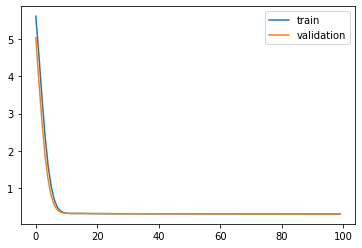

Time to train LSTM:  83.15617871284485
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.5774 - acc: 0.6394 - val_loss: 4.9503 - val_acc: 0.8298

Epoch 00001: val_loss improved from inf to 4.95025, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4575 - acc: 0.8513 - val_loss: 3.6939 - val_acc: 0.8729

Epoch 00002: val_loss improved from 4.95025 to 3.69392, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2362 - acc: 0.8699 - val_loss: 2.5432 - val_acc: 0.8759

Epoch 00003: val_loss improved from 3.69392 to 2.54322, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.1749 - acc: 0.8732 - val_loss: 1.6336 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.54322 to 1.63365, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3787 - acc: 0.8748 - val_loss: 1.0099 - val_acc: 0.8780

Epoch 00005: val_loss improved from 1.63365 to 1.00988, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31440 to 0.31432, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31432 to 0.31423, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31423 to 0.31415, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31415 to 0.31408, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31408 to 0.31400, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3139 - val_acc: 0.8803

Epoch 00051: val_loss improved from 0.31400 to 0.31393, saving model to Event_val_weights

 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31220 to 0.31218, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8792 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31218 to 0.31216, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31216 to 0.31214, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31214 to 0.31212, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00096: val_loss improved from 0.31212 to 0.31210, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

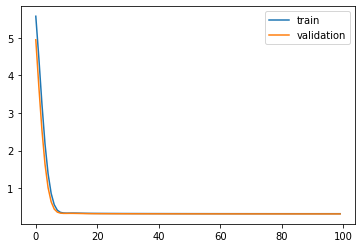

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.5778 - acc: 0.6382 - val_loss: 4.9502 - val_acc: 0.8286

Epoch 00001: val_loss improved from inf to 4.95024, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4564 - acc: 0.8524 - val_loss: 3.7062 - val_acc: 0.8660

Epoch 00002: val_loss improved from 4.95024 to 3.70621, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2346 - acc: 0.8705 - val_loss: 2.5609 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.70621 to 2.56091, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.1734 - acc: 0.8737 - val_loss: 1.6530 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.56091 to 1.65297, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3774 - acc: 0.8753 - val_loss: 1.0289 - val_acc: 0.8738

Epoch 00005: val_loss improved from 1.65297 to 1.02887, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.8559 - acc: 0.8762 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00047: val_loss improved from 0.32462 to 0.32453, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32453 to 0.32444, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32444 to 0.32436, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32436 to 0.32429, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32429 to 0.32421, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3241 - val_acc: 0.8770

Epoch 00052: val_


Epoch 00094: val_loss did not improve from 0.32315
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00095: val_loss did not improve from 0.32315
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00096: val_loss did not improve from 0.32315
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00097: val_loss did not improve from 0.32315
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00098: val_loss did not improve from 0.32315
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32315
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00100: val_loss did not improve from 0.32315
#################################
Number of units: 16
Batch size: 16384
Fold: 1
L2 : 0.05441600579314996
LR: 0.04431206019689

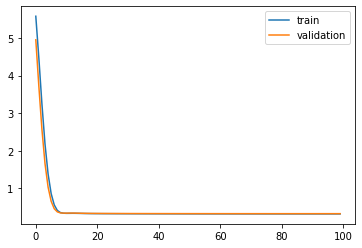

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.5779 - acc: 0.6383 - val_loss: 4.9523 - val_acc: 0.8306

Epoch 00001: val_loss improved from inf to 4.95234, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4567 - acc: 0.8515 - val_loss: 3.7100 - val_acc: 0.8652

Epoch 00002: val_loss improved from 4.95234 to 3.71000, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2347 - acc: 0.8706 - val_loss: 2.5647 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.71000 to 2.56470, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.1734 - acc: 0.8739 - val_loss: 1.6569 - val_acc: 0.8741

Epoch 00004: val_loss improved from 2.56470 to 1.65695, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3773 - acc: 0.8751 - val_loss: 1.0320 - val_acc: 0.8746

Epoch 00005: val_loss improved from 1.65695 to 1.03200, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.8557 - acc: 0.8758 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32473 to 0.32464, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32464 to 0.32456, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8774

Epoch 00049: val_loss improved from 0.32456 to 0.32448, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32448 to 0.32440, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32440 to 0.32433, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00096: val_loss did not improve from 0.32330
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00097: val_loss did not improve from 0.32330
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00098: val_loss did not improve from 0.32330
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32330
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00100: val_loss did not improve from 0.32330
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04431206019689021
Decay: 7.743668466527487e-07
best val loss: 0.32330188155174255
#################################


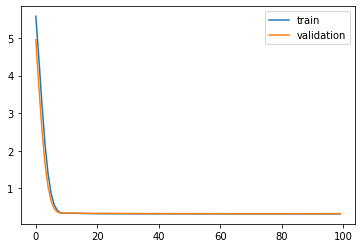

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.5773 - acc: 0.6388 - val_loss: 4.9603 - val_acc: 0.8182

Epoch 00001: val_loss improved from inf to 4.96025, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4564 - acc: 0.8524 - val_loss: 3.7180 - val_acc: 0.8611

Epoch 00002: val_loss improved from 4.96025 to 3.71797, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2341 - acc: 0.8713 - val_loss: 2.5740 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.71797 to 2.57399, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.1726 - acc: 0.8745 - val_loss: 1.6654 - val_acc: 0.8676

Epoch 00004: val_loss improved from 2.57399 to 1.66541, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3765 - acc: 0.8759 - val_loss: 1.0394 - val_acc: 0.8684

Epoch 00005: val_loss improved from 1.66541 to 1.03942, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8548 - acc: 0.8767 - 

 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.32946 to 0.32937, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32937 to 0.32929, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8711

Epoch 00049: val_loss improved from 0.32929 to 0.32921, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.32921 to 0.32914, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32914 to 0.32907, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00052: val_

 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00096: val_loss did not improve from 0.32810
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3285 - val_acc: 0.8709

Epoch 00097: val_loss did not improve from 0.32810
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32810
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3286 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32810
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3285 - val_acc: 0.8711

Epoch 00100: val_loss did not improve from 0.32810
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04431206019689021
Decay: 7.743668466527487e-07
best val loss: 0.32810071110725403
#################################


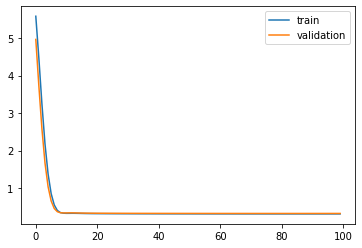

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.5780 - acc: 0.6379 - val_loss: 4.9521 - val_acc: 0.8308

Epoch 00001: val_loss improved from inf to 4.95212, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4582 - acc: 0.8511 - val_loss: 3.6998 - val_acc: 0.8701

Epoch 00002: val_loss improved from 4.95212 to 3.69976, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2361 - acc: 0.8700 - val_loss: 2.5504 - val_acc: 0.8742

Epoch 00003: val_loss improved from 3.69976 to 2.55044, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.1743 - acc: 0.8735 - val_loss: 1.6409 - val_acc: 0.8776

Epoch 00004: val_loss improved from 2.55044 to 1.64093, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3779 - acc: 0.8749 - val_loss: 1.0172 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.64093 to 1.01719, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.8559 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32001 to 0.31992, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3198 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.31992 to 0.31983, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3197 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.31983 to 0.31975, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8792

Epoch 00049: val_loss improved from 0.31975 to 0.31966, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31966 to 0.31959, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31959 to 0.31951, saving model to Event_val_weights

 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00093: val_loss did not improve from 0.31805
Epoch 94/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00094: val_loss did not improve from 0.31805
Epoch 95/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00095: val_loss did not improve from 0.31805
Epoch 96/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00096: val_loss did not improve from 0.31805
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00097: val_loss improved from 0.31805 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00098: val_loss did not improve from 0.31802
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00099: val_loss did not improve from 0.31802
Epoch 100

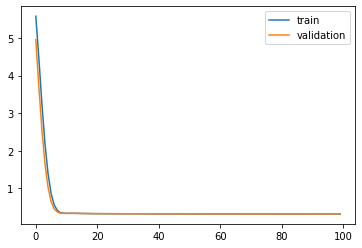

Time to train LSTM:  84.06370186805725
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.6295 - acc: 0.6188 - val_loss: 5.1087 - val_acc: 0.8098

Epoch 00001: val_loss improved from inf to 5.10866, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6832 - acc: 0.8412 - val_loss: 4.0213 - val_acc: 0.8709

Epoch 00002: val_loss improved from 5.10866 to 4.02130, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.6177 - acc: 0.8675 - val_loss: 2.9964 - val_acc: 0.8761

Epoch 00003: val_loss improved from 4.02130 to 2.99640, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.6505 - acc: 0.8724 - val_loss: 2.1266 - val_acc: 0.8761

Epoch 00004: val_loss improved from 2.99640 to 2.12658, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.8600 - acc: 0.8740 - val_loss: 1.4601 - val_acc: 0.8776

Epoch 00005: val_loss improved from 2.12658 to 1.46014, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3208 - acc: 0.8783 - val_loss: 0.3151 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31521 to 0.31512, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3207 - acc: 0.8783 - val_loss: 0.3150 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31512 to 0.31503, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3206 - acc: 0.8783 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00048: val_loss improved from 0.31503 to 0.31494, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00049: val_loss improved from 0.31494 to 0.31486, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31486 to 0.31478, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31285 to 0.31283, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00092: val_loss improved from 0.31283 to 0.31280, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3178 - acc: 0.8790 - val_loss: 0.3128 - val_acc: 0.8803

Epoch 00093: val_loss improved from 0.31280 to 0.31277, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31277 to 0.31274, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31274 to 0.31271, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3127 - val_acc: 0.8802

Epoch 00096: val_loss improved from 0.31271 to 0.31269, saving model to Event_val_weights

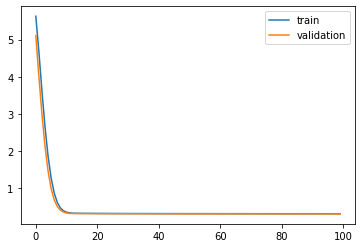

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 5.6301 - acc: 0.6177 - val_loss: 5.1068 - val_acc: 0.8134

Epoch 00001: val_loss improved from inf to 5.10677, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6823 - acc: 0.8417 - val_loss: 4.0309 - val_acc: 0.8624

Epoch 00002: val_loss improved from 5.10677 to 4.03091, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.6162 - acc: 0.8681 - val_loss: 3.0122 - val_acc: 0.8702

Epoch 00003: val_loss improved from 4.03091 to 3.01223, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.6489 - acc: 0.8726 - val_loss: 2.1447 - val_acc: 0.8720

Epoch 00004: val_loss improved from 3.01223 to 2.14468, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.8586 - acc: 0.8745 - val_loss: 1.4786 - val_acc: 0.8739

Epoch 00005: val_loss improved from 2.14468 to 1.47860, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.2723 - acc: 0.8756 - 

 - 1s - loss: 0.3196 - acc: 0.8788 - val_loss: 0.3255 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32561 to 0.32551, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3254 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32551 to 0.32540, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32540 to 0.32531, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8769

Epoch 00049: val_loss improved from 0.32531 to 0.32521, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8769

Epoch 00050: val_loss improved from 0.32521 to 0.32512, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8769

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32324 to 0.32322, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3167 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00092: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00093: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00094: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00095: val_loss improved from 0.32316 to 0.32315, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8766

Epoch 00096: val_loss improved from 0.32315 to 0.32313, saving model to Event_val_weights

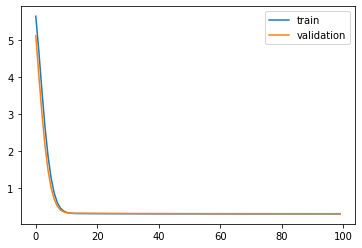

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 5.6302 - acc: 0.6180 - val_loss: 5.1084 - val_acc: 0.8129

Epoch 00001: val_loss improved from inf to 5.10837, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6825 - acc: 0.8407 - val_loss: 4.0346 - val_acc: 0.8628

Epoch 00002: val_loss improved from 5.10837 to 4.03458, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.6162 - acc: 0.8682 - val_loss: 3.0159 - val_acc: 0.8697

Epoch 00003: val_loss improved from 4.03458 to 3.01591, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.6490 - acc: 0.8728 - val_loss: 2.1484 - val_acc: 0.8717

Epoch 00004: val_loss improved from 3.01591 to 2.14841, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.8585 - acc: 0.8746 - val_loss: 1.4820 - val_acc: 0.8748

Epoch 00005: val_loss improved from 2.14841 to 1.48204, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.2722 - acc: 0.8754 - 

 - 1s - loss: 0.3196 - acc: 0.8790 - val_loss: 0.3256 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32565 to 0.32555, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8790 - val_loss: 0.3255 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32555 to 0.32546, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3194 - acc: 0.8789 - val_loss: 0.3254 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32546 to 0.32536, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00049: val_loss improved from 0.32536 to 0.32528, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32528 to 0.32519, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3251 - val_acc: 0.8778

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32326 to 0.32324, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3167 - acc: 0.8793 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00092: val_loss improved from 0.32324 to 0.32322, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8764

Epoch 00093: val_loss improved from 0.32322 to 0.32320, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8766

Epoch 00094: val_loss improved from 0.32320 to 0.32318, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00095: val_loss improved from 0.32318 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00096: val_loss improved from 0.32316 to 0.32314, saving model to Event_val_weights

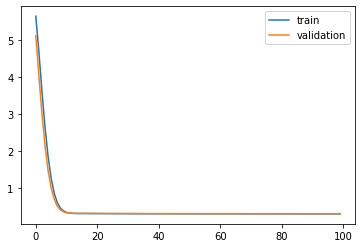

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 5.6295 - acc: 0.6186 - val_loss: 5.1166 - val_acc: 0.8007

Epoch 00001: val_loss improved from inf to 5.11660, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6821 - acc: 0.8414 - val_loss: 4.0420 - val_acc: 0.8574

Epoch 00002: val_loss improved from 5.11660 to 4.04198, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.6157 - acc: 0.8688 - val_loss: 3.0250 - val_acc: 0.8648

Epoch 00003: val_loss improved from 4.04198 to 3.02497, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.6481 - acc: 0.8735 - val_loss: 2.1575 - val_acc: 0.8669

Epoch 00004: val_loss improved from 3.02497 to 2.15747, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.8577 - acc: 0.8752 - val_loss: 1.4904 - val_acc: 0.8677

Epoch 00005: val_loss improved from 2.15747 to 1.49035, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.2714 - acc: 0.8762 - 

 - 1s - loss: 0.3191 - acc: 0.8796 - val_loss: 0.3303 - val_acc: 0.8711

Epoch 00046: val_loss improved from 0.33040 to 0.33030, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.3302 - val_acc: 0.8711

Epoch 00047: val_loss improved from 0.33030 to 0.33020, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3189 - acc: 0.8796 - val_loss: 0.3301 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.33020 to 0.33011, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.33011 to 0.33002, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3187 - acc: 0.8796 - val_loss: 0.3299 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.33002 to 0.32994, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8713

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32812 to 0.32810, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3161 - acc: 0.8800 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00092: val_loss improved from 0.32810 to 0.32808, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3161 - acc: 0.8800 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00093: val_loss improved from 0.32808 to 0.32807, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3161 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32807 to 0.32805, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32805 to 0.32803, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00096: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights

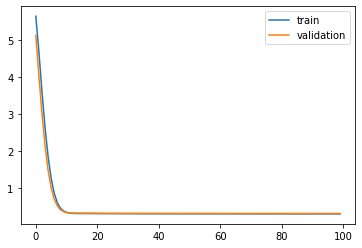

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 5.6300 - acc: 0.6172 - val_loss: 5.1099 - val_acc: 0.8101

Epoch 00001: val_loss improved from inf to 5.10987, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6837 - acc: 0.8402 - val_loss: 4.0263 - val_acc: 0.8674

Epoch 00002: val_loss improved from 5.10987 to 4.02631, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.6177 - acc: 0.8677 - val_loss: 3.0032 - val_acc: 0.8733

Epoch 00003: val_loss improved from 4.02631 to 3.00324, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.6500 - acc: 0.8727 - val_loss: 2.1337 - val_acc: 0.8756

Epoch 00004: val_loss improved from 3.00324 to 2.13374, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.8593 - acc: 0.8743 - val_loss: 1.4672 - val_acc: 0.8773

Epoch 00005: val_loss improved from 2.13374 to 1.46723, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.2727 - acc: 0.8751 - 

 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3208 - val_acc: 0.8792

Epoch 00046: val_loss improved from 0.32086 to 0.32076, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3207 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32076 to 0.32067, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3206 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32067 to 0.32058, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32058 to 0.32049, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.32049 to 0.32040, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8786 - val_loss: 0.3203 - val_acc: 0.8791

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31839 to 0.31837, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31837 to 0.31834, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31834 to 0.31832, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31832 to 0.31829, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3183 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31829 to 0.31827, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31827 to 0.31824, saving model to Event_val_weights

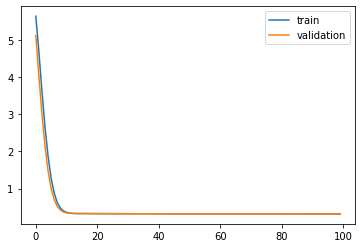

Time to train LSTM:  85.74010443687439
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5962 - acc: 0.6325 - val_loss: 5.0068 - val_acc: 0.8244

Epoch 00001: val_loss improved from inf to 5.00678, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5377 - acc: 0.8485 - val_loss: 3.8099 - val_acc: 0.8717

Epoch 00002: val_loss improved from 5.00678 to 3.80987, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.3707 - acc: 0.8693 - val_loss: 2.7012 - val_acc: 0.8760

Epoch 00003: val_loss improved from 3.80987 to 2.70118, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.3389 - acc: 0.8731 - val_loss: 1.8004 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.70118 to 1.80037, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5390 - acc: 0.8746 - val_loss: 1.1557 - val_acc: 0.8777

Epoch 00005: val_loss improved from 1.80037 to 1.15568, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31468 to 0.31459, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31459 to 0.31450, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31450 to 0.31442, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3198 - acc: 0.8784 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31442 to 0.31434, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8806

Epoch 00050: val_loss improved from 0.31434 to 0.31426, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31426 to 0.31419, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00092: val_loss improved from 0.31241 to 0.31238, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00093: val_loss improved from 0.31238 to 0.31236, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8803

Epoch 00094: val_loss improved from 0.31236 to 0.31233, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31233 to 0.31230, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31230 to 0.31228, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00097: val_

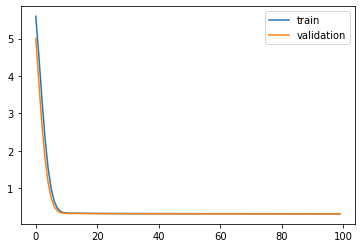

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 5.5967 - acc: 0.6311 - val_loss: 5.0061 - val_acc: 0.8241

Epoch 00001: val_loss improved from inf to 5.00609, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5367 - acc: 0.8492 - val_loss: 3.8213 - val_acc: 0.8649

Epoch 00002: val_loss improved from 5.00609 to 3.82127, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.3690 - acc: 0.8701 - val_loss: 2.7183 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.82127 to 2.71828, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.3373 - acc: 0.8736 - val_loss: 1.8193 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.71828 to 1.81932, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5377 - acc: 0.8750 - val_loss: 1.1745 - val_acc: 0.8732

Epoch 00005: val_loss improved from 1.81932 to 1.17454, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.9879 - acc: 0.8760 - 


Epoch 00046: val_loss improved from 0.32501 to 0.32491, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32491 to 0.32481, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00048: val_loss improved from 0.32481 to 0.32472, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32472 to 0.32464, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8771

Epoch 00050: val_loss improved from 0.32464 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00051: val_loss improved from 0.32455 to 0.32448, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00094: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss did not improve from 0.32308
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00096: val_loss did not improve from 0.32308
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00097: val_loss did not improve from 0.32308
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_lo

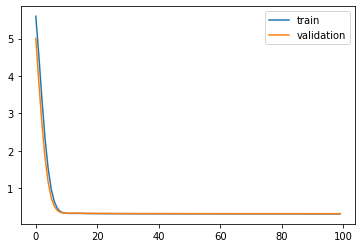

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fea08829908>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5968 - acc: 0.6314 - val_loss: 5.0080 - val_acc: 0.8252

Epoch 00001: val_loss improved from inf to 5.00801, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5370 - acc: 0.8482 - val_loss: 3.8250 - val_acc: 0.8646

Epoch 00002: val_loss improved from 5.00801 to 3.82503, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.3691 - acc: 0.8700 - val_loss: 2.7220 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.82503 to 2.72199, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.3373 - acc: 0.8735 - val_loss: 1.8232 - val_acc: 0.8739

Epoch 00004: val_loss improved from 2.72199 to 1.82320, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5375 - acc: 0.8750 - val_loss: 1.1778 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.82320 to 1.17783, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.9877 - acc: 0.8759 - 

 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32500 to 0.32491, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32491 to 0.32482, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3247 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32482 to 0.32474, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00050: val_loss improved from 0.32474 to 0.32466, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32466 to 0.32458, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00052: val_

 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00093: val_loss did not improve from 0.32320
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00094: val_loss did not improve from 0.32320
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00095: val_loss did not improve from 0.32320
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8768

Epoch 00096: val_loss did not improve from 0.32320
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8768

Epoch 00097: val_loss did not improve from 0.32320
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8767

Epoch 00098: val_loss did not improve from 0.32320
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8767

Epoch 00099: val_loss did not improve from 0.32320
Epoch 100/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val

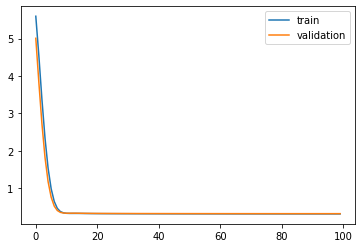

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5961 - acc: 0.6322 - val_loss: 5.0161 - val_acc: 0.8129

Epoch 00001: val_loss improved from inf to 5.01605, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5367 - acc: 0.8490 - val_loss: 3.8328 - val_acc: 0.8603

Epoch 00002: val_loss improved from 5.01605 to 3.83277, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.3685 - acc: 0.8706 - val_loss: 2.7313 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.83277 to 2.73128, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.3365 - acc: 0.8741 - val_loss: 1.8319 - val_acc: 0.8670

Epoch 00004: val_loss improved from 2.73128 to 1.83191, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5367 - acc: 0.8758 - val_loss: 1.1856 - val_acc: 0.8683

Epoch 00005: val_loss improved from 1.83191 to 1.18558, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.9869 - acc: 0.8764 - 

 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32974 to 0.32965, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32965 to 0.32956, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8713

Epoch 00049: val_loss improved from 0.32956 to 0.32948, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8713

Epoch 00050: val_loss improved from 0.32948 to 0.32940, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32940 to 0.32932, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00052: val_


Epoch 00092: val_loss did not improve from 0.32803
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00093: val_loss did not improve from 0.32803
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00094: val_loss did not improve from 0.32803
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8712

Epoch 00095: val_loss did not improve from 0.32803
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00096: val_loss did not improve from 0.32803
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00097: val_loss did not improve from 0.32803
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00098: val_loss did not improve from 0.32803
Epoch 99/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8716

Epoch 00099: val_loss did not improve fr

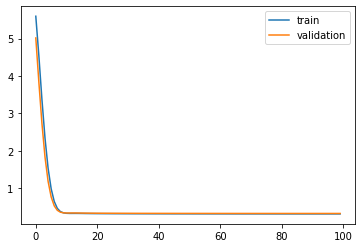

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5968 - acc: 0.6313 - val_loss: 5.0084 - val_acc: 0.8247

Epoch 00001: val_loss improved from inf to 5.00841, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5383 - acc: 0.8478 - val_loss: 3.8154 - val_acc: 0.8693

Epoch 00002: val_loss improved from 5.00841 to 3.81543, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.3706 - acc: 0.8694 - val_loss: 2.7083 - val_acc: 0.8740

Epoch 00003: val_loss improved from 3.81543 to 2.70831, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.3383 - acc: 0.8732 - val_loss: 1.8076 - val_acc: 0.8771

Epoch 00004: val_loss improved from 2.70831 to 1.80760, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5382 - acc: 0.8748 - val_loss: 1.1629 - val_acc: 0.8770

Epoch 00005: val_loss improved from 1.80760 to 1.16290, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.9881 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32030 to 0.32021, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3201 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32021 to 0.32011, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32011 to 0.32003, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32003 to 0.31994, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.31994 to 0.31986, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8792

Epoch 00051: val_loss improved from 0.31986 to 0.31978, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00092: val_loss did not improve from 0.31806
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00093: val_loss did not improve from 0.31806
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31806 to 0.31804, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00095: val_loss did not improve from 0.31804
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss improved from 0.31804 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31803
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00098: va

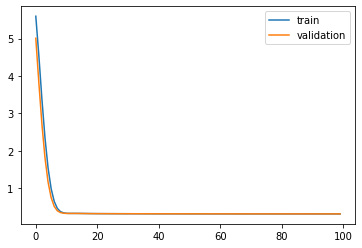

Time to train LSTM:  87.02417635917664
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5763 - acc: 0.6398 - val_loss: 4.9471 - val_acc: 0.8298

Epoch 00001: val_loss improved from inf to 4.94706, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4530 - acc: 0.8516 - val_loss: 3.6874 - val_acc: 0.8729

Epoch 00002: val_loss improved from 4.94706 to 3.68740, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2287 - acc: 0.8700 - val_loss: 2.5344 - val_acc: 0.8759

Epoch 00003: val_loss improved from 3.68740 to 2.53442, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.1658 - acc: 0.8733 - val_loss: 1.6245 - val_acc: 0.8768

Epoch 00004: val_loss improved from 2.53442 to 1.62453, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3700 - acc: 0.8749 - val_loss: 1.0021 - val_acc: 0.8781

Epoch 00005: val_loss improved from 1.62453 to 1.00212, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31439 to 0.31430, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31430 to 0.31422, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31422 to 0.31414, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8786 - val_loss: 0.3141 - val_acc: 0.8804

Epoch 00049: val_loss improved from 0.31414 to 0.31406, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8803

Epoch 00050: val_loss improved from 0.31406 to 0.31399, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3139 - val_acc: 0.8802

Epoch 00051: val_loss improved from 0.31399 to 0.31392, saving model to Event_val_weights

 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00092: val_loss improved from 0.31219 to 0.31217, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31217 to 0.31215, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31215 to 0.31213, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31213 to 0.31211, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00096: val_loss improved from 0.31211 to 0.31209, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3177 - acc: 0.8790 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

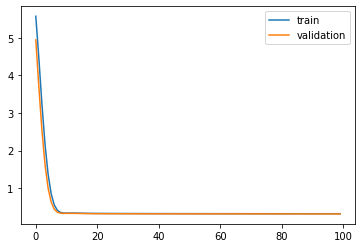

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5768 - acc: 0.6387 - val_loss: 4.9471 - val_acc: 0.8293

Epoch 00001: val_loss improved from inf to 4.94708, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4519 - acc: 0.8525 - val_loss: 3.6997 - val_acc: 0.8660

Epoch 00002: val_loss improved from 4.94708 to 3.69974, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2270 - acc: 0.8705 - val_loss: 2.5521 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.69974 to 2.55214, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.1643 - acc: 0.8737 - val_loss: 1.6439 - val_acc: 0.8731

Epoch 00004: val_loss improved from 2.55214 to 1.64387, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3688 - acc: 0.8753 - val_loss: 1.0211 - val_acc: 0.8738

Epoch 00005: val_loss improved from 1.64387 to 1.02112, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.8489 - acc: 0.8761 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00047: val_loss improved from 0.32460 to 0.32451, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32451 to 0.32443, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32443 to 0.32435, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32435 to 0.32427, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32427 to 0.32420, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3241 - val_acc: 0.8770

Epoch 00052: val_


Epoch 00094: val_loss did not improve from 0.32315
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00095: val_loss did not improve from 0.32315
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00096: val_loss did not improve from 0.32315
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00097: val_loss did not improve from 0.32315
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00098: val_loss did not improve from 0.32315
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32315
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00100: val_loss did not improve from 0.32315
#################################
Number of units: 16
Batch size: 16384
Fold: 1
L2 : 0.05441600579314996
LR: 0.04450129500413

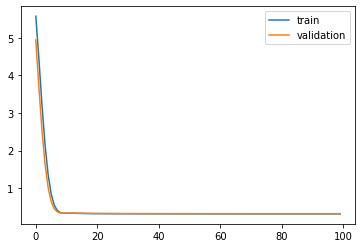

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5769 - acc: 0.6387 - val_loss: 4.9492 - val_acc: 0.8306

Epoch 00001: val_loss improved from inf to 4.94919, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4522 - acc: 0.8517 - val_loss: 3.7035 - val_acc: 0.8653

Epoch 00002: val_loss improved from 4.94919 to 3.70353, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2272 - acc: 0.8707 - val_loss: 2.5559 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.70353 to 2.55594, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.1643 - acc: 0.8740 - val_loss: 1.6479 - val_acc: 0.8742

Epoch 00004: val_loss improved from 2.55594 to 1.64785, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3686 - acc: 0.8751 - val_loss: 1.0242 - val_acc: 0.8747

Epoch 00005: val_loss improved from 1.64785 to 1.02424, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.8487 - acc: 0.8758 - 

 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32471 to 0.32463, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32463 to 0.32454, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8774

Epoch 00049: val_loss improved from 0.32454 to 0.32447, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00050: val_loss improved from 0.32447 to 0.32439, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32439 to 0.32432, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00096: val_loss did not improve from 0.32331
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00097: val_loss did not improve from 0.32331
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8796 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00098: val_loss did not improve from 0.32331
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8769

Epoch 00099: val_loss did not improve from 0.32331
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3239 - val_acc: 0.8769

Epoch 00100: val_loss did not improve from 0.32331
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04450129500413645
Decay: 5.767990184417392e-07
best val loss: 0.32330837845802307
#################################


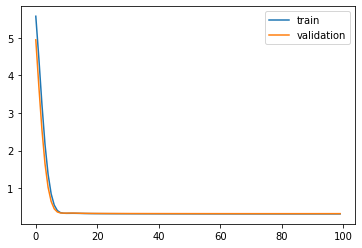

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 5.5763 - acc: 0.6392 - val_loss: 4.9571 - val_acc: 0.8186

Epoch 00001: val_loss improved from inf to 4.95710, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4519 - acc: 0.8527 - val_loss: 3.7115 - val_acc: 0.8614

Epoch 00002: val_loss improved from 4.95710 to 3.71150, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2265 - acc: 0.8714 - val_loss: 2.5652 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.71150 to 2.56523, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.1635 - acc: 0.8746 - val_loss: 1.6563 - val_acc: 0.8676

Epoch 00004: val_loss improved from 2.56523 to 1.65630, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3678 - acc: 0.8759 - val_loss: 1.0316 - val_acc: 0.8684

Epoch 00005: val_loss improved from 1.65630 to 1.03163, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8479 - acc: 0.8766 - 

 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.32944 to 0.32936, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8713

Epoch 00048: val_loss improved from 0.32936 to 0.32928, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00049: val_loss improved from 0.32928 to 0.32920, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3177 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00050: val_loss improved from 0.32920 to 0.32913, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32913 to 0.32906, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3175 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00052: val_

 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3285 - val_acc: 0.8709

Epoch 00096: val_loss did not improve from 0.32810
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00097: val_loss did not improve from 0.32810
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3286 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32810
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32810
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3287 - val_acc: 0.8711

Epoch 00100: val_loss did not improve from 0.32810
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04450129500413645
Decay: 5.767990184417392e-07
best val loss: 0.32810482382774353
#################################


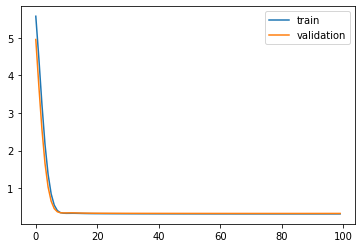

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 5.5769 - acc: 0.6383 - val_loss: 4.9489 - val_acc: 0.8313

Epoch 00001: val_loss improved from inf to 4.94894, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4536 - acc: 0.8514 - val_loss: 3.6933 - val_acc: 0.8702

Epoch 00002: val_loss improved from 4.94894 to 3.69325, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2286 - acc: 0.8701 - val_loss: 2.5416 - val_acc: 0.8744

Epoch 00003: val_loss improved from 3.69325 to 2.54164, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.1653 - acc: 0.8735 - val_loss: 1.6318 - val_acc: 0.8776

Epoch 00004: val_loss improved from 2.54164 to 1.63182, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3692 - acc: 0.8749 - val_loss: 1.0094 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.63182 to 1.00943, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.8490 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32000 to 0.31991, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3198 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.31991 to 0.31982, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3197 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.31982 to 0.31973, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00049: val_loss improved from 0.31973 to 0.31965, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31965 to 0.31957, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31957 to 0.31949, saving model to Event_val_weights


Epoch 00093: val_loss did not improve from 0.31805
Epoch 94/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00094: val_loss did not improve from 0.31805
Epoch 95/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31805 to 0.31805, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00096: val_loss did not improve from 0.31805
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00097: val_loss improved from 0.31805 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00098: val_loss did not improve from 0.31802
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00099: val_loss did not improve from 0.31802
Epoch 100/100
 - 1s - loss: 0.3173 -

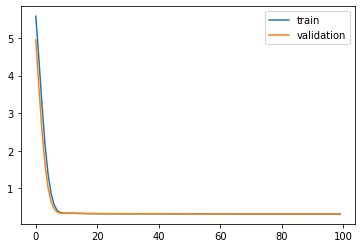

Time to train LSTM:  87.18643736839294
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 5.6175 - acc: 0.6236 - val_loss: 5.0718 - val_acc: 0.8139

Epoch 00001: val_loss improved from inf to 5.07178, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.6304 - acc: 0.8439 - val_loss: 3.9444 - val_acc: 0.8718

Epoch 00002: val_loss improved from 5.07178 to 3.94437, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.5276 - acc: 0.8680 - val_loss: 2.8880 - val_acc: 0.8763

Epoch 00003: val_loss improved from 3.94437 to 2.88800, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.5354 - acc: 0.8726 - val_loss: 2.0047 - val_acc: 0.8766

Epoch 00004: val_loss improved from 2.88800 to 2.00471, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.7390 - acc: 0.8741 - val_loss: 1.3437 - val_acc: 0.8777

Epoch 00005: val_loss improved from 2.00471 to 1.34365, saving model to Event_val_weights1.hdf5
Epoch 6/10

 - 1s - loss: 0.3205 - acc: 0.8783 - val_loss: 0.3149 - val_acc: 0.8808

Epoch 00046: val_loss improved from 0.31501 to 0.31492, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3204 - acc: 0.8784 - val_loss: 0.3148 - val_acc: 0.8808

Epoch 00047: val_loss improved from 0.31492 to 0.31483, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3203 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31483 to 0.31475, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3202 - acc: 0.8784 - val_loss: 0.3147 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31475 to 0.31466, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3201 - acc: 0.8784 - val_loss: 0.3146 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31466 to 0.31459, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31270 to 0.31267, saving model to Event_val_weights1.hdf5
Epoch 92/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00092: val_loss improved from 0.31267 to 0.31264, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00093: val_loss improved from 0.31264 to 0.31262, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00094: val_loss improved from 0.31262 to 0.31259, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3126 - val_acc: 0.8802

Epoch 00095: val_loss improved from 0.31259 to 0.31256, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3176 - acc: 0.8789 - val_loss: 0.3125 - val_acc: 0.8801

Epoch 00096: val_loss improved from 0.31256 to 0.31254, saving model to Event_val_weights

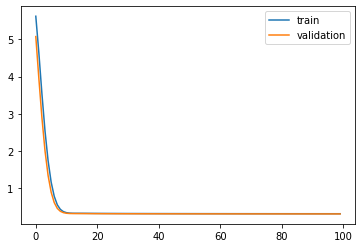

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 5.6181 - acc: 0.6229 - val_loss: 5.0703 - val_acc: 0.8170

Epoch 00001: val_loss improved from inf to 5.07032, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.6294 - acc: 0.8451 - val_loss: 3.9547 - val_acc: 0.8630

Epoch 00002: val_loss improved from 5.07032 to 3.95465, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.5260 - acc: 0.8688 - val_loss: 2.9043 - val_acc: 0.8708

Epoch 00003: val_loss improved from 3.95465 to 2.90432, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.5338 - acc: 0.8730 - val_loss: 2.0231 - val_acc: 0.8720

Epoch 00004: val_loss improved from 2.90432 to 2.02314, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.7376 - acc: 0.8747 - val_loss: 1.3623 - val_acc: 0.8740

Epoch 00005: val_loss improved from 2.02314 to 1.36228, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.1623 - acc: 0.8757 - 

 - 1s - loss: 0.3194 - acc: 0.8787 - val_loss: 0.3253 - val_acc: 0.8770

Epoch 00046: val_loss improved from 0.32538 to 0.32528, saving model to Event_val_weights2.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3252 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32528 to 0.32518, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3251 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32518 to 0.32508, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3250 - val_acc: 0.8770

Epoch 00049: val_loss improved from 0.32508 to 0.32499, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32499 to 0.32490, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32316 to 0.32314, saving model to Event_val_weights2.hdf5
Epoch 92/100
 - 1s - loss: 0.3166 - acc: 0.8793 - val_loss: 0.3231 - val_acc: 0.8763

Epoch 00092: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00093: val_loss improved from 0.32313 to 0.32311, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00094: val_loss improved from 0.32311 to 0.32310, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8762

Epoch 00095: val_loss improved from 0.32310 to 0.32309, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8761

Epoch 00096: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights

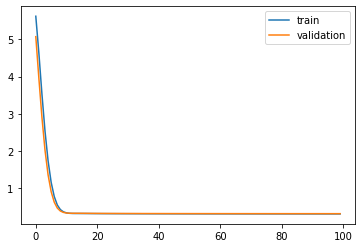

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 5.6182 - acc: 0.6232 - val_loss: 5.0720 - val_acc: 0.8167

Epoch 00001: val_loss improved from inf to 5.07204, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.6297 - acc: 0.8440 - val_loss: 3.9584 - val_acc: 0.8632

Epoch 00002: val_loss improved from 5.07204 to 3.95837, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.5261 - acc: 0.8690 - val_loss: 2.9080 - val_acc: 0.8702

Epoch 00003: val_loss improved from 3.95837 to 2.90799, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.5338 - acc: 0.8730 - val_loss: 2.0269 - val_acc: 0.8726

Epoch 00004: val_loss improved from 2.90799 to 2.02692, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.7375 - acc: 0.8748 - val_loss: 1.3657 - val_acc: 0.8747

Epoch 00005: val_loss improved from 2.02692 to 1.36568, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.1621 - acc: 0.8755 - 

 - 1s - loss: 0.3194 - acc: 0.8789 - val_loss: 0.3253 - val_acc: 0.8778

Epoch 00046: val_loss improved from 0.32544 to 0.32534, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3193 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00047: val_loss improved from 0.32534 to 0.32525, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3192 - acc: 0.8789 - val_loss: 0.3252 - val_acc: 0.8778

Epoch 00048: val_loss improved from 0.32525 to 0.32516, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3191 - acc: 0.8790 - val_loss: 0.3251 - val_acc: 0.8779

Epoch 00049: val_loss improved from 0.32516 to 0.32507, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3250 - val_acc: 0.8778

Epoch 00050: val_loss improved from 0.32507 to 0.32499, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3189 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8777

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32319 to 0.32317, saving model to Event_val_weights3.hdf5
Epoch 92/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00092: val_loss improved from 0.32317 to 0.32316, saving model to Event_val_weights3.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00093: val_loss improved from 0.32316 to 0.32314, saving model to Event_val_weights3.hdf5
Epoch 94/100
 - 1s - loss: 0.3165 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00094: val_loss improved from 0.32314 to 0.32313, saving model to Event_val_weights3.hdf5
Epoch 95/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8768

Epoch 00095: val_loss improved from 0.32313 to 0.32312, saving model to Event_val_weights3.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8794 - val_loss: 0.3231 - val_acc: 0.8769

Epoch 00096: val_loss improved from 0.32312 to 0.32311, saving model to Event_val_weights

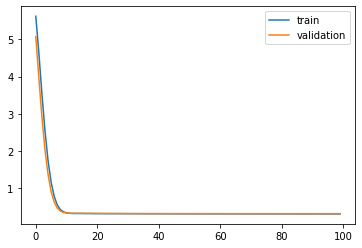

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 5.6175 - acc: 0.6238 - val_loss: 5.0802 - val_acc: 0.8063

Epoch 00001: val_loss improved from inf to 5.08020, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.6293 - acc: 0.8445 - val_loss: 3.9659 - val_acc: 0.8587

Epoch 00002: val_loss improved from 5.08020 to 3.96587, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.5255 - acc: 0.8694 - val_loss: 2.9172 - val_acc: 0.8651

Epoch 00003: val_loss improved from 3.96587 to 2.91717, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.5330 - acc: 0.8736 - val_loss: 2.0359 - val_acc: 0.8663

Epoch 00004: val_loss improved from 2.91717 to 2.03587, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.7367 - acc: 0.8755 - val_loss: 1.3738 - val_acc: 0.8678

Epoch 00005: val_loss improved from 2.03587 to 1.37381, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.1613 - acc: 0.8762 - 

 - 1s - loss: 0.3189 - acc: 0.8797 - val_loss: 0.3301 - val_acc: 0.8710

Epoch 00046: val_loss improved from 0.33018 to 0.33009, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3188 - acc: 0.8796 - val_loss: 0.3300 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.33009 to 0.32999, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3187 - acc: 0.8797 - val_loss: 0.3299 - val_acc: 0.8713

Epoch 00048: val_loss improved from 0.32999 to 0.32990, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3186 - acc: 0.8798 - val_loss: 0.3298 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32990 to 0.32982, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32982 to 0.32973, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3184 - acc: 0.8798 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.32805 to 0.32803, saving model to Event_val_weights4.hdf5
Epoch 92/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00092: val_loss improved from 0.32803 to 0.32802, saving model to Event_val_weights4.hdf5
Epoch 93/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00093: val_loss improved from 0.32802 to 0.32801, saving model to Event_val_weights4.hdf5
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00094: val_loss improved from 0.32801 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 95/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8713

Epoch 00095: val_loss improved from 0.32799 to 0.32799, saving model to Event_val_weights4.hdf5
Epoch 96/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00096: val_loss improved from 0.32799 to 0.32798, saving model to Event_val_weights

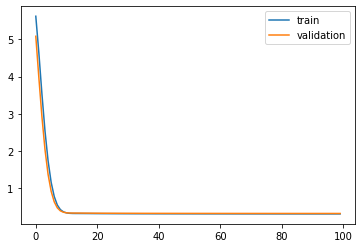

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 5.6181 - acc: 0.6225 - val_loss: 5.0731 - val_acc: 0.8163

Epoch 00001: val_loss improved from inf to 5.07314, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.6309 - acc: 0.8430 - val_loss: 3.9496 - val_acc: 0.8681

Epoch 00002: val_loss improved from 5.07314 to 3.94958, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.5275 - acc: 0.8685 - val_loss: 2.8950 - val_acc: 0.8737

Epoch 00003: val_loss improved from 3.94958 to 2.89496, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.5348 - acc: 0.8728 - val_loss: 2.0119 - val_acc: 0.8759

Epoch 00004: val_loss improved from 2.89496 to 2.01189, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.7383 - acc: 0.8745 - val_loss: 1.3508 - val_acc: 0.8772

Epoch 00005: val_loss improved from 2.01189 to 1.35079, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.1626 - acc: 0.8752 - 

 - 1s - loss: 0.3199 - acc: 0.8785 - val_loss: 0.3206 - val_acc: 0.8790

Epoch 00046: val_loss improved from 0.32065 to 0.32056, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3198 - acc: 0.8786 - val_loss: 0.3205 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32056 to 0.32046, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.3204 - val_acc: 0.8790

Epoch 00048: val_loss improved from 0.32046 to 0.32037, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3196 - acc: 0.8787 - val_loss: 0.3203 - val_acc: 0.8790

Epoch 00049: val_loss improved from 0.32037 to 0.32028, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3195 - acc: 0.8787 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00050: val_loss improved from 0.32028 to 0.32020, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3194 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00051: val_


Epoch 00091: val_loss improved from 0.31827 to 0.31825, saving model to Event_val_weights5.hdf5
Epoch 92/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31825 to 0.31822, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00093: val_loss improved from 0.31822 to 0.31820, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00094: val_loss improved from 0.31820 to 0.31818, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8791 - val_loss: 0.3182 - val_acc: 0.8793

Epoch 00095: val_loss improved from 0.31818 to 0.31816, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00096: val_loss improved from 0.31816 to 0.31814, saving model to Event_val_weights

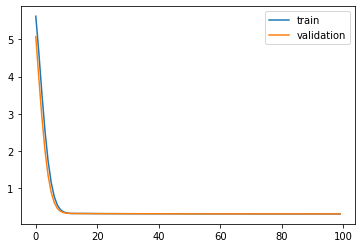

Time to train LSTM:  89.38824152946472
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 5.5992 - acc: 0.6311 - val_loss: 5.0158 - val_acc: 0.8233

Epoch 00001: val_loss improved from inf to 5.01581, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.5506 - acc: 0.8478 - val_loss: 3.8285 - val_acc: 0.8718

Epoch 00002: val_loss improved from 5.01581 to 3.82849, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.3923 - acc: 0.8691 - val_loss: 2.7268 - val_acc: 0.8760

Epoch 00003: val_loss improved from 3.82849 to 2.72683, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.3657 - acc: 0.8730 - val_loss: 1.8280 - val_acc: 0.8767

Epoch 00004: val_loss improved from 2.72683 to 1.82800, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.5658 - acc: 0.8745 - val_loss: 1.1805 - val_acc: 0.8774

Epoch 00005: val_loss improved from 1.82800 to 1.18053, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31472 to 0.31463, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3201 - acc: 0.8783 - val_loss: 0.3145 - val_acc: 0.8804

Epoch 00047: val_loss improved from 0.31463 to 0.31455, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3200 - acc: 0.8784 - val_loss: 0.3145 - val_acc: 0.8808

Epoch 00048: val_loss improved from 0.31455 to 0.31446, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3199 - acc: 0.8784 - val_loss: 0.3144 - val_acc: 0.8807

Epoch 00049: val_loss improved from 0.31446 to 0.31438, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3198 - acc: 0.8785 - val_loss: 0.3143 - val_acc: 0.8807

Epoch 00050: val_loss improved from 0.31438 to 0.31431, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00051: val_loss improved from 0.31431 to 0.31423, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31245 to 0.31242, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8803

Epoch 00093: val_loss improved from 0.31242 to 0.31239, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3124 - val_acc: 0.8804

Epoch 00094: val_loss improved from 0.31239 to 0.31237, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31237 to 0.31234, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8803

Epoch 00096: val_loss improved from 0.31234 to 0.31231, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3175 - acc: 0.8790 - val_loss: 0.3123 - val_acc: 0.8804

Epoch 00097: val_

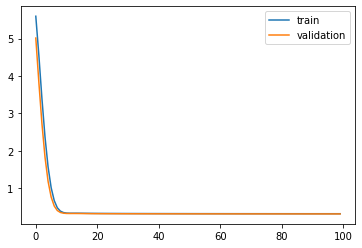

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 5.5997 - acc: 0.6301 - val_loss: 5.0150 - val_acc: 0.8229

Epoch 00001: val_loss improved from inf to 5.01502, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.5495 - acc: 0.8485 - val_loss: 3.8397 - val_acc: 0.8647

Epoch 00002: val_loss improved from 5.01502 to 3.83973, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.3907 - acc: 0.8699 - val_loss: 2.7438 - val_acc: 0.8707

Epoch 00003: val_loss improved from 3.83973 to 2.74383, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.3641 - acc: 0.8736 - val_loss: 1.8469 - val_acc: 0.8730

Epoch 00004: val_loss improved from 2.74383 to 1.84687, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.5645 - acc: 0.8750 - val_loss: 1.1994 - val_acc: 0.8734

Epoch 00005: val_loss improved from 1.84687 to 1.19936, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 1.0107 - acc: 0.8760 - 

 - 1s - loss: 0.3190 - acc: 0.8789 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00047: val_loss improved from 0.32496 to 0.32486, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8770

Epoch 00048: val_loss improved from 0.32486 to 0.32477, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8771

Epoch 00049: val_loss improved from 0.32477 to 0.32469, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8789 - val_loss: 0.3246 - val_acc: 0.8770

Epoch 00050: val_loss improved from 0.32469 to 0.32460, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32460 to 0.32452, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8772

Epoch 00052: val_


Epoch 00092: val_loss improved from 0.32309 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 93/100
 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8758

Epoch 00093: val_loss improved from 0.32308 to 0.32308, saving model to Event_val_weights2.hdf5
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3231 - val_acc: 0.8756

Epoch 00094: val_loss improved from 0.32308 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00095: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00096: val_loss improved from 0.32307 to 0.32307, saving model to Event_val_weights2.hdf5
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3231 - val_acc: 0.8757

Epoch 00097: val_loss did not improve from 0.32307
Epoch 98/100
 - 1s - loss: 0.3164 - ac

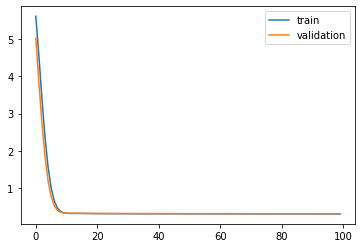

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 5.5998 - acc: 0.6303 - val_loss: 5.0169 - val_acc: 0.8230

Epoch 00001: val_loss improved from inf to 5.01691, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.5498 - acc: 0.8477 - val_loss: 3.8435 - val_acc: 0.8643

Epoch 00002: val_loss improved from 5.01691 to 3.84350, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.3908 - acc: 0.8698 - val_loss: 2.7475 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.84350 to 2.74753, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.3642 - acc: 0.8734 - val_loss: 1.8507 - val_acc: 0.8740

Epoch 00004: val_loss improved from 2.74753 to 1.85074, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.5643 - acc: 0.8750 - val_loss: 1.2027 - val_acc: 0.8746

Epoch 00005: val_loss improved from 1.85074 to 1.20267, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 1.0105 - acc: 0.8757 - 


Epoch 00046: val_loss improved from 0.32514 to 0.32504, saving model to Event_val_weights3.hdf5
Epoch 47/100
 - 1s - loss: 0.3189 - acc: 0.8789 - val_loss: 0.3250 - val_acc: 0.8776

Epoch 00047: val_loss improved from 0.32504 to 0.32495, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3188 - acc: 0.8790 - val_loss: 0.3249 - val_acc: 0.8776

Epoch 00048: val_loss improved from 0.32495 to 0.32487, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3248 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32487 to 0.32478, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00050: val_loss improved from 0.32478 to 0.32470, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8776

Epoch 00051: val_loss improved from 0.32470 to 0.32462, saving model to Event_val_weights

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00092: val_loss did not improve from 0.32318
Epoch 93/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00093: val_loss did not improve from 0.32318
Epoch 94/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8769

Epoch 00094: val_loss did not improve from 0.32318
Epoch 95/100
 - 1s - loss: 0.3164 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00095: val_loss did not improve from 0.32318
Epoch 96/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00096: val_loss did not improve from 0.32318
Epoch 97/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8767

Epoch 00097: val_loss did not improve from 0.32318
Epoch 98/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_loss: 0.3232 - val_acc: 0.8768

Epoch 00098: val_loss did not improve from 0.32318
Epoch 99/100
 - 1s - loss: 0.3164 - acc: 0.8796 - val_

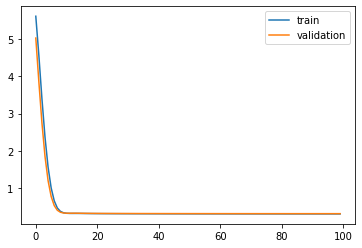

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 5.5991 - acc: 0.6310 - val_loss: 5.0250 - val_acc: 0.8118

Epoch 00001: val_loss improved from inf to 5.02497, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.5495 - acc: 0.8484 - val_loss: 3.8512 - val_acc: 0.8601

Epoch 00002: val_loss improved from 5.02497 to 3.85120, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.3902 - acc: 0.8703 - val_loss: 2.7568 - val_acc: 0.8659

Epoch 00003: val_loss improved from 3.85120 to 2.75681, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.3633 - acc: 0.8740 - val_loss: 1.8595 - val_acc: 0.8667

Epoch 00004: val_loss improved from 2.75681 to 1.85949, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.5636 - acc: 0.8759 - val_loss: 1.2105 - val_acc: 0.8683

Epoch 00005: val_loss improved from 1.85949 to 1.21048, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 1.0097 - acc: 0.8764 - 


Epoch 00046: val_loss improved from 0.32988 to 0.32978, saving model to Event_val_weights4.hdf5
Epoch 47/100
 - 1s - loss: 0.3184 - acc: 0.8797 - val_loss: 0.3297 - val_acc: 0.8716

Epoch 00047: val_loss improved from 0.32978 to 0.32969, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3183 - acc: 0.8798 - val_loss: 0.3296 - val_acc: 0.8716

Epoch 00048: val_loss improved from 0.32969 to 0.32961, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3182 - acc: 0.8798 - val_loss: 0.3295 - val_acc: 0.8714

Epoch 00049: val_loss improved from 0.32961 to 0.32952, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8714

Epoch 00050: val_loss improved from 0.32952 to 0.32944, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8713

Epoch 00051: val_loss improved from 0.32944 to 0.32937, saving model to Event_val_weights

 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00092: val_loss did not improve from 0.32802
Epoch 93/100
 - 1s - loss: 0.3159 - acc: 0.8802 - val_loss: 0.3280 - val_acc: 0.8712

Epoch 00093: val_loss did not improve from 0.32802
Epoch 94/100
 - 1s - loss: 0.3159 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00094: val_loss did not improve from 0.32802
Epoch 95/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00095: val_loss did not improve from 0.32802
Epoch 96/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8711

Epoch 00096: val_loss did not improve from 0.32802
Epoch 97/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3280 - val_acc: 0.8714

Epoch 00097: val_loss did not improve from 0.32802
Epoch 98/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_loss: 0.3281 - val_acc: 0.8714

Epoch 00098: val_loss did not improve from 0.32802
Epoch 99/100
 - 1s - loss: 0.3158 - acc: 0.8801 - val_

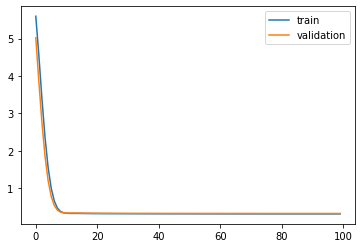

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 5.5997 - acc: 0.6302 - val_loss: 5.0174 - val_acc: 0.8234

Epoch 00001: val_loss improved from inf to 5.01741, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.5511 - acc: 0.8472 - val_loss: 3.8340 - val_acc: 0.8692

Epoch 00002: val_loss improved from 5.01741 to 3.83400, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.3923 - acc: 0.8693 - val_loss: 2.7339 - val_acc: 0.8738

Epoch 00003: val_loss improved from 3.83400 to 2.73394, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.3652 - acc: 0.8731 - val_loss: 1.8352 - val_acc: 0.8770

Epoch 00004: val_loss improved from 2.73394 to 1.83521, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.5651 - acc: 0.8747 - val_loss: 1.1877 - val_acc: 0.8770

Epoch 00005: val_loss improved from 1.83521 to 1.18774, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 1.0109 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32035 to 0.32025, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3195 - acc: 0.8788 - val_loss: 0.3202 - val_acc: 0.8790

Epoch 00047: val_loss improved from 0.32025 to 0.32016, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3193 - acc: 0.8788 - val_loss: 0.3201 - val_acc: 0.8789

Epoch 00048: val_loss improved from 0.32016 to 0.32007, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3192 - acc: 0.8788 - val_loss: 0.3200 - val_acc: 0.8789

Epoch 00049: val_loss improved from 0.32007 to 0.31999, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3199 - val_acc: 0.8789

Epoch 00050: val_loss improved from 0.31999 to 0.31990, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3191 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8789

Epoch 00051: val_loss improved from 0.31990 to 0.31982, saving model to Event_val_weights

 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00092: val_loss improved from 0.31812 to 0.31806, saving model to Event_val_weights5.hdf5
Epoch 93/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00093: val_loss did not improve from 0.31806
Epoch 94/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00094: val_loss improved from 0.31806 to 0.31804, saving model to Event_val_weights5.hdf5
Epoch 95/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00095: val_loss improved from 0.31804 to 0.31802, saving model to Event_val_weights5.hdf5
Epoch 96/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00096: val_loss did not improve from 0.31802
Epoch 97/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8794

Epoch 00097: val_loss did not improve from 0.31802
Epoch 98/100
 - 1s - loss: 0.3171 - acc: 0.8790 - val_lo

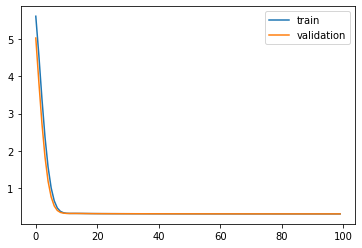

Time to train LSTM:  90.99819159507751
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 5.5786 - acc: 0.6389 - val_loss: 4.9540 - val_acc: 0.8296

Epoch 00001: val_loss improved from inf to 4.95398, saving model to Event_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 4.4628 - acc: 0.8510 - val_loss: 3.7015 - val_acc: 0.8728

Epoch 00002: val_loss improved from 4.95398 to 3.70155, saving model to Event_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 3.2451 - acc: 0.8700 - val_loss: 2.5535 - val_acc: 0.8760

Epoch 00003: val_loss improved from 3.70155 to 2.55351, saving model to Event_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 2.1855 - acc: 0.8732 - val_loss: 1.6443 - val_acc: 0.8768

Epoch 00004: val_loss improved from 2.55351 to 1.64433, saving model to Event_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 1.3889 - acc: 0.8748 - val_loss: 1.0190 - val_acc: 0.8780

Epoch 00005: val_loss improved from 1.64433 to 1.01899, saving model to Event_val_weights1.hdf5
Epoch 6/10


Epoch 00046: val_loss improved from 0.31442 to 0.31433, saving model to Event_val_weights1.hdf5
Epoch 47/100
 - 1s - loss: 0.3197 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00047: val_loss improved from 0.31433 to 0.31425, saving model to Event_val_weights1.hdf5
Epoch 48/100
 - 1s - loss: 0.3196 - acc: 0.8785 - val_loss: 0.3142 - val_acc: 0.8807

Epoch 00048: val_loss improved from 0.31425 to 0.31417, saving model to Event_val_weights1.hdf5
Epoch 49/100
 - 1s - loss: 0.3195 - acc: 0.8785 - val_loss: 0.3141 - val_acc: 0.8806

Epoch 00049: val_loss improved from 0.31417 to 0.31409, saving model to Event_val_weights1.hdf5
Epoch 50/100
 - 1s - loss: 0.3194 - acc: 0.8786 - val_loss: 0.3140 - val_acc: 0.8804

Epoch 00050: val_loss improved from 0.31409 to 0.31402, saving model to Event_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.3193 - acc: 0.8787 - val_loss: 0.3139 - val_acc: 0.8803

Epoch 00051: val_loss improved from 0.31402 to 0.31395, saving model to Event_val_weights

 - 1s - loss: 0.3176 - acc: 0.8791 - val_loss: 0.3122 - val_acc: 0.8804

Epoch 00092: val_loss improved from 0.31221 to 0.31219, saving model to Event_val_weights1.hdf5
Epoch 93/100
 - 1s - loss: 0.3176 - acc: 0.8792 - val_loss: 0.3122 - val_acc: 0.8806

Epoch 00093: val_loss improved from 0.31219 to 0.31217, saving model to Event_val_weights1.hdf5
Epoch 94/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00094: val_loss improved from 0.31217 to 0.31214, saving model to Event_val_weights1.hdf5
Epoch 95/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00095: val_loss improved from 0.31214 to 0.31213, saving model to Event_val_weights1.hdf5
Epoch 96/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8804

Epoch 00096: val_loss improved from 0.31213 to 0.31211, saving model to Event_val_weights1.hdf5
Epoch 97/100
 - 1s - loss: 0.3177 - acc: 0.8791 - val_loss: 0.3121 - val_acc: 0.8806

Epoch 00097: val_

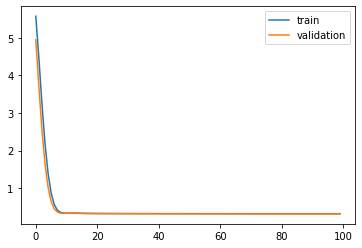

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 5.5791 - acc: 0.6379 - val_loss: 4.9539 - val_acc: 0.8286

Epoch 00001: val_loss improved from inf to 4.95392, saving model to Event_val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 4.4617 - acc: 0.8522 - val_loss: 3.7138 - val_acc: 0.8662

Epoch 00002: val_loss improved from 4.95392 to 3.71378, saving model to Event_val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 3.2434 - acc: 0.8705 - val_loss: 2.5712 - val_acc: 0.8710

Epoch 00003: val_loss improved from 3.71378 to 2.57116, saving model to Event_val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 2.1840 - acc: 0.8737 - val_loss: 1.6636 - val_acc: 0.8729

Epoch 00004: val_loss improved from 2.57116 to 1.66362, saving model to Event_val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 1.3876 - acc: 0.8752 - val_loss: 1.0380 - val_acc: 0.8737

Epoch 00005: val_loss improved from 1.66362 to 1.03798, saving model to Event_val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.8640 - acc: 0.8761 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00047: val_loss improved from 0.32464 to 0.32455, saving model to Event_val_weights2.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3245 - val_acc: 0.8772

Epoch 00048: val_loss improved from 0.32455 to 0.32446, saving model to Event_val_weights2.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00049: val_loss improved from 0.32446 to 0.32438, saving model to Event_val_weights2.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3243 - val_acc: 0.8772

Epoch 00050: val_loss improved from 0.32438 to 0.32430, saving model to Event_val_weights2.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00051: val_loss improved from 0.32430 to 0.32423, saving model to Event_val_weights2.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8790 - val_loss: 0.3242 - val_acc: 0.8771

Epoch 00052: val_

 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8759

Epoch 00094: val_loss did not improve from 0.32314
Epoch 95/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3232 - val_acc: 0.8760

Epoch 00095: val_loss did not improve from 0.32314
Epoch 96/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00096: val_loss did not improve from 0.32314
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00097: val_loss did not improve from 0.32314
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8760

Epoch 00098: val_loss did not improve from 0.32314
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00099: val_loss did not improve from 0.32314
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3233 - val_acc: 0.8759

Epoch 00100: val_loss did not improve from 0.32314
#################################
Number of units: 16

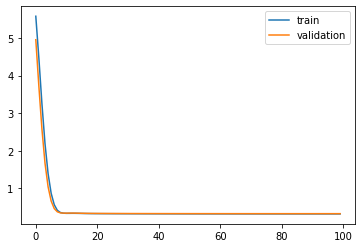

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 5.5792 - acc: 0.6378 - val_loss: 4.9560 - val_acc: 0.8303

Epoch 00001: val_loss improved from inf to 4.95601, saving model to Event_val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 4.4620 - acc: 0.8513 - val_loss: 3.7176 - val_acc: 0.8651

Epoch 00002: val_loss improved from 4.95601 to 3.71757, saving model to Event_val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 3.2435 - acc: 0.8706 - val_loss: 2.5749 - val_acc: 0.8709

Epoch 00003: val_loss improved from 3.71757 to 2.57495, saving model to Event_val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 2.1840 - acc: 0.8739 - val_loss: 1.6676 - val_acc: 0.8741

Epoch 00004: val_loss improved from 2.57495 to 1.66759, saving model to Event_val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 1.3875 - acc: 0.8751 - val_loss: 1.0411 - val_acc: 0.8746

Epoch 00005: val_loss improved from 1.66759 to 1.04112, saving model to Event_val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.8638 - acc: 0.8758 - 

 - 1s - loss: 0.3186 - acc: 0.8790 - val_loss: 0.3247 - val_acc: 0.8777

Epoch 00047: val_loss improved from 0.32474 to 0.32466, saving model to Event_val_weights3.hdf5
Epoch 48/100
 - 1s - loss: 0.3185 - acc: 0.8790 - val_loss: 0.3246 - val_acc: 0.8777

Epoch 00048: val_loss improved from 0.32466 to 0.32457, saving model to Event_val_weights3.hdf5
Epoch 49/100
 - 1s - loss: 0.3184 - acc: 0.8789 - val_loss: 0.3245 - val_acc: 0.8776

Epoch 00049: val_loss improved from 0.32457 to 0.32450, saving model to Event_val_weights3.hdf5
Epoch 50/100
 - 1s - loss: 0.3183 - acc: 0.8790 - val_loss: 0.3244 - val_acc: 0.8774

Epoch 00050: val_loss improved from 0.32450 to 0.32442, saving model to Event_val_weights3.hdf5
Epoch 51/100
 - 1s - loss: 0.3182 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8773

Epoch 00051: val_loss improved from 0.32442 to 0.32435, saving model to Event_val_weights3.hdf5
Epoch 52/100
 - 1s - loss: 0.3181 - acc: 0.8791 - val_loss: 0.3243 - val_acc: 0.8771

Epoch 00052: val_

 - 1s - loss: 0.3165 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8770

Epoch 00096: val_loss did not improve from 0.32330
Epoch 97/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00097: val_loss did not improve from 0.32330
Epoch 98/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3237 - val_acc: 0.8769

Epoch 00098: val_loss did not improve from 0.32330
Epoch 99/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8770

Epoch 00099: val_loss did not improve from 0.32330
Epoch 100/100
 - 1s - loss: 0.3166 - acc: 0.8795 - val_loss: 0.3238 - val_acc: 0.8769

Epoch 00100: val_loss did not improve from 0.32330
#################################
Number of units: 16
Batch size: 16384
Fold: 2
L2 : 0.05441600579314996
LR: 0.04409128374886731
Decay: 5.979204140676134e-08
best val loss: 0.32329559326171875
#################################


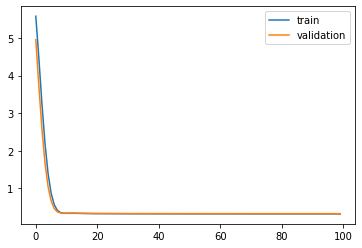

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 5.5786 - acc: 0.6384 - val_loss: 4.9639 - val_acc: 0.8178

Epoch 00001: val_loss improved from inf to 4.96393, saving model to Event_val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 4.4617 - acc: 0.8522 - val_loss: 3.7255 - val_acc: 0.8612

Epoch 00002: val_loss improved from 4.96393 to 3.72552, saving model to Event_val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 3.2429 - acc: 0.8712 - val_loss: 2.5842 - val_acc: 0.8658

Epoch 00003: val_loss improved from 3.72552 to 2.58424, saving model to Event_val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 2.1832 - acc: 0.8745 - val_loss: 1.6761 - val_acc: 0.8674

Epoch 00004: val_loss improved from 2.58424 to 1.67607, saving model to Event_val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 1.3867 - acc: 0.8758 - val_loss: 1.0486 - val_acc: 0.8688

Epoch 00005: val_loss improved from 1.67607 to 1.04856, saving model to Event_val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.8630 - acc: 0.8766 - 

 - 1s - loss: 0.3181 - acc: 0.8798 - val_loss: 0.3294 - val_acc: 0.8712

Epoch 00047: val_loss improved from 0.32948 to 0.32939, saving model to Event_val_weights4.hdf5
Epoch 48/100
 - 1s - loss: 0.3180 - acc: 0.8798 - val_loss: 0.3293 - val_acc: 0.8712

Epoch 00048: val_loss improved from 0.32939 to 0.32931, saving model to Event_val_weights4.hdf5
Epoch 49/100
 - 1s - loss: 0.3179 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8711

Epoch 00049: val_loss improved from 0.32931 to 0.32923, saving model to Event_val_weights4.hdf5
Epoch 50/100
 - 1s - loss: 0.3178 - acc: 0.8798 - val_loss: 0.3292 - val_acc: 0.8712

Epoch 00050: val_loss improved from 0.32923 to 0.32916, saving model to Event_val_weights4.hdf5
Epoch 51/100
 - 1s - loss: 0.3177 - acc: 0.8799 - val_loss: 0.3291 - val_acc: 0.8711

Epoch 00051: val_loss improved from 0.32916 to 0.32909, saving model to Event_val_weights4.hdf5
Epoch 52/100
 - 1s - loss: 0.3176 - acc: 0.8798 - val_loss: 0.3290 - val_acc: 0.8711

Epoch 00052: val_


Epoch 00095: val_loss did not improve from 0.32810
Epoch 96/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00096: val_loss did not improve from 0.32810
Epoch 97/100
 - 1s - loss: 0.3160 - acc: 0.8800 - val_loss: 0.3284 - val_acc: 0.8709

Epoch 00097: val_loss did not improve from 0.32810
Epoch 98/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00098: val_loss did not improve from 0.32810
Epoch 99/100
 - 1s - loss: 0.3160 - acc: 0.8801 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00099: val_loss did not improve from 0.32810
Epoch 100/100
 - 1s - loss: 0.3160 - acc: 0.8802 - val_loss: 0.3285 - val_acc: 0.8710

Epoch 00100: val_loss did not improve from 0.32810
#################################
Number of units: 16
Batch size: 16384
Fold: 3
L2 : 0.05441600579314996
LR: 0.04409128374886731
Decay: 5.979204140676134e-08
best val loss: 0.32809606194496155
#################################


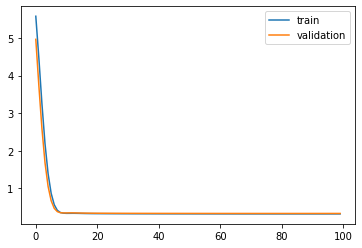

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 5.5792 - acc: 0.6375 - val_loss: 4.9558 - val_acc: 0.8307

Epoch 00001: val_loss improved from inf to 4.95584, saving model to Event_val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 4.4634 - acc: 0.8508 - val_loss: 3.7074 - val_acc: 0.8700

Epoch 00002: val_loss improved from 4.95584 to 3.70737, saving model to Event_val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 3.2449 - acc: 0.8700 - val_loss: 2.5607 - val_acc: 0.8742

Epoch 00003: val_loss improved from 3.70737 to 2.56072, saving model to Event_val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 2.1849 - acc: 0.8735 - val_loss: 1.6516 - val_acc: 0.8776

Epoch 00004: val_loss improved from 2.56072 to 1.65160, saving model to Event_val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 1.3881 - acc: 0.8748 - val_loss: 1.0263 - val_acc: 0.8772

Epoch 00005: val_loss improved from 1.65160 to 1.02630, saving model to Event_val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.8641 - acc: 0.8756 - 


Epoch 00046: val_loss improved from 0.32003 to 0.31994, saving model to Event_val_weights5.hdf5
Epoch 47/100
 - 1s - loss: 0.3191 - acc: 0.8789 - val_loss: 0.3198 - val_acc: 0.8788

Epoch 00047: val_loss improved from 0.31994 to 0.31985, saving model to Event_val_weights5.hdf5
Epoch 48/100
 - 1s - loss: 0.3190 - acc: 0.8788 - val_loss: 0.3198 - val_acc: 0.8791

Epoch 00048: val_loss improved from 0.31985 to 0.31976, saving model to Event_val_weights5.hdf5
Epoch 49/100
 - 1s - loss: 0.3189 - acc: 0.8788 - val_loss: 0.3197 - val_acc: 0.8791

Epoch 00049: val_loss improved from 0.31976 to 0.31968, saving model to Event_val_weights5.hdf5
Epoch 50/100
 - 1s - loss: 0.3188 - acc: 0.8789 - val_loss: 0.3196 - val_acc: 0.8792

Epoch 00050: val_loss improved from 0.31968 to 0.31960, saving model to Event_val_weights5.hdf5
Epoch 51/100
 - 1s - loss: 0.3187 - acc: 0.8789 - val_loss: 0.3195 - val_acc: 0.8793

Epoch 00051: val_loss improved from 0.31960 to 0.31953, saving model to Event_val_weights


Epoch 00093: val_loss improved from 0.31806 to 0.31803, saving model to Event_val_weights5.hdf5
Epoch 94/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3181 - val_acc: 0.8794

Epoch 00094: val_loss did not improve from 0.31803
Epoch 95/100
 - 1s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00095: val_loss did not improve from 0.31803
Epoch 96/100
 - 1s - loss: 0.3173 - acc: 0.8790 - val_loss: 0.3180 - val_acc: 0.8793

Epoch 00096: val_loss did not improve from 0.31803
Epoch 97/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00097: val_loss did not improve from 0.31803
Epoch 98/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.8792

Epoch 00098: val_loss did not improve from 0.31803
Epoch 99/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3181 - val_acc: 0.8793

Epoch 00099: val_loss did not improve from 0.31803
Epoch 100/100
 - 1s - loss: 0.3173 - acc: 0.8791 - val_loss: 0.3180 - val_acc: 0.

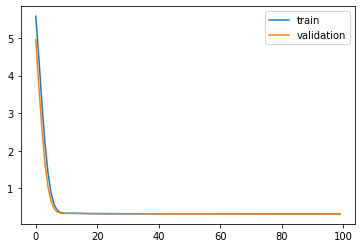

Time to train LSTM:  91.35819697380066
Entire process took:  9744.699809074402
Experiment record:
[[16, 16384, 0.05441600579314996, 0.03576308289373958, 3.985581210035447e-06, 0, 0.31254762411117554], [16, 16384, 0.05441600579314996, 0.03576308289373958, 3.985581210035447e-06, 1, 0.32306617498397827], [16, 16384, 0.05441600579314996, 0.03576308289373958, 3.985581210035447e-06, 2, 0.3230780065059662], [16, 16384, 0.05441600579314996, 0.03576308289373958, 3.985581210035447e-06, 3, 0.32795920968055725], [16, 16384, 0.05441600579314996, 0.03576308289373958, 3.985581210035447e-06, 4, 0.31813740730285645], [16, 16384, 0.05441600579314996, 0.042799187922401144, 2.690061803835159e-07, 0, 0.31208857893943787], [16, 16384, 0.05441600579314996, 0.042799187922401144, 2.690061803835159e-07, 1, 0.3231160342693329], [16, 16384, 0.05441600579314996, 0.042799187922401144, 2.690061803835159e-07, 2, 0.32325416803359985], [16, 16384, 0.05441600579314996, 0.042799187922401144, 2.690061803835159e-07, 3, 0.3

In [12]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 16
batch_s = 16384
L2_1 = 0.05441600579314996

start_time = time.time()

#lr_list = [0.03987630160515601, 0.038245434054820546, 0.03547018571391636, 0.03338519623183323, 0.04056298580490226, 0.03595353565272186, 0.04339705265871725, 0.037950910299981724, 0.03947146500565393, 0.04113387739738984, 0.04975560678433541, 0.045496454923046034, 0.03533002337040452, 0.04690669138016569, 0.045593985814263036, 0.026361862695558867, 0.04296593091410486, 0.04505426406061189, 0.043410166095285974, 0.042728293769529184]
#decay_list = [3.6766162899670417e-07, 1.0270347141452551e-07, 3.081568945024038e-06, 4.5434016992397886e-07, 6.338524505782494e-07, 3.675663188445745e-07, 1.3344457741334481e-07, 1.978702319748868e-06, 3.1097953157963638e-06, 1.566949434233884e-06, 3.2135019340712873e-07, 3.5633531456053403e-07, 1.5409353131836596e-06, 1.0501233212386786e-07, 1.256034124038406e-06, 1.7880642980882373e-06, 3.808402027227084e-07, 6.840421973086213e-06, 1.5968133777337961e-06, 2.8723546903939884e-07]

print(len(lr_list) == len(decay_list))

exp_record = []

for i in range(len(lr_list)):
    lr = lr_list[i]
    decay = decay_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) 
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)
        ######################
        seed(1)
        set_random_seed(1)
        ######################
        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(CuDNNLSTM(units, 
                                kernel_regularizer=regularizers.l2(L2_1),
                                #return_sequences=True, 
                                input_shape=(8, 182))) 
            #model.add(CuDNNLSTM(units, 
            #                    kernel_regularizer=regularizers.l2(L2_2)))
            model.add(Dense(2, activation='softmax'))
            sgdm = optimizers.SGD(lr=lr, momentum=0.9, decay=decay) 
            model.compile(loss='categorical_crossentropy', 
                          optimizer=sgdm, metrics=['accuracy'])
            val_weight = "Event_val_weights" + str(f+1) + ".hdf5"
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("Fold:", f)
            print("L2 :", L2_1)
            print("LR:", lr)
            print("Decay:", decay)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, lr, decay, f, min(history.history['val_loss'])])
            #exp_record.append([units, batch_s, L2_1, L2_2, f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [13]:
#exp_record = [[16, 16384, 0.05441600579314996, 0.04732150378590004, 8.281829615574751e-07, 0, 0.3120262920856476], [16, 16384, 0.05441600579314996, 0.04732150378590004, 8.281829615574751e-07, 1, 0.3232078552246094], [16, 16384, 0.05441600579314996, 0.04732150378590004, 8.281829615574751e-07, 2, 0.3233982026576996], [16, 16384, 0.05441600579314996, 0.04732150378590004, 8.281829615574751e-07, 3, 0.32816606760025024], [16, 16384, 0.05441600579314996, 0.04732150378590004, 8.281829615574751e-07, 4, 0.3180777430534363], [16, 16384, 0.05441600579314996, 0.03329949513252943, 5.627968412340616e-06, 0, 0.31273528933525085], [16, 16384, 0.05441600579314996, 0.03329949513252943, 5.627968412340616e-06, 1, 0.32314828038215637], [16, 16384, 0.05441600579314996, 0.03329949513252943, 5.627968412340616e-06, 2, 0.32314586639404297], [16, 16384, 0.05441600579314996, 0.03329949513252943, 5.627968412340616e-06, 3, 0.32803159952163696], [16, 16384, 0.05441600579314996, 0.03329949513252943, 5.627968412340616e-06, 4, 0.3182762563228607], [16, 16384, 0.05441600579314996, 0.0455307280764458, 1.2153613162323311e-07, 0, 0.31203174591064453], [16, 16384, 0.05441600579314996, 0.0455307280764458, 1.2153613162323311e-07, 1, 0.32317087054252625], [16, 16384, 0.05441600579314996, 0.0455307280764458, 1.2153613162323311e-07, 2, 0.3233413100242615], [16, 16384, 0.05441600579314996, 0.0455307280764458, 1.2153613162323311e-07, 3, 0.3281277120113373], [16, 16384, 0.05441600579314996, 0.0455307280764458, 1.2153613162323311e-07, 4, 0.31804338097572327], [16, 16384, 0.05441600579314996, 0.02604241564313125, 1.5613037489711254e-06, 0, 0.31340062618255615], [16, 16384, 0.05441600579314996, 0.02604241564313125, 1.5613037489711254e-06, 1, 0.32364535331726074], [16, 16384, 0.05441600579314996, 0.02604241564313125, 1.5613037489711254e-06, 2, 0.32370391488075256], [16, 16384, 0.05441600579314996, 0.02604241564313125, 1.5613037489711254e-06, 3, 0.3285379111766815], [16, 16384, 0.05441600579314996, 0.02604241564313125, 1.5613037489711254e-06, 4, 0.31890353560447693], [16, 16384, 0.05441600579314996, 0.0276914169983992, 3.6821178069060155e-06, 0, 0.3132310211658478], [16, 16384, 0.05441600579314996, 0.0276914169983992, 3.6821178069060155e-06, 1, 0.32349541783332825], [16, 16384, 0.05441600579314996, 0.0276914169983992, 3.6821178069060155e-06, 2, 0.3235394060611725], [16, 16384, 0.05441600579314996, 0.0276914169983992, 3.6821178069060155e-06, 3, 0.32839030027389526], [16, 16384, 0.05441600579314996, 0.0276914169983992, 3.6821178069060155e-06, 4, 0.31873297691345215], [16, 16384, 0.05441600579314996, 0.03987630160515601, 3.6766162899670417e-07, 0, 0.3122531771659851], [16, 16384, 0.05441600579314996, 0.03987630160515601, 3.6766162899670417e-07, 1, 0.3230595588684082], [16, 16384, 0.05441600579314996, 0.03987630160515601, 3.6766162899670417e-07, 2, 0.3231618106365204], [16, 16384, 0.05441600579314996, 0.03987630160515601, 3.6766162899670417e-07, 3, 0.3280041217803955], [16, 16384, 0.05441600579314996, 0.03987630160515601, 3.6766162899670417e-07, 4, 0.3180035948753357], [16, 16384, 0.05441600579314996, 0.038245434054820546, 1.0270347141452551e-07, 0, 0.3123664855957031], [16, 16384, 0.05441600579314996, 0.038245434054820546, 1.0270347141452551e-07, 1, 0.3230382800102234], [16, 16384, 0.05441600579314996, 0.038245434054820546, 1.0270347141452551e-07, 2, 0.3231099843978882], [16, 16384, 0.05441600579314996, 0.038245434054820546, 1.0270347141452551e-07, 3, 0.3279694616794586], [16, 16384, 0.05441600579314996, 0.038245434054820546, 1.0270347141452551e-07, 4, 0.3180142641067505], [16, 16384, 0.05441600579314996, 0.03547018571391636, 3.081568945024038e-06, 0, 0.3125685453414917], [16, 16384, 0.05441600579314996, 0.03547018571391636, 3.081568945024038e-06, 1, 0.3230733573436737], [16, 16384, 0.05441600579314996, 0.03547018571391636, 3.081568945024038e-06, 2, 0.32308173179626465], [16, 16384, 0.05441600579314996, 0.03547018571391636, 3.081568945024038e-06, 3, 0.3279642164707184], [16, 16384, 0.05441600579314996, 0.03547018571391636, 3.081568945024038e-06, 4, 0.3181503117084503], [16, 16384, 0.05441600579314996, 0.03338519623183323, 4.5434016992397886e-07, 0, 0.3127250373363495], [16, 16384, 0.05441600579314996, 0.03338519623183323, 4.5434016992397886e-07, 1, 0.32314333319664], [16, 16384, 0.05441600579314996, 0.03338519623183323, 4.5434016992397886e-07, 2, 0.3231411278247833], [16, 16384, 0.05441600579314996, 0.03338519623183323, 4.5434016992397886e-07, 3, 0.32802698016166687], [16, 16384, 0.05441600579314996, 0.03338519623183323, 4.5434016992397886e-07, 4, 0.3182680904865265], [16, 16384, 0.05441600579314996, 0.04056298580490226, 6.338524505782494e-07, 0, 0.312207967042923], [16, 16384, 0.05441600579314996, 0.04056298580490226, 6.338524505782494e-07, 1, 0.32307249307632446], [16, 16384, 0.05441600579314996, 0.04056298580490226, 6.338524505782494e-07, 2, 0.32318317890167236], [16, 16384, 0.05441600579314996, 0.04056298580490226, 6.338524505782494e-07, 3, 0.3280186653137207], [16, 16384, 0.05441600579314996, 0.04056298580490226, 6.338524505782494e-07, 4, 0.3180079162120819], [16, 16384, 0.05441600579314996, 0.03595353565272186, 3.675663188445745e-07, 0, 0.31253117322921753], [16, 16384, 0.05441600579314996, 0.03595353565272186, 3.675663188445745e-07, 1, 0.32306158542633057], [16, 16384, 0.05441600579314996, 0.03595353565272186, 3.675663188445745e-07, 2, 0.3230767846107483], [16, 16384, 0.05441600579314996, 0.03595353565272186, 3.675663188445745e-07, 3, 0.32795682549476624], [16, 16384, 0.05441600579314996, 0.03595353565272186, 3.675663188445745e-07, 4, 0.31812578439712524], [16, 16384, 0.05441600579314996, 0.04339705265871725, 1.3344457741334481e-07, 0, 0.3120681345462799], [16, 16384, 0.05441600579314996, 0.04339705265871725, 1.3344457741334481e-07, 1, 0.32312777638435364], [16, 16384, 0.05441600579314996, 0.04339705265871725, 1.3344457741334481e-07, 2, 0.32327336072921753], [16, 16384, 0.05441600579314996, 0.04339705265871725, 1.3344457741334481e-07, 3, 0.32808083295822144], [16, 16384, 0.05441600579314996, 0.04339705265871725, 1.3344457741334481e-07, 4, 0.3180217146873474], [16, 16384, 0.05441600579314996, 0.037950910299981724, 1.978702319748868e-06, 0, 0.3123887777328491], [16, 16384, 0.05441600579314996, 0.037950910299981724, 1.978702319748868e-06, 1, 0.3230377435684204], [16, 16384, 0.05441600579314996, 0.037950910299981724, 1.978702319748868e-06, 2, 0.323099285364151], [16, 16384, 0.05441600579314996, 0.037950910299981724, 1.978702319748868e-06, 3, 0.32796236872673035], [16, 16384, 0.05441600579314996, 0.037950910299981724, 1.978702319748868e-06, 4, 0.3180486559867859], [16, 16384, 0.05441600579314996, 0.03947146500565393, 3.1097953157963638e-06, 0, 0.3122829496860504], [16, 16384, 0.05441600579314996, 0.03947146500565393, 3.1097953157963638e-06, 1, 0.32305100560188293], [16, 16384, 0.05441600579314996, 0.03947146500565393, 3.1097953157963638e-06, 2, 0.3231474459171295], [16, 16384, 0.05441600579314996, 0.03947146500565393, 3.1097953157963638e-06, 3, 0.32799410820007324], [16, 16384, 0.05441600579314996, 0.03947146500565393, 3.1097953157963638e-06, 4, 0.31800979375839233], [16, 16384, 0.05441600579314996, 0.04113387739738984, 1.566949434233884e-06, 0, 0.312173068523407], [16, 16384, 0.05441600579314996, 0.04113387739738984, 1.566949434233884e-06, 1, 0.32308295369148254], [16, 16384, 0.05441600579314996, 0.04113387739738984, 1.566949434233884e-06, 2, 0.3232007622718811], [16, 16384, 0.05441600579314996, 0.04113387739738984, 1.566949434233884e-06, 3, 0.32803070545196533], [16, 16384, 0.05441600579314996, 0.04113387739738984, 1.566949434233884e-06, 4, 0.3179798722267151], [16, 16384, 0.05441600579314996, 0.04975560678433541, 3.2135019340712873e-07, 0, 0.31204017996788025], [16, 16384, 0.05441600579314996, 0.04975560678433541, 3.2135019340712873e-07, 1, 0.3232593834400177], [16, 16384, 0.05441600579314996, 0.04975560678433541, 3.2135019340712873e-07, 2, 0.3234758973121643], [16, 16384, 0.05441600579314996, 0.04975560678433541, 3.2135019340712873e-07, 3, 0.3282194435596466], [16, 16384, 0.05441600579314996, 0.04975560678433541, 3.2135019340712873e-07, 4, 0.3181285560131073], [16, 16384, 0.05441600579314996, 0.045496454923046034, 3.5633531456053403e-07, 0, 0.3120320439338684], [16, 16384, 0.05441600579314996, 0.045496454923046034, 3.5633531456053403e-07, 1, 0.32317012548446655], [16, 16384, 0.05441600579314996, 0.045496454923046034, 3.5633531456053403e-07, 2, 0.3233400583267212], [16, 16384, 0.05441600579314996, 0.045496454923046034, 3.5633531456053403e-07, 3, 0.3281269371509552], [16, 16384, 0.05441600579314996, 0.045496454923046034, 3.5633531456053403e-07, 4, 0.31805503368377686], [16, 16384, 0.05441600579314996, 0.03533002337040452, 1.5409353131836596e-06, 0, 0.3125777840614319], [16, 16384, 0.05441600579314996, 0.03533002337040452, 1.5409353131836596e-06, 1, 0.32307684421539307], [16, 16384, 0.05441600579314996, 0.03533002337040452, 1.5409353131836596e-06, 2, 0.3230839669704437], [16, 16384, 0.05441600579314996, 0.03533002337040452, 1.5409353131836596e-06, 3, 0.32796692848205566], [16, 16384, 0.05441600579314996, 0.03533002337040452, 1.5409353131836596e-06, 4, 0.3181571960449219], [16, 16384, 0.05441600579314996, 0.04690669138016569, 1.0501233212386786e-07, 0, 0.3120262920856476], [16, 16384, 0.05441600579314996, 0.04690669138016569, 1.0501233212386786e-07, 1, 0.32319945096969604], [16, 16384, 0.05441600579314996, 0.04690669138016569, 1.0501233212386786e-07, 2, 0.32338547706604004], [16, 16384, 0.05441600579314996, 0.04690669138016569, 1.0501233212386786e-07, 3, 0.3281574845314026], [16, 16384, 0.05441600579314996, 0.04690669138016569, 1.0501233212386786e-07, 4, 0.3180712163448334], [16, 16384, 0.05441600579314996, 0.045593985814263036, 1.256034124038406e-06, 0, 0.31203126907348633], [16, 16384, 0.05441600579314996, 0.045593985814263036, 1.256034124038406e-06, 1, 0.3231717050075531], [16, 16384, 0.05441600579314996, 0.045593985814263036, 1.256034124038406e-06, 2, 0.32334282994270325], [16, 16384, 0.05441600579314996, 0.045593985814263036, 1.256034124038406e-06, 3, 0.32812851667404175], [16, 16384, 0.05441600579314996, 0.045593985814263036, 1.256034124038406e-06, 4, 0.3180425465106964], [16, 16384, 0.05441600579314996, 0.026361862695558867, 1.7880642980882373e-06, 0, 0.31336668133735657], [16, 16384, 0.05441600579314996, 0.026361862695558867, 1.7880642980882373e-06, 1, 0.3236143887042999], [16, 16384, 0.05441600579314996, 0.026361862695558867, 1.7880642980882373e-06, 2, 0.323669970035553], [16, 16384, 0.05441600579314996, 0.026361862695558867, 1.7880642980882373e-06, 3, 0.32850775122642517], [16, 16384, 0.05441600579314996, 0.026361862695558867, 1.7880642980882373e-06, 4, 0.31886905431747437], [16, 16384, 0.05441600579314996, 0.04296593091410486, 3.808402027227084e-07, 0, 0.3120823800563812], [16, 16384, 0.05441600579314996, 0.04296593091410486, 3.808402027227084e-07, 1, 0.32311907410621643], [16, 16384, 0.05441600579314996, 0.04296593091410486, 3.808402027227084e-07, 2, 0.323259562253952], [16, 16384, 0.05441600579314996, 0.04296593091410486, 3.808402027227084e-07, 3, 0.3280711770057678], [16, 16384, 0.05441600579314996, 0.04296593091410486, 3.808402027227084e-07, 4, 0.31802281737327576], [16, 16384, 0.05441600579314996, 0.04505426406061189, 6.840421973086213e-06, 0, 0.3120364844799042], [16, 16384, 0.05441600579314996, 0.04505426406061189, 6.840421973086213e-06, 1, 0.3231586813926697], [16, 16384, 0.05441600579314996, 0.04505426406061189, 6.840421973086213e-06, 2, 0.3233225643634796], [16, 16384, 0.05441600579314996, 0.04505426406061189, 6.840421973086213e-06, 3, 0.3281143307685852], [16, 16384, 0.05441600579314996, 0.04505426406061189, 6.840421973086213e-06, 4, 0.3180307149887085], [16, 16384, 0.05441600579314996, 0.043410166095285974, 1.5968133777337961e-06, 0, 0.3120681941509247], [16, 16384, 0.05441600579314996, 0.043410166095285974, 1.5968133777337961e-06, 1, 0.323127418756485], [16, 16384, 0.05441600579314996, 0.043410166095285974, 1.5968133777337961e-06, 2, 0.3232730031013489], [16, 16384, 0.05441600579314996, 0.043410166095285974, 1.5968133777337961e-06, 3, 0.3280804455280304], [16, 16384, 0.05441600579314996, 0.043410166095285974, 1.5968133777337961e-06, 4, 0.3180104196071625], [16, 16384, 0.05441600579314996, 0.042728293769529184, 2.8723546903939884e-07, 0, 0.3120913505554199], [16, 16384, 0.05441600579314996, 0.042728293769529184, 2.8723546903939884e-07, 1, 0.3231145143508911], [16, 16384, 0.05441600579314996, 0.042728293769529184, 2.8723546903939884e-07, 2, 0.3232519030570984], [16, 16384, 0.05441600579314996, 0.042728293769529184, 2.8723546903939884e-07, 3, 0.3280662000179291], [16, 16384, 0.05441600579314996, 0.042728293769529184, 2.8723546903939884e-07, 4, 0.3180173635482788]]
              
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    print("L2 :", h_params[0, 2])
    print("learning rate:", h_params[0, 3])
    print("Decay:", h_params[0, 4])
    #print("Val loss (mean):", np.mean(h_params[:, 5]))
    #print("Val loss (std):", np.std(h_params[:, 5]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 6]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 6]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 6]))
print(min(val_loss_list))
print("max LR:", max(complete_v[:, 3]))
print("min LR", min(complete_v[:, 3]))
print("max Decay:", max(complete_v[:, 4]))
print("min Decay", min(complete_v[:, 4]))

(125, 7)
###############################
Units: 16.0
Batch size: 16384.0
L2 : 0.05441600579314996
learning rate: 0.03576308289373958
Decay: 3.985581210035447e-06
Val loss (mean): 0.32096
Val loss (std): 0.00523
###############################
###############################
Units: 16.0
Batch size: 16384.0
L2 : 0.05441600579314996
learning rate: 0.042799187922401144
Decay: 2.690061803835159e-07
Val loss (mean): 0.32091
Val loss (std): 0.00544
###############################
###############################
Units: 16.0
Batch size: 16384.0
L2 : 0.05441600579314996
learning rate: 0.03938409231440894
Decay: 5.607514725076507e-08
Val loss (mean): 0.3209
Val loss (std): 0.00534
###############################
###############################
Units: 16.0
Batch size: 16384.0
L2 : 0.05441600579314996
learning rate: 0.042234651778309415
Decay: 9.83921107512064e-08
Val loss (mean): 0.3209
Val loss (std): 0.00542
###############################
###############################
Units: 16.0
Batch size: 

## Surface plot

In [50]:
import matplotlib
matplotlib.__version__
import matplotlib.colors as mcolors

In [4]:
# LSTM
'''
x = np.array([8,16,32, 64, 128])
y = np.array([2048, 4096, 8192, 16384, 32768])
complete_list = [[0.3227, 0.3233, 0.32294, 0.32341, 0.32339], 
                 [0.32199, 0.322, 0.32244, 0.32247, 0.32236], 
                 [0.3215, 0.32179, 0.32207, 0.32145, 0.32124], 
                 [0.32137, 0.32089, 0.32109, 0.3214, 0.32172], 
                 [0.32619, 0.32358, 0.32183, 0.3214, 0.32154]]
'''
# SimpleRNN L2 0.1

#                 [0.45296,0.45168,0.45208,0.45476,0.45669],
#                 [0.44948,0.44763,0.44831,0.45019,0.45222]
x = np.array([4, 8,16,32, 64])
y = np.array([1024, 2048, 4096, 8192, 16384])
complete_list = [[0.32383,0.32413,0.32469,0.32575,0.32704],
                 [0.32374,0.32397,0.32389,0.32491,0.32528],
                 [0.32361,0.32395,0.32367,0.32374,0.32441],
                 [0.32439,0.32233,0.32293,0.32359,0.32451], 
                 [0.32843,0.32361,0.32307,0.32285,0.32428]]

#MLP
'''
x = np.array([4,8,16,32,64])
y = np.array([32, 64, 128, 256, 512])
complete_list = [[0.32823, 0.32331, 0.32224, 0.3224, 0.32403], 
                 [0.32607, 0.32277, 0.32192, 0.32331, 0.3243], 
                 [0.32949, 0.32275, 0.3223, 0.32296, 0.32288], 
                 [0.32939, 0.32319, 0.32269, 0.32269, 0.32447], 
                 [0.32746, 0.32547, 0.32425, 0.32416, 0.32397]]
'''
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]]
[[ 1024  1024  1024  1024  1024]
 [ 2048  2048  2048  2048  2048]
 [ 4096  4096  4096  4096  4096]
 [ 8192  8192  8192  8192  8192]
 [16384 16384 16384 16384 16384]]
[[0.32383 0.32413 0.32469 0.32575 0.32704]
 [0.32374 0.32397 0.32389 0.32491 0.32528]
 [0.32361 0.32395 0.32367 0.32374 0.32441]
 [0.32439 0.32233 0.32293 0.32359 0.32451]
 [0.32843 0.32361 0.32307 0.32285 0.32428]]


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


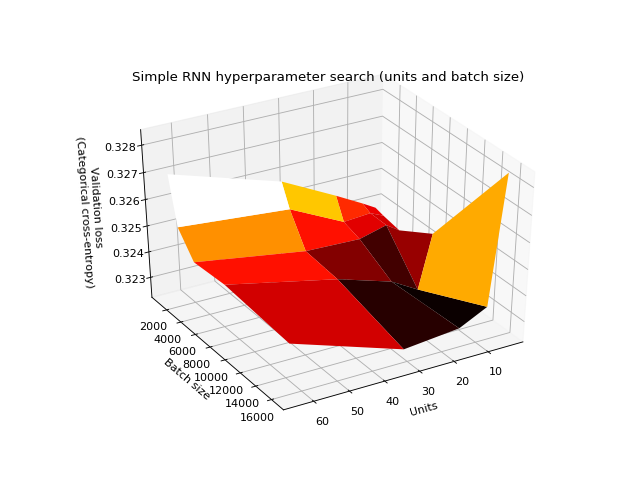

In [5]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors

X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
# reset norm of color map
#z_mean = np.mean(z)
#print(z_mean)
#mcolors.DivergingNorm(vmin=np.min(z), vcenter= np.mean(z), vmax=np.max(z))

print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')

ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss \n (Categorical cross-entropy)', labelpad=10)

ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='hot', edgecolor='none')#'winter' #hot #afmhot
ax.set_title('Simple RNN hyperparameter search (units and batch size)')
pyplot.show()

In [60]:
filename = "/home/whsu014/plots/EVENT_MLP_HyperparameterSearch_unit_batch_size_no_title.png"
pyplot.savefig(filename)
pyplot.tight_layout()